In [ ]:
pip install sentencepiece

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/data"
%pwd
%ls

/content/drive/MyDrive/data
raw_data_PHP.de.trg  src/          src_sp.vocab      trg/          trg_sp.vocab
raw_data_PHP.en.src  src_sp.model  translations.txt  trg_sp.model


In [ ]:
from torch import nn
from nltk.translate.bleu_score import corpus_bleu
import torch
import math
import numpy as np
import argparse
from torch.utils.data import DataLoader
import sentencepiece as spm
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import sys,os
import datetime
import copy
import heapq
import matplotlib.pyplot as plt
import heapq


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
learning_rate = 1e-4
batch_size = 30
seq_len = 200
num_heads = 8

num_layers = 6
d_model = 512
d_ff = 2048
d_k = d_model // num_heads
drop_out_rate = 0.1
num_epochs = 15
beam_size = 8
ckpt_dir = '/content/drive/MyDrive/saved_model'

# Path or parameters for data
DATA_DIR = '/content/drive/MyDrive/data'
SP_DIR = f'{DATA_DIR}'
SRC_DIR = 'src'
TRG_DIR = 'trg'
SRC_RAW_DATA_NAME =  'raw_data_PHP.de.trg'
TRG_RAW_DATA_NAME = 'raw_data_PHP.en.src'
TRAIN_NAME = 'train.txt'
VALID_NAME = 'valid.txt'
TEST_NAME = 'test.txt'

# Parameters for sentencepiece tokenizer
pad_id = 0
sos_id = 1
eos_id = 2
unk_id = 3
src_model_prefix = 'src_sp'
trg_model_prefix = 'trg_sp'
sp_vocab_size =13523 # 9811   for german i.e target
character_coverage = 1.0
model_type = 'unigram'
train_loss_inepocs=[]
val_loss_inepochs=[]

In [ ]:

def train_sp(is_src=True):
    template = "--input={} \
                --pad_id={} \
                --bos_id={} \
                --eos_id={} \
                --unk_id={} \
                --model_prefix={} \
                --vocab_size={} \
                --character_coverage={} \
                --model_type={}"

    if is_src:
        this_input_file = f"{DATA_DIR}/{SRC_RAW_DATA_NAME}"
        this_model_prefix = f"{SP_DIR}/{src_model_prefix}"
    else:
        this_input_file = f"{DATA_DIR}/{TRG_RAW_DATA_NAME}"
        this_model_prefix = f"{SP_DIR}/{trg_model_prefix}"

    config = template.format(this_input_file,pad_id,sos_id,eos_id,unk_id,this_model_prefix,sp_vocab_size,
character_coverage,model_type)
    print("printing config :- ",config)

    if not os.path.isdir(SP_DIR):
        os.mkdir(SP_DIR)

    print("printing spm :- ",spm)
    spm.SentencePieceTrainer.Train(config)


def split_data(src_raw_data_name,trg_raw_data_name, data_dir,is_src):
    with open(f"{DATA_DIR}/{src_raw_data_name}") as f:
      line_src=f.readlines()
      
    with open(f"{DATA_DIR}/{trg_raw_data_name}") as f:
      line_trg = f.readlines()  

    sum_list=[]
    for (item1, item2) in zip(line_src, line_trg):
        sum_list.append(item1+"_yolo_"+item2)
    print(len(sum_list))
    sum_list=list(set(sum_list))
    if is_src:
      lines=[i.split('_yolo_', 1)[0] for i in sum_list]
    else:
      lines=[i.split('_yolo_', 1)[1] for i in sum_list]

    
    print("Splitting data...")
    print(len(lines))
    print(type(lines))
    train_frac=0.7
    val_frac=0.9
    train_lines = lines[:int(train_frac * len(lines))]
    valid_lines = lines[int(train_frac * len(lines)):int(val_frac * len(lines))]
    test_lines = lines[int(val_frac * len(lines)):]
    


    if not os.path.isdir(f"{DATA_DIR}/{data_dir}"):
        os.mkdir(f"{DATA_DIR}/{data_dir}")
    
    with open(f"{DATA_DIR}/{data_dir}/{TRAIN_NAME}", 'w') as f:
        for line in tqdm(train_lines):
            f.write(line.strip() + '\n')
            
    with open(f"{DATA_DIR}/{data_dir}/{VALID_NAME}", 'w') as f:
        for line in tqdm(valid_lines):
            f.write(line.strip() + '\n')

    with open(f"{DATA_DIR}/{data_dir}/{TEST_NAME}", 'w') as f:
        for line in tqdm(test_lines):
            f.write(line.strip() + '\n')
            
    print(f"Train/Validation and test data saved in {DATA_DIR}/{data_dir}.")

    
train_sp(is_src=True)



printing config :-  --input=/content/drive/MyDrive/data/raw_data_PHP.de.trg                 --pad_id=0                 --bos_id=1                 --eos_id=2                 --unk_id=3                 --model_prefix=/content/drive/MyDrive/data/src_sp                 --vocab_size=13523                 --character_coverage=1.0                 --model_type=unigram
printing spm :-  <module 'sentencepiece' from '/usr/local/lib/python3.7/dist-packages/sentencepiece/__init__.py'>


In [ ]:
sp_vocab_size =9811
train_sp(is_src=False)

printing config :-  --input=/content/drive/MyDrive/data/raw_data_PHP.en.src                 --pad_id=0                 --bos_id=1                 --eos_id=2                 --unk_id=3                 --model_prefix=/content/drive/MyDrive/data/trg_sp                 --vocab_size=9811                 --character_coverage=1.0                 --model_type=unigram
printing spm :-  <module 'sentencepiece' from '/usr/local/lib/python3.7/dist-packages/sentencepiece/__init__.py'>


In [ ]:
split_data(SRC_RAW_DATA_NAME,TRG_RAW_DATA_NAME, SRC_DIR,is_src=True)
split_data(SRC_RAW_DATA_NAME,TRG_RAW_DATA_NAME, TRG_DIR,is_src=False )

39707
Splitting data...
12281
<class 'list'>


100%|██████████| 1229/1229 [00:00<00:00, 519322.95it/s]


Train/Validation and test data saved in /content/drive/MyDrive/data/src.
39707
Splitting data...
12281
<class 'list'>


100%|██████████| 1229/1229 [00:00<00:00, 604101.68it/s]


Train/Validation and test data saved in /content/drive/MyDrive/data/trg.


In [ ]:
src_sp = spm.SentencePieceProcessor()
trg_sp = spm.SentencePieceProcessor()
src_sp.Load(f"{SP_DIR}/{src_model_prefix}.model")
trg_sp.Load(f"{SP_DIR}/{trg_model_prefix}.model")

True

In [ ]:
#data preprocessing
def get_data_loader(file_name):
    print(f"Getting source/target {file_name}...")
    with open(f"{DATA_DIR}/{SRC_DIR}/{file_name}", 'r') as f:
        src_text_list = f.readlines()

    with open(f"{DATA_DIR}/{TRG_DIR}/{file_name}", 'r') as f:
        trg_text_list = f.readlines()

    print("Tokenizing & Padding src data...")
    src_list = process_src(src_text_list) # (sample_num, L)
    print(f"The shape of src data: {np.shape(src_list)}")

    print("Tokenizing & Padding trg data...")
    input_trg_list, output_trg_list = process_trg(trg_text_list) # (sample_num, L)
    print(f"The shape of input trg data: {np.shape(input_trg_list)}")
    print(f"The shape of output trg data: {np.shape(output_trg_list)}")

    dataset = CustomDataset(src_list, input_trg_list, output_trg_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


def pad_or_truncate(tokenized_text):
    if len(tokenized_text) < seq_len:
        left = seq_len - len(tokenized_text)
        padding = [pad_id] * left
        tokenized_text += padding
    else:
        tokenized_text = tokenized_text[:seq_len]

    return tokenized_text


def process_src(text_list):
    tokenized_list = []
    for text in tqdm(text_list):
        tokenized = src_sp.EncodeAsIds(text.strip())
        tokenized_list.append(pad_or_truncate(tokenized + [eos_id]))

    print("The tokenized and padded source data eg. :- ",tokenized_list[:10])    

    return tokenized_list

def process_trg(text_list):
    input_tokenized_list = []
    output_tokenized_list = []
    for text in tqdm(text_list):
        tokenized = trg_sp.EncodeAsIds(text.strip())
        trg_input = [sos_id] + tokenized
        trg_output = tokenized + [eos_id]
        input_tokenized_list.append(pad_or_truncate(trg_input))
        output_tokenized_list.append(pad_or_truncate(trg_output))
    print("The tokenized and padded input target data eg. :- ",input_tokenized_list[:10])
    print("The tokenized and padded output target data eg. :- ",output_tokenized_list[:10]) 
    return input_tokenized_list, output_tokenized_list
class CustomDataset(Dataset):
    def __init__(self, src_list, input_trg_list, output_trg_list):
        super().__init__()
        self.src_data = torch.LongTensor(src_list)
        self.input_trg_data = torch.LongTensor(input_trg_list)
        self.output_trg_data = torch.LongTensor(output_trg_list)

        assert np.shape(src_list) == np.shape(input_trg_list), "The shape of src_list and input_trg_list are different."
        assert np.shape(input_trg_list) == np.shape(output_trg_list), "The shape of input_trg_list and output_trg_list are different."

    def make_mask(self):#creating masks for encoder and the decoder
        e_mask = (self.src_data != pad_id).unsqueeze(1) # (num_samples, 1, L)
        d_mask = (self.input_trg_data != pad_id).unsqueeze(1) # (num_samples, 1, L)

        nopeak_mask = torch.ones([1, seq_len, seq_len], dtype=torch.bool) # (1, L, L)
        nopeak_mask = torch.tril(nopeak_mask) # (1, L, L) to triangular shape
        d_mask = d_mask & nopeak_mask # (num_samples, L, L) padding false

        return e_mask, d_mask

    def __getitem__(self, idx):
        return self.src_data[idx], self.input_trg_data[idx], self.output_trg_data[idx]

    def __len__(self):
        return np.shape(self.src_data)[0]

In [ ]:
#transformer layers and structure:-


class EncoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = LayerNormalization()
        self.multihead_attention = MultiheadAttention()
        self.drop_out_1 = nn.Dropout(drop_out_rate)

        self.layer_norm_2 = LayerNormalization()
        self.feed_forward = FeedFowardLayer()
        self.drop_out_2 = nn.Dropout(drop_out_rate)

    def forward(self, x, e_mask):
        x_1 = self.layer_norm_1(x) # (B, L, d_model)
        x = x + self.drop_out_1(
            self.multihead_attention(x_1, x_1, x_1, mask=e_mask)
        ) # (B, L, d_model)
        x_2 = self.layer_norm_2(x) # (B, L, d_model)
        x = x + self.drop_out_2(self.feed_forward(x_2)) # (B, L, d_model)
        #print("shape of Encoder layer x :-", x.shape)

        return x # (B, L, d_model)


class DecoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = LayerNormalization()
        self.masked_multihead_attention = MultiheadAttention()
        self.drop_out_1 = nn.Dropout(drop_out_rate)

        self.layer_norm_2 = LayerNormalization()
        self.multihead_attention = MultiheadAttention()
        self.drop_out_2 = nn.Dropout(drop_out_rate)

        self.layer_norm_3 = LayerNormalization()
        self.feed_forward = FeedFowardLayer()
        self.drop_out_3 = nn.Dropout(drop_out_rate)

    def forward(self, x, e_output, e_mask,  d_mask):
        x_1 = self.layer_norm_1(x) # (B, L, d_model)
        x = x + self.drop_out_1(
            self.masked_multihead_attention(x_1, x_1, x_1, mask=d_mask)
        ) # (B, L, d_model)
        x_2 = self.layer_norm_2(x) # (B, L, d_model)
        x = x + self.drop_out_2(
            self.multihead_attention(x_2, e_output, e_output, mask=e_mask)
        ) # (B, L, d_model)
        x_3 = self.layer_norm_3(x) # (B, L, d_model)
        x = x + self.drop_out_3(self.feed_forward(x_3)) # (B, L, d_model)

        return x # (B, L, d_model)


class MultiheadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.inf = 1e9

        # W^Q, W^K, W^V in the paper
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(drop_out_rate)
        self.attn_softmax = nn.Softmax(dim=-1)

        # Final output linear transformation
        self.w_0 = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        input_shape = q.shape

        #print("input shape :- q shape :-",input_shape)
        # Linear calculation +  split into num_heads
        q = self.w_q(q).view(input_shape[0], -1, num_heads, d_k) # (B, L, num_heads, d_k)
        k = self.w_k(k).view(input_shape[0], -1, num_heads, d_k) # (B, L, num_heads, d_k)
        v = self.w_v(v).view(input_shape[0], -1, num_heads, d_k) # (B, L, num_heads, d_k)
        #print("input shape :- q shape after heads :-",q.shape)

        # For convenience, convert all tensors in size (B, num_heads, L, d_k)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        #print("q shape after transpose :-",q.shape)

        # Conduct self-attention
        attn_values = self.self_attention(q, k, v, mask=mask) # (B, num_heads, L, d_k)
        concat_output = attn_values.transpose(1, 2)\
            .contiguous().view(input_shape[0], -1, d_model) # (B, L, d_model)

        return self.w_0(concat_output)

    def self_attention(self, q, k, v, mask=None):
        # Calculate attention scores with scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) # (B, num_heads, L, L)
        attn_scores = attn_scores / math.sqrt(d_k)

        # If there is a mask, make masked spots -INF
        if mask is not None:
            mask = mask.unsqueeze(1) # (B, 1, L) => (B, 1, 1, L) or (B, L, L) => (B, 1, L, L)
            attn_scores = attn_scores.masked_fill_(mask == 0, -1 * self.inf)

        # Softmax and multiplying K to calculate attention value
        attn_distribs = self.attn_softmax(attn_scores)

        attn_distribs = self.dropout(attn_distribs)
        attn_values = torch.matmul(attn_distribs, v) # (B, num_heads, L, d_k)

        return attn_values


class FeedFowardLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff, bias=True)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(d_ff, d_model, bias=True)
        self.dropout = nn.Dropout(drop_out_rate)

    def forward(self, x):
        x = self.relu(self.linear_1(x)) # (B, L, d_ff)
        x = self.dropout(x)
        x = self.linear_2(x) # (B, L, d_model)

        return x


class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.layer = nn.LayerNorm([d_model], elementwise_affine=True, eps=self.eps)

    def forward(self, x):
        x = self.layer(x)

        return x


class PositionalEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Make initial positional encoding matrix with 0
        pe_matrix= torch.zeros(seq_len, d_model) # (L, d_model)
        #print("positional encoding shape ",pe_matrix.shape)

        # Calculating position encoding values
        for pos in range(seq_len):
            for i in range(d_model):
                if i % 2 == 0:
                    pe_matrix[pos, i] = math.sin(pos / (10000 ** (2 * i / d_model)))
                elif i % 2 == 1:
                    pe_matrix[pos, i] = math.cos(pos / (10000 ** (2 * i / d_model)))

        pe_matrix = pe_matrix.unsqueeze(0) # (1, L, d_model)
        self.positional_encoding = pe_matrix.to(device=device).requires_grad_(False)

    def forward(self, x):
        x = x * math.sqrt(d_model) # (B, L, d_model)
        x = x + self.positional_encoding # (B, L, d_model)

        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size):
        super().__init__()
        self.src_vocab_size = src_vocab_size
        self.trg_vocab_size = trg_vocab_size

        self.src_embedding = nn.Embedding(self.src_vocab_size, d_model)
        self.trg_embedding = nn.Embedding(self.trg_vocab_size, d_model)
        self.positional_encoder = PositionalEncoder()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.output_linear = nn.Linear(d_model, self.trg_vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src_input, trg_input, e_mask=None, d_mask=None):
        src_input = self.src_embedding(src_input) # (B, L) => (B, L, d_model)
        trg_input = self.trg_embedding(trg_input) # (B, L) => (B, L, d_model)
        #print("shape after embedding :- ",src_input.shape)
        src_input = self.positional_encoder(src_input) # (B, L, d_model) => (B, L, d_model)
        #print("shape after positional encoding :- ",src_input.shape)
        trg_input = self.positional_encoder(trg_input) # (B, L, d_model) => (B, L, d_model)

        e_output = self.encoder(src_input, e_mask) # (B, L, d_model)
        #print("shape e_output inside transform class :- ",e_output.shape)
        d_output = self.decoder(trg_input, e_output, e_mask, d_mask) # (B, L, d_model)
        #print("shape d_output inside transform class :- ",d_output.shape)

        output = self.softmax(self.output_linear(d_output)) # (B, L, d_model) => # (B, L, trg_vocab_size)
        #print("shape output inside transform class :- ",output.shape)

        return output


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer() for i in range(num_layers)])
        self.layer_norm = LayerNormalization()

    def forward(self, x, e_mask):
        for i in range(num_layers):
            x = self.layers[i](x, e_mask)

        return self.layer_norm(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer() for i in range(num_layers)])
        self.layer_norm = LayerNormalization()

    def forward(self, x, e_output, e_mask, d_mask):
        for i in range(num_layers):
            x = self.layers[i](x, e_output, e_mask, d_mask)

        return self.layer_norm(x)
        


Training and Validation of the model:-

In [ ]:
#training and validation
import heapq
class BeamNode():
    def __init__(self, cur_idx, prob, decoded):
        self.cur_idx = cur_idx
        self.prob = prob
        self.decoded = decoded
        self.is_finished = False
        
    def __gt__(self, other):
        return self.prob > other.prob
    
    def __ge__(self, other):
        return self.prob >= other.prob
    
    def __lt__(self, other):
        return self.prob < other.prob
    
    def __le__(self, other):
        return self.prob <= other.prob
    
    def __eq__(self, other):
        return self.prob == other.prob
    
    def __ne__(self, other):
        return self.prob != other.prob
    
    def print_spec(self):
        print(f"ID: {self} || cur_idx: {self.cur_idx} || prob: {self.prob} || decoded: {self.decoded}")
    

class PriorityQueue():
    def __init__(self):
        self.queue = []
        
    def put(self, obj):
        heapq.heappush(self.queue, (obj.prob, obj))
        
    def get(self):
        return heapq.heappop(self.queue)[1]
    
    def qsize(self):
        return len(self.queue)
    
    def print_scores(self):
        scores = [t[0] for t in self.queue]
        print(scores)
        
    def print_objs(self):
        objs = [t[1] for t in self.queue]
        print(objs)
    

class Manager():
    def __init__(self, is_train=True, ckpt_name=None):
        # Load vocabs
        print("Loading vocabs...")
        self.src_i2w = {}
        self.trg_i2w = {}
        print("directory  :-",f"{SP_DIR}/{src_model_prefix}.vocab")

        with open(f"{SP_DIR}/{src_model_prefix}.vocab") as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            word = line.strip().split('\t')[0]
            self.src_i2w[i] = word

        with open(f"{SP_DIR}/{trg_model_prefix}.vocab") as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            word = line.strip().split('\t')[0]
            self.trg_i2w[i] = word

        print(f"The size of src vocab is {len(self.src_i2w)} and that of trg vocab is {len(self.trg_i2w)}.")

        # Load Transformer model & Adam optimizer
        print("Loading Transformer model & Adam optimizer...")
        self.model = Transformer(src_vocab_size=len(self.src_i2w), trg_vocab_size=len(self.trg_i2w)).to(device)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.best_loss = sys.float_info.max
        self.test_loader = get_data_loader(TEST_NAME)

        if ckpt_name is not None:
            assert os.path.exists(f"{ckpt_dir}/{ckpt_name}"), f"There is no checkpoint named {ckpt_name}."

            print("Loading checkpoint...")
            checkpoint = torch.load(f"{ckpt_dir}/{ckpt_name}")
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optim.load_state_dict(checkpoint['optim_state_dict'])
            self.best_loss = checkpoint['loss']
        else:
            print("Initializing the model...")
            for p in self.model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)

        if is_train:
            # Load loss function
            print("Loading loss function...")
            self.criterion = nn.NLLLoss()

            # Load dataloaders
            print("Loading dataloaders...")
            self.train_loader = get_data_loader(TRAIN_NAME)
            self.valid_loader = get_data_loader(VALID_NAME)
            

        print("Setting finished.")

    def train(self):
        print("Training starts.")

        for epoch in range(1, num_epochs+1):
            self.model.train()
            
            train_losses = []
            start_time = datetime.datetime.now()

            for i, batch in tqdm(enumerate(self.train_loader)):
                src_input, trg_input, trg_output = batch
                src_input, trg_input, trg_output = src_input.to(device), trg_input.to(device), trg_output.to(device)

                e_mask, d_mask = self.make_mask(src_input, trg_input)

                output = self.model(src_input, trg_input, e_mask, d_mask) # (B, L, vocab_size)

                trg_output_shape = trg_output.shape
                self.optim.zero_grad()
                loss = self.criterion(
                    output.view(-1, sp_vocab_size),
                    trg_output.view(trg_output_shape[0] * trg_output_shape[1])
                )

                loss.backward()
                self.optim.step()

                train_losses.append(loss.item())
                print("len of src_input and output:- ",len(src_input), len(trg_input), len(trg_output))
                del src_input, trg_input, trg_output, e_mask, d_mask, output
                torch.cuda.empty_cache()

            end_time = datetime.datetime.now()
            training_time = end_time - start_time
            seconds = training_time.seconds
            hours = seconds // 3600
            minutes = (seconds % 3600) // 60
            seconds = seconds % 60

            mean_train_loss = np.mean(train_losses)
            print(f"#################### Epoch: {epoch} ####################")
            print(f"Train loss: {mean_train_loss} || One epoch training time: {hours}hrs {minutes}mins {seconds}secs")
            train_loss_inepocs.append(mean_train_loss)
            

            valid_loss, valid_time = self.validation()
            
            if valid_loss < self.best_loss:
                if not os.path.exists(ckpt_dir):
                    os.mkdir(ckpt_dir)
                    
                self.best_loss = valid_loss
                state_dict = {
                    'model_state_dict': self.model.state_dict(),
                    'optim_state_dict': self.optim.state_dict(),
                    'loss': self.best_loss
                }
                torch.save(state_dict, f"{ckpt_dir}/best_ckpt.tar")
                print(f"***** Current best checkpoint is saved. *****")

            print(f"Best valid loss: {self.best_loss}")
            print(f"Valid loss: {valid_loss} || One epoch training time: {valid_time}")
            val_loss_inepochs.append(valid_loss)

        print(f"Training finished!")
        
    def validation(self):
        print("Validation processing...")
        ckpt_name="best_ckpt.tar"
        self.model.eval()        
        valid_losses = []
        start_time = datetime.datetime.now()

        with torch.no_grad():
            for i, batch in tqdm(enumerate(self.valid_loader)):
                src_input, trg_input, trg_output = batch
                src_input, trg_input, trg_output = src_input.to(device), trg_input.to(device), trg_output.to(device)

                e_mask, d_mask = self.make_mask(src_input, trg_input)
                output = self.model(src_input, trg_input, e_mask, d_mask) # (B, L, vocab_size)
                trg_output_shape = trg_output.shape
                loss = self.criterion(output.view(-1, sp_vocab_size),trg_output.view(trg_output_shape[0] * trg_output_shape[1])
                )

                valid_losses.append(loss.item())

                del src_input, trg_input, trg_output, e_mask, d_mask, output
                torch.cuda.empty_cache()

        end_time = datetime.datetime.now()
        validation_time = end_time - start_time
        seconds = validation_time.seconds
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60
        
        mean_valid_loss = np.mean(valid_losses)
        
        return mean_valid_loss, f"{hours}hrs {minutes}mins {seconds}secs"

    def test(self,ckpt_name):
        print("Test processing...")
        self.model.eval()        
        test_losses = []
        start_time = datetime.datetime.now()
        self.criterion = nn.NLLLoss()
        self.test_loader = get_data_loader(TEST_NAME)
        checkpoint = torch.load(f"{ckpt_dir}/{ckpt_name}")
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optim_state_dict'])
        self.best_loss = checkpoint['loss']
        with torch.no_grad():
            for i, batch in tqdm(enumerate(self.test_loader)):
                src_input, trg_input, trg_output = batch
                src_input, trg_input, trg_output = src_input.to(device), trg_input.to(device), trg_output.to(device)

                e_mask, d_mask = self.make_mask(src_input, trg_input)
                output = self.model(src_input, trg_input, e_mask, d_mask) # (B, L, vocab_size)
                trg_output_shape = trg_output.shape
                loss = self.criterion(
                    output.view(-1, sp_vocab_size),
                    trg_output.view(trg_output_shape[0] * trg_output_shape[1])
                )
                test_losses.append(loss.item())

                del src_input, trg_input, trg_output, e_mask, d_mask, output
                torch.cuda.empty_cache()

        end_time = datetime.datetime.now()
        validation_time = end_time - start_time
        seconds = validation_time.seconds
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60
        test_time=f"{hours}hrs {minutes}mins {seconds}secs"
        
        mean_test_loss = np.mean(test_losses)
        print(f"Test loss: {mean_test_loss} || Testing time: {test_time}") 



    def inference_bleu(self,method):
      print("Inference starts.")
      self.model.eval()

      with open(f"{DATA_DIR}/{SRC_DIR}/{TEST_NAME}") as f:
        line_src=f.readlines()
        input_sentence=' '.join(line_src)

      with open(f"{DATA_DIR}/{TRG_DIR}/{TEST_NAME}") as f:
        line_trg = f.readlines()
        gt_sentences_corpus=' '.join(line_trg) 

      print("Loading sentencepiece tokenizer...")
      src_sp = spm.SentencePieceProcessor()
      trg_sp = spm.SentencePieceProcessor()
      src_sp.Load(f"{SP_DIR}/{src_model_prefix}.model")
      trg_sp.Load(f"{SP_DIR}/{trg_model_prefix}.model")

      print("Preprocessing input sentence...")
      tokenized = src_sp.EncodeAsIds(input_sentence)
      src_data = torch.LongTensor(pad_or_truncate(tokenized)).unsqueeze(0).to(device) # (1, L)
      e_mask = (src_data != pad_id).unsqueeze(1).to(device) # (1, 1, L)

      start_time = datetime.datetime.now()

      print("Encoding input sentence...")
      src_data = self.model.src_embedding(src_data)
      src_data = self.model.positional_encoder(src_data)
      e_output = self.model.encoder(src_data, e_mask) # (1, L, d_model)

      if method == 'greedy':
          print("Greedy decoding selected.")
          result = self.greedy_search(e_output, e_mask, trg_sp)
      elif method == 'beam':
          print("Beam search selected.")
          result = self.beam_search(e_output, e_mask, trg_sp)

      end_time = datetime.datetime.now()

      total_inference_time = end_time - start_time
      seconds = total_inference_time.seconds
      minutes = seconds // 60
      seconds = seconds % 60
      gt_sentences_corpus=gt_sentences_corpus.split()
      print("gt sets :- ",len(gt_sentences_corpus))
      result=result.split()
      print("result sets :- ",len(result))
      bleu_score = corpus_bleu(gt_sentences_corpus, result)
      print(f"Inference finished! || Total inference time: {minutes}mins {seconds}secs")
      print(f"Blue Score of the inference is : {bleu_score}")   

    def inference(self, input_sentence, method):
        print("Inference starts.")
        self.model.eval()

        print("Loading sentencepiece tokenizer...")
        src_sp = spm.SentencePieceProcessor()
        trg_sp = spm.SentencePieceProcessor()
        src_sp.Load(f"{SP_DIR}/{src_model_prefix}.model")
        trg_sp.Load(f"{SP_DIR}/{trg_model_prefix}.model")

        print("Preprocessing input sentence...")
        tokenized = src_sp.EncodeAsIds(input_sentence)
        src_data = torch.LongTensor(pad_or_truncate(tokenized)).unsqueeze(0).to(device) # (1, L)
        e_mask = (src_data != pad_id).unsqueeze(1).to(device) # (1, 1, L)

        start_time = datetime.datetime.now()

        print("Encoding input sentence...")
        src_data = self.model.src_embedding(src_data)
        src_data = self.model.positional_encoder(src_data)
        e_output = self.model.encoder(src_data, e_mask) # (1, L, d_model)

        if method == 'greedy':
            print("Greedy decoding selected.")
            result = self.greedy_search(e_output, e_mask, trg_sp)
        elif method == 'beam':
            print("Beam search selected.")
            result = self.beam_search(e_output, e_mask, trg_sp)

        end_time = datetime.datetime.now()

        total_inference_time = end_time - start_time
        seconds = total_inference_time.seconds
        minutes = seconds // 60
        seconds = seconds % 60

        print(f"Input: {input_sentence}")
        print(f"Result: {result}")
        print(f"Inference finished! || Total inference time: {minutes}mins {seconds}secs")
        
    def greedy_search(self, e_output, e_mask, trg_sp):
        last_words = torch.LongTensor([pad_id] * seq_len).to(device) # (L)
        last_words[0] = sos_id # (L)
        cur_len = 1

        for i in range(seq_len):
            d_mask = (last_words.unsqueeze(0) != pad_id).unsqueeze(1).to(device) # (1, 1, L)
            nopeak_mask = torch.ones([1, seq_len, seq_len], dtype=torch.bool).to(device)  # (1, L, L)
            nopeak_mask = torch.tril(nopeak_mask)  # (1, L, L) to triangular shape
            d_mask = d_mask & nopeak_mask  # (1, L, L) padding false

            trg_embedded = self.model.trg_embedding(last_words.unsqueeze(0))
            trg_positional_encoded = self.model.positional_encoder(trg_embedded)
            decoder_output = self.model.decoder(
                trg_positional_encoded,
                e_output,
                e_mask,
                d_mask
            ) # (1, L, d_model)

            output = self.model.softmax(
                self.model.output_linear(decoder_output)
            ) # (1, L, trg_vocab_size)

            output = torch.argmax(output, dim=-1) # (1, L)
            last_word_id = output[0][i].item()
            
            if i < seq_len-1:
                last_words[i+1] = last_word_id
                cur_len += 1
            
            if last_word_id == eos_id:
                break

        if last_words[-1].item() == pad_id:
            decoded_output = last_words[1:cur_len].tolist()
        else:
            decoded_output = last_words[1:].tolist()
        decoded_output = trg_sp.decode_ids(decoded_output)
        
        return decoded_output

    def make_mask(self, src_input, trg_input):
        e_mask = (src_input != pad_id).unsqueeze(1)  
        d_mask = (trg_input != pad_id).unsqueeze(1)  

        nopeak_mask = torch.ones([1, seq_len, seq_len], dtype=torch.bool)  
        nopeak_mask = torch.tril(nopeak_mask).to(device) 
        d_mask = d_mask & nopeak_mask  

        return e_mask, d_mask

    
    def beam_search(self, e_output, e_mask, trg_sp):
        cur_queue = PriorityQueue()
        for k in range(beam_size):
            cur_queue.put(BeamNode(sos_id, -0.0, [sos_id]))        
        finished_count = 0        
        for pos in range(seq_len):
            new_queue = PriorityQueue()
            for k in range(beam_size):
                node = cur_queue.get()
                if node.is_finished:
                    new_queue.put(node)
                else:
                    trg_input = torch.LongTensor(node.decoded + [pad_id] * (seq_len - len(node.decoded))).to(device) # (L)
                    d_mask = (trg_input.unsqueeze(0) != pad_id).unsqueeze(1).to(device) # (1, 1, L)
                    nopeak_mask = torch.ones([1, seq_len, seq_len], dtype=torch.bool).to(device)
                    nopeak_mask = torch.tril(nopeak_mask) # (1, L, L) to triangular shape
                    d_mask = d_mask & nopeak_mask # (1, L, L) padding false
                    
                    trg_embedded = self.model.trg_embedding(trg_input.unsqueeze(0))
                    trg_positional_encoded = self.model.positional_encoder(trg_embedded)
                    decoder_output = self.model.decoder(
                        trg_positional_encoded,
                        e_output,
                        e_mask,
                        d_mask
                    ) # (1, L, d_model)

                    output = self.model.softmax(
                        self.model.output_linear(decoder_output)
                    ) # (1, L, trg_vocab_size)
                    
                    output = torch.topk(output[0][pos], dim=-1, k=beam_size)
                    last_word_ids = output.indices.tolist() # (k)
                    last_word_prob = output.values.tolist() # (k)
                    
                    for i, idx in enumerate(last_word_ids):
                        new_node = BeamNode(idx, -(-node.prob + last_word_prob[i]), node.decoded + [idx])
                        if idx == eos_id:
                            new_node.prob = new_node.prob / float(len(new_node.decoded))
                            new_node.is_finished = True
                            finished_count += 1
                        new_queue.put(new_node)            
            cur_queue = copy.deepcopy(new_queue)            
            if finished_count == beam_size:
                break        
        decoded_output = cur_queue.get().decoded        
        if decoded_output[-1] == eos_id:
            decoded_output = decoded_output[1:-1]
        else:
            decoded_output = decoded_output[1:]            
        return trg_sp.decode_ids(decoded_output)


    def Accuracy_Check(self):
      print("Accuracy starts.")
      accuracy=[]
      translations=[]
      self.model.eval()

      with open(f"{DATA_DIR}/{SRC_DIR}/{TEST_NAME}") as f:
        line_src=f.readlines()
        line_src=line_src[:600]

      with open(f"{DATA_DIR}/{TRG_DIR}/{TEST_NAME}") as f:
        line_trg = f.readlines()
        line_trg=line_trg[:600]

      print("Loading sentencepiece tokenizer...")
      src_sp = spm.SentencePieceProcessor()
      trg_sp = spm.SentencePieceProcessor()
      src_sp.Load(f"{SP_DIR}/{src_model_prefix}.model")
      trg_sp.Load(f"{SP_DIR}/{trg_model_prefix}.model")

      print("Preprocessing input sentences...")
      start_time = datetime.datetime.now()
      for input_sentence, gt in zip(line_src,line_trg):
        tokenized = src_sp.EncodeAsIds(input_sentence)
        src_data = torch.LongTensor(pad_or_truncate(tokenized)).unsqueeze(0).to(device) # (1, L)
        e_mask = (src_data != pad_id).unsqueeze(1).to(device)      
        src_data = self.model.src_embedding(src_data)
        src_data = self.model.positional_encoder(src_data)
        e_output = self.model.encoder(src_data, e_mask) 
        result = self.greedy_search(e_output, e_mask, trg_sp)
        result2=set(result.split())
        gt2=set(gt.split())
        accu=len(result2&gt2)/len(result2 | gt2)
        accuracy.append(accu)
        translations.append(result)
        print("input sentence :- ", input_sentence)
        print("translated input sentence :- ",result)
        print("Ground Truth :- ", gt)
        print("-------------------------------------")
      end_time = datetime.datetime.now()

      total_inference_time = end_time - start_time
      seconds = total_inference_time.seconds
      minutes = seconds // 60
      seconds = seconds % 60

      with open(f"/content/drive/MyDrive/data/translations.txt", 'w') as f:
        for line in tqdm(translations):
            f.write(line.strip() + '\n')

      print(f"Inference finished! || Total inference time: {minutes}mins {seconds}secs")
      print(f"Accuracy Score of the inference is : {np.mean(accuracy)*100}")




In [ ]:
#trainig now dummy aftr changes
manager = Manager(is_train=True)
manager.train()

Loading vocabs...
directory  :- /content/drive/MyDrive/data/src_sp.vocab
The size of src vocab is 13523 and that of trg vocab is 9811.
Loading Transformer model & Adam optimizer...
Getting source/target test.txt...
Tokenizing & Padding src data...


100%|██████████| 1229/1229 [00:00<00:00, 33945.09it/s]


The tokenized and padded source data eg. :-  [[59, 17, 26, 3402, 51, 11, 9881, 1413, 19, 17, 5900, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [354, 60, 44, 87, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

100%|██████████| 1229/1229 [00:00<00:00, 31171.31it/s]

The tokenized and padded input target data eg. :-  [[1, 177, 71, 12, 858, 8375, 109, 7698, 6776, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 345, 134, 66, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Initializing the model...
Loading loss function...
Loading dataloaders...
Getting source/target train.txt...
Tokenizing & Padding src data...


100%|██████████| 8596/8596 [00:00<00:00, 37241.03it/s]


The tokenized and padded source data eg. :-  [[1676, 40, 8198, 175, 64, 239, 8592, 9448, 1425, 50, 1044, 48, 11, 27, 11745, 3947, 4912, 37, 1714, 19, 284, 8513, 27, 228, 40, 468, 4, 203, 13, 845, 16, 699, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [114, 25, 12, 2410, 30, 29, 51, 145, 54, 1579, 357, 727, 13, 2410, 6703, 459, 5, 75, 25, 253, 7, 205, 7, 534, 7, 1589, 15, 70, 5, 125, 29, 1833, 37, 1909, 1895, 512, 1124, 42, 850, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

100%|██████████| 8596/8596 [00:00<00:00, 35363.07it/s]


The tokenized and padded input target data eg. :-  [[1, 173, 149, 175, 1219, 13, 5, 1995, 708, 1384, 20, 32, 1640, 1995, 126, 5939, 52, 18, 771, 9021, 18, 1995, 702, 6748, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 274, 1046, 135, 2099, 7, 42, 171, 193, 2099, 584, 7, 40, 48, 189, 13, 81, 161, 6, 214, 6, 603, 6, 1667, 24, 13, 308, 16, 123, 11, 181, 45, 1557, 2099, 99, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

100%|██████████| 2456/2456 [00:00<00:00, 40304.13it/s]


The tokenized and padded source data eg. :-  [[59, 17, 537, 4072, 33, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [65, 46, 33, 248, 7, 454, 15, 18, 248, 7, 254, 68, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

100%|██████████| 2456/2456 [00:00<00:00, 34154.87it/s]


The tokenized and padded input target data eg. :-  [[1, 5721, 7, 58, 270, 39, 3538, 36, 3149, 668, 188, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 60, 53, 247, 6, 520, 24, 20, 247, 6, 281, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

0it [00:00, ?it/s]

len of src_input and output:-  30 30 30


2it [00:03,  1.99s/it]

len of src_input and output:-  30 30 30


3it [00:05,  2.00s/it]

len of src_input and output:-  30 30 30


4it [00:07,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


6it [00:11,  1.99s/it]

len of src_input and output:-  30 30 30


7it [00:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


9it [00:17,  1.99s/it]

len of src_input and output:-  30 30 30


10it [00:19,  1.99s/it]

len of src_input and output:-  30 30 30


11it [00:21,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


12it [00:23,  2.00s/it]

len of src_input and output:-  30 30 30


14it [00:27,  2.00s/it]

len of src_input and output:-  30 30 30


15it [00:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


17it [00:33,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


19it [00:37,  2.00s/it]

len of src_input and output:-  30 30 30


20it [00:39,  2.00s/it]

len of src_input and output:-  30 30 30


21it [00:41,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:43,  2.00s/it]

len of src_input and output:-  30 30 30


23it [00:45,  1.99s/it]

len of src_input and output:-  30 30 30


24it [00:47,  1.99s/it]

len of src_input and output:-  30 30 30


25it [00:49,  1.99s/it]

len of src_input and output:-  30 30 30


26it [00:51,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


29it [00:57,  2.00s/it]

len of src_input and output:-  30 30 30


30it [00:59,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:03,  1.99s/it]

len of src_input and output:-  30 30 30


33it [01:05,  1.99s/it]

len of src_input and output:-  30 30 30


34it [01:07,  1.99s/it]

len of src_input and output:-  30 30 30


35it [01:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


36it [01:11,  1.99s/it]

len of src_input and output:-  30 30 30


38it [01:15,  2.00s/it]

len of src_input and output:-  30 30 30


39it [01:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


41it [01:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


42it [01:23,  2.00s/it]

len of src_input and output:-  30 30 30


43it [01:25,  2.00s/it]

len of src_input and output:-  30 30 30


45it [01:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


46it [01:31,  2.00s/it]

len of src_input and output:-  30 30 30


48it [01:35,  1.99s/it]

len of src_input and output:-  30 30 30


49it [01:37,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


51it [01:41,  1.99s/it]

len of src_input and output:-  30 30 30


52it [01:43,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


54it [01:47,  1.99s/it]

len of src_input and output:-  30 30 30


55it [01:49,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


56it [01:51,  1.99s/it]

len of src_input and output:-  30 30 30


58it [01:55,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


59it [01:57,  1.99s/it]

len of src_input and output:-  30 30 30


60it [01:59,  1.99s/it]

len of src_input and output:-  30 30 30


62it [02:03,  2.00s/it]

len of src_input and output:-  30 30 30


63it [02:05,  2.00s/it]

len of src_input and output:-  30 30 30


64it [02:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


66it [02:11,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


67it [02:13,  1.99s/it]

len of src_input and output:-  30 30 30


69it [02:17,  1.99s/it]

len of src_input and output:-  30 30 30


70it [02:19,  1.99s/it]

len of src_input and output:-  30 30 30


71it [02:21,  1.99s/it]

len of src_input and output:-  30 30 30


72it [02:23,  1.99s/it]

len of src_input and output:-  30 30 30


73it [02:25,  1.99s/it]

len of src_input and output:-  30 30 30


74it [02:27,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


75it [02:29,  1.99s/it]

len of src_input and output:-  30 30 30


77it [02:33,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


78it [02:35,  1.99s/it]

len of src_input and output:-  30 30 30


80it [02:39,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


81it [02:41,  1.99s/it]

len of src_input and output:-  30 30 30


82it [02:43,  1.99s/it]

len of src_input and output:-  30 30 30


84it [02:47,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


86it [02:51,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


87it [02:53,  1.99s/it]

len of src_input and output:-  30 30 30


88it [02:55,  1.99s/it]

len of src_input and output:-  30 30 30


90it [02:59,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


91it [03:01,  1.99s/it]

len of src_input and output:-  30 30 30


92it [03:03,  1.99s/it]

len of src_input and output:-  30 30 30


94it [03:07,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


96it [03:11,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:13,  1.99s/it]

len of src_input and output:-  30 30 30


99it [03:17,  1.99s/it]

len of src_input and output:-  30 30 30


100it [03:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


101it [03:21,  1.99s/it]

len of src_input and output:-  30 30 30


103it [03:25,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


105it [03:29,  1.99s/it]

len of src_input and output:-  30 30 30


106it [03:31,  1.99s/it]

len of src_input and output:-  30 30 30


107it [03:33,  1.99s/it]

len of src_input and output:-  30 30 30


108it [03:35,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


110it [03:39,  1.99s/it]

len of src_input and output:-  30 30 30


111it [03:41,  1.99s/it]

len of src_input and output:-  30 30 30


112it [03:43,  1.99s/it]

len of src_input and output:-  30 30 30


113it [03:45,  1.99s/it]

len of src_input and output:-  30 30 30


114it [03:47,  1.99s/it]

len of src_input and output:-  30 30 30


115it [03:49,  1.99s/it]

len of src_input and output:-  30 30 30


116it [03:51,  1.99s/it]

len of src_input and output:-  30 30 30


117it [03:53,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


119it [03:57,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


120it [03:59,  1.98s/it]

len of src_input and output:-  30 30 30


121it [04:01,  1.99s/it]

len of src_input and output:-  30 30 30


122it [04:03,  1.99s/it]

len of src_input and output:-  30 30 30


124it [04:07,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


126it [04:11,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


128it [04:15,  1.99s/it]

len of src_input and output:-  30 30 30


129it [04:17,  1.99s/it]

len of src_input and output:-  30 30 30


130it [04:19,  1.99s/it]

len of src_input and output:-  30 30 30


131it [04:20,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


132it [04:22,  1.99s/it]

len of src_input and output:-  30 30 30


134it [04:26,  1.99s/it]

len of src_input and output:-  30 30 30


135it [04:28,  1.99s/it]

len of src_input and output:-  30 30 30


136it [04:30,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


138it [04:34,  1.99s/it]

len of src_input and output:-  30 30 30


139it [04:36,  1.99s/it]

len of src_input and output:-  30 30 30


140it [04:38,  1.98s/it]

len of src_input and output:-  30 30 30


141it [04:40,  1.98s/it]

len of src_input and output:-  30 30 30


142it [04:42,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:44,  1.99s/it]

len of src_input and output:-  30 30 30


144it [04:46,  1.99s/it]

len of src_input and output:-  30 30 30


145it [04:48,  1.99s/it]

len of src_input and output:-  30 30 30


146it [04:50,  1.99s/it]

len of src_input and output:-  30 30 30


147it [04:52,  1.98s/it]

len of src_input and output:-  30 30 30


148it [04:54,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


150it [04:58,  1.98s/it]

len of src_input and output:-  30 30 30


151it [05:00,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


153it [05:04,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


154it [05:06,  1.98s/it]

len of src_input and output:-  30 30 30


156it [05:10,  1.99s/it]

len of src_input and output:-  30 30 30


157it [05:12,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


159it [05:16,  2.00s/it]

len of src_input and output:-  30 30 30


160it [05:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


162it [05:22,  1.99s/it]

len of src_input and output:-  30 30 30


163it [05:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


164it [05:26,  1.99s/it]

len of src_input and output:-  30 30 30


166it [05:30,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


168it [05:34,  1.99s/it]

len of src_input and output:-  30 30 30


169it [05:36,  1.99s/it]

len of src_input and output:-  30 30 30


170it [05:38,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


171it [05:40,  1.99s/it]

len of src_input and output:-  30 30 30


173it [05:44,  1.99s/it]

len of src_input and output:-  30 30 30


174it [05:46,  1.98s/it]

len of src_input and output:-  30 30 30


175it [05:48,  1.99s/it]

len of src_input and output:-  30 30 30


176it [05:50,  1.99s/it]

len of src_input and output:-  30 30 30


177it [05:52,  1.98s/it]

len of src_input and output:-  30 30 30


178it [05:54,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


179it [05:56,  1.99s/it]

len of src_input and output:-  30 30 30


181it [06:00,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


183it [06:04,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


185it [06:08,  1.99s/it]

len of src_input and output:-  30 30 30


186it [06:10,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


188it [06:14,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


189it [06:16,  1.99s/it]

len of src_input and output:-  30 30 30


191it [06:20,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


192it [06:22,  1.99s/it]

len of src_input and output:-  30 30 30


194it [06:26,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


195it [06:28,  1.99s/it]

len of src_input and output:-  30 30 30


197it [06:32,  1.99s/it]

len of src_input and output:-  30 30 30


198it [06:34,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


200it [06:38,  1.99s/it]

len of src_input and output:-  30 30 30


201it [06:40,  2.00s/it]

len of src_input and output:-  30 30 30


202it [06:42,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


204it [06:46,  2.00s/it]

len of src_input and output:-  30 30 30


205it [06:48,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:50,  1.99s/it]

len of src_input and output:-  30 30 30


207it [06:52,  1.99s/it]

len of src_input and output:-  30 30 30


208it [06:54,  1.99s/it]

len of src_input and output:-  30 30 30


209it [06:56,  1.99s/it]

len of src_input and output:-  30 30 30


210it [06:58,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


212it [07:02,  1.99s/it]

len of src_input and output:-  30 30 30


213it [07:04,  1.99s/it]

len of src_input and output:-  30 30 30


214it [07:06,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


216it [07:10,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


218it [07:14,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


219it [07:16,  2.00s/it]

len of src_input and output:-  30 30 30


220it [07:18,  2.00s/it]

len of src_input and output:-  30 30 30


221it [07:20,  2.00s/it]

len of src_input and output:-  30 30 30


222it [07:22,  2.00s/it]

len of src_input and output:-  30 30 30


223it [07:24,  2.00s/it]

len of src_input and output:-  30 30 30


225it [07:28,  1.99s/it]

len of src_input and output:-  30 30 30


226it [07:29,  1.99s/it]

len of src_input and output:-  30 30 30


227it [07:31,  1.99s/it]

len of src_input and output:-  30 30 30


228it [07:33,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


230it [07:37,  1.99s/it]

len of src_input and output:-  30 30 30


231it [07:39,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


233it [07:43,  1.99s/it]

len of src_input and output:-  30 30 30


234it [07:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


235it [07:47,  1.99s/it]

len of src_input and output:-  30 30 30


237it [07:51,  1.99s/it]

len of src_input and output:-  30 30 30


238it [07:53,  1.99s/it]

len of src_input and output:-  30 30 30


239it [07:55,  1.99s/it]

len of src_input and output:-  30 30 30


240it [07:57,  1.99s/it]

len of src_input and output:-  30 30 30


241it [07:59,  1.98s/it]

len of src_input and output:-  30 30 30


242it [08:01,  1.98s/it]

len of src_input and output:-  30 30 30


243it [08:03,  1.99s/it]

len of src_input and output:-  30 30 30


244it [08:05,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


245it [08:07,  2.00s/it]

len of src_input and output:-  30 30 30


247it [08:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


249it [08:15,  2.00s/it]

len of src_input and output:-  30 30 30


250it [08:17,  1.99s/it]

len of src_input and output:-  30 30 30


251it [08:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


253it [08:23,  1.99s/it]

len of src_input and output:-  30 30 30


254it [08:25,  1.99s/it]

len of src_input and output:-  30 30 30


255it [08:27,  1.99s/it]

len of src_input and output:-  30 30 30


256it [08:29,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


257it [08:31,  1.99s/it]

len of src_input and output:-  30 30 30


258it [08:33,  1.99s/it]

len of src_input and output:-  30 30 30


260it [08:37,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


262it [08:41,  1.99s/it]

len of src_input and output:-  30 30 30


263it [08:43,  1.99s/it]

len of src_input and output:-  30 30 30


264it [08:45,  1.99s/it]

len of src_input and output:-  30 30 30


265it [08:47,  1.99s/it]

len of src_input and output:-  30 30 30


266it [08:49,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


267it [08:51,  1.99s/it]

len of src_input and output:-  30 30 30


269it [08:55,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


271it [08:59,  1.99s/it]

len of src_input and output:-  30 30 30


272it [09:01,  1.99s/it]

len of src_input and output:-  30 30 30


273it [09:03,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


275it [09:07,  2.00s/it]

len of src_input and output:-  30 30 30


276it [09:09,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


278it [09:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


279it [09:15,  1.99s/it]

len of src_input and output:-  30 30 30


281it [09:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


283it [09:23,  1.99s/it]

len of src_input and output:-  30 30 30


284it [09:25,  1.99s/it]

len of src_input and output:-  30 30 30


285it [09:27,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


286it [09:29,  1.99s/it]

len of src_input and output:-  16 16 16


287it [09:30,  1.99s/it]


#################### Epoch: 1 ####################
Train loss: 1.1515965174091818 || One epoch training time: 0hrs 9mins 30secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.7245927173190001
Valid loss: 0.7245927173190001 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.06s/it]

len of src_input and output:-  30 30 30


2it [00:04,  2.02s/it]

len of src_input and output:-  30 30 30


3it [00:06,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


5it [00:10,  2.02s/it]

len of src_input and output:-  30 30 30


6it [00:12,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:14,  2.02s/it]

len of src_input and output:-  30 30 30


8it [00:16,  2.01s/it]

len of src_input and output:-  30 30 30


10it [00:20,  2.00s/it]

len of src_input and output:-  30 30 30


11it [00:22,  2.00s/it]

len of src_input and output:-  30 30 30


12it [00:24,  1.99s/it]

len of src_input and output:-  30 30 30


13it [00:26,  1.99s/it]

len of src_input and output:-  30 30 30


14it [00:28,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


15it [00:30,  1.99s/it]

len of src_input and output:-  30 30 30


16it [00:32,  1.99s/it]

len of src_input and output:-  30 30 30


18it [00:36,  2.00s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.00s/it]

len of src_input and output:-  30 30 30


20it [00:40,  2.00s/it]

len of src_input and output:-  30 30 30


21it [00:42,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:44,  1.99s/it]

len of src_input and output:-  30 30 30


23it [00:46,  1.99s/it]

len of src_input and output:-  30 30 30


24it [00:48,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


26it [00:52,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:55,  1.99s/it]

len of src_input and output:-  30 30 30


29it [00:57,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


31it [01:01,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


33it [01:05,  1.99s/it]

len of src_input and output:-  30 30 30


34it [01:07,  1.99s/it]

len of src_input and output:-  30 30 30


35it [01:09,  1.99s/it]

len of src_input and output:-  30 30 30


36it [01:11,  1.99s/it]

len of src_input and output:-  30 30 30


37it [01:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


39it [01:17,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


41it [01:21,  1.99s/it]

len of src_input and output:-  30 30 30


42it [01:23,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


44it [01:27,  1.99s/it]

len of src_input and output:-  30 30 30


45it [01:29,  1.99s/it]

len of src_input and output:-  30 30 30


46it [01:31,  1.99s/it]

len of src_input and output:-  30 30 30


47it [01:33,  1.99s/it]

len of src_input and output:-  30 30 30


48it [01:35,  1.99s/it]

len of src_input and output:-  30 30 30


49it [01:37,  1.99s/it]

len of src_input and output:-  30 30 30


50it [01:39,  1.99s/it]

len of src_input and output:-  30 30 30


51it [01:41,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


53it [01:45,  1.99s/it]

len of src_input and output:-  30 30 30


54it [01:47,  1.99s/it]

len of src_input and output:-  30 30 30


55it [01:49,  1.99s/it]

len of src_input and output:-  30 30 30


56it [01:51,  1.99s/it]

len of src_input and output:-  30 30 30


57it [01:53,  1.99s/it]

len of src_input and output:-  30 30 30


58it [01:55,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


60it [01:59,  2.03s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


62it [02:03,  2.01s/it]

len of src_input and output:-  30 30 30


63it [02:05,  2.00s/it]

len of src_input and output:-  30 30 30


64it [02:07,  1.99s/it]

len of src_input and output:-  30 30 30


65it [02:09,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


67it [02:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


68it [02:15,  1.99s/it]

len of src_input and output:-  30 30 30


69it [02:17,  1.99s/it]

len of src_input and output:-  30 30 30


71it [02:21,  1.99s/it]

len of src_input and output:-  30 30 30


72it [02:23,  2.00s/it]

len of src_input and output:-  30 30 30


73it [02:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


75it [02:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


77it [02:33,  2.00s/it]

len of src_input and output:-  30 30 30


78it [02:35,  1.99s/it]

len of src_input and output:-  30 30 30


79it [02:37,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


81it [02:41,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


82it [02:43,  2.00s/it]

len of src_input and output:-  30 30 30


84it [02:47,  1.99s/it]

len of src_input and output:-  30 30 30


85it [02:49,  1.99s/it]

len of src_input and output:-  30 30 30


86it [02:51,  1.99s/it]

len of src_input and output:-  30 30 30


87it [02:53,  1.99s/it]

len of src_input and output:-  30 30 30


88it [02:55,  1.99s/it]

len of src_input and output:-  30 30 30


89it [02:57,  1.99s/it]

len of src_input and output:-  30 30 30


90it [02:59,  1.99s/it]

len of src_input and output:-  30 30 30


91it [03:01,  1.99s/it]

len of src_input and output:-  30 30 30


92it [03:03,  1.99s/it]

len of src_input and output:-  30 30 30


93it [03:05,  1.99s/it]

len of src_input and output:-  30 30 30


94it [03:07,  1.99s/it]

len of src_input and output:-  30 30 30


95it [03:09,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:13,  1.99s/it]

len of src_input and output:-  30 30 30


98it [03:15,  2.00s/it]

len of src_input and output:-  30 30 30


99it [03:17,  2.00s/it]

len of src_input and output:-  30 30 30


100it [03:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


101it [03:21,  2.00s/it]

len of src_input and output:-  30 30 30


103it [03:25,  1.99s/it]

len of src_input and output:-  30 30 30


104it [03:27,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


106it [03:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


107it [03:33,  1.99s/it]

len of src_input and output:-  30 30 30


108it [03:35,  2.00s/it]

len of src_input and output:-  30 30 30


110it [03:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


111it [03:41,  2.00s/it]

len of src_input and output:-  30 30 30


113it [03:45,  1.99s/it]

len of src_input and output:-  30 30 30


114it [03:47,  1.99s/it]

len of src_input and output:-  30 30 30


115it [03:49,  1.99s/it]

len of src_input and output:-  30 30 30


116it [03:51,  1.99s/it]

len of src_input and output:-  30 30 30


117it [03:53,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


119it [03:57,  1.99s/it]

len of src_input and output:-  30 30 30


120it [03:59,  1.99s/it]

len of src_input and output:-  30 30 30


121it [04:01,  2.00s/it]

len of src_input and output:-  30 30 30


122it [04:03,  1.99s/it]

len of src_input and output:-  30 30 30


123it [04:05,  1.99s/it]

len of src_input and output:-  30 30 30


124it [04:07,  1.99s/it]

len of src_input and output:-  30 30 30


125it [04:09,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


127it [04:13,  1.99s/it]

len of src_input and output:-  30 30 30


128it [04:15,  1.99s/it]

len of src_input and output:-  30 30 30


129it [04:17,  1.99s/it]

len of src_input and output:-  30 30 30


130it [04:19,  1.99s/it]

len of src_input and output:-  30 30 30


131it [04:21,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


133it [04:25,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


135it [04:29,  1.98s/it]

len of src_input and output:-  30 30 30


136it [04:31,  1.98s/it]

len of src_input and output:-  30 30 30


137it [04:33,  1.98s/it]

len of src_input and output:-  30 30 30


138it [04:35,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


140it [04:39,  1.99s/it]

len of src_input and output:-  30 30 30


141it [04:41,  1.99s/it]

len of src_input and output:-  30 30 30


142it [04:43,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:45,  1.98s/it]

len of src_input and output:-  30 30 30


144it [04:47,  1.99s/it]

len of src_input and output:-  30 30 30


145it [04:49,  1.98s/it]

len of src_input and output:-  30 30 30


146it [04:51,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


148it [04:54,  1.98s/it]

len of src_input and output:-  30 30 30


149it [04:56,  1.98s/it]

len of src_input and output:-  30 30 30


150it [04:58,  1.98s/it]

len of src_input and output:-  30 30 30


151it [05:00,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


152it [05:02,  1.98s/it]

len of src_input and output:-  30 30 30


154it [05:06,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


155it [05:08,  1.98s/it]

len of src_input and output:-  30 30 30


157it [05:12,  1.99s/it]

len of src_input and output:-  30 30 30


158it [05:14,  1.99s/it]

len of src_input and output:-  30 30 30


159it [05:16,  1.98s/it]

len of src_input and output:-  30 30 30


160it [05:18,  1.98s/it]

len of src_input and output:-  30 30 30


161it [05:20,  1.98s/it]

len of src_input and output:-  30 30 30


162it [05:22,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


163it [05:24,  1.98s/it]

len of src_input and output:-  30 30 30


165it [05:28,  1.99s/it]

len of src_input and output:-  30 30 30


166it [05:30,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


168it [05:34,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


170it [05:38,  1.98s/it]

len of src_input and output:-  30 30 30


171it [05:40,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


173it [05:44,  1.98s/it]

len of src_input and output:-  30 30 30


174it [05:46,  1.98s/it]

len of src_input and output:-  30 30 30


175it [05:48,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


176it [05:50,  1.98s/it]

len of src_input and output:-  30 30 30


177it [05:52,  1.98s/it]

len of src_input and output:-  30 30 30


179it [05:56,  1.99s/it]

len of src_input and output:-  30 30 30


180it [05:58,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


182it [06:02,  1.99s/it]

len of src_input and output:-  30 30 30


183it [06:04,  1.99s/it]

len of src_input and output:-  30 30 30


184it [06:06,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


185it [06:08,  1.99s/it]

len of src_input and output:-  30 30 30


187it [06:12,  1.99s/it]

len of src_input and output:-  30 30 30


188it [06:14,  1.99s/it]

len of src_input and output:-  30 30 30


189it [06:16,  1.99s/it]

len of src_input and output:-  30 30 30


190it [06:18,  1.99s/it]

len of src_input and output:-  30 30 30


191it [06:20,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


193it [06:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


194it [06:26,  1.99s/it]

len of src_input and output:-  30 30 30


195it [06:28,  1.99s/it]

len of src_input and output:-  30 30 30


196it [06:30,  1.99s/it]

len of src_input and output:-  30 30 30


198it [06:34,  1.98s/it]

len of src_input and output:-  30 30 30


199it [06:36,  1.98s/it]

len of src_input and output:-  30 30 30


200it [06:38,  1.98s/it]

len of src_input and output:-  30 30 30


201it [06:40,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


203it [06:44,  1.99s/it]

len of src_input and output:-  30 30 30


204it [06:46,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


206it [06:50,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


208it [06:54,  1.99s/it]

len of src_input and output:-  30 30 30


209it [06:56,  1.98s/it]

len of src_input and output:-  30 30 30


210it [06:58,  1.98s/it]

len of src_input and output:-  30 30 30


211it [07:00,  1.98s/it]

len of src_input and output:-  30 30 30


212it [07:02,  1.98s/it]

len of src_input and output:-  30 30 30


213it [07:04,  1.98s/it]

len of src_input and output:-  30 30 30


214it [07:05,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


216it [07:09,  1.98s/it]

len of src_input and output:-  30 30 30


217it [07:11,  1.98s/it]

len of src_input and output:-  30 30 30


218it [07:13,  1.98s/it]

len of src_input and output:-  30 30 30


219it [07:15,  1.98s/it]

len of src_input and output:-  30 30 30


220it [07:17,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


222it [07:21,  1.98s/it]

len of src_input and output:-  30 30 30


223it [07:23,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


225it [07:27,  1.98s/it]

len of src_input and output:-  30 30 30


226it [07:29,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


227it [07:31,  1.98s/it]

len of src_input and output:-  30 30 30


229it [07:35,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


231it [07:39,  1.98s/it]

len of src_input and output:-  30 30 30


232it [07:41,  1.98s/it]

len of src_input and output:-  30 30 30


233it [07:43,  1.98s/it]

len of src_input and output:-  30 30 30


234it [07:45,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


235it [07:47,  1.98s/it]

len of src_input and output:-  30 30 30


236it [07:49,  1.98s/it]

len of src_input and output:-  30 30 30


238it [07:53,  1.98s/it]

len of src_input and output:-  30 30 30


239it [07:55,  1.98s/it]

len of src_input and output:-  30 30 30


240it [07:57,  1.98s/it]

len of src_input and output:-  30 30 30


241it [07:59,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


242it [08:01,  1.98s/it]

len of src_input and output:-  30 30 30


244it [08:05,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


245it [08:07,  1.98s/it]

len of src_input and output:-  30 30 30


246it [08:09,  1.98s/it]

len of src_input and output:-  30 30 30


248it [08:13,  1.98s/it]

len of src_input and output:-  30 30 30


249it [08:15,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


251it [08:19,  1.98s/it]

len of src_input and output:-  30 30 30


252it [08:21,  1.99s/it]

len of src_input and output:-  30 30 30


253it [08:23,  1.99s/it]

len of src_input and output:-  30 30 30


254it [08:25,  1.99s/it]

len of src_input and output:-  30 30 30


255it [08:27,  1.99s/it]

len of src_input and output:-  30 30 30


256it [08:29,  1.99s/it]

len of src_input and output:-  30 30 30


257it [08:31,  1.98s/it]

len of src_input and output:-  30 30 30


258it [08:33,  1.98s/it]

len of src_input and output:-  30 30 30


259it [08:35,  1.98s/it]

len of src_input and output:-  30 30 30


260it [08:37,  1.98s/it]

len of src_input and output:-  30 30 30


261it [08:39,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


263it [08:43,  1.98s/it]

len of src_input and output:-  30 30 30


264it [08:45,  1.98s/it]

len of src_input and output:-  30 30 30


265it [08:47,  1.98s/it]

len of src_input and output:-  30 30 30


266it [08:49,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


267it [08:51,  1.99s/it]

len of src_input and output:-  30 30 30


269it [08:55,  1.98s/it]

len of src_input and output:-  30 30 30


270it [08:57,  1.99s/it]

len of src_input and output:-  30 30 30


271it [08:59,  1.99s/it]

len of src_input and output:-  30 30 30


272it [09:01,  1.99s/it]

len of src_input and output:-  30 30 30


273it [09:03,  1.99s/it]

len of src_input and output:-  30 30 30


274it [09:04,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


276it [09:08,  1.98s/it]

len of src_input and output:-  30 30 30


277it [09:10,  1.98s/it]

len of src_input and output:-  30 30 30


278it [09:12,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


280it [09:16,  1.99s/it]

len of src_input and output:-  30 30 30


281it [09:18,  1.98s/it]

len of src_input and output:-  30 30 30


282it [09:20,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


284it [09:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


285it [09:26,  1.99s/it]

len of src_input and output:-  30 30 30


287it [09:29,  1.73s/it]

len of src_input and output:-  16 16 16


287it [09:29,  1.99s/it]


#################### Epoch: 2 ####################
Train loss: 0.6847251582021082 || One epoch training time: 0hrs 9mins 29secs
Validation processing...


82it [00:43,  1.89it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.6296257242196943
Valid loss: 0.6296257242196943 || One epoch training time: 0hrs 0mins 43secs


0it [00:00, ?it/s]

len of src_input and output:-  30 30 30


1it [00:02,  2.08s/it]

len of src_input and output:-  30 30 30


3it [00:06,  2.03s/it]

len of src_input and output:-  30 30 30


4it [00:08,  2.03s/it]

len of src_input and output:-  30 30 30


5it [00:10,  2.03s/it]

len of src_input and output:-  30 30 30


6it [00:12,  2.02s/it]

len of src_input and output:-  30 30 30


7it [00:14,  2.00s/it]

len of src_input and output:-  30 30 30


8it [00:16,  1.99s/it]

len of src_input and output:-  30 30 30


9it [00:18,  1.99s/it]

len of src_input and output:-  30 30 30


10it [00:20,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


12it [00:24,  1.99s/it]

len of src_input and output:-  30 30 30


13it [00:25,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


15it [00:29,  1.98s/it]

len of src_input and output:-  30 30 30


16it [00:31,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


17it [00:33,  1.98s/it]

len of src_input and output:-  30 30 30


18it [00:35,  1.99s/it]

len of src_input and output:-  30 30 30


20it [00:39,  1.99s/it]

len of src_input and output:-  30 30 30


21it [00:41,  1.98s/it]

len of src_input and output:-  30 30 30


22it [00:43,  1.99s/it]

len of src_input and output:-  30 30 30


23it [00:45,  1.99s/it]

len of src_input and output:-  30 30 30


24it [00:47,  1.98s/it]

len of src_input and output:-  30 30 30


25it [00:49,  1.98s/it]

len of src_input and output:-  30 30 30


26it [00:51,  1.98s/it]

len of src_input and output:-  30 30 30


27it [00:53,  1.98s/it]

len of src_input and output:-  30 30 30


28it [00:55,  1.98s/it]

len of src_input and output:-  30 30 30


29it [00:57,  1.98s/it]

len of src_input and output:-  30 30 30


30it [00:59,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


32it [01:03,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


33it [01:05,  1.98s/it]

len of src_input and output:-  30 30 30


34it [01:07,  1.98s/it]

len of src_input and output:-  30 30 30


36it [01:11,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


37it [01:13,  1.99s/it]

len of src_input and output:-  30 30 30


38it [01:15,  1.99s/it]

len of src_input and output:-  30 30 30


40it [01:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


42it [01:23,  1.99s/it]

len of src_input and output:-  30 30 30


43it [01:25,  1.98s/it]

len of src_input and output:-  30 30 30


44it [01:27,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


45it [01:29,  1.98s/it]

len of src_input and output:-  30 30 30


47it [01:33,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


48it [01:35,  1.99s/it]

len of src_input and output:-  30 30 30


49it [01:37,  1.99s/it]

len of src_input and output:-  30 30 30


51it [01:41,  1.98s/it]

len of src_input and output:-  30 30 30


52it [01:43,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


54it [01:47,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


55it [01:49,  1.98s/it]

len of src_input and output:-  30 30 30


56it [01:51,  1.98s/it]

len of src_input and output:-  30 30 30


58it [01:55,  1.98s/it]

len of src_input and output:-  30 30 30


59it [01:57,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


61it [02:01,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


62it [02:03,  1.98s/it]

len of src_input and output:-  30 30 30


64it [02:07,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


65it [02:09,  1.99s/it]

len of src_input and output:-  30 30 30


67it [02:13,  1.99s/it]

len of src_input and output:-  30 30 30


68it [02:15,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


70it [02:19,  2.00s/it]

len of src_input and output:-  30 30 30


71it [02:21,  1.99s/it]

len of src_input and output:-  30 30 30


72it [02:23,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


73it [02:25,  1.98s/it]

len of src_input and output:-  30 30 30


74it [02:27,  1.98s/it]

len of src_input and output:-  30 30 30


76it [02:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


77it [02:33,  1.99s/it]

len of src_input and output:-  30 30 30


79it [02:36,  1.98s/it]

len of src_input and output:-  30 30 30


80it [02:38,  1.99s/it]

len of src_input and output:-  30 30 30


81it [02:40,  1.99s/it]

len of src_input and output:-  30 30 30


82it [02:42,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


83it [02:44,  1.99s/it]

len of src_input and output:-  30 30 30


84it [02:46,  1.99s/it]

len of src_input and output:-  30 30 30


85it [02:48,  1.99s/it]

len of src_input and output:-  30 30 30


86it [02:50,  1.99s/it]

len of src_input and output:-  30 30 30


88it [02:54,  2.00s/it]

len of src_input and output:-  30 30 30


89it [02:56,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


90it [02:58,  1.99s/it]

len of src_input and output:-  30 30 30


91it [03:00,  1.99s/it]

len of src_input and output:-  30 30 30


93it [03:04,  1.99s/it]

len of src_input and output:-  30 30 30


94it [03:06,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


95it [03:08,  1.98s/it]

len of src_input and output:-  30 30 30


96it [03:10,  1.98s/it]

len of src_input and output:-  30 30 30


98it [03:14,  1.99s/it]

len of src_input and output:-  30 30 30


99it [03:16,  1.99s/it]

len of src_input and output:-  30 30 30


100it [03:18,  1.99s/it]

len of src_input and output:-  30 30 30


101it [03:20,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


102it [03:22,  1.99s/it]

len of src_input and output:-  30 30 30


104it [03:26,  1.99s/it]

len of src_input and output:-  30 30 30


105it [03:28,  1.99s/it]

len of src_input and output:-  30 30 30


106it [03:30,  1.99s/it]

len of src_input and output:-  30 30 30


107it [03:32,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


109it [03:36,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


111it [03:40,  1.98s/it]

len of src_input and output:-  30 30 30


112it [03:42,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


114it [03:46,  1.98s/it]

len of src_input and output:-  30 30 30


115it [03:48,  1.98s/it]

len of src_input and output:-  30 30 30


116it [03:50,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


118it [03:54,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


120it [03:58,  1.99s/it]

len of src_input and output:-  30 30 30


121it [04:00,  1.98s/it]

len of src_input and output:-  30 30 30


122it [04:02,  1.98s/it]

len of src_input and output:-  30 30 30


123it [04:04,  1.98s/it]

len of src_input and output:-  30 30 30


124it [04:06,  1.98s/it]

len of src_input and output:-  30 30 30


125it [04:08,  1.98s/it]

len of src_input and output:-  30 30 30


126it [04:10,  1.98s/it]

len of src_input and output:-  30 30 30


127it [04:12,  1.98s/it]

len of src_input and output:-  30 30 30


128it [04:14,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


130it [04:18,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


132it [04:22,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


134it [04:26,  1.99s/it]

len of src_input and output:-  30 30 30


135it [04:28,  1.99s/it]

len of src_input and output:-  30 30 30


136it [04:30,  1.98s/it]

len of src_input and output:-  30 30 30


137it [04:32,  1.98s/it]

len of src_input and output:-  30 30 30


138it [04:34,  1.98s/it]

len of src_input and output:-  30 30 30


139it [04:36,  1.98s/it]

len of src_input and output:-  30 30 30


140it [04:38,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


141it [04:40,  1.98s/it]

len of src_input and output:-  30 30 30


143it [04:44,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


145it [04:48,  1.99s/it]

len of src_input and output:-  30 30 30


146it [04:50,  1.99s/it]

len of src_input and output:-  30 30 30


147it [04:52,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


149it [04:56,  1.99s/it]

len of src_input and output:-  30 30 30


150it [04:58,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


152it [05:02,  1.99s/it]

len of src_input and output:-  30 30 30


153it [05:03,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


154it [05:05,  1.98s/it]

len of src_input and output:-  30 30 30


155it [05:07,  1.98s/it]

len of src_input and output:-  30 30 30


157it [05:11,  1.98s/it]

len of src_input and output:-  30 30 30


158it [05:13,  1.98s/it]

len of src_input and output:-  30 30 30


159it [05:15,  1.98s/it]

len of src_input and output:-  30 30 30


160it [05:17,  1.99s/it]

len of src_input and output:-  30 30 30


161it [05:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


162it [05:21,  1.99s/it]

len of src_input and output:-  30 30 30


163it [05:23,  1.99s/it]

len of src_input and output:-  30 30 30


165it [05:27,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


167it [05:31,  1.98s/it]

len of src_input and output:-  30 30 30


168it [05:33,  1.98s/it]

len of src_input and output:-  30 30 30


169it [05:35,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


170it [05:37,  1.98s/it]

len of src_input and output:-  30 30 30


171it [05:39,  1.98s/it]

len of src_input and output:-  30 30 30


173it [05:43,  1.98s/it]

len of src_input and output:-  30 30 30


174it [05:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


175it [05:47,  1.99s/it]

len of src_input and output:-  30 30 30


176it [05:49,  1.99s/it]

len of src_input and output:-  30 30 30


178it [05:53,  1.99s/it]

len of src_input and output:-  30 30 30


179it [05:55,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


180it [05:57,  1.98s/it]

len of src_input and output:-  30 30 30


181it [05:59,  1.98s/it]

len of src_input and output:-  30 30 30


182it [06:01,  1.98s/it]

len of src_input and output:-  30 30 30


184it [06:05,  1.98s/it]

len of src_input and output:-  30 30 30


185it [06:07,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


186it [06:09,  1.98s/it]

len of src_input and output:-  30 30 30


188it [06:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


189it [06:15,  1.99s/it]

len of src_input and output:-  30 30 30


191it [06:19,  1.98s/it]

len of src_input and output:-  30 30 30


192it [06:21,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


194it [06:25,  1.98s/it]

len of src_input and output:-  30 30 30


195it [06:27,  1.98s/it]

len of src_input and output:-  30 30 30


196it [06:29,  1.98s/it]

len of src_input and output:-  30 30 30


197it [06:31,  1.98s/it]

len of src_input and output:-  30 30 30


198it [06:33,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


199it [06:35,  1.98s/it]

len of src_input and output:-  30 30 30


200it [06:37,  1.98s/it]

len of src_input and output:-  30 30 30


202it [06:41,  1.98s/it]

len of src_input and output:-  30 30 30


203it [06:43,  1.98s/it]

len of src_input and output:-  30 30 30


204it [06:45,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


206it [06:49,  1.98s/it]

len of src_input and output:-  30 30 30


207it [06:51,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


208it [06:53,  1.98s/it]

len of src_input and output:-  30 30 30


209it [06:55,  1.98s/it]

len of src_input and output:-  30 30 30


210it [06:57,  1.98s/it]

len of src_input and output:-  30 30 30


212it [07:00,  1.98s/it]

len of src_input and output:-  30 30 30


213it [07:02,  1.98s/it]

len of src_input and output:-  30 30 30


214it [07:04,  1.98s/it]

len of src_input and output:-  30 30 30


215it [07:06,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


216it [07:08,  1.98s/it]

len of src_input and output:-  30 30 30


218it [07:12,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


220it [07:16,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


221it [07:18,  1.98s/it]

len of src_input and output:-  30 30 30


223it [07:22,  1.99s/it]

len of src_input and output:-  30 30 30


224it [07:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


225it [07:26,  1.99s/it]

len of src_input and output:-  30 30 30


226it [07:28,  1.99s/it]

len of src_input and output:-  30 30 30


228it [07:32,  1.99s/it]

len of src_input and output:-  30 30 30


229it [07:34,  1.99s/it]

len of src_input and output:-  30 30 30


230it [07:36,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


232it [07:40,  1.99s/it]

len of src_input and output:-  30 30 30


233it [07:42,  1.98s/it]

len of src_input and output:-  30 30 30


234it [07:44,  1.99s/it]

len of src_input and output:-  30 30 30


235it [07:46,  1.99s/it]

len of src_input and output:-  30 30 30


236it [07:48,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


237it [07:50,  1.98s/it]

len of src_input and output:-  30 30 30


238it [07:52,  1.98s/it]

len of src_input and output:-  30 30 30


240it [07:56,  1.98s/it]

len of src_input and output:-  30 30 30


241it [07:58,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


243it [08:02,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


245it [08:06,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


246it [08:08,  1.99s/it]

len of src_input and output:-  30 30 30


247it [08:10,  1.99s/it]

len of src_input and output:-  30 30 30


249it [08:14,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


250it [08:16,  1.98s/it]

len of src_input and output:-  30 30 30


252it [08:20,  1.98s/it]

len of src_input and output:-  30 30 30


253it [08:22,  1.98s/it]

len of src_input and output:-  30 30 30


254it [08:24,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


255it [08:26,  1.98s/it]

len of src_input and output:-  30 30 30


256it [08:28,  1.99s/it]

len of src_input and output:-  30 30 30


257it [08:30,  1.99s/it]

len of src_input and output:-  30 30 30


259it [08:34,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


261it [08:38,  1.99s/it]

len of src_input and output:-  30 30 30


262it [08:40,  1.99s/it]

len of src_input and output:-  30 30 30


263it [08:42,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


265it [08:46,  1.98s/it]

len of src_input and output:-  30 30 30


266it [08:48,  1.98s/it]

len of src_input and output:-  30 30 30


267it [08:50,  1.98s/it]

len of src_input and output:-  30 30 30


268it [08:52,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


269it [08:54,  1.98s/it]

len of src_input and output:-  30 30 30


271it [08:58,  1.98s/it]

len of src_input and output:-  30 30 30


272it [09:00,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


274it [09:04,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


276it [09:08,  1.99s/it]

len of src_input and output:-  30 30 30


277it [09:10,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


279it [09:13,  1.98s/it]

len of src_input and output:-  30 30 30


280it [09:15,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


282it [09:19,  1.98s/it]

len of src_input and output:-  30 30 30


283it [09:21,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


285it [09:25,  1.99s/it]

len of src_input and output:-  30 30 30


286it [09:27,  1.99s/it]

len of src_input and output:-  30 30 30


287it [09:28,  1.98s/it]


len of src_input and output:-  16 16 16
#################### Epoch: 3 ####################
Train loss: 0.5991228451296843 || One epoch training time: 0hrs 9mins 29secs
Validation processing...


82it [00:43,  1.89it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5682214876500572
Valid loss: 0.5682214876500572 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.06s/it]

len of src_input and output:-  30 30 30


2it [00:04,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


3it [00:06,  2.00s/it]

len of src_input and output:-  30 30 30


5it [00:10,  2.03s/it]

len of src_input and output:-  30 30 30


6it [00:12,  2.03s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:14,  2.03s/it]

len of src_input and output:-  30 30 30


9it [00:18,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


11it [00:22,  1.99s/it]

len of src_input and output:-  30 30 30


12it [00:24,  1.99s/it]

len of src_input and output:-  30 30 30


13it [00:26,  1.98s/it]

len of src_input and output:-  30 30 30


14it [00:28,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


16it [00:32,  1.98s/it]

len of src_input and output:-  30 30 30


17it [00:33,  1.98s/it]

len of src_input and output:-  30 30 30


18it [00:35,  1.98s/it]

len of src_input and output:-  30 30 30


19it [00:37,  1.98s/it]

len of src_input and output:-  30 30 30


20it [00:39,  1.98s/it]

len of src_input and output:-  30 30 30


21it [00:41,  1.98s/it]

len of src_input and output:-  30 30 30


22it [00:43,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:47,  1.98s/it]

len of src_input and output:-  30 30 30


25it [00:49,  1.99s/it]

len of src_input and output:-  30 30 30


26it [00:51,  1.99s/it]

len of src_input and output:-  30 30 30


27it [00:53,  1.98s/it]

len of src_input and output:-  30 30 30


28it [00:55,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


30it [00:59,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


31it [01:01,  1.98s/it]

len of src_input and output:-  30 30 30


33it [01:05,  1.99s/it]

len of src_input and output:-  30 30 30


34it [01:07,  1.99s/it]

len of src_input and output:-  30 30 30


35it [01:09,  1.99s/it]

len of src_input and output:-  30 30 30


36it [01:11,  1.98s/it]

len of src_input and output:-  30 30 30


37it [01:13,  1.98s/it]

len of src_input and output:-  30 30 30


38it [01:15,  1.98s/it]

len of src_input and output:-  30 30 30


39it [01:17,  1.98s/it]

len of src_input and output:-  30 30 30


40it [01:19,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


42it [01:23,  1.98s/it]

len of src_input and output:-  30 30 30


43it [01:25,  1.98s/it]

len of src_input and output:-  30 30 30


44it [01:27,  1.98s/it]

len of src_input and output:-  30 30 30


45it [01:29,  1.98s/it]

len of src_input and output:-  30 30 30


46it [01:31,  1.98s/it]

len of src_input and output:-  30 30 30


47it [01:33,  1.98s/it]

len of src_input and output:-  30 30 30


48it [01:35,  1.98s/it]

len of src_input and output:-  30 30 30


49it [01:37,  1.98s/it]

len of src_input and output:-  30 30 30


50it [01:39,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


52it [01:43,  1.99s/it]

len of src_input and output:-  30 30 30


53it [01:45,  1.98s/it]

len of src_input and output:-  30 30 30


54it [01:47,  1.98s/it]

len of src_input and output:-  30 30 30


55it [01:49,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


57it [01:53,  1.99s/it]

len of src_input and output:-  30 30 30


58it [01:55,  1.98s/it]

len of src_input and output:-  30 30 30


59it [01:57,  1.98s/it]

len of src_input and output:-  30 30 30


60it [01:59,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


62it [02:03,  1.98s/it]

len of src_input and output:-  30 30 30


63it [02:05,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


65it [02:09,  1.98s/it]

len of src_input and output:-  30 30 30


66it [02:11,  1.98s/it]

len of src_input and output:-  30 30 30


67it [02:13,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


68it [02:15,  1.98s/it]

len of src_input and output:-  30 30 30


70it [02:19,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


71it [02:21,  1.98s/it]

len of src_input and output:-  30 30 30


72it [02:22,  1.98s/it]

len of src_input and output:-  30 30 30


73it [02:24,  1.98s/it]

len of src_input and output:-  30 30 30


74it [02:26,  1.99s/it]

len of src_input and output:-  30 30 30


76it [02:30,  1.98s/it]

len of src_input and output:-  30 30 30


77it [02:32,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


78it [02:34,  1.98s/it]

len of src_input and output:-  30 30 30


80it [02:38,  1.98s/it]

len of src_input and output:-  30 30 30


81it [02:40,  1.98s/it]

len of src_input and output:-  30 30 30


82it [02:42,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


83it [02:44,  1.99s/it]

len of src_input and output:-  30 30 30


84it [02:46,  1.99s/it]

len of src_input and output:-  30 30 30


85it [02:48,  1.99s/it]

len of src_input and output:-  30 30 30


87it [02:52,  1.99s/it]

len of src_input and output:-  30 30 30


88it [02:54,  1.99s/it]

len of src_input and output:-  30 30 30


89it [02:56,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


91it [03:00,  1.98s/it]

len of src_input and output:-  30 30 30


92it [03:02,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


93it [03:04,  1.98s/it]

len of src_input and output:-  30 30 30


94it [03:06,  1.98s/it]

len of src_input and output:-  30 30 30


95it [03:08,  1.98s/it]

len of src_input and output:-  30 30 30


97it [03:12,  1.98s/it]

len of src_input and output:-  30 30 30


98it [03:14,  1.98s/it]

len of src_input and output:-  30 30 30


99it [03:16,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


101it [03:20,  1.99s/it]

len of src_input and output:-  30 30 30


102it [03:22,  1.98s/it]

len of src_input and output:-  30 30 30


103it [03:24,  1.98s/it]

len of src_input and output:-  30 30 30


104it [03:26,  1.98s/it]

len of src_input and output:-  30 30 30


105it [03:28,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


107it [03:32,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


109it [03:36,  1.98s/it]

len of src_input and output:-  30 30 30


110it [03:38,  1.98s/it]

len of src_input and output:-  30 30 30


111it [03:40,  1.98s/it]

len of src_input and output:-  30 30 30


112it [03:42,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


113it [03:44,  1.98s/it]

len of src_input and output:-  30 30 30


115it [03:48,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


116it [03:50,  1.98s/it]

len of src_input and output:-  30 30 30


118it [03:54,  1.98s/it]

len of src_input and output:-  30 30 30


119it [03:56,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


120it [03:58,  1.98s/it]

len of src_input and output:-  30 30 30


121it [04:00,  1.98s/it]

len of src_input and output:-  30 30 30


122it [04:02,  1.98s/it]

len of src_input and output:-  30 30 30


124it [04:06,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


125it [04:08,  1.99s/it]

len of src_input and output:-  30 30 30


127it [04:12,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


128it [04:14,  1.99s/it]

len of src_input and output:-  30 30 30


130it [04:18,  1.99s/it]

len of src_input and output:-  30 30 30


131it [04:20,  1.99s/it]

len of src_input and output:-  30 30 30


132it [04:22,  1.98s/it]

len of src_input and output:-  30 30 30


133it [04:24,  1.98s/it]

len of src_input and output:-  30 30 30


134it [04:25,  1.98s/it]

len of src_input and output:-  30 30 30


135it [04:27,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


137it [04:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


138it [04:33,  1.99s/it]

len of src_input and output:-  30 30 30


140it [04:37,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


142it [04:41,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:43,  1.99s/it]

len of src_input and output:-  30 30 30


144it [04:45,  1.98s/it]

len of src_input and output:-  30 30 30


145it [04:47,  1.98s/it]

len of src_input and output:-  30 30 30


146it [04:49,  1.98s/it]

len of src_input and output:-  30 30 30


147it [04:51,  1.98s/it]

len of src_input and output:-  30 30 30


148it [04:53,  1.97s/it]

len of src_input and output:-  30 30 30


149it [04:55,  1.98s/it]

len of src_input and output:-  30 30 30


150it [04:57,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


151it [04:59,  1.98s/it]

len of src_input and output:-  30 30 30


153it [05:03,  1.99s/it]

len of src_input and output:-  30 30 30


154it [05:05,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


156it [05:09,  1.98s/it]

len of src_input and output:-  30 30 30


157it [05:11,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


158it [05:13,  1.99s/it]

len of src_input and output:-  30 30 30


160it [05:17,  1.98s/it]

len of src_input and output:-  30 30 30


161it [05:19,  1.98s/it]

len of src_input and output:-  30 30 30


162it [05:21,  1.98s/it]

len of src_input and output:-  30 30 30


163it [05:23,  1.97s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


164it [05:25,  1.98s/it]

len of src_input and output:-  30 30 30


165it [05:27,  1.98s/it]

len of src_input and output:-  30 30 30


167it [05:31,  1.98s/it]

len of src_input and output:-  30 30 30


168it [05:33,  1.98s/it]

len of src_input and output:-  30 30 30


169it [05:35,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


171it [05:39,  1.98s/it]

len of src_input and output:-  30 30 30


172it [05:41,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


174it [05:45,  1.98s/it]

len of src_input and output:-  30 30 30


175it [05:47,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


177it [05:51,  1.98s/it]

len of src_input and output:-  30 30 30


178it [05:53,  1.98s/it]

len of src_input and output:-  30 30 30


179it [05:55,  1.98s/it]

len of src_input and output:-  30 30 30


180it [05:57,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


181it [05:59,  1.98s/it]

len of src_input and output:-  30 30 30


183it [06:03,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


185it [06:07,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


187it [06:11,  1.98s/it]

len of src_input and output:-  30 30 30


188it [06:12,  1.98s/it]

len of src_input and output:-  30 30 30


189it [06:14,  1.98s/it]

len of src_input and output:-  30 30 30


190it [06:16,  1.98s/it]

len of src_input and output:-  30 30 30


191it [06:18,  1.98s/it]

len of src_input and output:-  30 30 30


192it [06:20,  1.98s/it]

len of src_input and output:-  30 30 30


193it [06:22,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


194it [06:24,  1.98s/it]

len of src_input and output:-  30 30 30


195it [06:26,  1.98s/it]

len of src_input and output:-  30 30 30


197it [06:30,  1.98s/it]

len of src_input and output:-  30 30 30


198it [06:32,  1.98s/it]

len of src_input and output:-  30 30 30


199it [06:34,  1.98s/it]

len of src_input and output:-  30 30 30


200it [06:36,  1.98s/it]

len of src_input and output:-  30 30 30


201it [06:38,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


202it [06:40,  1.98s/it]

len of src_input and output:-  30 30 30


204it [06:44,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


205it [06:46,  1.98s/it]

len of src_input and output:-  30 30 30


207it [06:50,  1.98s/it]

len of src_input and output:-  30 30 30


208it [06:52,  1.99s/it]

len of src_input and output:-  30 30 30


209it [06:54,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


211it [06:58,  1.98s/it]

len of src_input and output:-  30 30 30


212it [07:00,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


214it [07:04,  1.98s/it]

len of src_input and output:-  30 30 30


215it [07:06,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


217it [07:10,  1.98s/it]

len of src_input and output:-  30 30 30


218it [07:12,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


220it [07:16,  1.98s/it]

len of src_input and output:-  30 30 30


221it [07:18,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


223it [07:22,  1.98s/it]

len of src_input and output:-  30 30 30


224it [07:24,  1.98s/it]

len of src_input and output:-  30 30 30


225it [07:26,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


227it [07:30,  1.98s/it]

len of src_input and output:-  30 30 30


228it [07:32,  1.98s/it]

len of src_input and output:-  30 30 30


229it [07:34,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


230it [07:36,  1.98s/it]

len of src_input and output:-  30 30 30


231it [07:38,  1.98s/it]

len of src_input and output:-  30 30 30


232it [07:40,  1.98s/it]

len of src_input and output:-  30 30 30


233it [07:42,  1.99s/it]

len of src_input and output:-  30 30 30


235it [07:46,  1.99s/it]

len of src_input and output:-  30 30 30


236it [07:48,  1.99s/it]

len of src_input and output:-  30 30 30


237it [07:50,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


238it [07:52,  1.98s/it]

len of src_input and output:-  30 30 30


239it [07:54,  1.98s/it]

len of src_input and output:-  30 30 30


240it [07:55,  1.98s/it]

len of src_input and output:-  30 30 30


242it [07:59,  1.98s/it]

len of src_input and output:-  30 30 30


243it [08:01,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


245it [08:05,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


247it [08:09,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


249it [08:13,  1.99s/it]

len of src_input and output:-  30 30 30


250it [08:15,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


252it [08:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


254it [08:23,  1.98s/it]

len of src_input and output:-  30 30 30


255it [08:25,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


256it [08:27,  1.98s/it]

len of src_input and output:-  30 30 30


258it [08:31,  1.98s/it]

len of src_input and output:-  30 30 30


259it [08:33,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


261it [08:37,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


262it [08:39,  1.99s/it]

len of src_input and output:-  30 30 30


264it [08:43,  1.99s/it]

len of src_input and output:-  30 30 30


265it [08:45,  1.99s/it]

len of src_input and output:-  30 30 30


266it [08:47,  1.99s/it]

len of src_input and output:-  30 30 30


267it [08:49,  1.99s/it]

len of src_input and output:-  30 30 30


268it [08:51,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


270it [08:55,  1.99s/it]

len of src_input and output:-  30 30 30


271it [08:57,  1.99s/it]

len of src_input and output:-  30 30 30


272it [08:59,  1.99s/it]

len of src_input and output:-  30 30 30


273it [09:01,  1.99s/it]

len of src_input and output:-  30 30 30


274it [09:03,  1.99s/it]

len of src_input and output:-  30 30 30


275it [09:05,  1.99s/it]

len of src_input and output:-  30 30 30


276it [09:07,  1.99s/it]

len of src_input and output:-  30 30 30


277it [09:09,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


279it [09:13,  1.99s/it]

len of src_input and output:-  30 30 30


280it [09:15,  1.99s/it]

len of src_input and output:-  30 30 30


281it [09:17,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


283it [09:21,  2.00s/it]

len of src_input and output:-  30 30 30


284it [09:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


286it [09:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  16 16 16


287it [09:28,  1.98s/it]


#################### Epoch: 4 ####################
Train loss: 0.5376026302264543 || One epoch training time: 0hrs 9mins 28secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5347947511004238
Valid loss: 0.5347947511004238 || One epoch training time: 0hrs 0mins 43secs


0it [00:00, ?it/s]

len of src_input and output:-  30 30 30


2it [00:04,  2.02s/it]

len of src_input and output:-  30 30 30


3it [00:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


5it [00:10,  2.02s/it]

len of src_input and output:-  30 30 30


6it [00:12,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


8it [00:16,  2.01s/it]

len of src_input and output:-  30 30 30


9it [00:18,  2.01s/it]

len of src_input and output:-  30 30 30


10it [00:20,  2.00s/it]

len of src_input and output:-  30 30 30


11it [00:22,  2.00s/it]

len of src_input and output:-  30 30 30


12it [00:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


13it [00:26,  1.99s/it]

len of src_input and output:-  30 30 30


15it [00:30,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


17it [00:34,  2.00s/it]

len of src_input and output:-  30 30 30


18it [00:36,  2.00s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.00s/it]

len of src_input and output:-  30 30 30


20it [00:40,  2.00s/it]

len of src_input and output:-  30 30 30


21it [00:42,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:44,  2.00s/it]

len of src_input and output:-  30 30 30


23it [00:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:48,  2.00s/it]

len of src_input and output:-  30 30 30


25it [00:50,  1.99s/it]

len of src_input and output:-  30 30 30


26it [00:52,  1.99s/it]

len of src_input and output:-  30 30 30


27it [00:54,  1.99s/it]

len of src_input and output:-  30 30 30


29it [00:58,  2.00s/it]

len of src_input and output:-  30 30 30


30it [01:00,  2.00s/it]

len of src_input and output:-  30 30 30


31it [01:02,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:04,  2.00s/it]

len of src_input and output:-  30 30 30


33it [01:06,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


34it [01:08,  1.99s/it]

len of src_input and output:-  30 30 30


35it [01:10,  2.00s/it]

len of src_input and output:-  30 30 30


37it [01:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


39it [01:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


41it [01:21,  1.99s/it]

len of src_input and output:-  30 30 30


42it [01:23,  1.99s/it]

len of src_input and output:-  30 30 30


43it [01:25,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


45it [01:29,  1.99s/it]

len of src_input and output:-  30 30 30


46it [01:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


47it [01:33,  1.99s/it]

len of src_input and output:-  30 30 30


48it [01:35,  1.99s/it]

len of src_input and output:-  30 30 30


50it [01:39,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


51it [01:41,  1.99s/it]

len of src_input and output:-  30 30 30


53it [01:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


54it [01:47,  2.00s/it]

len of src_input and output:-  30 30 30


55it [01:49,  2.00s/it]

len of src_input and output:-  30 30 30


56it [01:51,  2.00s/it]

len of src_input and output:-  30 30 30


57it [01:53,  2.00s/it]

len of src_input and output:-  30 30 30


58it [01:55,  2.00s/it]

len of src_input and output:-  30 30 30


60it [01:59,  2.00s/it]

len of src_input and output:-  30 30 30


61it [02:01,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


63it [02:05,  1.99s/it]

len of src_input and output:-  30 30 30


64it [02:07,  1.99s/it]

len of src_input and output:-  30 30 30


65it [02:09,  1.99s/it]

len of src_input and output:-  30 30 30


66it [02:11,  1.99s/it]

len of src_input and output:-  30 30 30


67it [02:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


68it [02:15,  1.98s/it]

len of src_input and output:-  30 30 30


70it [02:19,  1.99s/it]

len of src_input and output:-  30 30 30


71it [02:21,  1.99s/it]

len of src_input and output:-  30 30 30


72it [02:23,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


74it [02:27,  1.99s/it]

len of src_input and output:-  30 30 30


75it [02:29,  1.99s/it]

len of src_input and output:-  30 30 30


76it [02:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


77it [02:33,  1.99s/it]

len of src_input and output:-  30 30 30


79it [02:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


81it [02:41,  1.99s/it]

len of src_input and output:-  30 30 30


82it [02:43,  1.99s/it]

len of src_input and output:-  30 30 30


83it [02:45,  1.99s/it]

len of src_input and output:-  30 30 30


84it [02:47,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


85it [02:49,  1.99s/it]

len of src_input and output:-  30 30 30


87it [02:53,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


88it [02:55,  1.99s/it]

len of src_input and output:-  30 30 30


89it [02:57,  2.00s/it]

len of src_input and output:-  30 30 30


91it [03:01,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


92it [03:03,  1.99s/it]

len of src_input and output:-  30 30 30


94it [03:07,  2.00s/it]

len of src_input and output:-  30 30 30


95it [03:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:13,  2.00s/it]

len of src_input and output:-  30 30 30


98it [03:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


100it [03:19,  2.00s/it]

len of src_input and output:-  30 30 30


101it [03:21,  1.99s/it]

len of src_input and output:-  30 30 30


102it [03:23,  2.00s/it]

len of src_input and output:-  30 30 30


103it [03:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


105it [03:29,  2.00s/it]

len of src_input and output:-  30 30 30


106it [03:31,  2.01s/it]

len of src_input and output:-  30 30 30


107it [03:33,  2.01s/it]

len of src_input and output:-  30 30 30


108it [03:35,  2.00s/it]

len of src_input and output:-  30 30 30


109it [03:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


111it [03:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


113it [03:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


114it [03:47,  2.00s/it]

len of src_input and output:-  30 30 30


116it [03:51,  2.00s/it]

len of src_input and output:-  30 30 30


117it [03:53,  2.00s/it]

len of src_input and output:-  30 30 30


118it [03:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


119it [03:57,  2.00s/it]

len of src_input and output:-  30 30 30


121it [04:01,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


122it [04:03,  2.01s/it]

len of src_input and output:-  30 30 30


123it [04:05,  2.01s/it]

len of src_input and output:-  30 30 30


125it [04:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


126it [04:11,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:13,  2.00s/it]

len of src_input and output:-  30 30 30


128it [04:15,  2.00s/it]

len of src_input and output:-  30 30 30


130it [04:19,  2.00s/it]

len of src_input and output:-  30 30 30


131it [04:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


132it [04:23,  2.00s/it]

len of src_input and output:-  30 30 30


134it [04:27,  2.00s/it]

len of src_input and output:-  30 30 30


135it [04:29,  2.00s/it]

len of src_input and output:-  30 30 30


136it [04:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


137it [04:33,  2.00s/it]

len of src_input and output:-  30 30 30


138it [04:35,  2.01s/it]

len of src_input and output:-  30 30 30


140it [04:39,  2.01s/it]

len of src_input and output:-  30 30 30


141it [04:41,  2.01s/it]

len of src_input and output:-  30 30 30


142it [04:43,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


143it [04:45,  2.00s/it]

len of src_input and output:-  30 30 30


145it [04:49,  2.00s/it]

len of src_input and output:-  30 30 30


146it [04:51,  2.00s/it]

len of src_input and output:-  30 30 30


147it [04:53,  2.00s/it]

len of src_input and output:-  30 30 30


148it [04:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


149it [04:57,  2.00s/it]

len of src_input and output:-  30 30 30


151it [05:01,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


153it [05:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


155it [05:09,  2.00s/it]

len of src_input and output:-  30 30 30


156it [05:11,  2.00s/it]

len of src_input and output:-  30 30 30


157it [05:13,  2.00s/it]

len of src_input and output:-  30 30 30


158it [05:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


159it [05:17,  2.00s/it]

len of src_input and output:-  30 30 30


160it [05:19,  2.01s/it]

len of src_input and output:-  30 30 30


162it [05:23,  2.00s/it]

len of src_input and output:-  30 30 30


163it [05:25,  2.00s/it]

len of src_input and output:-  30 30 30


164it [05:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


166it [05:31,  2.00s/it]

len of src_input and output:-  30 30 30


167it [05:33,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


169it [05:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


171it [05:41,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


173it [05:45,  2.01s/it]

len of src_input and output:-  30 30 30


174it [05:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


175it [05:49,  2.00s/it]

len of src_input and output:-  30 30 30


177it [05:53,  2.00s/it]

len of src_input and output:-  30 30 30


178it [05:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


180it [05:59,  1.99s/it]

len of src_input and output:-  30 30 30


181it [06:01,  2.00s/it]

len of src_input and output:-  30 30 30


182it [06:03,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


184it [06:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


186it [06:11,  2.00s/it]

len of src_input and output:-  30 30 30


187it [06:13,  2.00s/it]

len of src_input and output:-  30 30 30


188it [06:15,  2.00s/it]

len of src_input and output:-  30 30 30


189it [06:17,  2.00s/it]

len of src_input and output:-  30 30 30


190it [06:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


192it [06:23,  2.00s/it]

len of src_input and output:-  30 30 30


193it [06:25,  2.00s/it]

len of src_input and output:-  30 30 30


194it [06:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


196it [06:31,  2.01s/it]

len of src_input and output:-  30 30 30


197it [06:33,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


199it [06:37,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


200it [06:39,  2.01s/it]

len of src_input and output:-  30 30 30


202it [06:43,  2.01s/it]

len of src_input and output:-  30 30 30


203it [06:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


205it [06:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


206it [06:51,  2.01s/it]

len of src_input and output:-  30 30 30


208it [06:55,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


210it [06:59,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


212it [07:03,  2.00s/it]

len of src_input and output:-  30 30 30


213it [07:05,  1.99s/it]

len of src_input and output:-  30 30 30


214it [07:07,  2.00s/it]

len of src_input and output:-  30 30 30


215it [07:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


216it [07:11,  2.00s/it]

len of src_input and output:-  30 30 30


218it [07:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


219it [07:17,  2.00s/it]

len of src_input and output:-  30 30 30


221it [07:21,  2.00s/it]

len of src_input and output:-  30 30 30


222it [07:23,  1.99s/it]

len of src_input and output:-  30 30 30


223it [07:25,  1.99s/it]

len of src_input and output:-  30 30 30


224it [07:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


225it [07:29,  2.00s/it]

len of src_input and output:-  30 30 30


227it [07:33,  2.01s/it]

len of src_input and output:-  30 30 30


228it [07:35,  2.00s/it]

len of src_input and output:-  30 30 30


229it [07:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


230it [07:39,  2.00s/it]

len of src_input and output:-  30 30 30


232it [07:43,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


233it [07:45,  2.01s/it]

len of src_input and output:-  30 30 30


234it [07:47,  2.01s/it]

len of src_input and output:-  30 30 30


236it [07:51,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


237it [07:53,  2.01s/it]

len of src_input and output:-  30 30 30


238it [07:55,  2.01s/it]

len of src_input and output:-  30 30 30


240it [07:59,  2.00s/it]

len of src_input and output:-  30 30 30


241it [08:01,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


242it [08:03,  2.00s/it]

len of src_input and output:-  30 30 30


244it [08:07,  2.00s/it]

len of src_input and output:-  30 30 30


245it [08:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


246it [08:11,  2.00s/it]

len of src_input and output:-  30 30 30


247it [08:13,  2.00s/it]

len of src_input and output:-  30 30 30


249it [08:17,  2.00s/it]

len of src_input and output:-  30 30 30


250it [08:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


252it [08:23,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


253it [08:25,  2.00s/it]

len of src_input and output:-  30 30 30


255it [08:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


257it [08:33,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


258it [08:35,  2.00s/it]

len of src_input and output:-  30 30 30


259it [08:37,  2.01s/it]

len of src_input and output:-  30 30 30


261it [08:41,  2.00s/it]

len of src_input and output:-  30 30 30


262it [08:43,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


263it [08:45,  2.00s/it]

len of src_input and output:-  30 30 30


264it [08:47,  2.00s/it]

len of src_input and output:-  30 30 30


265it [08:49,  2.00s/it]

len of src_input and output:-  30 30 30


266it [08:51,  2.00s/it]

len of src_input and output:-  30 30 30


268it [08:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


270it [08:59,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


272it [09:03,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


273it [09:05,  2.00s/it]

len of src_input and output:-  30 30 30


274it [09:07,  2.00s/it]

len of src_input and output:-  30 30 30


276it [09:11,  2.00s/it]

len of src_input and output:-  30 30 30


277it [09:13,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


279it [09:17,  2.00s/it]

len of src_input and output:-  30 30 30


280it [09:19,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


281it [09:21,  1.99s/it]

len of src_input and output:-  30 30 30


283it [09:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


284it [09:27,  2.01s/it]

len of src_input and output:-  30 30 30


285it [09:29,  2.00s/it]

len of src_input and output:-  30 30 30


287it [09:32,  2.00s/it]


len of src_input and output:-  16 16 16
#################### Epoch: 5 ####################
Train loss: 0.49014931273377316 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5086491275124434
Valid loss: 0.5086491275124434 || One epoch training time: 0hrs 0mins 43secs


0it [00:00, ?it/s]

len of src_input and output:-  30 30 30


2it [00:04,  2.03s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


3it [00:06,  2.01s/it]

len of src_input and output:-  30 30 30


4it [00:08,  2.06s/it]

len of src_input and output:-  30 30 30


5it [00:10,  2.04s/it]

len of src_input and output:-  30 30 30


7it [00:14,  2.05s/it]

len of src_input and output:-  30 30 30


8it [00:16,  2.03s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


10it [00:20,  2.01s/it]

len of src_input and output:-  30 30 30


11it [00:22,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


12it [00:24,  2.00s/it]

len of src_input and output:-  30 30 30


14it [00:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


15it [00:30,  2.00s/it]

len of src_input and output:-  30 30 30


17it [00:34,  2.01s/it]

len of src_input and output:-  30 30 30


18it [00:36,  2.01s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


20it [00:40,  2.01s/it]

len of src_input and output:-  30 30 30


22it [00:44,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:48,  2.01s/it]

len of src_input and output:-  30 30 30


25it [00:50,  2.01s/it]

len of src_input and output:-  30 30 30


26it [00:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:56,  2.00s/it]

len of src_input and output:-  30 30 30


29it [00:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


31it [01:02,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:04,  2.00s/it]

len of src_input and output:-  30 30 30


33it [01:06,  1.99s/it]

len of src_input and output:-  30 30 30


34it [01:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


35it [01:10,  2.00s/it]

len of src_input and output:-  30 30 30


37it [01:14,  2.01s/it]

len of src_input and output:-  30 30 30


38it [01:16,  2.00s/it]

len of src_input and output:-  30 30 30


39it [01:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


41it [01:22,  2.00s/it]

len of src_input and output:-  30 30 30


42it [01:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


44it [01:28,  2.00s/it]

len of src_input and output:-  30 30 30


45it [01:30,  2.00s/it]

len of src_input and output:-  30 30 30


46it [01:32,  2.00s/it]

len of src_input and output:-  30 30 30


47it [01:34,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


49it [01:38,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


51it [01:42,  2.00s/it]

len of src_input and output:-  30 30 30


52it [01:44,  2.00s/it]

len of src_input and output:-  30 30 30


53it [01:46,  2.00s/it]

len of src_input and output:-  30 30 30


54it [01:48,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


56it [01:52,  2.00s/it]

len of src_input and output:-  30 30 30


57it [01:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


59it [01:58,  2.00s/it]

len of src_input and output:-  30 30 30


60it [02:00,  1.99s/it]

len of src_input and output:-  30 30 30


61it [02:02,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


63it [02:06,  2.00s/it]

len of src_input and output:-  30 30 30


64it [02:08,  2.00s/it]

len of src_input and output:-  30 30 30


65it [02:10,  2.00s/it]

len of src_input and output:-  30 30 30


66it [02:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


68it [02:16,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


70it [02:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


71it [02:22,  2.00s/it]

len of src_input and output:-  30 30 30


73it [02:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


74it [02:28,  2.00s/it]

len of src_input and output:-  30 30 30


75it [02:30,  2.00s/it]

len of src_input and output:-  30 30 30


76it [02:32,  2.00s/it]

len of src_input and output:-  30 30 30


78it [02:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


80it [02:40,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


81it [02:42,  2.00s/it]

len of src_input and output:-  30 30 30


82it [02:44,  2.00s/it]

len of src_input and output:-  30 30 30


84it [02:48,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


86it [02:52,  2.01s/it]

len of src_input and output:-  30 30 30


87it [02:54,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


88it [02:56,  2.01s/it]

len of src_input and output:-  30 30 30


90it [03:00,  2.01s/it]

len of src_input and output:-  30 30 30


91it [03:02,  2.00s/it]

len of src_input and output:-  30 30 30


92it [03:04,  2.00s/it]

len of src_input and output:-  30 30 30


93it [03:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


95it [03:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:14,  2.00s/it]

len of src_input and output:-  30 30 30


98it [03:16,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


100it [03:20,  2.00s/it]

len of src_input and output:-  30 30 30


101it [03:22,  2.00s/it]

len of src_input and output:-  30 30 30


102it [03:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


103it [03:26,  2.00s/it]

len of src_input and output:-  30 30 30


105it [03:30,  2.01s/it]

len of src_input and output:-  30 30 30


106it [03:32,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


108it [03:36,  2.00s/it]

len of src_input and output:-  30 30 30


109it [03:38,  1.99s/it]

len of src_input and output:-  30 30 30


110it [03:40,  2.00s/it]

len of src_input and output:-  30 30 30


111it [03:42,  2.00s/it]

len of src_input and output:-  30 30 30


112it [03:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


114it [03:48,  2.00s/it]

len of src_input and output:-  30 30 30


115it [03:50,  2.00s/it]

len of src_input and output:-  30 30 30


116it [03:52,  2.00s/it]

len of src_input and output:-  30 30 30


117it [03:54,  2.00s/it]

len of src_input and output:-  30 30 30


118it [03:56,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


120it [04:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


122it [04:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


124it [04:08,  2.00s/it]

len of src_input and output:-  30 30 30


125it [04:10,  2.00s/it]

len of src_input and output:-  30 30 30


126it [04:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


127it [04:14,  2.00s/it]

len of src_input and output:-  30 30 30


129it [04:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


131it [04:22,  2.00s/it]

len of src_input and output:-  30 30 30


132it [04:24,  2.00s/it]

len of src_input and output:-  30 30 30


133it [04:26,  1.99s/it]

len of src_input and output:-  30 30 30


134it [04:28,  2.00s/it]

len of src_input and output:-  30 30 30


135it [04:30,  2.00s/it]

len of src_input and output:-  30 30 30


136it [04:32,  2.00s/it]

len of src_input and output:-  30 30 30


137it [04:34,  2.00s/it]

len of src_input and output:-  30 30 30


138it [04:36,  2.00s/it]

len of src_input and output:-  30 30 30


139it [04:38,  2.00s/it]

len of src_input and output:-  30 30 30


140it [04:40,  2.00s/it]

len of src_input and output:-  30 30 30


141it [04:42,  1.99s/it]

len of src_input and output:-  30 30 30


142it [04:44,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:46,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


144it [04:48,  2.00s/it]

len of src_input and output:-  30 30 30


145it [04:50,  2.00s/it]

len of src_input and output:-  30 30 30


147it [04:54,  2.00s/it]

len of src_input and output:-  30 30 30


148it [04:56,  2.00s/it]

len of src_input and output:-  30 30 30


149it [04:58,  2.00s/it]

len of src_input and output:-  30 30 30


150it [05:00,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


151it [05:02,  1.99s/it]

len of src_input and output:-  30 30 30


153it [05:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


155it [05:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


157it [05:14,  2.01s/it]

len of src_input and output:-  30 30 30


158it [05:16,  2.00s/it]

len of src_input and output:-  30 30 30


159it [05:18,  2.00s/it]

len of src_input and output:-  30 30 30


160it [05:20,  2.00s/it]

len of src_input and output:-  30 30 30


161it [05:22,  1.99s/it]

len of src_input and output:-  30 30 30


162it [05:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


164it [05:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


166it [05:32,  2.00s/it]

len of src_input and output:-  30 30 30


167it [05:34,  2.00s/it]

len of src_input and output:-  30 30 30


168it [05:36,  2.00s/it]

len of src_input and output:-  30 30 30


169it [05:38,  2.00s/it]

len of src_input and output:-  30 30 30


170it [05:40,  2.00s/it]

len of src_input and output:-  30 30 30


171it [05:42,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


172it [05:44,  2.00s/it]

len of src_input and output:-  30 30 30


173it [05:46,  2.00s/it]

len of src_input and output:-  30 30 30


174it [05:48,  2.00s/it]

len of src_input and output:-  30 30 30


176it [05:52,  2.00s/it]

len of src_input and output:-  30 30 30


177it [05:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


179it [05:58,  2.01s/it]

len of src_input and output:-  30 30 30


180it [06:00,  2.00s/it]

len of src_input and output:-  30 30 30


181it [06:02,  2.01s/it]

len of src_input and output:-  30 30 30


182it [06:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


183it [06:06,  2.01s/it]

len of src_input and output:-  30 30 30


185it [06:10,  2.00s/it]

len of src_input and output:-  30 30 30


186it [06:12,  2.00s/it]

len of src_input and output:-  30 30 30


187it [06:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


188it [06:16,  2.00s/it]

len of src_input and output:-  30 30 30


189it [06:18,  2.00s/it]

len of src_input and output:-  30 30 30


191it [06:22,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


193it [06:26,  2.00s/it]

len of src_input and output:-  30 30 30


194it [06:28,  2.00s/it]

len of src_input and output:-  30 30 30


195it [06:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


197it [06:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


199it [06:38,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


200it [06:40,  2.01s/it]

len of src_input and output:-  30 30 30


201it [06:42,  2.01s/it]

len of src_input and output:-  30 30 30


203it [06:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


205it [06:50,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


207it [06:54,  2.00s/it]

len of src_input and output:-  30 30 30


208it [06:56,  2.00s/it]

len of src_input and output:-  30 30 30


210it [07:00,  2.00s/it]

len of src_input and output:-  30 30 30


211it [07:02,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


213it [07:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


215it [07:10,  2.01s/it]

len of src_input and output:-  30 30 30


216it [07:12,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


217it [07:14,  2.01s/it]

len of src_input and output:-  30 30 30


218it [07:16,  2.01s/it]

len of src_input and output:-  30 30 30


219it [07:18,  2.01s/it]

len of src_input and output:-  30 30 30


220it [07:20,  2.01s/it]

len of src_input and output:-  30 30 30


222it [07:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


224it [07:28,  2.00s/it]

len of src_input and output:-  30 30 30


225it [07:30,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


227it [07:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


229it [07:38,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


230it [07:40,  2.00s/it]

len of src_input and output:-  30 30 30


232it [07:44,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


233it [07:46,  2.01s/it]

len of src_input and output:-  30 30 30


235it [07:50,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


236it [07:52,  2.01s/it]

len of src_input and output:-  30 30 30


237it [07:54,  2.00s/it]

len of src_input and output:-  30 30 30


239it [07:58,  2.00s/it]

len of src_input and output:-  30 30 30


240it [08:00,  2.00s/it]

len of src_input and output:-  30 30 30


241it [08:02,  1.99s/it]

len of src_input and output:-  30 30 30


242it [08:04,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


243it [08:06,  2.00s/it]

len of src_input and output:-  30 30 30


245it [08:10,  2.00s/it]

len of src_input and output:-  30 30 30


246it [08:12,  2.00s/it]

len of src_input and output:-  30 30 30


247it [08:14,  2.00s/it]

len of src_input and output:-  30 30 30


248it [08:16,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


250it [08:20,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


252it [08:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


253it [08:26,  2.00s/it]

len of src_input and output:-  30 30 30


255it [08:30,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


257it [08:34,  1.99s/it]

len of src_input and output:-  30 30 30


258it [08:36,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


259it [08:38,  1.99s/it]

len of src_input and output:-  30 30 30


260it [08:40,  1.99s/it]

len of src_input and output:-  30 30 30


262it [08:44,  2.00s/it]

len of src_input and output:-  30 30 30


263it [08:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


264it [08:48,  2.00s/it]

len of src_input and output:-  30 30 30


265it [08:50,  2.00s/it]

len of src_input and output:-  30 30 30


267it [08:54,  2.00s/it]

len of src_input and output:-  30 30 30


268it [08:56,  1.99s/it]

len of src_input and output:-  30 30 30


269it [08:58,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


270it [09:00,  1.99s/it]

len of src_input and output:-  30 30 30


272it [09:04,  2.00s/it]

len of src_input and output:-  30 30 30


273it [09:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


274it [09:08,  2.00s/it]

len of src_input and output:-  30 30 30


276it [09:12,  2.00s/it]

len of src_input and output:-  30 30 30


277it [09:14,  2.00s/it]

len of src_input and output:-  30 30 30


278it [09:16,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


280it [09:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


282it [09:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


283it [09:26,  2.00s/it]

len of src_input and output:-  30 30 30


285it [09:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


287it [09:33,  2.00s/it]


len of src_input and output:-  16 16 16
#################### Epoch: 6 ####################
Train loss: 0.44886281494479563 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.49346564782828817
Valid loss: 0.49346564782828817 || One epoch training time: 0hrs 0mins 43secs


0it [00:00, ?it/s]

len of src_input and output:-  30 30 30


2it [00:04,  2.04s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


4it [00:08,  2.02s/it]

len of src_input and output:-  30 30 30


5it [00:10,  2.03s/it]

len of src_input and output:-  30 30 30


6it [00:12,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:14,  2.02s/it]

len of src_input and output:-  30 30 30


8it [00:16,  2.02s/it]

len of src_input and output:-  30 30 30


10it [00:20,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


12it [00:24,  2.00s/it]

len of src_input and output:-  30 30 30


13it [00:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


15it [00:30,  1.99s/it]

len of src_input and output:-  30 30 30


16it [00:32,  1.99s/it]

len of src_input and output:-  30 30 30


17it [00:34,  2.00s/it]

len of src_input and output:-  30 30 30


18it [00:36,  2.00s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.00s/it]

len of src_input and output:-  30 30 30


20it [00:40,  2.00s/it]

len of src_input and output:-  30 30 30


21it [00:42,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:48,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


26it [00:52,  2.00s/it]

len of src_input and output:-  30 30 30


27it [00:54,  2.00s/it]

len of src_input and output:-  30 30 30


28it [00:56,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


30it [01:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


31it [01:02,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:04,  2.00s/it]

len of src_input and output:-  30 30 30


34it [01:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


35it [01:10,  1.99s/it]

len of src_input and output:-  30 30 30


36it [01:12,  2.00s/it]

len of src_input and output:-  30 30 30


37it [01:14,  2.00s/it]

len of src_input and output:-  30 30 30


38it [01:16,  2.00s/it]

len of src_input and output:-  30 30 30


39it [01:18,  2.00s/it]

len of src_input and output:-  30 30 30


40it [01:20,  2.00s/it]

len of src_input and output:-  30 30 30


41it [01:22,  2.00s/it]

len of src_input and output:-  30 30 30


43it [01:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


44it [01:28,  2.00s/it]

len of src_input and output:-  30 30 30


45it [01:30,  1.99s/it]

len of src_input and output:-  30 30 30


46it [01:32,  2.00s/it]

len of src_input and output:-  30 30 30


47it [01:34,  2.00s/it]

len of src_input and output:-  30 30 30


48it [01:36,  2.00s/it]

len of src_input and output:-  30 30 30


49it [01:38,  2.00s/it]

len of src_input and output:-  30 30 30


50it [01:40,  2.00s/it]

len of src_input and output:-  30 30 30


51it [01:42,  1.99s/it]

len of src_input and output:-  30 30 30


53it [01:46,  1.99s/it]

len of src_input and output:-  30 30 30


54it [01:48,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


55it [01:50,  1.99s/it]

len of src_input and output:-  30 30 30


56it [01:52,  1.99s/it]

len of src_input and output:-  30 30 30


57it [01:54,  1.99s/it]

len of src_input and output:-  30 30 30


59it [01:57,  1.99s/it]

len of src_input and output:-  30 30 30


60it [01:59,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


61it [02:01,  1.99s/it]

len of src_input and output:-  30 30 30


62it [02:03,  2.00s/it]

len of src_input and output:-  30 30 30


64it [02:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


65it [02:09,  2.00s/it]

len of src_input and output:-  30 30 30


66it [02:11,  2.00s/it]

len of src_input and output:-  30 30 30


67it [02:13,  1.99s/it]

len of src_input and output:-  30 30 30


69it [02:17,  2.00s/it]

len of src_input and output:-  30 30 30


70it [02:19,  2.00s/it]

len of src_input and output:-  30 30 30


71it [02:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


73it [02:25,  2.00s/it]

len of src_input and output:-  30 30 30


74it [02:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


75it [02:29,  1.99s/it]

len of src_input and output:-  30 30 30


77it [02:33,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


79it [02:37,  1.99s/it]

len of src_input and output:-  30 30 30


80it [02:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


81it [02:41,  2.00s/it]

len of src_input and output:-  30 30 30


82it [02:43,  2.00s/it]

len of src_input and output:-  30 30 30


83it [02:45,  1.99s/it]

len of src_input and output:-  30 30 30


85it [02:49,  1.99s/it]

len of src_input and output:-  30 30 30


86it [02:51,  1.99s/it]

len of src_input and output:-  30 30 30


87it [02:53,  1.99s/it]

len of src_input and output:-  30 30 30


88it [02:55,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


90it [02:59,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


91it [03:01,  1.99s/it]

len of src_input and output:-  30 30 30


92it [03:03,  1.99s/it]

len of src_input and output:-  30 30 30


94it [03:07,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


96it [03:11,  2.00s/it]

len of src_input and output:-  30 30 30


97it [03:13,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


98it [03:15,  2.00s/it]

len of src_input and output:-  30 30 30


99it [03:17,  2.00s/it]

len of src_input and output:-  30 30 30


100it [03:19,  2.00s/it]

len of src_input and output:-  30 30 30


102it [03:23,  2.00s/it]

len of src_input and output:-  30 30 30


103it [03:25,  2.00s/it]

len of src_input and output:-  30 30 30


104it [03:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


105it [03:29,  1.99s/it]

len of src_input and output:-  30 30 30


107it [03:33,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


109it [03:37,  1.99s/it]

len of src_input and output:-  30 30 30


110it [03:39,  1.99s/it]

len of src_input and output:-  30 30 30


111it [03:41,  1.99s/it]

len of src_input and output:-  30 30 30


112it [03:43,  1.99s/it]

len of src_input and output:-  30 30 30


113it [03:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


114it [03:47,  1.99s/it]

len of src_input and output:-  30 30 30


115it [03:49,  1.99s/it]

len of src_input and output:-  30 30 30


117it [03:53,  1.99s/it]

len of src_input and output:-  30 30 30


118it [03:55,  1.99s/it]

len of src_input and output:-  30 30 30


119it [03:57,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


121it [04:01,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


123it [04:05,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


124it [04:07,  1.99s/it]

len of src_input and output:-  30 30 30


126it [04:11,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:13,  2.00s/it]

len of src_input and output:-  30 30 30


128it [04:15,  2.00s/it]

len of src_input and output:-  30 30 30


129it [04:17,  2.00s/it]

len of src_input and output:-  30 30 30


130it [04:19,  2.00s/it]

len of src_input and output:-  30 30 30


131it [04:21,  2.00s/it]

len of src_input and output:-  30 30 30


132it [04:23,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


134it [04:27,  2.00s/it]

len of src_input and output:-  30 30 30


135it [04:29,  2.00s/it]

len of src_input and output:-  30 30 30


136it [04:31,  2.00s/it]

len of src_input and output:-  30 30 30


137it [04:33,  2.00s/it]

len of src_input and output:-  30 30 30


138it [04:35,  2.00s/it]

len of src_input and output:-  30 30 30


139it [04:37,  2.00s/it]

len of src_input and output:-  30 30 30


140it [04:39,  2.00s/it]

len of src_input and output:-  30 30 30


141it [04:41,  1.99s/it]

len of src_input and output:-  30 30 30


142it [04:43,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


145it [04:49,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


146it [04:51,  1.99s/it]

len of src_input and output:-  30 30 30


148it [04:55,  1.99s/it]

len of src_input and output:-  30 30 30


149it [04:57,  1.99s/it]

len of src_input and output:-  30 30 30


150it [04:59,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


151it [05:01,  2.00s/it]

len of src_input and output:-  30 30 30


152it [05:03,  2.00s/it]

len of src_input and output:-  30 30 30


154it [05:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


155it [05:09,  1.99s/it]

len of src_input and output:-  30 30 30


156it [05:11,  1.99s/it]

len of src_input and output:-  30 30 30


158it [05:15,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


160it [05:19,  2.00s/it]

len of src_input and output:-  30 30 30


161it [05:21,  2.00s/it]

len of src_input and output:-  30 30 30


162it [05:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


163it [05:25,  1.99s/it]

len of src_input and output:-  30 30 30


165it [05:29,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


166it [05:31,  2.00s/it]

len of src_input and output:-  30 30 30


168it [05:35,  2.00s/it]

len of src_input and output:-  30 30 30


169it [05:37,  2.00s/it]

len of src_input and output:-  30 30 30


170it [05:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


172it [05:43,  2.00s/it]

len of src_input and output:-  30 30 30


173it [05:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


174it [05:47,  1.99s/it]

len of src_input and output:-  30 30 30


176it [05:51,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


177it [05:53,  1.99s/it]

len of src_input and output:-  30 30 30


178it [05:55,  2.00s/it]

len of src_input and output:-  30 30 30


179it [05:57,  1.99s/it]

len of src_input and output:-  30 30 30


181it [06:01,  1.99s/it]

len of src_input and output:-  30 30 30


182it [06:03,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


183it [06:05,  1.99s/it]

len of src_input and output:-  30 30 30


185it [06:09,  1.99s/it]

len of src_input and output:-  30 30 30


186it [06:11,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


188it [06:15,  1.99s/it]

len of src_input and output:-  30 30 30


189it [06:17,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


191it [06:21,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


193it [06:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


195it [06:29,  2.00s/it]

len of src_input and output:-  30 30 30


196it [06:31,  2.00s/it]

len of src_input and output:-  30 30 30


197it [06:33,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


199it [06:37,  2.00s/it]

len of src_input and output:-  30 30 30


200it [06:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


201it [06:41,  2.00s/it]

len of src_input and output:-  30 30 30


203it [06:45,  2.00s/it]

len of src_input and output:-  30 30 30


204it [06:47,  2.00s/it]

len of src_input and output:-  30 30 30


205it [06:49,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:51,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


208it [06:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


210it [06:59,  2.00s/it]

len of src_input and output:-  30 30 30


211it [07:01,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


212it [07:03,  2.00s/it]

len of src_input and output:-  30 30 30


214it [07:07,  2.00s/it]

len of src_input and output:-  30 30 30


215it [07:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


217it [07:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


218it [07:15,  2.00s/it]

len of src_input and output:-  30 30 30


219it [07:17,  2.00s/it]

len of src_input and output:-  30 30 30


221it [07:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


223it [07:25,  1.99s/it]

len of src_input and output:-  30 30 30


224it [07:27,  1.99s/it]

len of src_input and output:-  30 30 30


225it [07:29,  1.99s/it]

len of src_input and output:-  30 30 30


226it [07:31,  1.99s/it]

len of src_input and output:-  30 30 30


227it [07:33,  1.99s/it]

len of src_input and output:-  30 30 30


228it [07:35,  1.99s/it]

len of src_input and output:-  30 30 30


229it [07:37,  1.99s/it]

len of src_input and output:-  30 30 30


230it [07:39,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


231it [07:41,  1.99s/it]

len of src_input and output:-  30 30 30


233it [07:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


234it [07:47,  1.99s/it]

len of src_input and output:-  30 30 30


235it [07:49,  2.00s/it]

len of src_input and output:-  30 30 30


236it [07:51,  2.00s/it]

len of src_input and output:-  30 30 30


237it [07:53,  2.00s/it]

len of src_input and output:-  30 30 30


239it [07:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


241it [08:01,  2.00s/it]

len of src_input and output:-  30 30 30


242it [08:03,  2.00s/it]

len of src_input and output:-  30 30 30


243it [08:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


245it [08:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


246it [08:11,  2.00s/it]

len of src_input and output:-  30 30 30


248it [08:15,  2.00s/it]

len of src_input and output:-  30 30 30


249it [08:17,  2.00s/it]

len of src_input and output:-  30 30 30


250it [08:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


251it [08:21,  2.00s/it]

len of src_input and output:-  30 30 30


252it [08:23,  2.00s/it]

len of src_input and output:-  30 30 30


254it [08:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


256it [08:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


257it [08:33,  2.00s/it]

len of src_input and output:-  30 30 30


259it [08:37,  2.00s/it]

len of src_input and output:-  30 30 30


260it [08:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


262it [08:43,  2.00s/it]

len of src_input and output:-  30 30 30


263it [08:45,  2.00s/it]

len of src_input and output:-  30 30 30


264it [08:47,  1.99s/it]

len of src_input and output:-  30 30 30


265it [08:49,  2.00s/it]

len of src_input and output:-  30 30 30


266it [08:51,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


268it [08:55,  2.00s/it]

len of src_input and output:-  30 30 30


269it [08:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


270it [08:59,  2.00s/it]

len of src_input and output:-  30 30 30


271it [09:01,  2.00s/it]

len of src_input and output:-  30 30 30


272it [09:03,  2.00s/it]

len of src_input and output:-  30 30 30


273it [09:05,  2.00s/it]

len of src_input and output:-  30 30 30


275it [09:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


276it [09:11,  2.00s/it]

len of src_input and output:-  30 30 30


277it [09:13,  2.00s/it]

len of src_input and output:-  30 30 30


278it [09:15,  2.00s/it]

len of src_input and output:-  30 30 30


279it [09:17,  2.00s/it]

len of src_input and output:-  30 30 30


281it [09:21,  2.01s/it]

len of src_input and output:-  30 30 30


282it [09:23,  2.00s/it]

len of src_input and output:-  30 30 30


283it [09:25,  2.00s/it]

len of src_input and output:-  30 30 30


284it [09:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


286it [09:31,  2.00s/it]

len of src_input and output:-  30 30 30


287it [09:32,  1.99s/it]


len of src_input and output:-  16 16 16
#################### Epoch: 7 ####################
Train loss: 0.41287342741929695 || One epoch training time: 0hrs 9mins 32secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.48495643894846846
Valid loss: 0.48495643894846846 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.09s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


2it [00:04,  2.03s/it]

len of src_input and output:-  30 30 30


4it [00:08,  2.02s/it]

len of src_input and output:-  30 30 30


5it [00:10,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:14,  2.02s/it]

len of src_input and output:-  30 30 30


8it [00:16,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


10it [00:20,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


11it [00:22,  2.00s/it]

len of src_input and output:-  30 30 30


12it [00:24,  2.00s/it]

len of src_input and output:-  30 30 30


14it [00:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


16it [00:32,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


17it [00:34,  2.00s/it]

len of src_input and output:-  30 30 30


18it [00:36,  2.00s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.01s/it]

len of src_input and output:-  30 30 30


21it [00:42,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


23it [00:46,  2.00s/it]

len of src_input and output:-  30 30 30


24it [00:48,  2.00s/it]

len of src_input and output:-  30 30 30


26it [00:52,  2.00s/it]

len of src_input and output:-  30 30 30


27it [00:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:56,  2.00s/it]

len of src_input and output:-  30 30 30


30it [01:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


32it [01:04,  2.00s/it]

len of src_input and output:-  30 30 30


33it [01:06,  2.00s/it]

len of src_input and output:-  30 30 30


34it [01:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


35it [01:10,  2.00s/it]

len of src_input and output:-  30 30 30


37it [01:14,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


38it [01:16,  1.99s/it]

len of src_input and output:-  30 30 30


39it [01:18,  1.99s/it]

len of src_input and output:-  30 30 30


41it [01:22,  2.00s/it]

len of src_input and output:-  30 30 30


42it [01:24,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


43it [01:26,  1.99s/it]

len of src_input and output:-  30 30 30


44it [01:28,  1.99s/it]

len of src_input and output:-  30 30 30


45it [01:30,  2.00s/it]

len of src_input and output:-  30 30 30


47it [01:34,  2.00s/it]

len of src_input and output:-  30 30 30


48it [01:36,  2.00s/it]

len of src_input and output:-  30 30 30


49it [01:38,  2.00s/it]

len of src_input and output:-  30 30 30


50it [01:40,  1.99s/it]

len of src_input and output:-  30 30 30


51it [01:42,  1.99s/it]

len of src_input and output:-  30 30 30


52it [01:44,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


53it [01:46,  2.00s/it]

len of src_input and output:-  30 30 30


54it [01:48,  2.00s/it]

len of src_input and output:-  30 30 30


56it [01:52,  2.00s/it]

len of src_input and output:-  30 30 30


57it [01:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


58it [01:56,  2.00s/it]

len of src_input and output:-  30 30 30


59it [01:58,  2.00s/it]

len of src_input and output:-  30 30 30


60it [02:00,  2.00s/it]

len of src_input and output:-  30 30 30


62it [02:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


63it [02:06,  1.99s/it]

len of src_input and output:-  30 30 30


65it [02:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


67it [02:14,  2.00s/it]

len of src_input and output:-  30 30 30


68it [02:16,  2.00s/it]

len of src_input and output:-  30 30 30


69it [02:18,  2.00s/it]

len of src_input and output:-  30 30 30


70it [02:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


71it [02:22,  2.00s/it]

len of src_input and output:-  30 30 30


72it [02:24,  2.00s/it]

len of src_input and output:-  30 30 30


74it [02:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


76it [02:32,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


77it [02:34,  2.00s/it]

len of src_input and output:-  30 30 30


79it [02:38,  2.00s/it]

len of src_input and output:-  30 30 30


80it [02:40,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


81it [02:42,  2.00s/it]

len of src_input and output:-  30 30 30


82it [02:44,  2.00s/it]

len of src_input and output:-  30 30 30


84it [02:48,  2.01s/it]

len of src_input and output:-  30 30 30


85it [02:50,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


86it [02:52,  2.01s/it]

len of src_input and output:-  30 30 30


88it [02:56,  2.01s/it]

len of src_input and output:-  30 30 30


89it [02:58,  2.01s/it]

len of src_input and output:-  30 30 30


90it [03:00,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


92it [03:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


93it [03:06,  2.00s/it]

len of src_input and output:-  30 30 30


95it [03:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:14,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


99it [03:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


100it [03:20,  2.00s/it]

len of src_input and output:-  30 30 30


102it [03:24,  2.00s/it]

len of src_input and output:-  30 30 30


103it [03:26,  2.00s/it]

len of src_input and output:-  30 30 30


104it [03:28,  2.00s/it]

len of src_input and output:-  30 30 30


105it [03:30,  2.00s/it]

len of src_input and output:-  30 30 30


106it [03:32,  2.00s/it]

len of src_input and output:-  30 30 30


107it [03:34,  2.01s/it]

len of src_input and output:-  30 30 30


108it [03:36,  2.01s/it]

len of src_input and output:-  30 30 30


109it [03:38,  2.00s/it]

len of src_input and output:-  30 30 30


110it [03:40,  2.00s/it]

len of src_input and output:-  30 30 30


111it [03:42,  2.00s/it]

len of src_input and output:-  30 30 30


112it [03:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


113it [03:46,  2.00s/it]

len of src_input and output:-  30 30 30


114it [03:48,  2.00s/it]

len of src_input and output:-  30 30 30


116it [03:52,  2.00s/it]

len of src_input and output:-  30 30 30


117it [03:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


118it [03:56,  2.00s/it]

len of src_input and output:-  30 30 30


119it [03:58,  2.00s/it]

len of src_input and output:-  30 30 30


121it [04:02,  2.00s/it]

len of src_input and output:-  30 30 30


122it [04:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


124it [04:08,  2.00s/it]

len of src_input and output:-  30 30 30


125it [04:10,  2.00s/it]

len of src_input and output:-  30 30 30


126it [04:12,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


128it [04:16,  2.00s/it]

len of src_input and output:-  30 30 30


130it [04:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


131it [04:22,  2.00s/it]

len of src_input and output:-  30 30 30


132it [04:24,  2.00s/it]

len of src_input and output:-  30 30 30


134it [04:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


136it [04:32,  2.00s/it]

len of src_input and output:-  30 30 30


137it [04:34,  1.99s/it]

len of src_input and output:-  30 30 30


138it [04:36,  1.99s/it]

len of src_input and output:-  30 30 30


139it [04:38,  1.99s/it]

len of src_input and output:-  30 30 30


140it [04:40,  1.99s/it]

len of src_input and output:-  30 30 30


141it [04:42,  1.99s/it]

len of src_input and output:-  30 30 30


142it [04:44,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:46,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


144it [04:48,  1.99s/it]

len of src_input and output:-  30 30 30


145it [04:50,  2.00s/it]

len of src_input and output:-  30 30 30


147it [04:54,  2.00s/it]

len of src_input and output:-  30 30 30


148it [04:56,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


150it [05:00,  2.00s/it]

len of src_input and output:-  30 30 30


151it [05:02,  2.00s/it]

len of src_input and output:-  30 30 30


152it [05:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


154it [05:08,  2.00s/it]

len of src_input and output:-  30 30 30


155it [05:10,  2.00s/it]

len of src_input and output:-  30 30 30


156it [05:12,  2.00s/it]

len of src_input and output:-  30 30 30


157it [05:14,  1.99s/it]

len of src_input and output:-  30 30 30


158it [05:16,  2.00s/it]

len of src_input and output:-  30 30 30


159it [05:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


161it [05:22,  2.00s/it]

len of src_input and output:-  30 30 30


162it [05:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


164it [05:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


166it [05:32,  2.00s/it]

len of src_input and output:-  30 30 30


167it [05:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


168it [05:36,  2.00s/it]

len of src_input and output:-  30 30 30


169it [05:38,  2.00s/it]

len of src_input and output:-  30 30 30


171it [05:42,  2.00s/it]

len of src_input and output:-  30 30 30


172it [05:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


174it [05:48,  2.00s/it]

len of src_input and output:-  30 30 30


175it [05:50,  2.00s/it]

len of src_input and output:-  30 30 30


176it [05:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


178it [05:56,  2.00s/it]

len of src_input and output:-  30 30 30


179it [05:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


181it [06:02,  2.00s/it]

len of src_input and output:-  30 30 30


182it [06:04,  2.00s/it]

len of src_input and output:-  30 30 30


183it [06:06,  2.00s/it]

len of src_input and output:-  30 30 30


184it [06:08,  2.00s/it]

len of src_input and output:-  30 30 30


185it [06:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


187it [06:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


189it [06:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


190it [06:20,  2.00s/it]

len of src_input and output:-  30 30 30


192it [06:24,  2.00s/it]

len of src_input and output:-  30 30 30


193it [06:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


194it [06:28,  2.00s/it]

len of src_input and output:-  30 30 30


196it [06:32,  2.00s/it]

len of src_input and output:-  30 30 30


197it [06:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


199it [06:38,  2.00s/it]

len of src_input and output:-  30 30 30


200it [06:40,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


202it [06:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


203it [06:46,  2.00s/it]

len of src_input and output:-  30 30 30


205it [06:50,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


207it [06:54,  2.00s/it]

len of src_input and output:-  30 30 30


209it [06:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


210it [07:00,  1.99s/it]

len of src_input and output:-  30 30 30


211it [07:02,  2.00s/it]

len of src_input and output:-  30 30 30


213it [07:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


214it [07:07,  2.00s/it]

len of src_input and output:-  30 30 30


215it [07:09,  2.00s/it]

len of src_input and output:-  30 30 30


216it [07:11,  2.00s/it]

len of src_input and output:-  30 30 30


218it [07:15,  1.99s/it]

len of src_input and output:-  30 30 30


219it [07:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


221it [07:21,  2.00s/it]

len of src_input and output:-  30 30 30


222it [07:23,  2.00s/it]

len of src_input and output:-  30 30 30


223it [07:25,  2.00s/it]

len of src_input and output:-  30 30 30


224it [07:27,  1.99s/it]

len of src_input and output:-  30 30 30


225it [07:29,  1.99s/it]

len of src_input and output:-  30 30 30


226it [07:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


227it [07:33,  2.00s/it]

len of src_input and output:-  30 30 30


229it [07:37,  2.01s/it]

len of src_input and output:-  30 30 30


230it [07:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


231it [07:41,  2.00s/it]

len of src_input and output:-  30 30 30


233it [07:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


235it [07:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


237it [07:53,  2.00s/it]

len of src_input and output:-  30 30 30


238it [07:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


239it [07:57,  2.00s/it]

len of src_input and output:-  30 30 30


240it [07:59,  2.00s/it]

len of src_input and output:-  30 30 30


241it [08:01,  2.00s/it]

len of src_input and output:-  30 30 30


243it [08:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


244it [08:07,  2.00s/it]

len of src_input and output:-  30 30 30


245it [08:09,  2.01s/it]

len of src_input and output:-  30 30 30


247it [08:14,  2.01s/it]

len of src_input and output:-  30 30 30


248it [08:16,  2.01s/it]

len of src_input and output:-  30 30 30


249it [08:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


250it [08:19,  2.00s/it]

len of src_input and output:-  30 30 30


252it [08:23,  2.00s/it]

len of src_input and output:-  30 30 30


253it [08:25,  1.99s/it]

len of src_input and output:-  30 30 30


254it [08:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


255it [08:29,  2.00s/it]

len of src_input and output:-  30 30 30


256it [08:31,  2.00s/it]

len of src_input and output:-  30 30 30


257it [08:33,  2.00s/it]

len of src_input and output:-  30 30 30


259it [08:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


261it [08:41,  2.00s/it]

len of src_input and output:-  30 30 30


262it [08:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


264it [08:48,  2.01s/it]

len of src_input and output:-  30 30 30


265it [08:50,  2.00s/it]

len of src_input and output:-  30 30 30


266it [08:52,  2.00s/it]

len of src_input and output:-  30 30 30


267it [08:53,  1.99s/it]

len of src_input and output:-  30 30 30


268it [08:55,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


270it [08:59,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


272it [09:03,  2.00s/it]

len of src_input and output:-  30 30 30


273it [09:05,  2.00s/it]

len of src_input and output:-  30 30 30


274it [09:07,  2.00s/it]

len of src_input and output:-  30 30 30


275it [09:09,  2.00s/it]

len of src_input and output:-  30 30 30


276it [09:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


277it [09:13,  2.00s/it]

len of src_input and output:-  30 30 30


279it [09:17,  2.00s/it]

len of src_input and output:-  30 30 30


280it [09:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


281it [09:21,  2.00s/it]

len of src_input and output:-  30 30 30


283it [09:25,  2.00s/it]

len of src_input and output:-  30 30 30


284it [09:27,  2.00s/it]

len of src_input and output:-  30 30 30


285it [09:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


287it [09:33,  2.00s/it]


len of src_input and output:-  16 16 16
#################### Epoch: 8 ####################
Train loss: 0.3791581842438269 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.47882371523031375
Valid loss: 0.47882371523031375 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.09s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


3it [00:06,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


5it [00:10,  2.03s/it]

len of src_input and output:-  30 30 30


6it [00:12,  2.03s/it]

len of src_input and output:-  30 30 30


7it [00:14,  2.03s/it]

len of src_input and output:-  30 30 30


8it [00:16,  2.02s/it]

len of src_input and output:-  30 30 30


9it [00:18,  2.02s/it]

len of src_input and output:-  30 30 30


10it [00:20,  2.01s/it]

len of src_input and output:-  30 30 30


11it [00:22,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


13it [00:26,  2.01s/it]

len of src_input and output:-  30 30 30


14it [00:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


15it [00:30,  2.00s/it]

len of src_input and output:-  30 30 30


17it [00:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


18it [00:36,  1.99s/it]

len of src_input and output:-  30 30 30


20it [00:40,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


22it [00:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:48,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


25it [00:50,  2.00s/it]

len of src_input and output:-  30 30 30


26it [00:52,  2.01s/it]

len of src_input and output:-  30 30 30


28it [00:56,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


30it [01:00,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


31it [01:02,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:04,  2.01s/it]

len of src_input and output:-  30 30 30


33it [01:06,  2.01s/it]

len of src_input and output:-  30 30 30


35it [01:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


36it [01:12,  2.00s/it]

len of src_input and output:-  30 30 30


38it [01:16,  2.00s/it]

len of src_input and output:-  30 30 30


39it [01:18,  2.00s/it]

len of src_input and output:-  30 30 30


40it [01:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


42it [01:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


43it [01:26,  2.00s/it]

len of src_input and output:-  30 30 30


45it [01:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


46it [01:32,  2.00s/it]

len of src_input and output:-  30 30 30


48it [01:36,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


49it [01:38,  2.01s/it]

len of src_input and output:-  30 30 30


50it [01:40,  2.01s/it]

len of src_input and output:-  30 30 30


51it [01:42,  2.01s/it]

len of src_input and output:-  30 30 30


53it [01:46,  2.00s/it]

len of src_input and output:-  30 30 30


54it [01:48,  2.00s/it]

len of src_input and output:-  30 30 30


55it [01:50,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


57it [01:54,  2.00s/it]

len of src_input and output:-  30 30 30


58it [01:56,  2.00s/it]

len of src_input and output:-  30 30 30


59it [01:58,  2.00s/it]

len of src_input and output:-  30 30 30


60it [02:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


61it [02:02,  2.00s/it]

len of src_input and output:-  30 30 30


63it [02:06,  2.01s/it]

len of src_input and output:-  30 30 30


64it [02:08,  2.00s/it]

len of src_input and output:-  30 30 30


65it [02:10,  2.00s/it]

len of src_input and output:-  30 30 30


66it [02:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


68it [02:16,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


69it [02:18,  2.00s/it]

len of src_input and output:-  30 30 30


70it [02:20,  2.00s/it]

len of src_input and output:-  30 30 30


71it [02:22,  2.00s/it]

len of src_input and output:-  30 30 30


72it [02:24,  2.00s/it]

len of src_input and output:-  30 30 30


74it [02:28,  2.00s/it]

len of src_input and output:-  30 30 30


75it [02:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


76it [02:32,  2.00s/it]

len of src_input and output:-  30 30 30


78it [02:36,  2.01s/it]

len of src_input and output:-  30 30 30


79it [02:38,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


80it [02:40,  2.00s/it]

len of src_input and output:-  30 30 30


82it [02:44,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


84it [02:48,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


85it [02:50,  2.01s/it]

len of src_input and output:-  30 30 30


87it [02:54,  2.00s/it]

len of src_input and output:-  30 30 30


88it [02:56,  2.00s/it]

len of src_input and output:-  30 30 30


89it [02:58,  2.00s/it]

len of src_input and output:-  30 30 30


90it [03:00,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


91it [03:02,  1.99s/it]

len of src_input and output:-  30 30 30


92it [03:04,  2.00s/it]

len of src_input and output:-  30 30 30


94it [03:08,  2.00s/it]

len of src_input and output:-  30 30 30


95it [03:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:14,  2.01s/it]

len of src_input and output:-  30 30 30


98it [03:16,  2.01s/it]

len of src_input and output:-  30 30 30


99it [03:18,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


100it [03:20,  2.01s/it]

len of src_input and output:-  30 30 30


102it [03:24,  2.00s/it]

len of src_input and output:-  30 30 30


103it [03:26,  2.01s/it]

len of src_input and output:-  30 30 30


104it [03:28,  2.00s/it]

len of src_input and output:-  30 30 30


105it [03:30,  2.00s/it]

len of src_input and output:-  30 30 30


106it [03:32,  2.00s/it]

len of src_input and output:-  30 30 30


107it [03:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


109it [03:38,  2.00s/it]

len of src_input and output:-  30 30 30


110it [03:40,  1.99s/it]

len of src_input and output:-  30 30 30


111it [03:42,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


113it [03:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


115it [03:50,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


116it [03:52,  2.01s/it]

len of src_input and output:-  30 30 30


117it [03:54,  2.01s/it]

len of src_input and output:-  30 30 30


119it [03:58,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


121it [04:02,  2.00s/it]

len of src_input and output:-  30 30 30


122it [04:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


124it [04:08,  2.00s/it]

len of src_input and output:-  30 30 30


125it [04:10,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


126it [04:12,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:14,  2.00s/it]

len of src_input and output:-  30 30 30


129it [04:18,  2.00s/it]

len of src_input and output:-  30 30 30


130it [04:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


131it [04:22,  2.01s/it]

len of src_input and output:-  30 30 30


132it [04:24,  2.01s/it]

len of src_input and output:-  30 30 30


134it [04:28,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


136it [04:32,  2.00s/it]

len of src_input and output:-  30 30 30


137it [04:34,  2.00s/it]

len of src_input and output:-  30 30 30


138it [04:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


140it [04:40,  2.00s/it]

len of src_input and output:-  30 30 30


141it [04:42,  2.00s/it]

len of src_input and output:-  30 30 30


142it [04:44,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


144it [04:48,  2.00s/it]

len of src_input and output:-  30 30 30


145it [04:50,  2.00s/it]

len of src_input and output:-  30 30 30


146it [04:52,  2.00s/it]

len of src_input and output:-  30 30 30


147it [04:54,  2.00s/it]

len of src_input and output:-  30 30 30


148it [04:56,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


150it [05:00,  2.01s/it]

len of src_input and output:-  30 30 30


151it [05:02,  2.01s/it]

len of src_input and output:-  30 30 30


152it [05:04,  2.01s/it]

len of src_input and output:-  30 30 30


153it [05:06,  2.00s/it]

len of src_input and output:-  30 30 30


154it [05:08,  2.00s/it]

len of src_input and output:-  30 30 30


155it [05:10,  2.00s/it]

len of src_input and output:-  30 30 30


156it [05:12,  2.00s/it]

len of src_input and output:-  30 30 30


157it [05:14,  1.99s/it]

len of src_input and output:-  30 30 30


158it [05:16,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


160it [05:20,  2.00s/it]

len of src_input and output:-  30 30 30


161it [05:22,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


163it [05:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


164it [05:28,  2.00s/it]

len of src_input and output:-  30 30 30


165it [05:30,  2.01s/it]

len of src_input and output:-  30 30 30


166it [05:32,  2.01s/it]

len of src_input and output:-  30 30 30


167it [05:34,  2.01s/it]

len of src_input and output:-  30 30 30


169it [05:38,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


170it [05:40,  2.01s/it]

len of src_input and output:-  30 30 30


171it [05:42,  2.01s/it]

len of src_input and output:-  30 30 30


173it [05:46,  2.00s/it]

len of src_input and output:-  30 30 30


174it [05:48,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


176it [05:52,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


177it [05:54,  2.00s/it]

len of src_input and output:-  30 30 30


179it [05:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


180it [06:00,  2.00s/it]

len of src_input and output:-  30 30 30


182it [06:04,  2.00s/it]

len of src_input and output:-  30 30 30


183it [06:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


184it [06:08,  2.00s/it]

len of src_input and output:-  30 30 30


185it [06:10,  2.00s/it]

len of src_input and output:-  30 30 30


186it [06:12,  2.00s/it]

len of src_input and output:-  30 30 30


188it [06:16,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


189it [06:18,  2.00s/it]

len of src_input and output:-  30 30 30


191it [06:22,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


192it [06:24,  2.00s/it]

len of src_input and output:-  30 30 30


194it [06:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


196it [06:32,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


198it [06:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


200it [06:40,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


202it [06:44,  2.01s/it]

len of src_input and output:-  30 30 30


203it [06:46,  2.00s/it]

len of src_input and output:-  30 30 30


204it [06:48,  2.00s/it]

len of src_input and output:-  30 30 30


205it [06:50,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:52,  2.00s/it]

len of src_input and output:-  30 30 30


207it [06:54,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


208it [06:56,  2.00s/it]

len of src_input and output:-  30 30 30


210it [07:00,  2.00s/it]

len of src_input and output:-  30 30 30


211it [07:02,  2.00s/it]

len of src_input and output:-  30 30 30


212it [07:04,  2.00s/it]

len of src_input and output:-  30 30 30


213it [07:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


215it [07:10,  2.00s/it]

len of src_input and output:-  30 30 30


216it [07:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


217it [07:14,  2.00s/it]

len of src_input and output:-  30 30 30


219it [07:18,  2.00s/it]

len of src_input and output:-  30 30 30


220it [07:20,  2.00s/it]

len of src_input and output:-  30 30 30


221it [07:22,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


222it [07:24,  2.00s/it]

len of src_input and output:-  30 30 30


223it [07:26,  2.00s/it]

len of src_input and output:-  30 30 30


224it [07:28,  2.00s/it]

len of src_input and output:-  30 30 30


225it [07:30,  2.00s/it]

len of src_input and output:-  30 30 30


226it [07:32,  2.00s/it]

len of src_input and output:-  30 30 30


227it [07:34,  2.00s/it]

len of src_input and output:-  30 30 30


228it [07:36,  2.00s/it]

len of src_input and output:-  30 30 30


229it [07:38,  2.00s/it]

len of src_input and output:-  30 30 30


231it [07:42,  2.00s/it]

len of src_input and output:-  30 30 30


232it [07:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


233it [07:46,  2.00s/it]

len of src_input and output:-  30 30 30


235it [07:50,  2.00s/it]

len of src_input and output:-  30 30 30


236it [07:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


237it [07:54,  2.00s/it]

len of src_input and output:-  30 30 30


238it [07:56,  2.00s/it]

len of src_input and output:-  30 30 30


240it [08:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


242it [08:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


243it [08:06,  2.00s/it]

len of src_input and output:-  30 30 30


245it [08:10,  2.00s/it]

len of src_input and output:-  30 30 30


246it [08:12,  1.99s/it]

len of src_input and output:-  30 30 30


247it [08:14,  2.00s/it]

len of src_input and output:-  30 30 30


248it [08:16,  2.00s/it]

len of src_input and output:-  30 30 30


249it [08:18,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


251it [08:22,  1.99s/it]

len of src_input and output:-  30 30 30


252it [08:24,  1.99s/it]

len of src_input and output:-  30 30 30


253it [08:26,  1.99s/it]

len of src_input and output:-  30 30 30


254it [08:28,  1.99s/it]

len of src_input and output:-  30 30 30


255it [08:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


257it [08:34,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


259it [08:38,  1.99s/it]

len of src_input and output:-  30 30 30


260it [08:40,  1.99s/it]

len of src_input and output:-  30 30 30


261it [08:42,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


263it [08:46,  2.00s/it]

len of src_input and output:-  30 30 30


264it [08:48,  2.01s/it]

len of src_input and output:-  30 30 30


265it [08:50,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


266it [08:52,  2.00s/it]

len of src_input and output:-  30 30 30


268it [08:56,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


270it [09:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


272it [09:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


274it [09:08,  2.00s/it]

len of src_input and output:-  30 30 30


275it [09:10,  2.00s/it]

len of src_input and output:-  30 30 30


276it [09:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


277it [09:14,  2.00s/it]

len of src_input and output:-  30 30 30


278it [09:16,  2.00s/it]

len of src_input and output:-  30 30 30


279it [09:18,  2.00s/it]

len of src_input and output:-  30 30 30


280it [09:20,  2.01s/it]

len of src_input and output:-  30 30 30


282it [09:24,  2.01s/it]

len of src_input and output:-  30 30 30


283it [09:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


285it [09:30,  2.00s/it]

len of src_input and output:-  30 30 30


286it [09:32,  2.00s/it]

len of src_input and output:-  30 30 30


287it [09:33,  2.00s/it]


len of src_input and output:-  16 16 16
#################### Epoch: 9 ####################
Train loss: 0.34753591715251114 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.47262565355475356
Valid loss: 0.47262565355475356 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.04s/it]

len of src_input and output:-  30 30 30


2it [00:04,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


4it [00:08,  2.05s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


6it [00:12,  2.05s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:14,  2.05s/it]

len of src_input and output:-  30 30 30


8it [00:16,  2.04s/it]

len of src_input and output:-  30 30 30


9it [00:18,  2.03s/it]

len of src_input and output:-  30 30 30


11it [00:22,  2.01s/it]

len of src_input and output:-  30 30 30


12it [00:24,  2.00s/it]

len of src_input and output:-  30 30 30


13it [00:26,  2.00s/it]

len of src_input and output:-  30 30 30


14it [00:28,  2.00s/it]

len of src_input and output:-  30 30 30


15it [00:30,  1.99s/it]

len of src_input and output:-  30 30 30


16it [00:32,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


17it [00:34,  1.99s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


20it [00:40,  1.99s/it]

len of src_input and output:-  30 30 30


21it [00:42,  1.99s/it]

len of src_input and output:-  30 30 30


23it [00:46,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:48,  1.99s/it]

len of src_input and output:-  30 30 30


26it [00:52,  2.00s/it]

len of src_input and output:-  30 30 30


27it [00:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:56,  2.00s/it]

len of src_input and output:-  30 30 30


30it [01:00,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


32it [01:04,  2.01s/it]

len of src_input and output:-  30 30 30


33it [01:06,  2.00s/it]

len of src_input and output:-  30 30 30


34it [01:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


36it [01:12,  2.00s/it]

len of src_input and output:-  30 30 30


37it [01:14,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


38it [01:16,  1.99s/it]

len of src_input and output:-  30 30 30


39it [01:18,  2.00s/it]

len of src_input and output:-  30 30 30


41it [01:22,  2.00s/it]

len of src_input and output:-  30 30 30


42it [01:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


43it [01:26,  2.00s/it]

len of src_input and output:-  30 30 30


44it [01:28,  2.00s/it]

len of src_input and output:-  30 30 30


46it [01:32,  2.00s/it]

len of src_input and output:-  30 30 30


47it [01:34,  2.00s/it]

len of src_input and output:-  30 30 30


48it [01:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


50it [01:40,  2.00s/it]

len of src_input and output:-  30 30 30


51it [01:42,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


53it [01:46,  2.00s/it]

len of src_input and output:-  30 30 30


54it [01:48,  1.99s/it]

len of src_input and output:-  30 30 30


55it [01:50,  1.99s/it]

len of src_input and output:-  30 30 30


56it [01:52,  1.99s/it]

len of src_input and output:-  30 30 30


57it [01:54,  1.99s/it]

len of src_input and output:-  30 30 30


58it [01:56,  2.00s/it]

len of src_input and output:-  30 30 30


59it [01:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


60it [02:00,  1.99s/it]

len of src_input and output:-  30 30 30


62it [02:04,  2.00s/it]

len of src_input and output:-  30 30 30


63it [02:06,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


65it [02:10,  1.99s/it]

len of src_input and output:-  30 30 30


66it [02:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


67it [02:14,  2.00s/it]

len of src_input and output:-  30 30 30


69it [02:18,  1.99s/it]

len of src_input and output:-  30 30 30


70it [02:20,  1.99s/it]

len of src_input and output:-  30 30 30


71it [02:22,  1.99s/it]

len of src_input and output:-  30 30 30


72it [02:24,  1.99s/it]

len of src_input and output:-  30 30 30


73it [02:26,  1.99s/it]

len of src_input and output:-  30 30 30


74it [02:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


76it [02:32,  2.00s/it]

len of src_input and output:-  30 30 30


77it [02:34,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


78it [02:36,  1.99s/it]

len of src_input and output:-  30 30 30


79it [02:38,  2.00s/it]

len of src_input and output:-  30 30 30


80it [02:40,  2.00s/it]

len of src_input and output:-  30 30 30


81it [02:42,  2.00s/it]

len of src_input and output:-  30 30 30


82it [02:44,  2.00s/it]

len of src_input and output:-  30 30 30


83it [02:46,  2.00s/it]

len of src_input and output:-  30 30 30


85it [02:50,  2.00s/it]

len of src_input and output:-  30 30 30


86it [02:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


88it [02:56,  2.01s/it]

len of src_input and output:-  30 30 30


89it [02:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


90it [03:00,  2.00s/it]

len of src_input and output:-  30 30 30


92it [03:04,  2.00s/it]

len of src_input and output:-  30 30 30


93it [03:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


95it [03:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:14,  2.00s/it]

len of src_input and output:-  30 30 30


98it [03:16,  2.00s/it]

len of src_input and output:-  30 30 30


99it [03:18,  2.00s/it]

len of src_input and output:-  30 30 30


100it [03:20,  2.00s/it]

len of src_input and output:-  30 30 30


101it [03:22,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


103it [03:26,  2.00s/it]

len of src_input and output:-  30 30 30


104it [03:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


106it [03:32,  2.01s/it]

len of src_input and output:-  30 30 30


107it [03:34,  2.00s/it]

len of src_input and output:-  30 30 30


108it [03:36,  2.00s/it]

len of src_input and output:-  30 30 30


109it [03:38,  2.00s/it]

len of src_input and output:-  30 30 30


110it [03:40,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


111it [03:42,  2.00s/it]

len of src_input and output:-  30 30 30


113it [03:46,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


115it [03:50,  2.01s/it]

len of src_input and output:-  30 30 30


116it [03:52,  2.01s/it]

len of src_input and output:-  30 30 30


117it [03:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


118it [03:56,  2.00s/it]

len of src_input and output:-  30 30 30


120it [04:00,  2.01s/it]

len of src_input and output:-  30 30 30


121it [04:02,  2.01s/it]

len of src_input and output:-  30 30 30


122it [04:04,  2.00s/it]

len of src_input and output:-  30 30 30


123it [04:06,  2.00s/it]

len of src_input and output:-  30 30 30


124it [04:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


126it [04:12,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


129it [04:18,  2.00s/it]

len of src_input and output:-  30 30 30


130it [04:20,  2.00s/it]

len of src_input and output:-  30 30 30


131it [04:22,  2.00s/it]

len of src_input and output:-  30 30 30


132it [04:24,  2.00s/it]

len of src_input and output:-  30 30 30


133it [04:26,  2.00s/it]

len of src_input and output:-  30 30 30


134it [04:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


136it [04:32,  2.00s/it]

len of src_input and output:-  30 30 30


137it [04:34,  2.00s/it]

len of src_input and output:-  30 30 30


138it [04:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


140it [04:40,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


141it [04:42,  2.00s/it]

len of src_input and output:-  30 30 30


143it [04:46,  2.00s/it]

len of src_input and output:-  30 30 30


144it [04:48,  2.00s/it]

len of src_input and output:-  30 30 30


145it [04:50,  2.00s/it]

len of src_input and output:-  30 30 30


146it [04:52,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


147it [04:54,  2.00s/it]

len of src_input and output:-  30 30 30


148it [04:56,  2.00s/it]

len of src_input and output:-  30 30 30


150it [05:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


152it [05:04,  1.99s/it]

len of src_input and output:-  30 30 30


153it [05:06,  1.99s/it]

len of src_input and output:-  30 30 30


154it [05:08,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


155it [05:10,  1.99s/it]

len of src_input and output:-  30 30 30


156it [05:12,  1.99s/it]

len of src_input and output:-  30 30 30


158it [05:16,  2.00s/it]

len of src_input and output:-  30 30 30


159it [05:18,  1.99s/it]

len of src_input and output:-  30 30 30


160it [05:19,  1.99s/it]

len of src_input and output:-  30 30 30


161it [05:21,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


163it [05:25,  1.99s/it]

len of src_input and output:-  30 30 30


164it [05:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


165it [05:29,  2.00s/it]

len of src_input and output:-  30 30 30


166it [05:32,  2.00s/it]

len of src_input and output:-  30 30 30


168it [05:36,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


170it [05:40,  2.01s/it]

len of src_input and output:-  30 30 30


171it [05:42,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


172it [05:44,  2.00s/it]

len of src_input and output:-  30 30 30


173it [05:46,  2.00s/it]

len of src_input and output:-  30 30 30


175it [05:50,  2.00s/it]

len of src_input and output:-  30 30 30


176it [05:51,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


178it [05:55,  2.00s/it]

len of src_input and output:-  30 30 30


179it [05:58,  2.00s/it]

len of src_input and output:-  30 30 30


180it [06:00,  2.00s/it]

len of src_input and output:-  30 30 30


181it [06:01,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


182it [06:03,  2.00s/it]

len of src_input and output:-  30 30 30


184it [06:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


185it [06:10,  2.00s/it]

len of src_input and output:-  30 30 30


186it [06:12,  2.00s/it]

len of src_input and output:-  30 30 30


187it [06:14,  2.00s/it]

len of src_input and output:-  30 30 30


189it [06:17,  2.00s/it]

len of src_input and output:-  30 30 30


190it [06:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


191it [06:21,  2.00s/it]

len of src_input and output:-  30 30 30


192it [06:24,  2.00s/it]

len of src_input and output:-  30 30 30


193it [06:26,  2.00s/it]

len of src_input and output:-  30 30 30


194it [06:28,  2.00s/it]

len of src_input and output:-  30 30 30


196it [06:32,  2.00s/it]

len of src_input and output:-  30 30 30


197it [06:34,  2.00s/it]

len of src_input and output:-  30 30 30


198it [06:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


200it [06:40,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


201it [06:42,  2.00s/it]

len of src_input and output:-  30 30 30


203it [06:46,  2.00s/it]

len of src_input and output:-  30 30 30


204it [06:48,  2.00s/it]

len of src_input and output:-  30 30 30


205it [06:50,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:52,  2.00s/it]

len of src_input and output:-  30 30 30


207it [06:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


209it [06:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


211it [07:02,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


212it [07:04,  2.00s/it]

len of src_input and output:-  30 30 30


214it [07:08,  2.00s/it]

len of src_input and output:-  30 30 30


215it [07:10,  2.00s/it]

len of src_input and output:-  30 30 30


216it [07:12,  2.00s/it]

len of src_input and output:-  30 30 30


217it [07:14,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


218it [07:16,  2.00s/it]

len of src_input and output:-  30 30 30


219it [07:18,  2.00s/it]

len of src_input and output:-  30 30 30


220it [07:20,  2.00s/it]

len of src_input and output:-  30 30 30


222it [07:24,  2.01s/it]

len of src_input and output:-  30 30 30


223it [07:26,  2.00s/it]

len of src_input and output:-  30 30 30


224it [07:28,  2.00s/it]

len of src_input and output:-  30 30 30


225it [07:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


227it [07:34,  2.00s/it]

len of src_input and output:-  30 30 30


228it [07:36,  2.00s/it]

len of src_input and output:-  30 30 30


229it [07:38,  2.00s/it]

len of src_input and output:-  30 30 30


230it [07:40,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


231it [07:42,  1.99s/it]

len of src_input and output:-  30 30 30


232it [07:44,  2.00s/it]

len of src_input and output:-  30 30 30


233it [07:46,  2.00s/it]

len of src_input and output:-  30 30 30


234it [07:48,  2.00s/it]

len of src_input and output:-  30 30 30


236it [07:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


238it [07:56,  2.00s/it]

len of src_input and output:-  30 30 30


239it [07:57,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


241it [08:01,  1.99s/it]

len of src_input and output:-  30 30 30


242it [08:03,  1.99s/it]

len of src_input and output:-  30 30 30


243it [08:05,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


244it [08:07,  1.99s/it]

len of src_input and output:-  30 30 30


246it [08:11,  1.99s/it]

len of src_input and output:-  30 30 30


247it [08:13,  2.00s/it]

len of src_input and output:-  30 30 30


248it [08:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


249it [08:17,  2.00s/it]

len of src_input and output:-  30 30 30


251it [08:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


252it [08:23,  1.99s/it]

len of src_input and output:-  30 30 30


253it [08:25,  2.00s/it]

len of src_input and output:-  30 30 30


254it [08:27,  1.99s/it]

len of src_input and output:-  30 30 30


256it [08:31,  2.00s/it]

len of src_input and output:-  30 30 30


257it [08:33,  2.00s/it]

len of src_input and output:-  30 30 30


258it [08:35,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


259it [08:37,  2.00s/it]

len of src_input and output:-  30 30 30


260it [08:39,  2.00s/it]

len of src_input and output:-  30 30 30


262it [08:43,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


264it [08:47,  2.01s/it]

len of src_input and output:-  30 30 30


265it [08:49,  2.01s/it]

len of src_input and output:-  30 30 30


266it [08:51,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


267it [08:53,  2.00s/it]

len of src_input and output:-  30 30 30


268it [08:55,  2.00s/it]

len of src_input and output:-  30 30 30


269it [08:57,  2.00s/it]

len of src_input and output:-  30 30 30


270it [08:59,  2.00s/it]

len of src_input and output:-  30 30 30


271it [09:01,  2.00s/it]

len of src_input and output:-  30 30 30


272it [09:03,  2.00s/it]

len of src_input and output:-  30 30 30


273it [09:05,  2.00s/it]

len of src_input and output:-  30 30 30


275it [09:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


276it [09:11,  2.00s/it]

len of src_input and output:-  30 30 30


278it [09:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


279it [09:17,  2.00s/it]

len of src_input and output:-  30 30 30


280it [09:19,  2.00s/it]

len of src_input and output:-  30 30 30


281it [09:21,  2.00s/it]

len of src_input and output:-  30 30 30


282it [09:23,  2.00s/it]

len of src_input and output:-  30 30 30


284it [09:27,  2.00s/it]

len of src_input and output:-  30 30 30


285it [09:29,  1.99s/it]

len of src_input and output:-  30 30 30


286it [09:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  16 16 16


287it [09:33,  2.00s/it]


#################### Epoch: 10 ####################
Train loss: 0.3175607560403671 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


Best valid loss: 0.47262565355475356
Valid loss: 0.47341068379762696 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.02s/it]

len of src_input and output:-  30 30 30


2it [00:04,  2.01s/it]

len of src_input and output:-  30 30 30


3it [00:06,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


5it [00:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


8it [00:16,  2.00s/it]

len of src_input and output:-  30 30 30


9it [00:18,  2.00s/it]

len of src_input and output:-  30 30 30


11it [00:22,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


13it [00:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


15it [00:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


16it [00:32,  2.00s/it]

len of src_input and output:-  30 30 30


17it [00:34,  2.00s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.01s/it]

len of src_input and output:-  30 30 30


20it [00:40,  2.01s/it]

len of src_input and output:-  30 30 30


21it [00:42,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:44,  2.00s/it]

len of src_input and output:-  30 30 30


23it [00:46,  2.00s/it]

len of src_input and output:-  30 30 30


24it [00:48,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


26it [00:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:56,  2.00s/it]

len of src_input and output:-  30 30 30


29it [00:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


30it [01:00,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:03,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


34it [01:07,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


36it [01:11,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


37it [01:13,  1.99s/it]

len of src_input and output:-  30 30 30


39it [01:17,  1.99s/it]

len of src_input and output:-  30 30 30


40it [01:19,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


42it [01:23,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


43it [01:25,  1.99s/it]

len of src_input and output:-  30 30 30


45it [01:29,  1.99s/it]

len of src_input and output:-  30 30 30


46it [01:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


48it [01:35,  1.99s/it]

len of src_input and output:-  30 30 30


49it [01:37,  1.99s/it]

len of src_input and output:-  30 30 30


50it [01:39,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


52it [01:43,  1.98s/it]

len of src_input and output:-  30 30 30


53it [01:45,  1.98s/it]

len of src_input and output:-  30 30 30


54it [01:47,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


56it [01:51,  1.98s/it]

len of src_input and output:-  30 30 30


57it [01:53,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


58it [01:55,  1.98s/it]

len of src_input and output:-  30 30 30


60it [01:59,  1.99s/it]

len of src_input and output:-  30 30 30


61it [02:01,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


63it [02:05,  1.98s/it]

len of src_input and output:-  30 30 30


64it [02:07,  1.98s/it]

len of src_input and output:-  30 30 30


65it [02:09,  1.98s/it]

len of src_input and output:-  30 30 30


66it [02:11,  1.98s/it]

len of src_input and output:-  30 30 30


67it [02:13,  1.98s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


68it [02:15,  1.98s/it]

len of src_input and output:-  30 30 30


69it [02:17,  1.99s/it]

len of src_input and output:-  30 30 30


71it [02:21,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


72it [02:23,  1.99s/it]

len of src_input and output:-  30 30 30


74it [02:27,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


76it [02:31,  1.99s/it]

len of src_input and output:-  30 30 30


77it [02:33,  1.99s/it]

len of src_input and output:-  30 30 30


78it [02:35,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


79it [02:37,  1.99s/it]

len of src_input and output:-  30 30 30


80it [02:39,  1.99s/it]

len of src_input and output:-  30 30 30


82it [02:43,  1.99s/it]

len of src_input and output:-  30 30 30


83it [02:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


85it [02:49,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


86it [02:51,  1.99s/it]

len of src_input and output:-  30 30 30


87it [02:53,  1.99s/it]

len of src_input and output:-  30 30 30


88it [02:55,  1.99s/it]

len of src_input and output:-  30 30 30


90it [02:59,  1.99s/it]

len of src_input and output:-  30 30 30


91it [03:01,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


93it [03:05,  2.00s/it]

len of src_input and output:-  30 30 30


94it [03:07,  2.00s/it]

len of src_input and output:-  30 30 30


95it [03:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


97it [03:13,  2.00s/it]

len of src_input and output:-  30 30 30


98it [03:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


99it [03:17,  2.00s/it]

len of src_input and output:-  30 30 30


100it [03:19,  2.00s/it]

len of src_input and output:-  30 30 30


102it [03:23,  2.00s/it]

len of src_input and output:-  30 30 30


103it [03:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


105it [03:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


107it [03:33,  1.99s/it]

len of src_input and output:-  30 30 30


108it [03:35,  2.00s/it]

len of src_input and output:-  30 30 30


109it [03:37,  2.00s/it]

len of src_input and output:-  30 30 30


110it [03:39,  2.00s/it]

len of src_input and output:-  30 30 30


111it [03:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


112it [03:43,  2.00s/it]

len of src_input and output:-  30 30 30


114it [03:47,  2.00s/it]

len of src_input and output:-  30 30 30


115it [03:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


117it [03:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


118it [03:55,  2.00s/it]

len of src_input and output:-  30 30 30


119it [03:57,  2.00s/it]

len of src_input and output:-  30 30 30


121it [04:01,  2.00s/it]

len of src_input and output:-  30 30 30


122it [04:03,  2.00s/it]

len of src_input and output:-  30 30 30


123it [04:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


125it [04:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


126it [04:11,  2.00s/it]

len of src_input and output:-  30 30 30


128it [04:15,  2.00s/it]

len of src_input and output:-  30 30 30


129it [04:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


130it [04:19,  2.00s/it]

len of src_input and output:-  30 30 30


131it [04:21,  2.00s/it]

len of src_input and output:-  30 30 30


133it [04:25,  2.00s/it]

len of src_input and output:-  30 30 30


134it [04:27,  2.00s/it]

len of src_input and output:-  30 30 30


135it [04:29,  2.00s/it]

len of src_input and output:-  30 30 30


136it [04:31,  2.00s/it]

len of src_input and output:-  30 30 30


137it [04:33,  2.00s/it]

len of src_input and output:-  30 30 30


138it [04:35,  2.00s/it]

len of src_input and output:-  30 30 30


139it [04:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


141it [04:41,  2.00s/it]

len of src_input and output:-  30 30 30


142it [04:43,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


144it [04:47,  2.01s/it]

len of src_input and output:-  30 30 30


145it [04:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


147it [04:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


148it [04:55,  2.00s/it]

len of src_input and output:-  30 30 30


150it [04:59,  2.00s/it]

len of src_input and output:-  30 30 30


151it [05:01,  2.00s/it]

len of src_input and output:-  30 30 30


152it [05:03,  2.00s/it]

len of src_input and output:-  30 30 30


153it [05:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


154it [05:07,  2.00s/it]

len of src_input and output:-  30 30 30


156it [05:11,  2.00s/it]

len of src_input and output:-  30 30 30


157it [05:13,  2.00s/it]

len of src_input and output:-  30 30 30


158it [05:15,  2.00s/it]

len of src_input and output:-  30 30 30


159it [05:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


161it [05:21,  1.99s/it]

len of src_input and output:-  30 30 30


162it [05:23,  1.99s/it]

len of src_input and output:-  30 30 30


163it [05:25,  1.99s/it]

len of src_input and output:-  30 30 30


164it [05:27,  1.99s/it]

len of src_input and output:-  30 30 30


165it [05:29,  2.00s/it]

len of src_input and output:-  30 30 30


166it [05:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


167it [05:33,  1.99s/it]

len of src_input and output:-  30 30 30


169it [05:37,  1.99s/it]

len of src_input and output:-  30 30 30


170it [05:39,  1.99s/it]

len of src_input and output:-  30 30 30


171it [05:41,  2.00s/it]

len of src_input and output:-  30 30 30


172it [05:43,  2.00s/it]

len of src_input and output:-  30 30 30


173it [05:45,  2.00s/it]

len of src_input and output:-  30 30 30


174it [05:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


175it [05:49,  2.00s/it]

len of src_input and output:-  30 30 30


177it [05:53,  2.00s/it]

len of src_input and output:-  30 30 30


178it [05:55,  1.99s/it]

len of src_input and output:-  30 30 30


179it [05:57,  1.99s/it]

len of src_input and output:-  30 30 30


180it [05:59,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


181it [06:01,  2.00s/it]

len of src_input and output:-  30 30 30


183it [06:05,  2.00s/it]

len of src_input and output:-  30 30 30


184it [06:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


185it [06:09,  2.00s/it]

len of src_input and output:-  30 30 30


187it [06:13,  2.00s/it]

len of src_input and output:-  30 30 30


188it [06:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


189it [06:17,  2.00s/it]

len of src_input and output:-  30 30 30


191it [06:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


193it [06:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


195it [06:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


197it [06:33,  2.00s/it]

len of src_input and output:-  30 30 30


198it [06:35,  2.00s/it]

len of src_input and output:-  30 30 30


199it [06:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


200it [06:39,  2.00s/it]

len of src_input and output:-  30 30 30


202it [06:43,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


204it [06:47,  2.00s/it]

len of src_input and output:-  30 30 30


205it [06:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


207it [06:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


208it [06:55,  2.00s/it]

len of src_input and output:-  30 30 30


210it [06:59,  2.01s/it]

len of src_input and output:-  30 30 30


211it [07:01,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


212it [07:03,  2.00s/it]

len of src_input and output:-  30 30 30


214it [07:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


215it [07:09,  2.00s/it]

len of src_input and output:-  30 30 30


217it [07:13,  2.00s/it]

len of src_input and output:-  30 30 30


218it [07:15,  2.00s/it]

len of src_input and output:-  30 30 30


219it [07:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


221it [07:21,  1.99s/it]

len of src_input and output:-  30 30 30


222it [07:23,  1.99s/it]

len of src_input and output:-  30 30 30


223it [07:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


224it [07:27,  1.99s/it]

len of src_input and output:-  30 30 30


225it [07:29,  2.00s/it]

len of src_input and output:-  30 30 30


226it [07:31,  2.00s/it]

len of src_input and output:-  30 30 30


227it [07:33,  2.00s/it]

len of src_input and output:-  30 30 30


229it [07:37,  1.99s/it]

len of src_input and output:-  30 30 30


230it [07:39,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


232it [07:43,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


233it [07:45,  1.99s/it]

len of src_input and output:-  30 30 30


235it [07:49,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


236it [07:51,  1.99s/it]

len of src_input and output:-  30 30 30


237it [07:53,  2.00s/it]

len of src_input and output:-  30 30 30


239it [07:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


241it [08:01,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


243it [08:05,  2.00s/it]

len of src_input and output:-  30 30 30


244it [08:07,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


245it [08:09,  2.00s/it]

len of src_input and output:-  30 30 30


247it [08:13,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


249it [08:17,  2.01s/it]

len of src_input and output:-  30 30 30


250it [08:19,  2.00s/it]

len of src_input and output:-  30 30 30


251it [08:21,  2.00s/it]

len of src_input and output:-  30 30 30


252it [08:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


253it [08:25,  2.00s/it]

len of src_input and output:-  30 30 30


255it [08:29,  2.00s/it]

len of src_input and output:-  30 30 30


256it [08:31,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


258it [08:35,  2.00s/it]

len of src_input and output:-  30 30 30


259it [08:37,  2.00s/it]

len of src_input and output:-  30 30 30


260it [08:39,  2.00s/it]

len of src_input and output:-  30 30 30


261it [08:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


263it [08:45,  2.00s/it]

len of src_input and output:-  30 30 30


264it [08:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


265it [08:49,  2.00s/it]

len of src_input and output:-  30 30 30


267it [08:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


268it [08:55,  2.00s/it]

len of src_input and output:-  30 30 30


269it [08:57,  2.01s/it]

len of src_input and output:-  30 30 30


271it [09:01,  2.00s/it]

len of src_input and output:-  30 30 30


272it [09:03,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


273it [09:05,  2.00s/it]

len of src_input and output:-  30 30 30


275it [09:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


277it [09:13,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


279it [09:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


281it [09:21,  2.00s/it]

len of src_input and output:-  30 30 30


282it [09:23,  2.00s/it]

len of src_input and output:-  30 30 30


283it [09:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


285it [09:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


287it [09:32,  1.99s/it]


len of src_input and output:-  16 16 16
#################### Epoch: 11 ####################
Train loss: 0.2896231167303976 || One epoch training time: 0hrs 9mins 32secs
Validation processing...


82it [00:43,  1.87it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.4718104764455702
Valid loss: 0.4718104764455702 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.09s/it]

len of src_input and output:-  30 30 30


2it [00:04,  2.04s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


3it [00:06,  2.02s/it]

len of src_input and output:-  30 30 30


5it [00:10,  2.01s/it]

len of src_input and output:-  30 30 30


6it [00:12,  2.00s/it]

len of src_input and output:-  30 30 30


7it [00:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


8it [00:16,  2.00s/it]

len of src_input and output:-  30 30 30


9it [00:18,  2.01s/it]

len of src_input and output:-  30 30 30


10it [00:20,  2.02s/it]

len of src_input and output:-  30 30 30


12it [00:24,  2.02s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


13it [00:26,  2.01s/it]

len of src_input and output:-  30 30 30


15it [00:30,  2.00s/it]

len of src_input and output:-  30 30 30


16it [00:32,  2.00s/it]

len of src_input and output:-  30 30 30


17it [00:34,  2.00s/it]

len of src_input and output:-  30 30 30


18it [00:36,  2.00s/it]

len of src_input and output:-  30 30 30


19it [00:38,  2.00s/it]

len of src_input and output:-  30 30 30


20it [00:40,  2.00s/it]

len of src_input and output:-  30 30 30


21it [00:42,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:44,  2.00s/it]

len of src_input and output:-  30 30 30


23it [00:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:48,  2.00s/it]

len of src_input and output:-  30 30 30


26it [00:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:56,  2.00s/it]

len of src_input and output:-  30 30 30


29it [00:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


30it [01:00,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:04,  2.00s/it]

len of src_input and output:-  30 30 30


33it [01:06,  2.00s/it]

len of src_input and output:-  30 30 30


34it [01:08,  2.00s/it]

len of src_input and output:-  30 30 30


35it [01:10,  2.00s/it]

len of src_input and output:-  30 30 30


36it [01:12,  1.99s/it]

len of src_input and output:-  30 30 30


37it [01:14,  1.99s/it]

len of src_input and output:-  30 30 30


38it [01:16,  2.00s/it]

len of src_input and output:-  30 30 30


39it [01:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


41it [01:22,  1.99s/it]

len of src_input and output:-  30 30 30


42it [01:24,  1.99s/it]

len of src_input and output:-  30 30 30


43it [01:26,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


45it [01:30,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


46it [01:32,  1.99s/it]

len of src_input and output:-  30 30 30


48it [01:36,  2.00s/it]

len of src_input and output:-  30 30 30


49it [01:38,  1.99s/it]

len of src_input and output:-  30 30 30


50it [01:40,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


51it [01:42,  1.99s/it]

len of src_input and output:-  30 30 30


52it [01:44,  2.00s/it]

len of src_input and output:-  30 30 30


54it [01:48,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


56it [01:52,  2.00s/it]

len of src_input and output:-  30 30 30


57it [01:54,  2.00s/it]

len of src_input and output:-  30 30 30


58it [01:56,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


59it [01:57,  1.99s/it]

len of src_input and output:-  30 30 30


61it [02:02,  2.00s/it]

len of src_input and output:-  30 30 30


62it [02:04,  2.00s/it]

len of src_input and output:-  30 30 30


63it [02:06,  2.00s/it]

len of src_input and output:-  30 30 30


64it [02:08,  2.00s/it]

len of src_input and output:-  30 30 30


65it [02:10,  2.00s/it]

len of src_input and output:-  30 30 30


66it [02:12,  2.00s/it]

len of src_input and output:-  30 30 30


67it [02:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


69it [02:18,  2.00s/it]

len of src_input and output:-  30 30 30


70it [02:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


71it [02:22,  2.00s/it]

len of src_input and output:-  30 30 30


73it [02:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


74it [02:27,  2.00s/it]

len of src_input and output:-  30 30 30


75it [02:30,  2.00s/it]

len of src_input and output:-  30 30 30


77it [02:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


78it [02:36,  2.00s/it]

len of src_input and output:-  30 30 30


79it [02:38,  2.01s/it]

len of src_input and output:-  30 30 30


81it [02:42,  2.01s/it]

len of src_input and output:-  30 30 30


82it [02:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


83it [02:46,  2.00s/it]

len of src_input and output:-  30 30 30


84it [02:48,  2.01s/it]

len of src_input and output:-  30 30 30


85it [02:50,  2.01s/it]

len of src_input and output:-  30 30 30


86it [02:52,  2.01s/it]

len of src_input and output:-  30 30 30


88it [02:56,  2.01s/it]

len of src_input and output:-  30 30 30


89it [02:58,  2.01s/it]

len of src_input and output:-  30 30 30


90it [03:00,  2.00s/it]

len of src_input and output:-  30 30 30


91it [03:02,  2.00s/it]

len of src_input and output:-  30 30 30


92it [03:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


93it [03:06,  1.99s/it]

len of src_input and output:-  30 30 30


95it [03:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


96it [03:12,  2.00s/it]

len of src_input and output:-  30 30 30


98it [03:16,  2.00s/it]

len of src_input and output:-  30 30 30


99it [03:18,  2.01s/it]

len of src_input and output:-  30 30 30


100it [03:20,  2.01s/it]

len of src_input and output:-  30 30 30


101it [03:22,  2.00s/it]

len of src_input and output:-  30 30 30


102it [03:24,  2.00s/it]

len of src_input and output:-  30 30 30


103it [03:26,  2.00s/it]

len of src_input and output:-  30 30 30


104it [03:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


106it [03:32,  2.01s/it]

len of src_input and output:-  30 30 30


107it [03:34,  2.00s/it]

len of src_input and output:-  30 30 30


108it [03:36,  2.00s/it]

len of src_input and output:-  30 30 30


109it [03:38,  2.00s/it]

len of src_input and output:-  30 30 30


110it [03:40,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


112it [03:44,  2.00s/it]

len of src_input and output:-  30 30 30


113it [03:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


115it [03:50,  2.00s/it]

len of src_input and output:-  30 30 30


116it [03:52,  2.00s/it]

len of src_input and output:-  30 30 30


117it [03:54,  2.00s/it]

len of src_input and output:-  30 30 30


118it [03:56,  2.00s/it]

len of src_input and output:-  30 30 30


119it [03:58,  2.00s/it]

len of src_input and output:-  30 30 30


120it [04:00,  2.00s/it]

len of src_input and output:-  30 30 30


121it [04:02,  2.00s/it]

len of src_input and output:-  30 30 30


122it [04:04,  2.00s/it]

len of src_input and output:-  30 30 30


123it [04:06,  2.00s/it]

len of src_input and output:-  30 30 30


124it [04:08,  2.00s/it]

len of src_input and output:-  30 30 30


125it [04:10,  2.00s/it]

len of src_input and output:-  30 30 30


126it [04:12,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:14,  2.00s/it]

len of src_input and output:-  30 30 30


128it [04:16,  2.00s/it]

len of src_input and output:-  30 30 30


129it [04:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


130it [04:20,  2.00s/it]

len of src_input and output:-  30 30 30


132it [04:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


134it [04:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


135it [04:30,  2.00s/it]

len of src_input and output:-  30 30 30


137it [04:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


138it [04:36,  2.00s/it]

len of src_input and output:-  30 30 30


140it [04:40,  2.00s/it]

len of src_input and output:-  30 30 30


141it [04:42,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


143it [04:46,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


145it [04:50,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


147it [04:54,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


148it [04:56,  2.01s/it]

len of src_input and output:-  30 30 30


150it [05:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


152it [05:04,  2.00s/it]

len of src_input and output:-  30 30 30


153it [05:06,  2.00s/it]

len of src_input and output:-  30 30 30


154it [05:08,  2.00s/it]

len of src_input and output:-  30 30 30


155it [05:10,  2.00s/it]

len of src_input and output:-  30 30 30


156it [05:12,  2.00s/it]

len of src_input and output:-  30 30 30


157it [05:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


158it [05:16,  2.00s/it]

len of src_input and output:-  30 30 30


160it [05:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


162it [05:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


164it [05:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


166it [05:32,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


168it [05:36,  2.00s/it]

len of src_input and output:-  30 30 30


169it [05:38,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


171it [05:42,  2.00s/it]

len of src_input and output:-  30 30 30


172it [05:44,  1.99s/it]

len of src_input and output:-  30 30 30


173it [05:46,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


174it [05:48,  1.99s/it]

len of src_input and output:-  30 30 30


175it [05:50,  2.00s/it]

len of src_input and output:-  30 30 30


176it [05:52,  1.99s/it]

len of src_input and output:-  30 30 30


177it [05:54,  2.00s/it]

len of src_input and output:-  30 30 30


178it [05:56,  1.99s/it]

len of src_input and output:-  30 30 30


179it [05:58,  1.99s/it]

len of src_input and output:-  30 30 30


181it [06:02,  1.99s/it]

len of src_input and output:-  30 30 30


182it [06:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


184it [06:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


186it [06:12,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


187it [06:14,  1.99s/it]

len of src_input and output:-  30 30 30


189it [06:18,  1.99s/it]

len of src_input and output:-  30 30 30


190it [06:20,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


191it [06:22,  2.00s/it]

len of src_input and output:-  30 30 30


192it [06:24,  2.00s/it]

len of src_input and output:-  30 30 30


193it [06:26,  2.00s/it]

len of src_input and output:-  30 30 30


194it [06:28,  2.00s/it]

len of src_input and output:-  30 30 30


195it [06:30,  2.00s/it]

len of src_input and output:-  30 30 30


197it [06:34,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


198it [06:36,  2.01s/it]

len of src_input and output:-  30 30 30


200it [06:40,  2.01s/it]

len of src_input and output:-  30 30 30


201it [06:42,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


203it [06:46,  2.00s/it]

len of src_input and output:-  30 30 30


204it [06:48,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


205it [06:50,  1.99s/it]

len of src_input and output:-  30 30 30


206it [06:52,  2.00s/it]

len of src_input and output:-  30 30 30


208it [06:56,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


209it [06:58,  2.00s/it]

len of src_input and output:-  30 30 30


210it [07:00,  2.00s/it]

len of src_input and output:-  30 30 30


211it [07:02,  2.00s/it]

len of src_input and output:-  30 30 30


212it [07:04,  2.00s/it]

len of src_input and output:-  30 30 30


213it [07:06,  2.00s/it]

len of src_input and output:-  30 30 30


215it [07:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


217it [07:14,  2.01s/it]

len of src_input and output:-  30 30 30


218it [07:16,  2.00s/it]

len of src_input and output:-  30 30 30


219it [07:18,  2.00s/it]

len of src_input and output:-  30 30 30


220it [07:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


221it [07:22,  2.00s/it]

len of src_input and output:-  30 30 30


223it [07:26,  2.00s/it]

len of src_input and output:-  30 30 30


224it [07:28,  2.00s/it]

len of src_input and output:-  30 30 30


225it [07:30,  2.00s/it]

len of src_input and output:-  30 30 30


226it [07:32,  2.00s/it]

len of src_input and output:-  30 30 30


227it [07:34,  2.00s/it]

len of src_input and output:-  30 30 30


228it [07:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


229it [07:38,  2.00s/it]

len of src_input and output:-  30 30 30


230it [07:40,  2.00s/it]

len of src_input and output:-  30 30 30


232it [07:44,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


233it [07:46,  2.00s/it]

len of src_input and output:-  30 30 30


235it [07:50,  2.00s/it]

len of src_input and output:-  30 30 30


236it [07:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


238it [07:56,  2.00s/it]

len of src_input and output:-  30 30 30


239it [07:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


241it [08:02,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


242it [08:04,  2.00s/it]

len of src_input and output:-  30 30 30


244it [08:08,  2.01s/it]

len of src_input and output:-  30 30 30


245it [08:10,  2.00s/it]

len of src_input and output:-  30 30 30


246it [08:12,  2.00s/it]

len of src_input and output:-  30 30 30


247it [08:14,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


249it [08:18,  2.00s/it]

len of src_input and output:-  30 30 30


250it [08:20,  2.00s/it]

len of src_input and output:-  30 30 30


251it [08:22,  2.00s/it]

len of src_input and output:-  30 30 30


252it [08:24,  2.00s/it]

len of src_input and output:-  30 30 30


253it [08:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


255it [08:30,  2.00s/it]

len of src_input and output:-  30 30 30


256it [08:32,  2.00s/it]

len of src_input and output:-  30 30 30


257it [08:34,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


258it [08:36,  2.00s/it]

len of src_input and output:-  30 30 30


260it [08:40,  2.00s/it]

len of src_input and output:-  30 30 30


261it [08:42,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


263it [08:46,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


265it [08:50,  1.99s/it]

len of src_input and output:-  30 30 30


266it [08:52,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


267it [08:54,  1.99s/it]

len of src_input and output:-  30 30 30


269it [08:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


270it [09:00,  2.00s/it]

len of src_input and output:-  30 30 30


272it [09:04,  2.00s/it]

len of src_input and output:-  30 30 30


273it [09:06,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


275it [09:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


276it [09:12,  2.00s/it]

len of src_input and output:-  30 30 30


278it [09:16,  2.00s/it]

len of src_input and output:-  30 30 30


279it [09:18,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


280it [09:20,  2.00s/it]

len of src_input and output:-  30 30 30


282it [09:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


284it [09:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


285it [09:30,  2.00s/it]

len of src_input and output:-  30 30 30


286it [09:32,  2.00s/it]

len of src_input and output:-  16 16 16


287it [09:33,  2.00s/it]


#################### Epoch: 12 ####################
Train loss: 0.2625350266279659 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


Best valid loss: 0.4718104764455702
Valid loss: 0.47215808128438347 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.01s/it]

len of src_input and output:-  30 30 30


2it [00:03,  1.99s/it]

len of src_input and output:-  30 30 30


3it [00:05,  2.00s/it]

len of src_input and output:-  30 30 30


4it [00:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


6it [00:11,  2.00s/it]

len of src_input and output:-  30 30 30


7it [00:13,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


8it [00:15,  1.99s/it]

len of src_input and output:-  30 30 30


10it [00:19,  1.99s/it]

len of src_input and output:-  30 30 30


11it [00:21,  1.99s/it]

len of src_input and output:-  30 30 30


12it [00:23,  2.00s/it]

len of src_input and output:-  30 30 30


13it [00:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


14it [00:27,  2.00s/it]

len of src_input and output:-  30 30 30


15it [00:29,  2.00s/it]

len of src_input and output:-  30 30 30


16it [00:31,  2.00s/it]

len of src_input and output:-  30 30 30


17it [00:33,  2.00s/it]

len of src_input and output:-  30 30 30


19it [00:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


21it [00:41,  2.00s/it]

len of src_input and output:-  30 30 30


22it [00:43,  2.00s/it]

len of src_input and output:-  30 30 30


23it [00:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


24it [00:47,  2.00s/it]

len of src_input and output:-  30 30 30


25it [00:49,  2.00s/it]

len of src_input and output:-  30 30 30


27it [00:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


29it [00:57,  2.00s/it]

len of src_input and output:-  30 30 30


30it [00:59,  2.00s/it]

len of src_input and output:-  30 30 30


31it [01:01,  2.00s/it]

len of src_input and output:-  30 30 30


32it [01:03,  2.00s/it]

len of src_input and output:-  30 30 30


33it [01:05,  2.00s/it]

len of src_input and output:-  30 30 30


34it [01:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


36it [01:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


37it [01:13,  2.00s/it]

len of src_input and output:-  30 30 30


39it [01:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


41it [01:21,  2.00s/it]

len of src_input and output:-  30 30 30


42it [01:23,  2.00s/it]

len of src_input and output:-  30 30 30


43it [01:25,  2.00s/it]

len of src_input and output:-  30 30 30


44it [01:27,  2.00s/it]

len of src_input and output:-  30 30 30


45it [01:29,  2.00s/it]

len of src_input and output:-  30 30 30


46it [01:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


47it [01:33,  2.00s/it]

len of src_input and output:-  30 30 30


49it [01:37,  2.00s/it]

len of src_input and output:-  30 30 30


50it [01:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


52it [01:43,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


53it [01:45,  2.00s/it]

len of src_input and output:-  30 30 30


54it [01:47,  2.00s/it]

len of src_input and output:-  30 30 30


56it [01:51,  2.00s/it]

len of src_input and output:-  30 30 30


57it [01:53,  2.00s/it]

len of src_input and output:-  30 30 30


58it [01:55,  2.00s/it]

len of src_input and output:-  30 30 30


59it [01:57,  2.00s/it]

len of src_input and output:-  30 30 30


60it [01:59,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


62it [02:03,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


63it [02:05,  2.00s/it]

len of src_input and output:-  30 30 30


65it [02:09,  2.00s/it]

len of src_input and output:-  30 30 30


66it [02:11,  2.00s/it]

len of src_input and output:-  30 30 30


67it [02:13,  2.00s/it]

len of src_input and output:-  30 30 30


68it [02:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


69it [02:17,  2.00s/it]

len of src_input and output:-  30 30 30


70it [02:19,  2.00s/it]

len of src_input and output:-  30 30 30


71it [02:21,  2.00s/it]

len of src_input and output:-  30 30 30


72it [02:23,  2.00s/it]

len of src_input and output:-  30 30 30


73it [02:25,  2.00s/it]

len of src_input and output:-  30 30 30


74it [02:27,  2.00s/it]

len of src_input and output:-  30 30 30


76it [02:31,  2.00s/it]

len of src_input and output:-  30 30 30


77it [02:33,  1.99s/it]

len of src_input and output:-  30 30 30


78it [02:35,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


79it [02:37,  1.99s/it]

len of src_input and output:-  30 30 30


81it [02:41,  2.00s/it]

len of src_input and output:-  30 30 30


82it [02:43,  2.00s/it]

len of src_input and output:-  30 30 30


83it [02:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


85it [02:49,  2.00s/it]

len of src_input and output:-  30 30 30


86it [02:51,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


87it [02:53,  1.99s/it]

len of src_input and output:-  30 30 30


89it [02:57,  2.00s/it]

len of src_input and output:-  30 30 30


90it [02:59,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


91it [03:01,  2.00s/it]

len of src_input and output:-  30 30 30


92it [03:03,  2.00s/it]

len of src_input and output:-  30 30 30


93it [03:05,  2.00s/it]

len of src_input and output:-  30 30 30


94it [03:07,  2.00s/it]

len of src_input and output:-  30 30 30


96it [03:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


98it [03:15,  2.01s/it]

len of src_input and output:-  30 30 30


99it [03:17,  2.00s/it]

len of src_input and output:-  30 30 30


100it [03:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


102it [03:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


103it [03:25,  2.00s/it]

len of src_input and output:-  30 30 30


105it [03:29,  2.00s/it]

len of src_input and output:-  30 30 30


106it [03:31,  2.00s/it]

len of src_input and output:-  30 30 30


107it [03:33,  2.00s/it]

len of src_input and output:-  30 30 30


108it [03:35,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


109it [03:37,  2.00s/it]

len of src_input and output:-  30 30 30


111it [03:41,  2.00s/it]

len of src_input and output:-  30 30 30


112it [03:43,  2.00s/it]

len of src_input and output:-  30 30 30


113it [03:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


114it [03:47,  2.00s/it]

len of src_input and output:-  30 30 30


115it [03:49,  2.00s/it]

len of src_input and output:-  30 30 30


117it [03:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


119it [03:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


120it [03:59,  2.00s/it]

len of src_input and output:-  30 30 30


122it [04:03,  2.00s/it]

len of src_input and output:-  30 30 30


123it [04:05,  2.00s/it]

len of src_input and output:-  30 30 30


124it [04:07,  2.00s/it]

len of src_input and output:-  30 30 30


125it [04:09,  2.00s/it]

len of src_input and output:-  30 30 30


126it [04:11,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:13,  2.00s/it]

len of src_input and output:-  30 30 30


128it [04:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


130it [04:19,  2.00s/it]

len of src_input and output:-  30 30 30


131it [04:21,  2.00s/it]

len of src_input and output:-  30 30 30


132it [04:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


134it [04:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


136it [04:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


137it [04:33,  1.99s/it]

len of src_input and output:-  30 30 30


139it [04:37,  2.00s/it]

len of src_input and output:-  30 30 30


140it [04:39,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


142it [04:43,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:45,  1.99s/it]

len of src_input and output:-  30 30 30


144it [04:47,  1.99s/it]

len of src_input and output:-  30 30 30


145it [04:49,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


146it [04:51,  2.00s/it]

len of src_input and output:-  30 30 30


147it [04:53,  2.00s/it]

len of src_input and output:-  30 30 30


149it [04:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


151it [05:01,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


152it [05:03,  2.00s/it]

len of src_input and output:-  30 30 30


154it [05:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


156it [05:11,  1.99s/it]

len of src_input and output:-  30 30 30


157it [05:13,  2.00s/it]

len of src_input and output:-  30 30 30


158it [05:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


160it [05:19,  2.00s/it]

len of src_input and output:-  30 30 30


161it [05:21,  2.00s/it]

len of src_input and output:-  30 30 30


162it [05:23,  2.00s/it]

len of src_input and output:-  30 30 30


163it [05:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


164it [05:27,  2.00s/it]

len of src_input and output:-  30 30 30


166it [05:31,  2.00s/it]

len of src_input and output:-  30 30 30


167it [05:33,  2.00s/it]

len of src_input and output:-  30 30 30


168it [05:35,  2.00s/it]

len of src_input and output:-  30 30 30


169it [05:37,  2.00s/it]

len of src_input and output:-  30 30 30


170it [05:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


171it [05:41,  2.00s/it]

len of src_input and output:-  30 30 30


173it [05:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


174it [05:47,  2.01s/it]

len of src_input and output:-  30 30 30


176it [05:51,  2.01s/it]

len of src_input and output:-  30 30 30


177it [05:53,  2.00s/it]

len of src_input and output:-  30 30 30


178it [05:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


179it [05:57,  2.00s/it]

len of src_input and output:-  30 30 30


180it [05:59,  2.00s/it]

len of src_input and output:-  30 30 30


181it [06:01,  2.00s/it]

len of src_input and output:-  30 30 30


182it [06:03,  2.00s/it]

len of src_input and output:-  30 30 30


183it [06:05,  2.00s/it]

len of src_input and output:-  30 30 30


184it [06:07,  2.00s/it]

len of src_input and output:-  30 30 30


186it [06:11,  2.00s/it]

len of src_input and output:-  30 30 30


187it [06:13,  2.00s/it]

len of src_input and output:-  30 30 30


188it [06:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


189it [06:17,  2.00s/it]

len of src_input and output:-  30 30 30


190it [06:19,  2.00s/it]

len of src_input and output:-  30 30 30


192it [06:23,  2.01s/it]

len of src_input and output:-  30 30 30


193it [06:25,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


194it [06:27,  2.01s/it]

len of src_input and output:-  30 30 30


195it [06:29,  2.01s/it]

len of src_input and output:-  30 30 30


197it [06:33,  2.00s/it]

len of src_input and output:-  30 30 30


198it [06:35,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


199it [06:37,  2.00s/it]

len of src_input and output:-  30 30 30


201it [06:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


202it [06:43,  2.00s/it]

len of src_input and output:-  30 30 30


204it [06:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


205it [06:49,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:51,  2.00s/it]

len of src_input and output:-  30 30 30


208it [06:55,  2.01s/it]

len of src_input and output:-  30 30 30


209it [06:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


211it [07:01,  2.01s/it]

len of src_input and output:-  30 30 30


212it [07:03,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


214it [07:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


216it [07:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


218it [07:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


219it [07:17,  2.00s/it]

len of src_input and output:-  30 30 30


221it [07:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


223it [07:25,  2.00s/it]

len of src_input and output:-  30 30 30


224it [07:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


226it [07:31,  2.00s/it]

len of src_input and output:-  30 30 30


227it [07:33,  2.00s/it]

len of src_input and output:-  30 30 30


228it [07:35,  2.00s/it]

len of src_input and output:-  30 30 30


229it [07:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


231it [07:41,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


233it [07:45,  2.00s/it]

len of src_input and output:-  30 30 30


234it [07:47,  2.00s/it]

len of src_input and output:-  30 30 30


235it [07:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


236it [07:51,  2.00s/it]

len of src_input and output:-  30 30 30


237it [07:53,  2.00s/it]

len of src_input and output:-  30 30 30


239it [07:57,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


241it [08:01,  2.01s/it]

len of src_input and output:-  30 30 30


242it [08:03,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


244it [08:07,  2.01s/it]

len of src_input and output:-  30 30 30


245it [08:09,  2.01s/it]

len of src_input and output:-  30 30 30


246it [08:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


247it [08:13,  2.00s/it]

len of src_input and output:-  30 30 30


249it [08:17,  2.00s/it]

len of src_input and output:-  30 30 30


250it [08:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


252it [08:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


254it [08:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


255it [08:29,  2.00s/it]

len of src_input and output:-  30 30 30


256it [08:31,  2.00s/it]

len of src_input and output:-  30 30 30


257it [08:33,  2.01s/it]

len of src_input and output:-  30 30 30


258it [08:35,  2.01s/it]

len of src_input and output:-  30 30 30


260it [08:39,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


261it [08:41,  2.01s/it]

len of src_input and output:-  30 30 30


263it [08:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


264it [08:47,  2.00s/it]

len of src_input and output:-  30 30 30


266it [08:51,  2.00s/it]

len of src_input and output:-  30 30 30


267it [08:53,  2.00s/it]

len of src_input and output:-  30 30 30


268it [08:55,  2.00s/it]

len of src_input and output:-  30 30 30


269it [08:57,  2.00s/it]

len of src_input and output:-  30 30 30


270it [08:59,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


272it [09:03,  2.00s/it]

len of src_input and output:-  30 30 30


273it [09:06,  2.00s/it]

len of src_input and output:-  30 30 30


274it [09:08,  2.00s/it]

len of src_input and output:-  30 30 30


275it [09:10,  2.00s/it]

len of src_input and output:-  30 30 30


276it [09:12,  2.00s/it]

len of src_input and output:-  30 30 30


277it [09:14,  2.00s/it]

len of src_input and output:-  30 30 30


278it [09:16,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


280it [09:20,  2.00s/it]

len of src_input and output:-  30 30 30


281it [09:22,  2.00s/it]

len of src_input and output:-  30 30 30


282it [09:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


283it [09:26,  2.00s/it]

len of src_input and output:-  30 30 30


285it [09:30,  2.00s/it]

len of src_input and output:-  30 30 30


286it [09:32,  2.00s/it]

len of src_input and output:-  30 30 30


287it [09:33,  1.73s/it]

len of src_input and output:-  16 16 16


287it [09:33,  2.00s/it]


#################### Epoch: 13 ####################
Train loss: 0.2379052950530102 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


Best valid loss: 0.4718104764455702
Valid loss: 0.47714224385052195 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


2it [00:04,  2.00s/it]

len of src_input and output:-  30 30 30


3it [00:06,  2.01s/it]

len of src_input and output:-  30 30 30


5it [00:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:14,  2.00s/it]

len of src_input and output:-  30 30 30


8it [00:16,  2.00s/it]

len of src_input and output:-  30 30 30


9it [00:17,  1.99s/it]

len of src_input and output:-  30 30 30


10it [00:19,  1.99s/it]

len of src_input and output:-  30 30 30


11it [00:21,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


13it [00:25,  2.00s/it]

len of src_input and output:-  30 30 30


14it [00:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


16it [00:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


18it [00:35,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


20it [00:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


21it [00:41,  2.00s/it]

len of src_input and output:-  30 30 30


23it [00:45,  2.01s/it]

len of src_input and output:-  30 30 30


24it [00:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


25it [00:49,  2.00s/it]

len of src_input and output:-  30 30 30


27it [00:53,  2.00s/it]

len of src_input and output:-  30 30 30


28it [00:55,  2.00s/it]

len of src_input and output:-  30 30 30


29it [00:57,  2.00s/it]

len of src_input and output:-  30 30 30


30it [00:59,  1.99s/it]

len of src_input and output:-  30 30 30


31it [01:01,  1.99s/it]

len of src_input and output:-  30 30 30


32it [01:03,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


34it [01:07,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


36it [01:11,  1.99s/it]

len of src_input and output:-  30 30 30


37it [01:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


38it [01:15,  1.99s/it]

len of src_input and output:-  30 30 30


39it [01:17,  1.99s/it]

len of src_input and output:-  30 30 30


41it [01:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


43it [01:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


45it [01:29,  1.99s/it]

len of src_input and output:-  30 30 30


46it [01:31,  2.00s/it]

len of src_input and output:-  30 30 30


47it [01:33,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


48it [01:35,  2.00s/it]

len of src_input and output:-  30 30 30


49it [01:37,  2.00s/it]

len of src_input and output:-  30 30 30


51it [01:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


53it [01:45,  2.00s/it]

len of src_input and output:-  30 30 30


54it [01:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


56it [01:51,  1.99s/it]

len of src_input and output:-  30 30 30


57it [01:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


59it [01:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


60it [01:59,  2.00s/it]

len of src_input and output:-  30 30 30


61it [02:01,  2.00s/it]

len of src_input and output:-  30 30 30


62it [02:03,  2.01s/it]

len of src_input and output:-  30 30 30


64it [02:07,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


65it [02:09,  2.01s/it]

len of src_input and output:-  30 30 30


66it [02:11,  2.01s/it]

len of src_input and output:-  30 30 30


67it [02:13,  2.01s/it]

len of src_input and output:-  30 30 30


68it [02:15,  2.01s/it]

len of src_input and output:-  30 30 30


70it [02:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


72it [02:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


74it [02:27,  2.00s/it]

len of src_input and output:-  30 30 30


75it [02:29,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


76it [02:31,  2.00s/it]

len of src_input and output:-  30 30 30


78it [02:35,  2.00s/it]

len of src_input and output:-  30 30 30


79it [02:37,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


80it [02:39,  2.00s/it]

len of src_input and output:-  30 30 30


81it [02:41,  2.00s/it]

len of src_input and output:-  30 30 30


83it [02:45,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


85it [02:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


87it [02:53,  2.00s/it]

len of src_input and output:-  30 30 30


88it [02:55,  2.00s/it]

len of src_input and output:-  30 30 30


89it [02:57,  2.00s/it]

len of src_input and output:-  30 30 30


90it [02:59,  1.99s/it]

len of src_input and output:-  30 30 30


91it [03:01,  1.99s/it]

len of src_input and output:-  30 30 30


92it [03:03,  1.99s/it]

len of src_input and output:-  30 30 30


93it [03:05,  1.99s/it]

len of src_input and output:-  30 30 30


94it [03:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


95it [03:09,  2.00s/it]

len of src_input and output:-  30 30 30


96it [03:11,  2.00s/it]

len of src_input and output:-  30 30 30


98it [03:15,  2.00s/it]

len of src_input and output:-  30 30 30


99it [03:17,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


100it [03:19,  2.00s/it]

len of src_input and output:-  30 30 30


102it [03:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


103it [03:25,  2.00s/it]

len of src_input and output:-  30 30 30


104it [03:27,  2.00s/it]

len of src_input and output:-  30 30 30


105it [03:29,  2.00s/it]

len of src_input and output:-  30 30 30


106it [03:31,  2.00s/it]

len of src_input and output:-  30 30 30


107it [03:33,  2.01s/it]

len of src_input and output:-  30 30 30


108it [03:35,  2.01s/it]

len of src_input and output:-  30 30 30


110it [03:39,  2.01s/it]

len of src_input and output:-  30 30 30


111it [03:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


113it [03:45,  2.00s/it]

len of src_input and output:-  30 30 30


114it [03:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


115it [03:49,  2.00s/it]

len of src_input and output:-  30 30 30


117it [03:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


118it [03:55,  2.00s/it]

len of src_input and output:-  30 30 30


120it [03:59,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


122it [04:03,  2.00s/it]

len of src_input and output:-  30 30 30


123it [04:05,  2.00s/it]

len of src_input and output:-  30 30 30


124it [04:07,  2.00s/it]

len of src_input and output:-  30 30 30


125it [04:09,  2.00s/it]

len of src_input and output:-  30 30 30


126it [04:11,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:13,  2.00s/it]

len of src_input and output:-  30 30 30


128it [04:15,  2.00s/it]

len of src_input and output:-  30 30 30


129it [04:17,  2.00s/it]

len of src_input and output:-  30 30 30


130it [04:19,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


132it [04:23,  2.00s/it]

len of src_input and output:-  30 30 30


133it [04:25,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


135it [04:29,  1.99s/it]

len of src_input and output:-  30 30 30


136it [04:31,  1.99s/it]

len of src_input and output:-  30 30 30


137it [04:33,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


139it [04:37,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


140it [04:39,  1.99s/it]

len of src_input and output:-  30 30 30


142it [04:43,  1.99s/it]

len of src_input and output:-  30 30 30


143it [04:45,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


144it [04:47,  1.99s/it]

len of src_input and output:-  30 30 30


146it [04:51,  2.00s/it]

len of src_input and output:-  30 30 30


147it [04:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


148it [04:55,  2.00s/it]

len of src_input and output:-  30 30 30


149it [04:57,  2.00s/it]

len of src_input and output:-  30 30 30


150it [04:59,  2.00s/it]

len of src_input and output:-  30 30 30


152it [05:03,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


154it [05:07,  1.99s/it]

len of src_input and output:-  30 30 30


155it [05:09,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


157it [05:13,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


158it [05:15,  2.00s/it]

len of src_input and output:-  30 30 30


160it [05:19,  2.00s/it]

len of src_input and output:-  30 30 30


161it [05:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


162it [05:23,  2.00s/it]

len of src_input and output:-  30 30 30


164it [05:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


166it [05:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


167it [05:33,  2.00s/it]

len of src_input and output:-  30 30 30


168it [05:35,  2.01s/it]

len of src_input and output:-  30 30 30


169it [05:37,  2.01s/it]

len of src_input and output:-  30 30 30


171it [05:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


172it [05:43,  2.00s/it]

len of src_input and output:-  30 30 30


174it [05:47,  2.00s/it]

len of src_input and output:-  30 30 30


175it [05:49,  2.00s/it]

len of src_input and output:-  30 30 30


176it [05:51,  2.00s/it]

len of src_input and output:-  30 30 30


177it [05:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


178it [05:55,  2.00s/it]

len of src_input and output:-  30 30 30


179it [05:57,  2.00s/it]

len of src_input and output:-  30 30 30


181it [06:01,  2.00s/it]

len of src_input and output:-  30 30 30


182it [06:03,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


184it [06:07,  2.00s/it]

len of src_input and output:-  30 30 30


185it [06:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


187it [06:13,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


188it [06:15,  2.00s/it]

len of src_input and output:-  30 30 30


189it [06:17,  2.00s/it]

len of src_input and output:-  30 30 30


190it [06:19,  2.01s/it]

len of src_input and output:-  30 30 30


191it [06:21,  2.01s/it]

len of src_input and output:-  30 30 30


193it [06:25,  2.01s/it]

len of src_input and output:-  30 30 30


194it [06:27,  2.01s/it]

len of src_input and output:-  30 30 30


195it [06:29,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


197it [06:33,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


198it [06:35,  2.00s/it]

len of src_input and output:-  30 30 30


200it [06:39,  2.00s/it]

len of src_input and output:-  30 30 30


201it [06:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


202it [06:43,  2.00s/it]

len of src_input and output:-  30 30 30


203it [06:45,  2.00s/it]

len of src_input and output:-  30 30 30


204it [06:47,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:51,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


208it [06:55,  2.00s/it]

len of src_input and output:-  30 30 30


209it [06:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


210it [06:59,  2.00s/it]

len of src_input and output:-  30 30 30


212it [07:03,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


213it [07:05,  2.01s/it]

len of src_input and output:-  30 30 30


215it [07:09,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


217it [07:13,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


218it [07:15,  1.99s/it]

len of src_input and output:-  30 30 30


219it [07:17,  2.00s/it]

len of src_input and output:-  30 30 30


220it [07:19,  2.00s/it]

len of src_input and output:-  30 30 30


221it [07:21,  2.00s/it]

len of src_input and output:-  30 30 30


223it [07:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


225it [07:29,  2.00s/it]

len of src_input and output:-  30 30 30


226it [07:31,  2.00s/it]

len of src_input and output:-  30 30 30


227it [07:33,  2.00s/it]

len of src_input and output:-  30 30 30


228it [07:35,  2.00s/it]

len of src_input and output:-  30 30 30


229it [07:37,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


230it [07:39,  2.00s/it]

len of src_input and output:-  30 30 30


232it [07:43,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


234it [07:47,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


235it [07:49,  2.00s/it]

len of src_input and output:-  30 30 30


237it [07:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


239it [07:57,  2.00s/it]

len of src_input and output:-  30 30 30


240it [07:59,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


242it [08:03,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


244it [08:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


245it [08:09,  2.00s/it]

len of src_input and output:-  30 30 30


246it [08:11,  2.00s/it]

len of src_input and output:-  30 30 30


248it [08:16,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


250it [08:19,  2.00s/it]

len of src_input and output:-  30 30 30


251it [08:21,  2.00s/it]

len of src_input and output:-  30 30 30


252it [08:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


254it [08:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


256it [08:31,  2.00s/it]

len of src_input and output:-  30 30 30


257it [08:34,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


258it [08:36,  2.00s/it]

len of src_input and output:-  30 30 30


259it [08:38,  2.01s/it]

len of src_input and output:-  30 30 30


261it [08:42,  2.01s/it]

len of src_input and output:-  30 30 30


262it [08:44,  2.00s/it]

len of src_input and output:-  30 30 30


263it [08:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


264it [08:48,  2.01s/it]

len of src_input and output:-  30 30 30


266it [08:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


267it [08:54,  2.00s/it]

len of src_input and output:-  30 30 30


268it [08:56,  2.00s/it]

len of src_input and output:-  30 30 30


270it [09:00,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


271it [09:02,  2.00s/it]

len of src_input and output:-  30 30 30


272it [09:04,  2.00s/it]

len of src_input and output:-  30 30 30


273it [09:06,  2.00s/it]

len of src_input and output:-  30 30 30


275it [09:10,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


276it [09:12,  2.00s/it]

len of src_input and output:-  30 30 30


277it [09:14,  2.00s/it]

len of src_input and output:-  30 30 30


279it [09:18,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


280it [09:20,  2.01s/it]

len of src_input and output:-  30 30 30


281it [09:22,  2.01s/it]

len of src_input and output:-  30 30 30


283it [09:26,  2.01s/it]

len of src_input and output:-  30 30 30


284it [09:28,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


286it [09:32,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  16 16 16


287it [09:33,  2.00s/it]


#################### Epoch: 14 ####################
Train loss: 0.21382032025878023 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]


Best valid loss: 0.4718104764455702
Valid loss: 0.4793249328688877 || One epoch training time: 0hrs 0mins 43secs


1it [00:02,  2.02s/it]

len of src_input and output:-  30 30 30


2it [00:04,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


4it [00:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


6it [00:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


7it [00:13,  2.00s/it]

len of src_input and output:-  30 30 30


8it [00:15,  2.00s/it]

len of src_input and output:-  30 30 30


9it [00:17,  2.00s/it]

len of src_input and output:-  30 30 30


11it [00:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


13it [00:25,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


14it [00:27,  2.00s/it]

len of src_input and output:-  30 30 30


16it [00:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


18it [00:35,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


20it [00:39,  2.00s/it]

len of src_input and output:-  30 30 30


21it [00:41,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


22it [00:43,  1.99s/it]

len of src_input and output:-  30 30 30


23it [00:45,  1.99s/it]

len of src_input and output:-  30 30 30


25it [00:49,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


27it [00:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


28it [00:55,  1.99s/it]

len of src_input and output:-  30 30 30


29it [00:57,  2.00s/it]

len of src_input and output:-  30 30 30


30it [00:59,  1.99s/it]

len of src_input and output:-  30 30 30


31it [01:01,  1.99s/it]

len of src_input and output:-  30 30 30


33it [01:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


34it [01:07,  2.00s/it]

len of src_input and output:-  30 30 30


36it [01:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


38it [01:15,  2.00s/it]

len of src_input and output:-  30 30 30


39it [01:17,  2.00s/it]

len of src_input and output:-  30 30 30


40it [01:19,  2.00s/it]

len of src_input and output:-  30 30 30


41it [01:21,  1.99s/it]

len of src_input and output:-  30 30 30


42it [01:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


44it [01:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


46it [01:31,  2.00s/it]

len of src_input and output:-  30 30 30


47it [01:33,  2.00s/it]

len of src_input and output:-  30 30 30


48it [01:35,  2.00s/it]

len of src_input and output:-  30 30 30


49it [01:37,  2.00s/it]

len of src_input and output:-  30 30 30


50it [01:39,  2.00s/it]

len of src_input and output:-  30 30 30


51it [01:41,  2.00s/it]

len of src_input and output:-  30 30 30


52it [01:43,  2.00s/it]

len of src_input and output:-  30 30 30


53it [01:45,  1.99s/it]

len of src_input and output:-  30 30 30


54it [01:47,  1.99s/it]

len of src_input and output:-  30 30 30


55it [01:49,  2.00s/it]

len of src_input and output:-  30 30 30


56it [01:51,  2.00s/it]

len of src_input and output:-  30 30 30


57it [01:53,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


58it [01:55,  2.00s/it]

len of src_input and output:-  30 30 30


59it [01:57,  2.00s/it]

len of src_input and output:-  30 30 30


61it [02:01,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


63it [02:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


64it [02:07,  2.00s/it]

len of src_input and output:-  30 30 30


66it [02:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


68it [02:15,  2.00s/it]

len of src_input and output:-  30 30 30


69it [02:17,  2.00s/it]

len of src_input and output:-  30 30 30


70it [02:19,  2.00s/it]

len of src_input and output:-  30 30 30


71it [02:21,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


72it [02:23,  1.99s/it]

len of src_input and output:-  30 30 30


74it [02:27,  1.99s/it]

len of src_input and output:-  30 30 30


75it [02:29,  1.99s/it]

len of src_input and output:-  30 30 30


76it [02:31,  1.99s/it]

len of src_input and output:-  30 30 30


77it [02:33,  1.99s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


78it [02:35,  1.99s/it]

len of src_input and output:-  30 30 30


79it [02:37,  2.00s/it]

len of src_input and output:-  30 30 30


81it [02:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


82it [02:43,  2.00s/it]

len of src_input and output:-  30 30 30


84it [02:47,  2.00s/it]

len of src_input and output:-  30 30 30


85it [02:49,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


86it [02:51,  2.00s/it]

len of src_input and output:-  30 30 30


88it [02:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


89it [02:57,  2.00s/it]

len of src_input and output:-  30 30 30


90it [02:59,  2.00s/it]

len of src_input and output:-  30 30 30


91it [03:01,  2.00s/it]

len of src_input and output:-  30 30 30


92it [03:03,  2.01s/it]

len of src_input and output:-  30 30 30


93it [03:05,  2.01s/it]

len of src_input and output:-  30 30 30


95it [03:09,  2.01s/it]

len of src_input and output:-  30 30 30


96it [03:11,  2.00s/it]

len of src_input and output:-  30 30 30


97it [03:13,  2.00s/it]

len of src_input and output:-  30 30 30


98it [03:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


99it [03:17,  2.00s/it]

len of src_input and output:-  30 30 30


100it [03:19,  1.99s/it]

len of src_input and output:-  30 30 30


102it [03:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


104it [03:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


106it [03:31,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


107it [03:33,  2.01s/it]

len of src_input and output:-  30 30 30


108it [03:35,  2.01s/it]

len of src_input and output:-  30 30 30


110it [03:39,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


111it [03:41,  2.01s/it]

len of src_input and output:-  30 30 30


112it [03:43,  2.00s/it]

len of src_input and output:-  30 30 30


114it [03:47,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


115it [03:49,  2.00s/it]

len of src_input and output:-  30 30 30


116it [03:51,  2.00s/it]

len of src_input and output:-  30 30 30


117it [03:53,  2.00s/it]

len of src_input and output:-  30 30 30


118it [03:55,  1.99s/it]

len of src_input and output:-  30 30 30


120it [03:59,  2.00s/it]

len of src_input and output:-  30 30 30


121it [04:01,  2.00s/it]

len of src_input and output:-  30 30 30


122it [04:03,  2.00s/it]

len of src_input and output:-  30 30 30


123it [04:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


124it [04:07,  2.00s/it]

len of src_input and output:-  30 30 30


125it [04:09,  2.00s/it]

len of src_input and output:-  30 30 30


127it [04:13,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


128it [04:15,  2.01s/it]

len of src_input and output:-  30 30 30


130it [04:19,  2.01s/it]

len of src_input and output:-  30 30 30


131it [04:21,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


133it [04:25,  2.00s/it]

len of src_input and output:-  30 30 30


134it [04:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


135it [04:29,  2.00s/it]

len of src_input and output:-  30 30 30


136it [04:31,  2.00s/it]

len of src_input and output:-  30 30 30


138it [04:35,  2.00s/it]

len of src_input and output:-  30 30 30


139it [04:37,  2.00s/it]

len of src_input and output:-  30 30 30


140it [04:39,  2.00s/it]

len of src_input and output:-  30 30 30


141it [04:41,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


142it [04:43,  2.00s/it]

len of src_input and output:-  30 30 30


143it [04:45,  2.00s/it]

len of src_input and output:-  30 30 30


145it [04:49,  2.01s/it]

len of src_input and output:-  30 30 30


146it [04:51,  2.01s/it]

len of src_input and output:-  30 30 30


147it [04:53,  2.01s/it]

len of src_input and output:-  30 30 30


148it [04:55,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


149it [04:57,  2.00s/it]

len of src_input and output:-  30 30 30


150it [04:59,  2.00s/it]

len of src_input and output:-  30 30 30


151it [05:01,  2.00s/it]

len of src_input and output:-  30 30 30


152it [05:03,  2.00s/it]

len of src_input and output:-  30 30 30


154it [05:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


156it [05:11,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


158it [05:15,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


159it [05:17,  2.00s/it]

len of src_input and output:-  30 30 30


161it [05:21,  2.00s/it]

len of src_input and output:-  30 30 30


162it [05:23,  2.00s/it]

len of src_input and output:-  30 30 30


163it [05:25,  2.00s/it]

len of src_input and output:-  30 30 30


164it [05:27,  2.00s/it]

len of src_input and output:-  30 30 30


165it [05:29,  2.00s/it]

len of src_input and output:-  30 30 30


166it [05:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


168it [05:35,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


170it [05:39,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


172it [05:43,  2.00s/it]

len of src_input and output:-  30 30 30


173it [05:45,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


174it [05:47,  2.00s/it]

len of src_input and output:-  30 30 30


176it [05:51,  2.01s/it]

len of src_input and output:-  30 30 30


177it [05:53,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


179it [05:57,  2.01s/it]

len of src_input and output:-  30 30 30


180it [05:59,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


182it [06:03,  2.01s/it]

len of src_input and output:-  30 30 30


183it [06:05,  2.00s/it]

len of src_input and output:-  30 30 30


184it [06:07,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


185it [06:09,  2.00s/it]

len of src_input and output:-  30 30 30


186it [06:11,  2.00s/it]

len of src_input and output:-  30 30 30


188it [06:15,  2.00s/it]

len of src_input and output:-  30 30 30


189it [06:17,  2.00s/it]

len of src_input and output:-  30 30 30


190it [06:19,  2.00s/it]

len of src_input and output:-  30 30 30


191it [06:21,  2.00s/it]

len of src_input and output:-  30 30 30


192it [06:23,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


193it [06:25,  2.00s/it]

len of src_input and output:-  30 30 30


194it [06:27,  2.00s/it]

len of src_input and output:-  30 30 30


196it [06:31,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


197it [06:33,  2.00s/it]

len of src_input and output:-  30 30 30


199it [06:37,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


200it [06:39,  2.01s/it]

len of src_input and output:-  30 30 30


202it [06:43,  2.00s/it]

len of src_input and output:-  30 30 30


203it [06:45,  2.00s/it]

len of src_input and output:-  30 30 30


204it [06:47,  2.00s/it]

len of src_input and output:-  30 30 30


205it [06:49,  2.00s/it]

len of src_input and output:-  30 30 30


206it [06:51,  2.00s/it]

len of src_input and output:-  30 30 30


207it [06:53,  2.00s/it]

len of src_input and output:-  30 30 30


208it [06:55,  2.00s/it]

len of src_input and output:-  30 30 30


209it [06:57,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


210it [06:59,  2.00s/it]

len of src_input and output:-  30 30 30


211it [07:01,  2.00s/it]

len of src_input and output:-  30 30 30


213it [07:05,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


214it [07:07,  2.01s/it]

len of src_input and output:-  30 30 30


216it [07:11,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


217it [07:13,  2.00s/it]

len of src_input and output:-  30 30 30


219it [07:17,  2.00s/it]

len of src_input and output:-  30 30 30


220it [07:19,  2.00s/it]

len of src_input and output:-  30 30 30


221it [07:21,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


222it [07:23,  2.00s/it]

len of src_input and output:-  30 30 30


224it [07:27,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


225it [07:29,  2.00s/it]

len of src_input and output:-  30 30 30


227it [07:33,  2.00s/it]

len of src_input and output:-  30 30 30


228it [07:36,  2.01s/it]

len of src_input and output:-  30 30 30


229it [07:38,  2.01s/it]

len of src_input and output:-  30 30 30


230it [07:40,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


231it [07:42,  2.01s/it]

len of src_input and output:-  30 30 30


233it [07:46,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


235it [07:50,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


236it [07:52,  2.00s/it]

len of src_input and output:-  30 30 30


238it [07:56,  2.01s/it]

len of src_input and output:-  30 30 30


239it [07:58,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


240it [08:00,  2.00s/it]

len of src_input and output:-  30 30 30


241it [08:02,  2.00s/it]

len of src_input and output:-  30 30 30


242it [08:04,  2.00s/it]

len of src_input and output:-  30 30 30


243it [08:06,  2.00s/it]

len of src_input and output:-  30 30 30


245it [08:10,  2.00s/it]

len of src_input and output:-  30 30 30


246it [08:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


248it [08:16,  2.00s/it]

len of src_input and output:-  30 30 30


249it [08:18,  2.01s/it]

len of src_input and output:-  30 30 30


250it [08:20,  2.01s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


251it [08:22,  2.01s/it]

len of src_input and output:-  30 30 30


253it [08:26,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


255it [08:30,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


256it [08:32,  2.00s/it]

len of src_input and output:-  30 30 30


258it [08:36,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


260it [08:40,  2.00s/it]

len of src_input and output:-  30 30 30


261it [08:42,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


263it [08:46,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


264it [08:48,  2.00s/it]

len of src_input and output:-  30 30 30


266it [08:52,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


268it [08:56,  2.01s/it]

len of src_input and output:-  30 30 30


269it [08:58,  2.00s/it]

len of src_input and output:-  30 30 30


270it [09:00,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


271it [09:02,  2.00s/it]

len of src_input and output:-  30 30 30


272it [09:04,  2.00s/it]

len of src_input and output:-  30 30 30


274it [09:08,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


276it [09:12,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


278it [09:16,  2.00s/it]

len of src_input and output:-  30 30 30


279it [09:18,  2.00s/it]

len of src_input and output:-  30 30 30


280it [09:20,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


282it [09:24,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  30 30 30


284it [09:28,  2.00s/it]

len of src_input and output:-  30 30 30


285it [09:30,  2.00s/it]

len of src_input and output:-  30 30 30


286it [09:32,  2.00s/it]

len of src_input and output:-  30 30 30
len of src_input and output:-  16 16 16


287it [09:33,  2.00s/it]


#################### Epoch: 15 ####################
Train loss: 0.1916308636657037 || One epoch training time: 0hrs 9mins 33secs
Validation processing...


82it [00:43,  1.87it/s]

Best valid loss: 0.4718104764455702
Valid loss: 0.48503025784725096 || One epoch training time: 0hrs 0mins 43secs
Training finished!


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#trainig now
manager = Manager(is_train=True)
manager.train()

Loading vocabs...
directory  :- /content/drive/MyDrive/data/src_sp.vocab
The size of src vocab is 9811 and that of trg vocab is 9811.
Loading Transformer model & Adam optimizer...
Getting source/target test.txt...
Tokenizing & Padding src data...


100%|██████████| 1229/1229 [00:00<00:00, 57123.22it/s]


The shape of src data: (1229, 200)
Tokenizing & Padding trg data...


100%|██████████| 1229/1229 [00:00<00:00, 37893.74it/s]

The shape of input trg data: (1229, 200)
The shape of output trg data: (1229, 200)


Initializing the model...
Loading loss function...
Loading dataloaders...
Getting source/target train.txt...
Tokenizing & Padding src data...


100%|██████████| 8596/8596 [00:00<00:00, 56300.35it/s]


The shape of src data: (8596, 200)
Tokenizing & Padding trg data...


100%|██████████| 8596/8596 [00:00<00:00, 38672.77it/s]


The shape of input trg data: (8596, 200)
The shape of output trg data: (8596, 200)
Getting source/target valid.txt...
Tokenizing & Padding src data...


100%|██████████| 2456/2456 [00:00<00:00, 61606.80it/s]


The shape of src data: (2456, 200)
Tokenizing & Padding trg data...


100%|██████████| 2456/2456 [00:00<00:00, 40496.00it/s]

The shape of input trg data: (2456, 200)


The shape of output trg data: (2456, 200)
Setting finished.
Training starts.


1it [00:00,  1.08it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.23it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.29it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.32it/s]

len of src_input and output:-  30 30 30


5it [00:03,  1.33it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.34it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.35it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.36it/s]

len of src_input and output:-  30 30 30


9it [00:06,  1.36it/s]

len of src_input and output:-  30 30 30


10it [00:07,  1.36it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.37it/s]

len of src_input and output:-  30 30 30


12it [00:08,  1.37it/s]

len of src_input and output:-  30 30 30


13it [00:09,  1.37it/s]

len of src_input and output:-  30 30 30


14it [00:10,  1.37it/s]

len of src_input and output:-  30 30 30


15it [00:11,  1.37it/s]

len of src_input and output:-  30 30 30


16it [00:11,  1.37it/s]

len of src_input and output:-  30 30 30


17it [00:12,  1.37it/s]

len of src_input and output:-  30 30 30


18it [00:13,  1.37it/s]

len of src_input and output:-  30 30 30


19it [00:14,  1.37it/s]

len of src_input and output:-  30 30 30


20it [00:14,  1.37it/s]

len of src_input and output:-  30 30 30


21it [00:15,  1.37it/s]

len of src_input and output:-  30 30 30


22it [00:16,  1.36it/s]

len of src_input and output:-  30 30 30


23it [00:17,  1.37it/s]

len of src_input and output:-  30 30 30


24it [00:17,  1.36it/s]

len of src_input and output:-  30 30 30


25it [00:18,  1.36it/s]

len of src_input and output:-  30 30 30


26it [00:19,  1.36it/s]

len of src_input and output:-  30 30 30


27it [00:19,  1.36it/s]

len of src_input and output:-  30 30 30


28it [00:20,  1.36it/s]

len of src_input and output:-  30 30 30


29it [00:21,  1.36it/s]

len of src_input and output:-  30 30 30


30it [00:22,  1.36it/s]

len of src_input and output:-  30 30 30


31it [00:22,  1.36it/s]

len of src_input and output:-  30 30 30


32it [00:23,  1.35it/s]

len of src_input and output:-  30 30 30


33it [00:24,  1.36it/s]

len of src_input and output:-  30 30 30


34it [00:25,  1.36it/s]

len of src_input and output:-  30 30 30


35it [00:25,  1.36it/s]

len of src_input and output:-  30 30 30


36it [00:26,  1.36it/s]

len of src_input and output:-  30 30 30


37it [00:27,  1.36it/s]

len of src_input and output:-  30 30 30


38it [00:28,  1.36it/s]

len of src_input and output:-  30 30 30


39it [00:28,  1.35it/s]

len of src_input and output:-  30 30 30


40it [00:29,  1.35it/s]

len of src_input and output:-  30 30 30


41it [00:30,  1.35it/s]

len of src_input and output:-  30 30 30


42it [00:31,  1.36it/s]

len of src_input and output:-  30 30 30


43it [00:31,  1.35it/s]

len of src_input and output:-  30 30 30


44it [00:32,  1.35it/s]

len of src_input and output:-  30 30 30


45it [00:33,  1.35it/s]

len of src_input and output:-  30 30 30


46it [00:33,  1.35it/s]

len of src_input and output:-  30 30 30


47it [00:34,  1.35it/s]

len of src_input and output:-  30 30 30


48it [00:35,  1.35it/s]

len of src_input and output:-  30 30 30


49it [00:36,  1.35it/s]

len of src_input and output:-  30 30 30


50it [00:36,  1.35it/s]

len of src_input and output:-  30 30 30


51it [00:37,  1.35it/s]

len of src_input and output:-  30 30 30


52it [00:38,  1.35it/s]

len of src_input and output:-  30 30 30


53it [00:39,  1.35it/s]

len of src_input and output:-  30 30 30


54it [00:39,  1.35it/s]

len of src_input and output:-  30 30 30


55it [00:40,  1.35it/s]

len of src_input and output:-  30 30 30


56it [00:41,  1.35it/s]

len of src_input and output:-  30 30 30


57it [00:42,  1.35it/s]

len of src_input and output:-  30 30 30


58it [00:42,  1.35it/s]

len of src_input and output:-  30 30 30


59it [00:43,  1.35it/s]

len of src_input and output:-  30 30 30


60it [00:44,  1.35it/s]

len of src_input and output:-  30 30 30


61it [00:45,  1.35it/s]

len of src_input and output:-  30 30 30


62it [00:45,  1.34it/s]

len of src_input and output:-  30 30 30


63it [00:46,  1.35it/s]

len of src_input and output:-  30 30 30


64it [00:47,  1.34it/s]

len of src_input and output:-  30 30 30


65it [00:48,  1.34it/s]

len of src_input and output:-  30 30 30


66it [00:48,  1.34it/s]

len of src_input and output:-  30 30 30


67it [00:49,  1.34it/s]

len of src_input and output:-  30 30 30


68it [00:50,  1.34it/s]

len of src_input and output:-  30 30 30


69it [00:51,  1.34it/s]

len of src_input and output:-  30 30 30


70it [00:51,  1.34it/s]

len of src_input and output:-  30 30 30


71it [00:52,  1.34it/s]

len of src_input and output:-  30 30 30


72it [00:53,  1.34it/s]

len of src_input and output:-  30 30 30


73it [00:54,  1.34it/s]

len of src_input and output:-  30 30 30


74it [00:54,  1.34it/s]

len of src_input and output:-  30 30 30


75it [00:55,  1.34it/s]

len of src_input and output:-  30 30 30


76it [00:56,  1.34it/s]

len of src_input and output:-  30 30 30


77it [00:57,  1.34it/s]

len of src_input and output:-  30 30 30


78it [00:57,  1.34it/s]

len of src_input and output:-  30 30 30


79it [00:58,  1.34it/s]

len of src_input and output:-  30 30 30


80it [00:59,  1.34it/s]

len of src_input and output:-  30 30 30


81it [01:00,  1.34it/s]

len of src_input and output:-  30 30 30


82it [01:00,  1.34it/s]

len of src_input and output:-  30 30 30


83it [01:01,  1.34it/s]

len of src_input and output:-  30 30 30


84it [01:02,  1.34it/s]

len of src_input and output:-  30 30 30


85it [01:03,  1.34it/s]

len of src_input and output:-  30 30 30


86it [01:03,  1.34it/s]

len of src_input and output:-  30 30 30


87it [01:04,  1.33it/s]

len of src_input and output:-  30 30 30


88it [01:05,  1.33it/s]

len of src_input and output:-  30 30 30


89it [01:06,  1.33it/s]

len of src_input and output:-  30 30 30


90it [01:06,  1.33it/s]

len of src_input and output:-  30 30 30


91it [01:07,  1.33it/s]

len of src_input and output:-  30 30 30


92it [01:08,  1.33it/s]

len of src_input and output:-  30 30 30


93it [01:09,  1.33it/s]

len of src_input and output:-  30 30 30


94it [01:09,  1.33it/s]

len of src_input and output:-  30 30 30


95it [01:10,  1.33it/s]

len of src_input and output:-  30 30 30


96it [01:11,  1.33it/s]

len of src_input and output:-  30 30 30


97it [01:12,  1.33it/s]

len of src_input and output:-  30 30 30


98it [01:12,  1.33it/s]

len of src_input and output:-  30 30 30


99it [01:13,  1.33it/s]

len of src_input and output:-  30 30 30


100it [01:14,  1.33it/s]

len of src_input and output:-  30 30 30


101it [01:15,  1.33it/s]

len of src_input and output:-  30 30 30


102it [01:15,  1.33it/s]

len of src_input and output:-  30 30 30


103it [01:16,  1.33it/s]

len of src_input and output:-  30 30 30


104it [01:17,  1.33it/s]

len of src_input and output:-  30 30 30


105it [01:18,  1.33it/s]

len of src_input and output:-  30 30 30


106it [01:18,  1.32it/s]

len of src_input and output:-  30 30 30


107it [01:19,  1.32it/s]

len of src_input and output:-  30 30 30


108it [01:20,  1.33it/s]

len of src_input and output:-  30 30 30


109it [01:21,  1.33it/s]

len of src_input and output:-  30 30 30


110it [01:21,  1.32it/s]

len of src_input and output:-  30 30 30


111it [01:22,  1.32it/s]

len of src_input and output:-  30 30 30


112it [01:23,  1.32it/s]

len of src_input and output:-  30 30 30


113it [01:24,  1.32it/s]

len of src_input and output:-  30 30 30


114it [01:24,  1.32it/s]

len of src_input and output:-  30 30 30


115it [01:25,  1.33it/s]

len of src_input and output:-  30 30 30


116it [01:26,  1.33it/s]

len of src_input and output:-  30 30 30


117it [01:27,  1.33it/s]

len of src_input and output:-  30 30 30


118it [01:27,  1.32it/s]

len of src_input and output:-  30 30 30


119it [01:28,  1.32it/s]

len of src_input and output:-  30 30 30


120it [01:29,  1.33it/s]

len of src_input and output:-  30 30 30


121it [01:30,  1.32it/s]

len of src_input and output:-  30 30 30


122it [01:30,  1.33it/s]

len of src_input and output:-  30 30 30


123it [01:31,  1.32it/s]

len of src_input and output:-  30 30 30


124it [01:32,  1.32it/s]

len of src_input and output:-  30 30 30


125it [01:33,  1.32it/s]

len of src_input and output:-  30 30 30


126it [01:33,  1.32it/s]

len of src_input and output:-  30 30 30


127it [01:34,  1.32it/s]

len of src_input and output:-  30 30 30


128it [01:35,  1.32it/s]

len of src_input and output:-  30 30 30


129it [01:36,  1.32it/s]

len of src_input and output:-  30 30 30


130it [01:36,  1.32it/s]

len of src_input and output:-  30 30 30


131it [01:37,  1.32it/s]

len of src_input and output:-  30 30 30


132it [01:38,  1.32it/s]

len of src_input and output:-  30 30 30


133it [01:39,  1.32it/s]

len of src_input and output:-  30 30 30


134it [01:40,  1.32it/s]

len of src_input and output:-  30 30 30


135it [01:40,  1.32it/s]

len of src_input and output:-  30 30 30


136it [01:41,  1.32it/s]

len of src_input and output:-  30 30 30


137it [01:42,  1.32it/s]

len of src_input and output:-  30 30 30


138it [01:43,  1.32it/s]

len of src_input and output:-  30 30 30


139it [01:43,  1.32it/s]

len of src_input and output:-  30 30 30


140it [01:44,  1.32it/s]

len of src_input and output:-  30 30 30


141it [01:45,  1.32it/s]

len of src_input and output:-  30 30 30


142it [01:46,  1.32it/s]

len of src_input and output:-  30 30 30


143it [01:46,  1.32it/s]

len of src_input and output:-  30 30 30


144it [01:47,  1.32it/s]

len of src_input and output:-  30 30 30


145it [01:48,  1.31it/s]

len of src_input and output:-  30 30 30


146it [01:49,  1.31it/s]

len of src_input and output:-  30 30 30


147it [01:49,  1.31it/s]

len of src_input and output:-  30 30 30


148it [01:50,  1.31it/s]

len of src_input and output:-  30 30 30


149it [01:51,  1.31it/s]

len of src_input and output:-  30 30 30


150it [01:52,  1.31it/s]

len of src_input and output:-  30 30 30


151it [01:52,  1.31it/s]

len of src_input and output:-  30 30 30


152it [01:53,  1.31it/s]

len of src_input and output:-  30 30 30


153it [01:54,  1.31it/s]

len of src_input and output:-  30 30 30


154it [01:55,  1.31it/s]

len of src_input and output:-  30 30 30


155it [01:55,  1.31it/s]

len of src_input and output:-  30 30 30


156it [01:56,  1.31it/s]

len of src_input and output:-  30 30 30


157it [01:57,  1.31it/s]

len of src_input and output:-  30 30 30


158it [01:58,  1.31it/s]

len of src_input and output:-  30 30 30


159it [01:59,  1.31it/s]

len of src_input and output:-  30 30 30


160it [01:59,  1.30it/s]

len of src_input and output:-  30 30 30


161it [02:00,  1.31it/s]

len of src_input and output:-  30 30 30


162it [02:01,  1.31it/s]

len of src_input and output:-  30 30 30


163it [02:02,  1.31it/s]

len of src_input and output:-  30 30 30


164it [02:02,  1.31it/s]

len of src_input and output:-  30 30 30


165it [02:03,  1.31it/s]

len of src_input and output:-  30 30 30


166it [02:04,  1.31it/s]

len of src_input and output:-  30 30 30


167it [02:05,  1.31it/s]

len of src_input and output:-  30 30 30


168it [02:05,  1.31it/s]

len of src_input and output:-  30 30 30


169it [02:06,  1.31it/s]

len of src_input and output:-  30 30 30


170it [02:07,  1.31it/s]

len of src_input and output:-  30 30 30


171it [02:08,  1.31it/s]

len of src_input and output:-  30 30 30


172it [02:08,  1.31it/s]

len of src_input and output:-  30 30 30


173it [02:09,  1.31it/s]

len of src_input and output:-  30 30 30


174it [02:10,  1.31it/s]

len of src_input and output:-  30 30 30


175it [02:11,  1.31it/s]

len of src_input and output:-  30 30 30


176it [02:12,  1.31it/s]

len of src_input and output:-  30 30 30


177it [02:12,  1.31it/s]

len of src_input and output:-  30 30 30


178it [02:13,  1.31it/s]

len of src_input and output:-  30 30 30


179it [02:14,  1.31it/s]

len of src_input and output:-  30 30 30


180it [02:15,  1.31it/s]

len of src_input and output:-  30 30 30


181it [02:15,  1.30it/s]

len of src_input and output:-  30 30 30


182it [02:16,  1.30it/s]

len of src_input and output:-  30 30 30


183it [02:17,  1.30it/s]

len of src_input and output:-  30 30 30


184it [02:18,  1.30it/s]

len of src_input and output:-  30 30 30


185it [02:18,  1.30it/s]

len of src_input and output:-  30 30 30


186it [02:19,  1.30it/s]

len of src_input and output:-  30 30 30


187it [02:20,  1.30it/s]

len of src_input and output:-  30 30 30


188it [02:21,  1.30it/s]

len of src_input and output:-  30 30 30


189it [02:22,  1.30it/s]

len of src_input and output:-  30 30 30


190it [02:22,  1.30it/s]

len of src_input and output:-  30 30 30


191it [02:23,  1.30it/s]

len of src_input and output:-  30 30 30


192it [02:24,  1.30it/s]

len of src_input and output:-  30 30 30


193it [02:25,  1.30it/s]

len of src_input and output:-  30 30 30


194it [02:25,  1.30it/s]

len of src_input and output:-  30 30 30


195it [02:26,  1.30it/s]

len of src_input and output:-  30 30 30


196it [02:27,  1.30it/s]

len of src_input and output:-  30 30 30


197it [02:28,  1.30it/s]

len of src_input and output:-  30 30 30


198it [02:28,  1.30it/s]

len of src_input and output:-  30 30 30


199it [02:29,  1.30it/s]

len of src_input and output:-  30 30 30


200it [02:30,  1.30it/s]

len of src_input and output:-  30 30 30


201it [02:31,  1.30it/s]

len of src_input and output:-  30 30 30


202it [02:32,  1.30it/s]

len of src_input and output:-  30 30 30


203it [02:32,  1.30it/s]

len of src_input and output:-  30 30 30


204it [02:33,  1.30it/s]

len of src_input and output:-  30 30 30


205it [02:34,  1.30it/s]

len of src_input and output:-  30 30 30


206it [02:35,  1.30it/s]

len of src_input and output:-  30 30 30


207it [02:35,  1.30it/s]

len of src_input and output:-  30 30 30


208it [02:36,  1.30it/s]

len of src_input and output:-  30 30 30


209it [02:37,  1.30it/s]

len of src_input and output:-  30 30 30


210it [02:38,  1.30it/s]

len of src_input and output:-  30 30 30


211it [02:38,  1.29it/s]

len of src_input and output:-  30 30 30


212it [02:39,  1.30it/s]

len of src_input and output:-  30 30 30


213it [02:40,  1.30it/s]

len of src_input and output:-  30 30 30


214it [02:41,  1.30it/s]

len of src_input and output:-  30 30 30


215it [02:42,  1.30it/s]

len of src_input and output:-  30 30 30


216it [02:42,  1.30it/s]

len of src_input and output:-  30 30 30


217it [02:43,  1.30it/s]

len of src_input and output:-  30 30 30


218it [02:44,  1.30it/s]

len of src_input and output:-  30 30 30


219it [02:45,  1.30it/s]

len of src_input and output:-  30 30 30


220it [02:45,  1.30it/s]

len of src_input and output:-  30 30 30


221it [02:46,  1.30it/s]

len of src_input and output:-  30 30 30


222it [02:47,  1.30it/s]

len of src_input and output:-  30 30 30


223it [02:48,  1.30it/s]

len of src_input and output:-  30 30 30


224it [02:48,  1.30it/s]

len of src_input and output:-  30 30 30


225it [02:49,  1.30it/s]

len of src_input and output:-  30 30 30


226it [02:50,  1.30it/s]

len of src_input and output:-  30 30 30


227it [02:51,  1.29it/s]

len of src_input and output:-  30 30 30


228it [02:52,  1.29it/s]

len of src_input and output:-  30 30 30


229it [02:52,  1.29it/s]

len of src_input and output:-  30 30 30


230it [02:53,  1.29it/s]

len of src_input and output:-  30 30 30


231it [02:54,  1.29it/s]

len of src_input and output:-  30 30 30


232it [02:55,  1.29it/s]

len of src_input and output:-  30 30 30


233it [02:55,  1.29it/s]

len of src_input and output:-  30 30 30


234it [02:56,  1.29it/s]

len of src_input and output:-  30 30 30


235it [02:57,  1.29it/s]

len of src_input and output:-  30 30 30


236it [02:58,  1.29it/s]

len of src_input and output:-  30 30 30


237it [02:59,  1.29it/s]

len of src_input and output:-  30 30 30


238it [02:59,  1.29it/s]

len of src_input and output:-  30 30 30


239it [03:00,  1.29it/s]

len of src_input and output:-  30 30 30


240it [03:01,  1.29it/s]

len of src_input and output:-  30 30 30


241it [03:02,  1.29it/s]

len of src_input and output:-  30 30 30


242it [03:02,  1.29it/s]

len of src_input and output:-  30 30 30


243it [03:03,  1.29it/s]

len of src_input and output:-  30 30 30


244it [03:04,  1.30it/s]

len of src_input and output:-  30 30 30


245it [03:05,  1.29it/s]

len of src_input and output:-  30 30 30


246it [03:05,  1.29it/s]

len of src_input and output:-  30 30 30


247it [03:06,  1.29it/s]

len of src_input and output:-  30 30 30


248it [03:07,  1.29it/s]

len of src_input and output:-  30 30 30


249it [03:08,  1.29it/s]

len of src_input and output:-  30 30 30


250it [03:09,  1.29it/s]

len of src_input and output:-  30 30 30


251it [03:09,  1.29it/s]

len of src_input and output:-  30 30 30


252it [03:10,  1.29it/s]

len of src_input and output:-  30 30 30


253it [03:11,  1.29it/s]

len of src_input and output:-  30 30 30


254it [03:12,  1.29it/s]

len of src_input and output:-  30 30 30


255it [03:12,  1.29it/s]

len of src_input and output:-  30 30 30


256it [03:13,  1.29it/s]

len of src_input and output:-  30 30 30


257it [03:14,  1.29it/s]

len of src_input and output:-  30 30 30


258it [03:15,  1.29it/s]

len of src_input and output:-  30 30 30


259it [03:16,  1.29it/s]

len of src_input and output:-  30 30 30


260it [03:16,  1.29it/s]

len of src_input and output:-  30 30 30


261it [03:17,  1.29it/s]

len of src_input and output:-  30 30 30


262it [03:18,  1.29it/s]

len of src_input and output:-  30 30 30


263it [03:19,  1.29it/s]

len of src_input and output:-  30 30 30


264it [03:19,  1.29it/s]

len of src_input and output:-  30 30 30


265it [03:20,  1.29it/s]

len of src_input and output:-  30 30 30


266it [03:21,  1.29it/s]

len of src_input and output:-  30 30 30


267it [03:22,  1.29it/s]

len of src_input and output:-  30 30 30


268it [03:23,  1.28it/s]

len of src_input and output:-  30 30 30


269it [03:23,  1.29it/s]

len of src_input and output:-  30 30 30


270it [03:24,  1.28it/s]

len of src_input and output:-  30 30 30


271it [03:25,  1.28it/s]

len of src_input and output:-  30 30 30


272it [03:26,  1.29it/s]

len of src_input and output:-  30 30 30


273it [03:26,  1.28it/s]

len of src_input and output:-  30 30 30


274it [03:27,  1.28it/s]

len of src_input and output:-  30 30 30


275it [03:28,  1.28it/s]

len of src_input and output:-  30 30 30


276it [03:29,  1.28it/s]

len of src_input and output:-  30 30 30


277it [03:30,  1.29it/s]

len of src_input and output:-  30 30 30


278it [03:30,  1.29it/s]

len of src_input and output:-  30 30 30


279it [03:31,  1.29it/s]

len of src_input and output:-  30 30 30


280it [03:32,  1.28it/s]

len of src_input and output:-  30 30 30


281it [03:33,  1.29it/s]

len of src_input and output:-  30 30 30


282it [03:33,  1.29it/s]

len of src_input and output:-  30 30 30


283it [03:34,  1.28it/s]

len of src_input and output:-  30 30 30


284it [03:35,  1.28it/s]

len of src_input and output:-  30 30 30


285it [03:36,  1.28it/s]

len of src_input and output:-  30 30 30


286it [03:37,  1.28it/s]

len of src_input and output:-  30 30 30


287it [03:37,  1.32it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 1 ####################
Train loss: 1.1896088449381785 || One epoch training time: 0hrs 3mins 37secs
Validation processing...


82it [00:19,  4.31it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.7592377244699292
Valid loss: 0.7592377244699292 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.17it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.24it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.27it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.28it/s]

len of src_input and output:-  30 30 30


5it [00:03,  1.29it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.29it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.29it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.29it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.29it/s]

len of src_input and output:-  30 30 30


10it [00:07,  1.28it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.28it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.28it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.28it/s]

len of src_input and output:-  30 30 30


14it [00:10,  1.28it/s]

len of src_input and output:-  30 30 30


15it [00:11,  1.27it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.28it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.27it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.27it/s]

len of src_input and output:-  30 30 30


19it [00:14,  1.27it/s]

len of src_input and output:-  30 30 30


20it [00:15,  1.27it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.27it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.28it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.28it/s]

len of src_input and output:-  30 30 30


24it [00:18,  1.28it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.28it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.28it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.28it/s]

len of src_input and output:-  30 30 30


28it [00:21,  1.28it/s]

len of src_input and output:-  30 30 30


29it [00:22,  1.28it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.28it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.28it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.29it/s]

len of src_input and output:-  30 30 30


33it [00:25,  1.29it/s]

len of src_input and output:-  30 30 30


34it [00:26,  1.29it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.29it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.29it/s]

len of src_input and output:-  30 30 30


37it [00:28,  1.29it/s]

len of src_input and output:-  30 30 30


38it [00:29,  1.29it/s]

len of src_input and output:-  30 30 30


39it [00:30,  1.29it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.29it/s]

len of src_input and output:-  30 30 30


41it [00:31,  1.29it/s]

len of src_input and output:-  30 30 30


42it [00:32,  1.28it/s]

len of src_input and output:-  30 30 30


43it [00:33,  1.28it/s]

len of src_input and output:-  30 30 30


44it [00:34,  1.28it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.28it/s]

len of src_input and output:-  30 30 30


46it [00:35,  1.28it/s]

len of src_input and output:-  30 30 30


47it [00:36,  1.29it/s]

len of src_input and output:-  30 30 30


48it [00:37,  1.29it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.29it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.29it/s]

len of src_input and output:-  30 30 30


51it [00:39,  1.28it/s]

len of src_input and output:-  30 30 30


52it [00:40,  1.28it/s]

len of src_input and output:-  30 30 30


53it [00:41,  1.28it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.28it/s]

len of src_input and output:-  30 30 30


55it [00:42,  1.29it/s]

len of src_input and output:-  30 30 30


56it [00:43,  1.29it/s]

len of src_input and output:-  30 30 30


57it [00:44,  1.29it/s]

len of src_input and output:-  30 30 30


58it [00:45,  1.29it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.29it/s]

len of src_input and output:-  30 30 30


60it [00:46,  1.29it/s]

len of src_input and output:-  30 30 30


61it [00:47,  1.28it/s]

len of src_input and output:-  30 30 30


62it [00:48,  1.28it/s]

len of src_input and output:-  30 30 30


63it [00:49,  1.28it/s]

len of src_input and output:-  30 30 30


64it [00:49,  1.28it/s]

len of src_input and output:-  30 30 30


65it [00:50,  1.28it/s]

len of src_input and output:-  30 30 30


66it [00:51,  1.28it/s]

len of src_input and output:-  30 30 30


67it [00:52,  1.28it/s]

len of src_input and output:-  30 30 30


68it [00:53,  1.28it/s]

len of src_input and output:-  30 30 30


69it [00:53,  1.28it/s]

len of src_input and output:-  30 30 30


70it [00:54,  1.29it/s]

len of src_input and output:-  30 30 30


71it [00:55,  1.28it/s]

len of src_input and output:-  30 30 30


72it [00:56,  1.28it/s]

len of src_input and output:-  30 30 30


73it [00:56,  1.28it/s]

len of src_input and output:-  30 30 30


74it [00:57,  1.28it/s]

len of src_input and output:-  30 30 30


75it [00:58,  1.28it/s]

len of src_input and output:-  30 30 30


76it [00:59,  1.28it/s]

len of src_input and output:-  30 30 30


77it [01:00,  1.28it/s]

len of src_input and output:-  30 30 30


78it [01:00,  1.28it/s]

len of src_input and output:-  30 30 30


79it [01:01,  1.28it/s]

len of src_input and output:-  30 30 30


80it [01:02,  1.28it/s]

len of src_input and output:-  30 30 30


81it [01:03,  1.28it/s]

len of src_input and output:-  30 30 30


82it [01:03,  1.28it/s]

len of src_input and output:-  30 30 30


83it [01:04,  1.28it/s]

len of src_input and output:-  30 30 30


84it [01:05,  1.28it/s]

len of src_input and output:-  30 30 30


85it [01:06,  1.28it/s]

len of src_input and output:-  30 30 30


86it [01:07,  1.28it/s]

len of src_input and output:-  30 30 30


87it [01:07,  1.28it/s]

len of src_input and output:-  30 30 30


88it [01:08,  1.28it/s]

len of src_input and output:-  30 30 30


89it [01:09,  1.28it/s]

len of src_input and output:-  30 30 30


90it [01:10,  1.28it/s]

len of src_input and output:-  30 30 30


91it [01:11,  1.28it/s]

len of src_input and output:-  30 30 30


92it [01:11,  1.28it/s]

len of src_input and output:-  30 30 30


93it [01:12,  1.28it/s]

len of src_input and output:-  30 30 30


94it [01:13,  1.28it/s]

len of src_input and output:-  30 30 30


95it [01:14,  1.28it/s]

len of src_input and output:-  30 30 30


96it [01:14,  1.27it/s]

len of src_input and output:-  30 30 30


97it [01:15,  1.27it/s]

len of src_input and output:-  30 30 30


98it [01:16,  1.28it/s]

len of src_input and output:-  30 30 30


99it [01:17,  1.28it/s]

len of src_input and output:-  30 30 30


100it [01:18,  1.28it/s]

len of src_input and output:-  30 30 30


101it [01:18,  1.28it/s]

len of src_input and output:-  30 30 30


102it [01:19,  1.28it/s]

len of src_input and output:-  30 30 30


103it [01:20,  1.28it/s]

len of src_input and output:-  30 30 30


104it [01:21,  1.28it/s]

len of src_input and output:-  30 30 30


105it [01:21,  1.28it/s]

len of src_input and output:-  30 30 30


106it [01:22,  1.28it/s]

len of src_input and output:-  30 30 30


107it [01:23,  1.28it/s]

len of src_input and output:-  30 30 30


108it [01:24,  1.28it/s]

len of src_input and output:-  30 30 30


109it [01:25,  1.27it/s]

len of src_input and output:-  30 30 30


110it [01:25,  1.27it/s]

len of src_input and output:-  30 30 30


111it [01:26,  1.28it/s]

len of src_input and output:-  30 30 30


112it [01:27,  1.28it/s]

len of src_input and output:-  30 30 30


113it [01:28,  1.28it/s]

len of src_input and output:-  30 30 30


114it [01:29,  1.28it/s]

len of src_input and output:-  30 30 30


115it [01:29,  1.28it/s]

len of src_input and output:-  30 30 30


116it [01:30,  1.28it/s]

len of src_input and output:-  30 30 30


117it [01:31,  1.28it/s]

len of src_input and output:-  30 30 30


118it [01:32,  1.28it/s]

len of src_input and output:-  30 30 30


119it [01:32,  1.28it/s]

len of src_input and output:-  30 30 30


120it [01:33,  1.28it/s]

len of src_input and output:-  30 30 30


121it [01:34,  1.28it/s]

len of src_input and output:-  30 30 30


122it [01:35,  1.28it/s]

len of src_input and output:-  30 30 30


123it [01:36,  1.28it/s]

len of src_input and output:-  30 30 30


124it [01:36,  1.28it/s]

len of src_input and output:-  30 30 30


125it [01:37,  1.28it/s]

len of src_input and output:-  30 30 30


126it [01:38,  1.28it/s]

len of src_input and output:-  30 30 30


127it [01:39,  1.28it/s]

len of src_input and output:-  30 30 30


128it [01:39,  1.27it/s]

len of src_input and output:-  30 30 30


129it [01:40,  1.28it/s]

len of src_input and output:-  30 30 30


130it [01:41,  1.28it/s]

len of src_input and output:-  30 30 30


131it [01:42,  1.27it/s]

len of src_input and output:-  30 30 30


132it [01:43,  1.27it/s]

len of src_input and output:-  30 30 30


133it [01:43,  1.27it/s]

len of src_input and output:-  30 30 30


134it [01:44,  1.27it/s]

len of src_input and output:-  30 30 30


135it [01:45,  1.27it/s]

len of src_input and output:-  30 30 30


136it [01:46,  1.28it/s]

len of src_input and output:-  30 30 30


137it [01:47,  1.28it/s]

len of src_input and output:-  30 30 30


138it [01:47,  1.28it/s]

len of src_input and output:-  30 30 30


139it [01:48,  1.28it/s]

len of src_input and output:-  30 30 30


140it [01:49,  1.28it/s]

len of src_input and output:-  30 30 30


141it [01:50,  1.28it/s]

len of src_input and output:-  30 30 30


142it [01:50,  1.28it/s]

len of src_input and output:-  30 30 30


143it [01:51,  1.27it/s]

len of src_input and output:-  30 30 30


144it [01:52,  1.27it/s]

len of src_input and output:-  30 30 30


145it [01:53,  1.28it/s]

len of src_input and output:-  30 30 30


146it [01:54,  1.27it/s]

len of src_input and output:-  30 30 30


147it [01:54,  1.27it/s]

len of src_input and output:-  30 30 30


148it [01:55,  1.27it/s]

len of src_input and output:-  30 30 30


149it [01:56,  1.28it/s]

len of src_input and output:-  30 30 30


150it [01:57,  1.27it/s]

len of src_input and output:-  30 30 30


151it [01:58,  1.28it/s]

len of src_input and output:-  30 30 30


152it [01:58,  1.28it/s]

len of src_input and output:-  30 30 30


153it [01:59,  1.27it/s]

len of src_input and output:-  30 30 30


154it [02:00,  1.28it/s]

len of src_input and output:-  30 30 30


155it [02:01,  1.28it/s]

len of src_input and output:-  30 30 30


156it [02:01,  1.27it/s]

len of src_input and output:-  30 30 30


157it [02:02,  1.28it/s]

len of src_input and output:-  30 30 30


158it [02:03,  1.28it/s]

len of src_input and output:-  30 30 30


159it [02:04,  1.28it/s]

len of src_input and output:-  30 30 30


160it [02:05,  1.27it/s]

len of src_input and output:-  30 30 30


161it [02:05,  1.28it/s]

len of src_input and output:-  30 30 30


162it [02:06,  1.28it/s]

len of src_input and output:-  30 30 30


163it [02:07,  1.28it/s]

len of src_input and output:-  30 30 30


164it [02:08,  1.28it/s]

len of src_input and output:-  30 30 30


165it [02:09,  1.28it/s]

len of src_input and output:-  30 30 30


166it [02:09,  1.27it/s]

len of src_input and output:-  30 30 30


167it [02:10,  1.27it/s]

len of src_input and output:-  30 30 30


168it [02:11,  1.27it/s]

len of src_input and output:-  30 30 30


169it [02:12,  1.27it/s]

len of src_input and output:-  30 30 30


170it [02:12,  1.27it/s]

len of src_input and output:-  30 30 30


171it [02:13,  1.27it/s]

len of src_input and output:-  30 30 30


172it [02:14,  1.27it/s]

len of src_input and output:-  30 30 30


173it [02:15,  1.27it/s]

len of src_input and output:-  30 30 30


174it [02:16,  1.27it/s]

len of src_input and output:-  30 30 30


175it [02:16,  1.27it/s]

len of src_input and output:-  30 30 30


176it [02:17,  1.27it/s]

len of src_input and output:-  30 30 30


177it [02:18,  1.27it/s]

len of src_input and output:-  30 30 30


178it [02:19,  1.27it/s]

len of src_input and output:-  30 30 30


179it [02:20,  1.27it/s]

len of src_input and output:-  30 30 30


180it [02:20,  1.27it/s]

len of src_input and output:-  30 30 30


181it [02:21,  1.27it/s]

len of src_input and output:-  30 30 30


182it [02:22,  1.27it/s]

len of src_input and output:-  30 30 30


183it [02:23,  1.27it/s]

len of src_input and output:-  30 30 30


184it [02:23,  1.27it/s]

len of src_input and output:-  30 30 30


185it [02:24,  1.27it/s]

len of src_input and output:-  30 30 30


186it [02:25,  1.27it/s]

len of src_input and output:-  30 30 30


187it [02:26,  1.27it/s]

len of src_input and output:-  30 30 30


188it [02:27,  1.27it/s]

len of src_input and output:-  30 30 30


189it [02:27,  1.27it/s]

len of src_input and output:-  30 30 30


190it [02:28,  1.27it/s]

len of src_input and output:-  30 30 30


191it [02:29,  1.27it/s]

len of src_input and output:-  30 30 30


192it [02:30,  1.27it/s]

len of src_input and output:-  30 30 30


193it [02:31,  1.27it/s]

len of src_input and output:-  30 30 30


194it [02:31,  1.27it/s]

len of src_input and output:-  30 30 30


195it [02:32,  1.27it/s]

len of src_input and output:-  30 30 30


196it [02:33,  1.27it/s]

len of src_input and output:-  30 30 30


197it [02:34,  1.27it/s]

len of src_input and output:-  30 30 30


198it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


199it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


200it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


201it [02:37,  1.27it/s]

len of src_input and output:-  30 30 30


202it [02:38,  1.27it/s]

len of src_input and output:-  30 30 30


203it [02:38,  1.27it/s]

len of src_input and output:-  30 30 30


204it [02:39,  1.27it/s]

len of src_input and output:-  30 30 30


205it [02:40,  1.27it/s]

len of src_input and output:-  30 30 30


206it [02:41,  1.27it/s]

len of src_input and output:-  30 30 30


207it [02:42,  1.27it/s]

len of src_input and output:-  30 30 30


208it [02:42,  1.27it/s]

len of src_input and output:-  30 30 30


209it [02:43,  1.27it/s]

len of src_input and output:-  30 30 30


210it [02:44,  1.27it/s]

len of src_input and output:-  30 30 30


211it [02:45,  1.27it/s]

len of src_input and output:-  30 30 30


212it [02:46,  1.27it/s]

len of src_input and output:-  30 30 30


213it [02:46,  1.26it/s]

len of src_input and output:-  30 30 30


214it [02:47,  1.27it/s]

len of src_input and output:-  30 30 30


215it [02:48,  1.27it/s]

len of src_input and output:-  30 30 30


216it [02:49,  1.27it/s]

len of src_input and output:-  30 30 30


217it [02:49,  1.27it/s]

len of src_input and output:-  30 30 30


218it [02:50,  1.27it/s]

len of src_input and output:-  30 30 30


219it [02:51,  1.27it/s]

len of src_input and output:-  30 30 30


220it [02:52,  1.27it/s]

len of src_input and output:-  30 30 30


221it [02:53,  1.27it/s]

len of src_input and output:-  30 30 30


222it [02:53,  1.27it/s]

len of src_input and output:-  30 30 30


223it [02:54,  1.27it/s]

len of src_input and output:-  30 30 30


224it [02:55,  1.27it/s]

len of src_input and output:-  30 30 30


225it [02:56,  1.27it/s]

len of src_input and output:-  30 30 30


226it [02:57,  1.27it/s]

len of src_input and output:-  30 30 30


227it [02:57,  1.27it/s]

len of src_input and output:-  30 30 30


228it [02:58,  1.27it/s]

len of src_input and output:-  30 30 30


229it [02:59,  1.27it/s]

len of src_input and output:-  30 30 30


230it [03:00,  1.27it/s]

len of src_input and output:-  30 30 30


231it [03:00,  1.27it/s]

len of src_input and output:-  30 30 30


232it [03:01,  1.27it/s]

len of src_input and output:-  30 30 30


233it [03:02,  1.27it/s]

len of src_input and output:-  30 30 30


234it [03:03,  1.27it/s]

len of src_input and output:-  30 30 30


235it [03:04,  1.27it/s]

len of src_input and output:-  30 30 30


236it [03:04,  1.27it/s]

len of src_input and output:-  30 30 30


237it [03:05,  1.27it/s]

len of src_input and output:-  30 30 30


238it [03:06,  1.27it/s]

len of src_input and output:-  30 30 30


239it [03:07,  1.27it/s]

len of src_input and output:-  30 30 30


240it [03:08,  1.27it/s]

len of src_input and output:-  30 30 30


241it [03:08,  1.27it/s]

len of src_input and output:-  30 30 30


242it [03:09,  1.27it/s]

len of src_input and output:-  30 30 30


243it [03:10,  1.27it/s]

len of src_input and output:-  30 30 30


244it [03:11,  1.27it/s]

len of src_input and output:-  30 30 30


245it [03:12,  1.27it/s]

len of src_input and output:-  30 30 30


246it [03:12,  1.27it/s]

len of src_input and output:-  30 30 30


247it [03:13,  1.27it/s]

len of src_input and output:-  30 30 30


248it [03:14,  1.27it/s]

len of src_input and output:-  30 30 30


249it [03:15,  1.27it/s]

len of src_input and output:-  30 30 30


250it [03:15,  1.27it/s]

len of src_input and output:-  30 30 30


251it [03:16,  1.27it/s]

len of src_input and output:-  30 30 30


252it [03:17,  1.27it/s]

len of src_input and output:-  30 30 30


253it [03:18,  1.27it/s]

len of src_input and output:-  30 30 30


254it [03:19,  1.27it/s]

len of src_input and output:-  30 30 30


255it [03:19,  1.27it/s]

len of src_input and output:-  30 30 30


256it [03:20,  1.27it/s]

len of src_input and output:-  30 30 30


257it [03:21,  1.27it/s]

len of src_input and output:-  30 30 30


258it [03:22,  1.27it/s]

len of src_input and output:-  30 30 30


259it [03:23,  1.27it/s]

len of src_input and output:-  30 30 30


260it [03:23,  1.27it/s]

len of src_input and output:-  30 30 30


261it [03:24,  1.27it/s]

len of src_input and output:-  30 30 30


262it [03:25,  1.27it/s]

len of src_input and output:-  30 30 30


263it [03:26,  1.27it/s]

len of src_input and output:-  30 30 30


264it [03:26,  1.27it/s]

len of src_input and output:-  30 30 30


265it [03:27,  1.27it/s]

len of src_input and output:-  30 30 30


266it [03:28,  1.27it/s]

len of src_input and output:-  30 30 30


267it [03:29,  1.27it/s]

len of src_input and output:-  30 30 30


268it [03:30,  1.26it/s]

len of src_input and output:-  30 30 30


269it [03:30,  1.27it/s]

len of src_input and output:-  30 30 30


270it [03:31,  1.27it/s]

len of src_input and output:-  30 30 30


271it [03:32,  1.27it/s]

len of src_input and output:-  30 30 30


272it [03:33,  1.27it/s]

len of src_input and output:-  30 30 30


273it [03:34,  1.27it/s]

len of src_input and output:-  30 30 30


274it [03:34,  1.27it/s]

len of src_input and output:-  30 30 30


275it [03:35,  1.27it/s]

len of src_input and output:-  30 30 30


276it [03:36,  1.27it/s]

len of src_input and output:-  30 30 30


277it [03:37,  1.27it/s]

len of src_input and output:-  30 30 30


278it [03:38,  1.27it/s]

len of src_input and output:-  30 30 30


279it [03:38,  1.27it/s]

len of src_input and output:-  30 30 30


280it [03:39,  1.27it/s]

len of src_input and output:-  30 30 30


281it [03:40,  1.27it/s]

len of src_input and output:-  30 30 30


282it [03:41,  1.27it/s]

len of src_input and output:-  30 30 30


283it [03:41,  1.27it/s]

len of src_input and output:-  30 30 30


284it [03:42,  1.27it/s]

len of src_input and output:-  30 30 30


285it [03:43,  1.27it/s]

len of src_input and output:-  30 30 30


286it [03:44,  1.27it/s]

len of src_input and output:-  30 30 30


287it [03:44,  1.28it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 2 ####################
Train loss: 0.7414509518013599 || One epoch training time: 0hrs 3mins 44secs
Validation processing...


82it [00:19,  4.29it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.667026029490843
Valid loss: 0.667026029490843 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.19it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.24it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.25it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.26it/s]

len of src_input and output:-  30 30 30


5it [00:03,  1.27it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.27it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.27it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.27it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.27it/s]

len of src_input and output:-  30 30 30


10it [00:07,  1.27it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.26it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.26it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.26it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.26it/s]

len of src_input and output:-  30 30 30


15it [00:11,  1.26it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.26it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.26it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.26it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.26it/s]

len of src_input and output:-  30 30 30


20it [00:15,  1.26it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.26it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.27it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.27it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.27it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.27it/s]

len of src_input and output:-  30 30 30


29it [00:22,  1.27it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.27it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.27it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.27it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.27it/s]

len of src_input and output:-  30 30 30


34it [00:26,  1.27it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.27it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.27it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.27it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.27it/s]

len of src_input and output:-  30 30 30


39it [00:30,  1.27it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.27it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.27it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.27it/s]

len of src_input and output:-  30 30 30


43it [00:33,  1.27it/s]

len of src_input and output:-  30 30 30


44it [00:34,  1.27it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.27it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.27it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.27it/s]

len of src_input and output:-  30 30 30


48it [00:37,  1.27it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.27it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.27it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.27it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.27it/s]

len of src_input and output:-  30 30 30


53it [00:41,  1.27it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.27it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.27it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.27it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.27it/s]

len of src_input and output:-  30 30 30


58it [00:45,  1.27it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.27it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.27it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.27it/s]

len of src_input and output:-  30 30 30


62it [00:48,  1.27it/s]

len of src_input and output:-  30 30 30


63it [00:49,  1.27it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.27it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.27it/s]

len of src_input and output:-  30 30 30


67it [00:52,  1.27it/s]

len of src_input and output:-  30 30 30


68it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.27it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.27it/s]

len of src_input and output:-  30 30 30


72it [00:56,  1.27it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.27it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.27it/s]

len of src_input and output:-  30 30 30


76it [00:59,  1.27it/s]

len of src_input and output:-  30 30 30


77it [01:00,  1.27it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.27it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.26it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.27it/s]

len of src_input and output:-  30 30 30


81it [01:03,  1.27it/s]

len of src_input and output:-  30 30 30


82it [01:04,  1.27it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.27it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.27it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.27it/s]

len of src_input and output:-  30 30 30


86it [01:07,  1.27it/s]

len of src_input and output:-  30 30 30


87it [01:08,  1.27it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.27it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.27it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.27it/s]

len of src_input and output:-  30 30 30


91it [01:11,  1.27it/s]

len of src_input and output:-  30 30 30


92it [01:12,  1.27it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.27it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.27it/s]

len of src_input and output:-  30 30 30


95it [01:14,  1.27it/s]

len of src_input and output:-  30 30 30


96it [01:15,  1.27it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.27it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.27it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.27it/s]

len of src_input and output:-  30 30 30


100it [01:18,  1.27it/s]

len of src_input and output:-  30 30 30


101it [01:19,  1.27it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.27it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.27it/s]

len of src_input and output:-  30 30 30


105it [01:22,  1.27it/s]

len of src_input and output:-  30 30 30


106it [01:23,  1.26it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.27it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.27it/s]

len of src_input and output:-  30 30 30


110it [01:26,  1.27it/s]

len of src_input and output:-  30 30 30


111it [01:27,  1.27it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.27it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.27it/s]

len of src_input and output:-  30 30 30


114it [01:29,  1.27it/s]

len of src_input and output:-  30 30 30


115it [01:30,  1.26it/s]

len of src_input and output:-  30 30 30


116it [01:31,  1.26it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.26it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.27it/s]

len of src_input and output:-  30 30 30


119it [01:33,  1.27it/s]

len of src_input and output:-  30 30 30


120it [01:34,  1.27it/s]

len of src_input and output:-  30 30 30


121it [01:35,  1.27it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.27it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.27it/s]

len of src_input and output:-  30 30 30


124it [01:37,  1.27it/s]

len of src_input and output:-  30 30 30


125it [01:38,  1.27it/s]

len of src_input and output:-  30 30 30


126it [01:39,  1.27it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.26it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.26it/s]

len of src_input and output:-  30 30 30


129it [01:41,  1.27it/s]

len of src_input and output:-  30 30 30


130it [01:42,  1.26it/s]

len of src_input and output:-  30 30 30


131it [01:43,  1.27it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.26it/s]

len of src_input and output:-  30 30 30


133it [01:44,  1.26it/s]

len of src_input and output:-  30 30 30


134it [01:45,  1.27it/s]

len of src_input and output:-  30 30 30


135it [01:46,  1.27it/s]

len of src_input and output:-  30 30 30


136it [01:47,  1.27it/s]

len of src_input and output:-  30 30 30


137it [01:48,  1.26it/s]

len of src_input and output:-  30 30 30


138it [01:48,  1.26it/s]

len of src_input and output:-  30 30 30


139it [01:49,  1.27it/s]

len of src_input and output:-  30 30 30


140it [01:50,  1.27it/s]

len of src_input and output:-  30 30 30


141it [01:51,  1.27it/s]

len of src_input and output:-  30 30 30


142it [01:52,  1.27it/s]

len of src_input and output:-  30 30 30


143it [01:52,  1.27it/s]

len of src_input and output:-  30 30 30


144it [01:53,  1.27it/s]

len of src_input and output:-  30 30 30


145it [01:54,  1.27it/s]

len of src_input and output:-  30 30 30


146it [01:55,  1.26it/s]

len of src_input and output:-  30 30 30


147it [01:56,  1.27it/s]

len of src_input and output:-  30 30 30


148it [01:56,  1.26it/s]

len of src_input and output:-  30 30 30


149it [01:57,  1.27it/s]

len of src_input and output:-  30 30 30


150it [01:58,  1.27it/s]

len of src_input and output:-  30 30 30


151it [01:59,  1.26it/s]

len of src_input and output:-  30 30 30


152it [01:59,  1.27it/s]

len of src_input and output:-  30 30 30


153it [02:00,  1.27it/s]

len of src_input and output:-  30 30 30


154it [02:01,  1.27it/s]

len of src_input and output:-  30 30 30


155it [02:02,  1.27it/s]

len of src_input and output:-  30 30 30


156it [02:03,  1.27it/s]

len of src_input and output:-  30 30 30


157it [02:03,  1.27it/s]

len of src_input and output:-  30 30 30


158it [02:04,  1.27it/s]

len of src_input and output:-  30 30 30


159it [02:05,  1.27it/s]

len of src_input and output:-  30 30 30


160it [02:06,  1.27it/s]

len of src_input and output:-  30 30 30


161it [02:07,  1.27it/s]

len of src_input and output:-  30 30 30


162it [02:07,  1.27it/s]

len of src_input and output:-  30 30 30


163it [02:08,  1.27it/s]

len of src_input and output:-  30 30 30


164it [02:09,  1.27it/s]

len of src_input and output:-  30 30 30


165it [02:10,  1.27it/s]

len of src_input and output:-  30 30 30


166it [02:11,  1.27it/s]

len of src_input and output:-  30 30 30


167it [02:11,  1.27it/s]

len of src_input and output:-  30 30 30


168it [02:12,  1.27it/s]

len of src_input and output:-  30 30 30


169it [02:13,  1.27it/s]

len of src_input and output:-  30 30 30


170it [02:14,  1.27it/s]

len of src_input and output:-  30 30 30


171it [02:14,  1.27it/s]

len of src_input and output:-  30 30 30


172it [02:15,  1.27it/s]

len of src_input and output:-  30 30 30


173it [02:16,  1.27it/s]

len of src_input and output:-  30 30 30


174it [02:17,  1.27it/s]

len of src_input and output:-  30 30 30


175it [02:18,  1.27it/s]

len of src_input and output:-  30 30 30


176it [02:18,  1.27it/s]

len of src_input and output:-  30 30 30


177it [02:19,  1.27it/s]

len of src_input and output:-  30 30 30


178it [02:20,  1.27it/s]

len of src_input and output:-  30 30 30


179it [02:21,  1.27it/s]

len of src_input and output:-  30 30 30


180it [02:22,  1.27it/s]

len of src_input and output:-  30 30 30


181it [02:22,  1.27it/s]

len of src_input and output:-  30 30 30


182it [02:23,  1.27it/s]

len of src_input and output:-  30 30 30


183it [02:24,  1.27it/s]

len of src_input and output:-  30 30 30


184it [02:25,  1.27it/s]

len of src_input and output:-  30 30 30


185it [02:26,  1.27it/s]

len of src_input and output:-  30 30 30


186it [02:26,  1.27it/s]

len of src_input and output:-  30 30 30


187it [02:27,  1.27it/s]

len of src_input and output:-  30 30 30


188it [02:28,  1.27it/s]

len of src_input and output:-  30 30 30


189it [02:29,  1.27it/s]

len of src_input and output:-  30 30 30


190it [02:29,  1.27it/s]

len of src_input and output:-  30 30 30


191it [02:30,  1.27it/s]

len of src_input and output:-  30 30 30


192it [02:31,  1.27it/s]

len of src_input and output:-  30 30 30


193it [02:32,  1.27it/s]

len of src_input and output:-  30 30 30


194it [02:33,  1.27it/s]

len of src_input and output:-  30 30 30


195it [02:33,  1.27it/s]

len of src_input and output:-  30 30 30


196it [02:34,  1.27it/s]

len of src_input and output:-  30 30 30


197it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


198it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


199it [02:37,  1.27it/s]

len of src_input and output:-  30 30 30


200it [02:37,  1.27it/s]

len of src_input and output:-  30 30 30


201it [02:38,  1.27it/s]

len of src_input and output:-  30 30 30


202it [02:39,  1.27it/s]

len of src_input and output:-  30 30 30


203it [02:40,  1.27it/s]

len of src_input and output:-  30 30 30


204it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


205it [02:41,  1.26it/s]

len of src_input and output:-  30 30 30


206it [02:42,  1.26it/s]

len of src_input and output:-  30 30 30


207it [02:43,  1.26it/s]

len of src_input and output:-  30 30 30


208it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


209it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


210it [02:45,  1.26it/s]

len of src_input and output:-  30 30 30


211it [02:46,  1.26it/s]

len of src_input and output:-  30 30 30


212it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


213it [02:48,  1.26it/s]

len of src_input and output:-  30 30 30


214it [02:48,  1.26it/s]

len of src_input and output:-  30 30 30


215it [02:49,  1.26it/s]

len of src_input and output:-  30 30 30


216it [02:50,  1.26it/s]

len of src_input and output:-  30 30 30


217it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


218it [02:52,  1.26it/s]

len of src_input and output:-  30 30 30


219it [02:52,  1.26it/s]

len of src_input and output:-  30 30 30


220it [02:53,  1.26it/s]

len of src_input and output:-  30 30 30


221it [02:54,  1.26it/s]

len of src_input and output:-  30 30 30


222it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


223it [02:56,  1.26it/s]

len of src_input and output:-  30 30 30


224it [02:56,  1.26it/s]

len of src_input and output:-  30 30 30


225it [02:57,  1.26it/s]

len of src_input and output:-  30 30 30


226it [02:58,  1.26it/s]

len of src_input and output:-  30 30 30


227it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


228it [03:00,  1.26it/s]

len of src_input and output:-  30 30 30


229it [03:00,  1.26it/s]

len of src_input and output:-  30 30 30


230it [03:01,  1.26it/s]

len of src_input and output:-  30 30 30


231it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


232it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


233it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


234it [03:04,  1.26it/s]

len of src_input and output:-  30 30 30


235it [03:05,  1.26it/s]

len of src_input and output:-  30 30 30


236it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


237it [03:07,  1.26it/s]

len of src_input and output:-  30 30 30


238it [03:07,  1.26it/s]

len of src_input and output:-  30 30 30


239it [03:08,  1.26it/s]

len of src_input and output:-  30 30 30


240it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


241it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


242it [03:11,  1.26it/s]

len of src_input and output:-  30 30 30


243it [03:11,  1.26it/s]

len of src_input and output:-  30 30 30


244it [03:12,  1.26it/s]

len of src_input and output:-  30 30 30


245it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


246it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


247it [03:15,  1.26it/s]

len of src_input and output:-  30 30 30


248it [03:15,  1.26it/s]

len of src_input and output:-  30 30 30


249it [03:16,  1.26it/s]

len of src_input and output:-  30 30 30


250it [03:17,  1.26it/s]

len of src_input and output:-  30 30 30


251it [03:18,  1.27it/s]

len of src_input and output:-  30 30 30


252it [03:19,  1.26it/s]

len of src_input and output:-  30 30 30


253it [03:19,  1.26it/s]

len of src_input and output:-  30 30 30


254it [03:20,  1.27it/s]

len of src_input and output:-  30 30 30


255it [03:21,  1.27it/s]

len of src_input and output:-  30 30 30


256it [03:22,  1.27it/s]

len of src_input and output:-  30 30 30


257it [03:22,  1.27it/s]

len of src_input and output:-  30 30 30


258it [03:23,  1.27it/s]

len of src_input and output:-  30 30 30


259it [03:24,  1.26it/s]

len of src_input and output:-  30 30 30


260it [03:25,  1.27it/s]

len of src_input and output:-  30 30 30


261it [03:26,  1.27it/s]

len of src_input and output:-  30 30 30


262it [03:26,  1.27it/s]

len of src_input and output:-  30 30 30


263it [03:27,  1.27it/s]

len of src_input and output:-  30 30 30


264it [03:28,  1.26it/s]

len of src_input and output:-  30 30 30


265it [03:29,  1.27it/s]

len of src_input and output:-  30 30 30


266it [03:30,  1.27it/s]

len of src_input and output:-  30 30 30


267it [03:30,  1.27it/s]

len of src_input and output:-  30 30 30


268it [03:31,  1.26it/s]

len of src_input and output:-  30 30 30


269it [03:32,  1.27it/s]

len of src_input and output:-  30 30 30


270it [03:33,  1.27it/s]

len of src_input and output:-  30 30 30


271it [03:34,  1.27it/s]

len of src_input and output:-  30 30 30


272it [03:34,  1.27it/s]

len of src_input and output:-  30 30 30


273it [03:35,  1.27it/s]

len of src_input and output:-  30 30 30


274it [03:36,  1.27it/s]

len of src_input and output:-  30 30 30


275it [03:37,  1.27it/s]

len of src_input and output:-  30 30 30


276it [03:37,  1.27it/s]

len of src_input and output:-  30 30 30


277it [03:38,  1.27it/s]

len of src_input and output:-  30 30 30


278it [03:39,  1.27it/s]

len of src_input and output:-  30 30 30


279it [03:40,  1.27it/s]

len of src_input and output:-  30 30 30


280it [03:41,  1.27it/s]

len of src_input and output:-  30 30 30


281it [03:41,  1.27it/s]

len of src_input and output:-  30 30 30


282it [03:42,  1.27it/s]

len of src_input and output:-  30 30 30


283it [03:43,  1.27it/s]

len of src_input and output:-  30 30 30


284it [03:44,  1.27it/s]

len of src_input and output:-  30 30 30


285it [03:45,  1.27it/s]

len of src_input and output:-  30 30 30


286it [03:45,  1.27it/s]

len of src_input and output:-  30 30 30


287it [03:46,  1.27it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 3 ####################
Train loss: 0.651694342130568 || One epoch training time: 0hrs 3mins 46secs
Validation processing...


82it [00:19,  4.25it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.6041692826079159
Valid loss: 0.6041692826079159 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.19it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.24it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.25it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.26it/s]

len of src_input and output:-  30 30 30


5it [00:03,  1.26it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.26it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.26it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


10it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.26it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.25it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


15it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.24it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.24it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


20it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.25it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.27it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.27it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.27it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.27it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.27it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.27it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.27it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.27it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.27it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.26it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.26it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.27it/s]

len of src_input and output:-  30 30 30


39it [00:30,  1.27it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.26it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.27it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.27it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.27it/s]

len of src_input and output:-  30 30 30


44it [00:34,  1.26it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.27it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.27it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.27it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.27it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.27it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.27it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.27it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.27it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.27it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.27it/s]

len of src_input and output:-  30 30 30


58it [00:45,  1.27it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.27it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.27it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.27it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.27it/s]

len of src_input and output:-  30 30 30


63it [00:49,  1.26it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.26it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.26it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.26it/s]

len of src_input and output:-  30 30 30


68it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.27it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.27it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.26it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.27it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.27it/s]

len of src_input and output:-  30 30 30


76it [01:00,  1.26it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.27it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.26it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.26it/s]

len of src_input and output:-  30 30 30


81it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


82it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.26it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.27it/s]

len of src_input and output:-  30 30 30


86it [01:08,  1.26it/s]

len of src_input and output:-  30 30 30


87it [01:08,  1.26it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.27it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.26it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.26it/s]

len of src_input and output:-  30 30 30


91it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


92it [01:12,  1.27it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.26it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.27it/s]

len of src_input and output:-  30 30 30


95it [01:15,  1.26it/s]

len of src_input and output:-  30 30 30


96it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.27it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.26it/s]

len of src_input and output:-  30 30 30


100it [01:19,  1.26it/s]

len of src_input and output:-  30 30 30


101it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.27it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.27it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.27it/s]

len of src_input and output:-  30 30 30


105it [01:23,  1.26it/s]

len of src_input and output:-  30 30 30


106it [01:23,  1.27it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.26it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.26it/s]

len of src_input and output:-  30 30 30


110it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


111it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.26it/s]

len of src_input and output:-  30 30 30


114it [01:30,  1.26it/s]

len of src_input and output:-  30 30 30


115it [01:31,  1.26it/s]

len of src_input and output:-  30 30 30


116it [01:31,  1.26it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.26it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.26it/s]

len of src_input and output:-  30 30 30


119it [01:34,  1.26it/s]

len of src_input and output:-  30 30 30


120it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


121it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.26it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.26it/s]

len of src_input and output:-  30 30 30


124it [01:38,  1.26it/s]

len of src_input and output:-  30 30 30


125it [01:39,  1.27it/s]

len of src_input and output:-  30 30 30


126it [01:39,  1.27it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.26it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.26it/s]

len of src_input and output:-  30 30 30


129it [01:42,  1.26it/s]

len of src_input and output:-  30 30 30


130it [01:42,  1.26it/s]

len of src_input and output:-  30 30 30


131it [01:43,  1.27it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.26it/s]

len of src_input and output:-  30 30 30


133it [01:45,  1.26it/s]

len of src_input and output:-  30 30 30


134it [01:46,  1.26it/s]

len of src_input and output:-  30 30 30


135it [01:46,  1.26it/s]

len of src_input and output:-  30 30 30


136it [01:47,  1.26it/s]

len of src_input and output:-  30 30 30


137it [01:48,  1.26it/s]

len of src_input and output:-  30 30 30


138it [01:49,  1.26it/s]

len of src_input and output:-  30 30 30


139it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


140it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


141it [01:51,  1.26it/s]

len of src_input and output:-  30 30 30


142it [01:52,  1.26it/s]

len of src_input and output:-  30 30 30


143it [01:53,  1.26it/s]

len of src_input and output:-  30 30 30


144it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


145it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


146it [01:55,  1.27it/s]

len of src_input and output:-  30 30 30


147it [01:56,  1.27it/s]

len of src_input and output:-  30 30 30


148it [01:57,  1.26it/s]

len of src_input and output:-  30 30 30


149it [01:57,  1.27it/s]

len of src_input and output:-  30 30 30


150it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


151it [01:59,  1.27it/s]

len of src_input and output:-  30 30 30


152it [02:00,  1.26it/s]

len of src_input and output:-  30 30 30


153it [02:01,  1.26it/s]

len of src_input and output:-  30 30 30


154it [02:01,  1.27it/s]

len of src_input and output:-  30 30 30


155it [02:02,  1.27it/s]

len of src_input and output:-  30 30 30


156it [02:03,  1.26it/s]

len of src_input and output:-  30 30 30


157it [02:04,  1.27it/s]

len of src_input and output:-  30 30 30


158it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


159it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


160it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


161it [02:07,  1.26it/s]

len of src_input and output:-  30 30 30


162it [02:08,  1.26it/s]

len of src_input and output:-  30 30 30


163it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


164it [02:09,  1.27it/s]

len of src_input and output:-  30 30 30


165it [02:10,  1.27it/s]

len of src_input and output:-  30 30 30


166it [02:11,  1.26it/s]

len of src_input and output:-  30 30 30


167it [02:12,  1.26it/s]

len of src_input and output:-  30 30 30


168it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


169it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


170it [02:14,  1.27it/s]

len of src_input and output:-  30 30 30


171it [02:15,  1.26it/s]

len of src_input and output:-  30 30 30


172it [02:16,  1.27it/s]

len of src_input and output:-  30 30 30


173it [02:16,  1.26it/s]

len of src_input and output:-  30 30 30


174it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


175it [02:18,  1.26it/s]

len of src_input and output:-  30 30 30


176it [02:19,  1.26it/s]

len of src_input and output:-  30 30 30


177it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


178it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


179it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


180it [02:22,  1.26it/s]

len of src_input and output:-  30 30 30


181it [02:23,  1.26it/s]

len of src_input and output:-  30 30 30


182it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


183it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


184it [02:25,  1.27it/s]

len of src_input and output:-  30 30 30


185it [02:26,  1.26it/s]

len of src_input and output:-  30 30 30


186it [02:27,  1.27it/s]

len of src_input and output:-  30 30 30


187it [02:28,  1.27it/s]

len of src_input and output:-  30 30 30


188it [02:28,  1.27it/s]

len of src_input and output:-  30 30 30


189it [02:29,  1.27it/s]

len of src_input and output:-  30 30 30


190it [02:30,  1.27it/s]

len of src_input and output:-  30 30 30


191it [02:31,  1.27it/s]

len of src_input and output:-  30 30 30


192it [02:32,  1.27it/s]

len of src_input and output:-  30 30 30


193it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


194it [02:33,  1.26it/s]

len of src_input and output:-  30 30 30


195it [02:34,  1.26it/s]

len of src_input and output:-  30 30 30


196it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


197it [02:35,  1.26it/s]

len of src_input and output:-  30 30 30


198it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


199it [02:37,  1.26it/s]

len of src_input and output:-  30 30 30


200it [02:38,  1.26it/s]

len of src_input and output:-  30 30 30


201it [02:39,  1.27it/s]

len of src_input and output:-  30 30 30


202it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


203it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


204it [02:41,  1.26it/s]

len of src_input and output:-  30 30 30


205it [02:42,  1.26it/s]

len of src_input and output:-  30 30 30


206it [02:43,  1.27it/s]

len of src_input and output:-  30 30 30


207it [02:43,  1.27it/s]

len of src_input and output:-  30 30 30


208it [02:44,  1.27it/s]

len of src_input and output:-  30 30 30


209it [02:45,  1.27it/s]

len of src_input and output:-  30 30 30


210it [02:46,  1.27it/s]

len of src_input and output:-  30 30 30


211it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


212it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


213it [02:48,  1.26it/s]

len of src_input and output:-  30 30 30


214it [02:49,  1.26it/s]

len of src_input and output:-  30 30 30


215it [02:50,  1.26it/s]

len of src_input and output:-  30 30 30


216it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


217it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


218it [02:52,  1.26it/s]

len of src_input and output:-  30 30 30


219it [02:53,  1.26it/s]

len of src_input and output:-  30 30 30


220it [02:54,  1.26it/s]

len of src_input and output:-  30 30 30


221it [02:54,  1.26it/s]

len of src_input and output:-  30 30 30


222it [02:55,  1.27it/s]

len of src_input and output:-  30 30 30


223it [02:56,  1.27it/s]

len of src_input and output:-  30 30 30


224it [02:57,  1.26it/s]

len of src_input and output:-  30 30 30


225it [02:58,  1.27it/s]

len of src_input and output:-  30 30 30


226it [02:58,  1.27it/s]

len of src_input and output:-  30 30 30


227it [02:59,  1.27it/s]

len of src_input and output:-  30 30 30


228it [03:00,  1.27it/s]

len of src_input and output:-  30 30 30


229it [03:01,  1.27it/s]

len of src_input and output:-  30 30 30


230it [03:02,  1.27it/s]

len of src_input and output:-  30 30 30


231it [03:02,  1.27it/s]

len of src_input and output:-  30 30 30


232it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


233it [03:04,  1.26it/s]

len of src_input and output:-  30 30 30


234it [03:05,  1.26it/s]

len of src_input and output:-  30 30 30


235it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


236it [03:06,  1.27it/s]

len of src_input and output:-  30 30 30


237it [03:07,  1.27it/s]

len of src_input and output:-  30 30 30


238it [03:08,  1.27it/s]

len of src_input and output:-  30 30 30


239it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


240it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


241it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


242it [03:11,  1.26it/s]

len of src_input and output:-  30 30 30


243it [03:12,  1.26it/s]

len of src_input and output:-  30 30 30


244it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


245it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


246it [03:14,  1.27it/s]

len of src_input and output:-  30 30 30


247it [03:15,  1.27it/s]

len of src_input and output:-  30 30 30


248it [03:16,  1.27it/s]

len of src_input and output:-  30 30 30


249it [03:17,  1.27it/s]

len of src_input and output:-  30 30 30


250it [03:17,  1.27it/s]

len of src_input and output:-  30 30 30


251it [03:18,  1.27it/s]

len of src_input and output:-  30 30 30


252it [03:19,  1.27it/s]

len of src_input and output:-  30 30 30


253it [03:20,  1.26it/s]

len of src_input and output:-  30 30 30


254it [03:21,  1.27it/s]

len of src_input and output:-  30 30 30


255it [03:21,  1.26it/s]

len of src_input and output:-  30 30 30


256it [03:22,  1.27it/s]

len of src_input and output:-  30 30 30


257it [03:23,  1.27it/s]

len of src_input and output:-  30 30 30


258it [03:24,  1.27it/s]

len of src_input and output:-  30 30 30


259it [03:24,  1.27it/s]

len of src_input and output:-  30 30 30


260it [03:25,  1.27it/s]

len of src_input and output:-  30 30 30


261it [03:26,  1.27it/s]

len of src_input and output:-  30 30 30


262it [03:27,  1.27it/s]

len of src_input and output:-  30 30 30


263it [03:28,  1.27it/s]

len of src_input and output:-  30 30 30


264it [03:28,  1.27it/s]

len of src_input and output:-  30 30 30


265it [03:29,  1.27it/s]

len of src_input and output:-  30 30 30


266it [03:30,  1.27it/s]

len of src_input and output:-  30 30 30


267it [03:31,  1.27it/s]

len of src_input and output:-  30 30 30


268it [03:32,  1.27it/s]

len of src_input and output:-  30 30 30


269it [03:32,  1.27it/s]

len of src_input and output:-  30 30 30


270it [03:33,  1.27it/s]

len of src_input and output:-  30 30 30


271it [03:34,  1.27it/s]

len of src_input and output:-  30 30 30


272it [03:35,  1.27it/s]

len of src_input and output:-  30 30 30


273it [03:36,  1.27it/s]

len of src_input and output:-  30 30 30


274it [03:36,  1.27it/s]

len of src_input and output:-  30 30 30


275it [03:37,  1.27it/s]

len of src_input and output:-  30 30 30


276it [03:38,  1.27it/s]

len of src_input and output:-  30 30 30


277it [03:39,  1.27it/s]

len of src_input and output:-  30 30 30


278it [03:40,  1.26it/s]

len of src_input and output:-  30 30 30


279it [03:40,  1.27it/s]

len of src_input and output:-  30 30 30


280it [03:41,  1.27it/s]

len of src_input and output:-  30 30 30


281it [03:42,  1.27it/s]

len of src_input and output:-  30 30 30


282it [03:43,  1.26it/s]

len of src_input and output:-  30 30 30


283it [03:43,  1.26it/s]

len of src_input and output:-  30 30 30


284it [03:44,  1.27it/s]

len of src_input and output:-  30 30 30


285it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


286it [03:46,  1.26it/s]

len of src_input and output:-  30 30 30


287it [03:46,  1.27it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 4 ####################
Train loss: 0.5878778634794083 || One epoch training time: 0hrs 3mins 46secs
Validation processing...


82it [00:19,  4.25it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5724156280843223
Valid loss: 0.5724156280843223 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.16it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.22it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.24it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.25it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.26it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.26it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.25it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.25it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.25it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.26it/s]

len of src_input and output:-  30 30 30


20it [00:15,  1.26it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.26it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.26it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.27it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.26it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.26it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.27it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.27it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.26it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.26it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.26it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.26it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.27it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.27it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.27it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.27it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.26it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.27it/s]

len of src_input and output:-  30 30 30


44it [00:34,  1.27it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.27it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.27it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.27it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.27it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.26it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.26it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.26it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.27it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.27it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.27it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.27it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.27it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.27it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.26it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.27it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.26it/s]

len of src_input and output:-  30 30 30


63it [00:49,  1.27it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.27it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.27it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.26it/s]

len of src_input and output:-  30 30 30


68it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.26it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.27it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.27it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.26it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.26it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.26it/s]

len of src_input and output:-  30 30 30


76it [01:00,  1.26it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.26it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.27it/s]

len of src_input and output:-  30 30 30


81it [01:04,  1.27it/s]

len of src_input and output:-  30 30 30


82it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.27it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.27it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.27it/s]

len of src_input and output:-  30 30 30


86it [01:08,  1.26it/s]

len of src_input and output:-  30 30 30


87it [01:08,  1.27it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.27it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.27it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.26it/s]

len of src_input and output:-  30 30 30


91it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


92it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.27it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.26it/s]

len of src_input and output:-  30 30 30


95it [01:15,  1.26it/s]

len of src_input and output:-  30 30 30


96it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.27it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.27it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.27it/s]

len of src_input and output:-  30 30 30


100it [01:19,  1.27it/s]

len of src_input and output:-  30 30 30


101it [01:20,  1.27it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.27it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.27it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.27it/s]

len of src_input and output:-  30 30 30


105it [01:23,  1.26it/s]

len of src_input and output:-  30 30 30


106it [01:23,  1.26it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.27it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.26it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.26it/s]

len of src_input and output:-  30 30 30


110it [01:27,  1.27it/s]

len of src_input and output:-  30 30 30


111it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.27it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.27it/s]

len of src_input and output:-  30 30 30


114it [01:30,  1.26it/s]

len of src_input and output:-  30 30 30


115it [01:31,  1.27it/s]

len of src_input and output:-  30 30 30


116it [01:31,  1.27it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.27it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.27it/s]

len of src_input and output:-  30 30 30


119it [01:34,  1.27it/s]

len of src_input and output:-  30 30 30


120it [01:35,  1.27it/s]

len of src_input and output:-  30 30 30


121it [01:35,  1.27it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.27it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.27it/s]

len of src_input and output:-  30 30 30


124it [01:38,  1.27it/s]

len of src_input and output:-  30 30 30


125it [01:38,  1.26it/s]

len of src_input and output:-  30 30 30


126it [01:39,  1.26it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.27it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.26it/s]

len of src_input and output:-  30 30 30


129it [01:42,  1.27it/s]

len of src_input and output:-  30 30 30


130it [01:42,  1.27it/s]

len of src_input and output:-  30 30 30


131it [01:43,  1.27it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.27it/s]

len of src_input and output:-  30 30 30


133it [01:45,  1.27it/s]

len of src_input and output:-  30 30 30


134it [01:46,  1.27it/s]

len of src_input and output:-  30 30 30


135it [01:46,  1.27it/s]

len of src_input and output:-  30 30 30


136it [01:47,  1.27it/s]

len of src_input and output:-  30 30 30


137it [01:48,  1.27it/s]

len of src_input and output:-  30 30 30


138it [01:49,  1.26it/s]

len of src_input and output:-  30 30 30


139it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


140it [01:50,  1.27it/s]

len of src_input and output:-  30 30 30


141it [01:51,  1.27it/s]

len of src_input and output:-  30 30 30


142it [01:52,  1.26it/s]

len of src_input and output:-  30 30 30


143it [01:53,  1.26it/s]

len of src_input and output:-  30 30 30


144it [01:53,  1.26it/s]

len of src_input and output:-  30 30 30


145it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


146it [01:55,  1.27it/s]

len of src_input and output:-  30 30 30


147it [01:56,  1.27it/s]

len of src_input and output:-  30 30 30


148it [01:57,  1.27it/s]

len of src_input and output:-  30 30 30


149it [01:57,  1.26it/s]

len of src_input and output:-  30 30 30


150it [01:58,  1.27it/s]

len of src_input and output:-  30 30 30


151it [01:59,  1.27it/s]

len of src_input and output:-  30 30 30


152it [02:00,  1.27it/s]

len of src_input and output:-  30 30 30


153it [02:01,  1.27it/s]

len of src_input and output:-  30 30 30


154it [02:01,  1.26it/s]

len of src_input and output:-  30 30 30


155it [02:02,  1.26it/s]

len of src_input and output:-  30 30 30


156it [02:03,  1.27it/s]

len of src_input and output:-  30 30 30


157it [02:04,  1.26it/s]

len of src_input and output:-  30 30 30


158it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


159it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


160it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


161it [02:07,  1.26it/s]

len of src_input and output:-  30 30 30


162it [02:08,  1.26it/s]

len of src_input and output:-  30 30 30


163it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


164it [02:09,  1.27it/s]

len of src_input and output:-  30 30 30


165it [02:10,  1.27it/s]

len of src_input and output:-  30 30 30


166it [02:11,  1.27it/s]

len of src_input and output:-  30 30 30


167it [02:12,  1.26it/s]

len of src_input and output:-  30 30 30


168it [02:12,  1.27it/s]

len of src_input and output:-  30 30 30


169it [02:13,  1.27it/s]

len of src_input and output:-  30 30 30


170it [02:14,  1.26it/s]

len of src_input and output:-  30 30 30


171it [02:15,  1.26it/s]

len of src_input and output:-  30 30 30


172it [02:16,  1.26it/s]

len of src_input and output:-  30 30 30


173it [02:16,  1.26it/s]

len of src_input and output:-  30 30 30


174it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


175it [02:18,  1.26it/s]

len of src_input and output:-  30 30 30


176it [02:19,  1.26it/s]

len of src_input and output:-  30 30 30


177it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


178it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


179it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


180it [02:22,  1.26it/s]

len of src_input and output:-  30 30 30


181it [02:23,  1.26it/s]

len of src_input and output:-  30 30 30


182it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


183it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


184it [02:25,  1.26it/s]

len of src_input and output:-  30 30 30


185it [02:26,  1.26it/s]

len of src_input and output:-  30 30 30


186it [02:27,  1.26it/s]

len of src_input and output:-  30 30 30


187it [02:28,  1.27it/s]

len of src_input and output:-  30 30 30


188it [02:28,  1.27it/s]

len of src_input and output:-  30 30 30


189it [02:29,  1.27it/s]

len of src_input and output:-  30 30 30


190it [02:30,  1.27it/s]

len of src_input and output:-  30 30 30


191it [02:31,  1.27it/s]

len of src_input and output:-  30 30 30


192it [02:31,  1.27it/s]

len of src_input and output:-  30 30 30


193it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


194it [02:33,  1.27it/s]

len of src_input and output:-  30 30 30


195it [02:34,  1.27it/s]

len of src_input and output:-  30 30 30


196it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


197it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


198it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


199it [02:37,  1.27it/s]

len of src_input and output:-  30 30 30


200it [02:38,  1.27it/s]

len of src_input and output:-  30 30 30


201it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


202it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


203it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


204it [02:41,  1.27it/s]

len of src_input and output:-  30 30 30


205it [02:42,  1.26it/s]

len of src_input and output:-  30 30 30


206it [02:43,  1.26it/s]

len of src_input and output:-  30 30 30


207it [02:43,  1.27it/s]

len of src_input and output:-  30 30 30


208it [02:44,  1.27it/s]

len of src_input and output:-  30 30 30


209it [02:45,  1.27it/s]

len of src_input and output:-  30 30 30


210it [02:46,  1.27it/s]

len of src_input and output:-  30 30 30


211it [02:46,  1.27it/s]

len of src_input and output:-  30 30 30


212it [02:47,  1.27it/s]

len of src_input and output:-  30 30 30


213it [02:48,  1.27it/s]

len of src_input and output:-  30 30 30


214it [02:49,  1.27it/s]

len of src_input and output:-  30 30 30


215it [02:50,  1.26it/s]

len of src_input and output:-  30 30 30


216it [02:50,  1.26it/s]

len of src_input and output:-  30 30 30


217it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


218it [02:52,  1.26it/s]

len of src_input and output:-  30 30 30


219it [02:53,  1.26it/s]

len of src_input and output:-  30 30 30


220it [02:54,  1.26it/s]

len of src_input and output:-  30 30 30


221it [02:54,  1.26it/s]

len of src_input and output:-  30 30 30


222it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


223it [02:56,  1.26it/s]

len of src_input and output:-  30 30 30


224it [02:57,  1.27it/s]

len of src_input and output:-  30 30 30


225it [02:58,  1.27it/s]

len of src_input and output:-  30 30 30


226it [02:58,  1.26it/s]

len of src_input and output:-  30 30 30


227it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


228it [03:00,  1.26it/s]

len of src_input and output:-  30 30 30


229it [03:01,  1.26it/s]

len of src_input and output:-  30 30 30


230it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


231it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


232it [03:03,  1.27it/s]

len of src_input and output:-  30 30 30


233it [03:04,  1.27it/s]

len of src_input and output:-  30 30 30


234it [03:05,  1.27it/s]

len of src_input and output:-  30 30 30


235it [03:05,  1.27it/s]

len of src_input and output:-  30 30 30


236it [03:06,  1.27it/s]

len of src_input and output:-  30 30 30


237it [03:07,  1.27it/s]

len of src_input and output:-  30 30 30


238it [03:08,  1.27it/s]

len of src_input and output:-  30 30 30


239it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


240it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


241it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


242it [03:11,  1.26it/s]

len of src_input and output:-  30 30 30


243it [03:12,  1.26it/s]

len of src_input and output:-  30 30 30


244it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


245it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


246it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


247it [03:15,  1.26it/s]

len of src_input and output:-  30 30 30


248it [03:16,  1.26it/s]

len of src_input and output:-  30 30 30


249it [03:17,  1.26it/s]

len of src_input and output:-  30 30 30


250it [03:17,  1.26it/s]

len of src_input and output:-  30 30 30


251it [03:18,  1.26it/s]

len of src_input and output:-  30 30 30


252it [03:19,  1.26it/s]

len of src_input and output:-  30 30 30


253it [03:20,  1.26it/s]

len of src_input and output:-  30 30 30


254it [03:21,  1.26it/s]

len of src_input and output:-  30 30 30


255it [03:21,  1.26it/s]

len of src_input and output:-  30 30 30


256it [03:22,  1.26it/s]

len of src_input and output:-  30 30 30


257it [03:23,  1.26it/s]

len of src_input and output:-  30 30 30


258it [03:24,  1.26it/s]

len of src_input and output:-  30 30 30


259it [03:24,  1.26it/s]

len of src_input and output:-  30 30 30


260it [03:25,  1.26it/s]

len of src_input and output:-  30 30 30


261it [03:26,  1.26it/s]

len of src_input and output:-  30 30 30


262it [03:27,  1.26it/s]

len of src_input and output:-  30 30 30


263it [03:28,  1.26it/s]

len of src_input and output:-  30 30 30


264it [03:28,  1.26it/s]

len of src_input and output:-  30 30 30


265it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


266it [03:30,  1.26it/s]

len of src_input and output:-  30 30 30


267it [03:31,  1.26it/s]

len of src_input and output:-  30 30 30


268it [03:32,  1.26it/s]

len of src_input and output:-  30 30 30


269it [03:32,  1.26it/s]

len of src_input and output:-  30 30 30


270it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


271it [03:34,  1.26it/s]

len of src_input and output:-  30 30 30


272it [03:35,  1.26it/s]

len of src_input and output:-  30 30 30


273it [03:36,  1.26it/s]

len of src_input and output:-  30 30 30


274it [03:36,  1.26it/s]

len of src_input and output:-  30 30 30


275it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


276it [03:38,  1.26it/s]

len of src_input and output:-  30 30 30


277it [03:39,  1.26it/s]

len of src_input and output:-  30 30 30


278it [03:40,  1.27it/s]

len of src_input and output:-  30 30 30


279it [03:40,  1.27it/s]

len of src_input and output:-  30 30 30


280it [03:41,  1.26it/s]

len of src_input and output:-  30 30 30


281it [03:42,  1.27it/s]

len of src_input and output:-  30 30 30


282it [03:43,  1.26it/s]

len of src_input and output:-  30 30 30


283it [03:43,  1.26it/s]

len of src_input and output:-  30 30 30


284it [03:44,  1.27it/s]

len of src_input and output:-  30 30 30


285it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


286it [03:46,  1.26it/s]

len of src_input and output:-  30 30 30


287it [03:46,  1.27it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 5 ####################
Train loss: 0.5393099338335443 || One epoch training time: 0hrs 3mins 46secs
Validation processing...


82it [00:19,  4.26it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5447298626347286
Valid loss: 0.5447298626347286 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.16it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.22it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.24it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.25it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.26it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.26it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


10it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.26it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.26it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.26it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


15it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.25it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.26it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.26it/s]

len of src_input and output:-  30 30 30


20it [00:15,  1.26it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.26it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.26it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.26it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.26it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.25it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.25it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.24it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.25it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.25it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.25it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.26it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.26it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.26it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.26it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.26it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.26it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.26it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.26it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.26it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.26it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


49it [00:39,  1.26it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.26it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.26it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.26it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.26it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.26it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.26it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.26it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.26it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.27it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.27it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.27it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.27it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.27it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


68it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.26it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.27it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.27it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.27it/s]

len of src_input and output:-  30 30 30


76it [01:00,  1.27it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.27it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.27it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.27it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.27it/s]

len of src_input and output:-  30 30 30


81it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.27it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.27it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.27it/s]

len of src_input and output:-  30 30 30


86it [01:08,  1.26it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.27it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.26it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.27it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.26it/s]

len of src_input and output:-  30 30 30


91it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


92it [01:12,  1.27it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.27it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.27it/s]

len of src_input and output:-  30 30 30


95it [01:15,  1.27it/s]

len of src_input and output:-  30 30 30


96it [01:16,  1.27it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.27it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.27it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.27it/s]

len of src_input and output:-  30 30 30


100it [01:19,  1.27it/s]

len of src_input and output:-  30 30 30


101it [01:20,  1.27it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.27it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.27it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.27it/s]

len of src_input and output:-  30 30 30


105it [01:23,  1.27it/s]

len of src_input and output:-  30 30 30


106it [01:24,  1.27it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.27it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.27it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.26it/s]

len of src_input and output:-  30 30 30


110it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


111it [01:27,  1.27it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.26it/s]

len of src_input and output:-  30 30 30


114it [01:30,  1.27it/s]

len of src_input and output:-  30 30 30


115it [01:31,  1.27it/s]

len of src_input and output:-  30 30 30


116it [01:31,  1.27it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.27it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.27it/s]

len of src_input and output:-  30 30 30


119it [01:34,  1.26it/s]

len of src_input and output:-  30 30 30


120it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


121it [01:35,  1.27it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.26it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.27it/s]

len of src_input and output:-  30 30 30


124it [01:38,  1.27it/s]

len of src_input and output:-  30 30 30


125it [01:39,  1.27it/s]

len of src_input and output:-  30 30 30


126it [01:39,  1.27it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.27it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.27it/s]

len of src_input and output:-  30 30 30


129it [01:42,  1.27it/s]

len of src_input and output:-  30 30 30


130it [01:42,  1.26it/s]

len of src_input and output:-  30 30 30


131it [01:43,  1.26it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.26it/s]

len of src_input and output:-  30 30 30


133it [01:45,  1.26it/s]

len of src_input and output:-  30 30 30


134it [01:46,  1.26it/s]

len of src_input and output:-  30 30 30


135it [01:46,  1.26it/s]

len of src_input and output:-  30 30 30


136it [01:47,  1.26it/s]

len of src_input and output:-  30 30 30


137it [01:48,  1.26it/s]

len of src_input and output:-  30 30 30


138it [01:49,  1.26it/s]

len of src_input and output:-  30 30 30


139it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


140it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


141it [01:51,  1.27it/s]

len of src_input and output:-  30 30 30


142it [01:52,  1.27it/s]

len of src_input and output:-  30 30 30


143it [01:53,  1.27it/s]

len of src_input and output:-  30 30 30


144it [01:54,  1.27it/s]

len of src_input and output:-  30 30 30


145it [01:54,  1.27it/s]

len of src_input and output:-  30 30 30


146it [01:55,  1.27it/s]

len of src_input and output:-  30 30 30


147it [01:56,  1.26it/s]

len of src_input and output:-  30 30 30


148it [01:57,  1.26it/s]

len of src_input and output:-  30 30 30


149it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


150it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


151it [01:59,  1.26it/s]

len of src_input and output:-  30 30 30


152it [02:00,  1.26it/s]

len of src_input and output:-  30 30 30


153it [02:01,  1.26it/s]

len of src_input and output:-  30 30 30


154it [02:01,  1.26it/s]

len of src_input and output:-  30 30 30


155it [02:02,  1.26it/s]

len of src_input and output:-  30 30 30


156it [02:03,  1.26it/s]

len of src_input and output:-  30 30 30


157it [02:04,  1.26it/s]

len of src_input and output:-  30 30 30


158it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


159it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


160it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


161it [02:07,  1.26it/s]

len of src_input and output:-  30 30 30


162it [02:08,  1.26it/s]

len of src_input and output:-  30 30 30


163it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


164it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


165it [02:10,  1.26it/s]

len of src_input and output:-  30 30 30


166it [02:11,  1.26it/s]

len of src_input and output:-  30 30 30


167it [02:12,  1.26it/s]

len of src_input and output:-  30 30 30


168it [02:13,  1.27it/s]

len of src_input and output:-  30 30 30


169it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


170it [02:14,  1.26it/s]

len of src_input and output:-  30 30 30


171it [02:15,  1.26it/s]

len of src_input and output:-  30 30 30


172it [02:16,  1.26it/s]

len of src_input and output:-  30 30 30


173it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


174it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


175it [02:18,  1.26it/s]

len of src_input and output:-  30 30 30


176it [02:19,  1.26it/s]

len of src_input and output:-  30 30 30


177it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


178it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


179it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


180it [02:22,  1.27it/s]

len of src_input and output:-  30 30 30


181it [02:23,  1.26it/s]

len of src_input and output:-  30 30 30


182it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


183it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


184it [02:25,  1.26it/s]

len of src_input and output:-  30 30 30


185it [02:26,  1.26it/s]

len of src_input and output:-  30 30 30


186it [02:27,  1.26it/s]

len of src_input and output:-  30 30 30


187it [02:28,  1.26it/s]

len of src_input and output:-  30 30 30


188it [02:28,  1.26it/s]

len of src_input and output:-  30 30 30


189it [02:29,  1.26it/s]

len of src_input and output:-  30 30 30


190it [02:30,  1.26it/s]

len of src_input and output:-  30 30 30


191it [02:31,  1.26it/s]

len of src_input and output:-  30 30 30


192it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


193it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


194it [02:33,  1.27it/s]

len of src_input and output:-  30 30 30


195it [02:34,  1.27it/s]

len of src_input and output:-  30 30 30


196it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


197it [02:36,  1.26it/s]

len of src_input and output:-  30 30 30


198it [02:36,  1.26it/s]

len of src_input and output:-  30 30 30


199it [02:37,  1.26it/s]

len of src_input and output:-  30 30 30


200it [02:38,  1.26it/s]

len of src_input and output:-  30 30 30


201it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


202it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


203it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


204it [02:41,  1.26it/s]

len of src_input and output:-  30 30 30


205it [02:42,  1.27it/s]

len of src_input and output:-  30 30 30


206it [02:43,  1.26it/s]

len of src_input and output:-  30 30 30


207it [02:43,  1.26it/s]

len of src_input and output:-  30 30 30


208it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


209it [02:45,  1.26it/s]

len of src_input and output:-  30 30 30


210it [02:46,  1.26it/s]

len of src_input and output:-  30 30 30


211it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


212it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


213it [02:48,  1.26it/s]

len of src_input and output:-  30 30 30


214it [02:49,  1.26it/s]

len of src_input and output:-  30 30 30


215it [02:50,  1.26it/s]

len of src_input and output:-  30 30 30


216it [02:51,  1.27it/s]

len of src_input and output:-  30 30 30


217it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


218it [02:52,  1.26it/s]

len of src_input and output:-  30 30 30


219it [02:53,  1.26it/s]

len of src_input and output:-  30 30 30


220it [02:54,  1.27it/s]

len of src_input and output:-  30 30 30


221it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


222it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


223it [02:56,  1.27it/s]

len of src_input and output:-  30 30 30


224it [02:57,  1.26it/s]

len of src_input and output:-  30 30 30


225it [02:58,  1.26it/s]

len of src_input and output:-  30 30 30


226it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


227it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


228it [03:00,  1.26it/s]

len of src_input and output:-  30 30 30


229it [03:01,  1.26it/s]

len of src_input and output:-  30 30 30


230it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


231it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


232it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


233it [03:04,  1.26it/s]

len of src_input and output:-  30 30 30


234it [03:05,  1.26it/s]

len of src_input and output:-  30 30 30


235it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


236it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


237it [03:07,  1.26it/s]

len of src_input and output:-  30 30 30


238it [03:08,  1.26it/s]

len of src_input and output:-  30 30 30


239it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


240it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


241it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


242it [03:11,  1.26it/s]

len of src_input and output:-  30 30 30


243it [03:12,  1.26it/s]

len of src_input and output:-  30 30 30


244it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


245it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


246it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


247it [03:15,  1.26it/s]

len of src_input and output:-  30 30 30


248it [03:16,  1.26it/s]

len of src_input and output:-  30 30 30


249it [03:17,  1.26it/s]

len of src_input and output:-  30 30 30


250it [03:18,  1.26it/s]

len of src_input and output:-  30 30 30


251it [03:18,  1.26it/s]

len of src_input and output:-  30 30 30


252it [03:19,  1.27it/s]

len of src_input and output:-  30 30 30


253it [03:20,  1.27it/s]

len of src_input and output:-  30 30 30


254it [03:21,  1.27it/s]

len of src_input and output:-  30 30 30


255it [03:21,  1.27it/s]

len of src_input and output:-  30 30 30


256it [03:22,  1.27it/s]

len of src_input and output:-  30 30 30


257it [03:23,  1.26it/s]

len of src_input and output:-  30 30 30


258it [03:24,  1.26it/s]

len of src_input and output:-  30 30 30


259it [03:25,  1.27it/s]

len of src_input and output:-  30 30 30


260it [03:25,  1.26it/s]

len of src_input and output:-  30 30 30


261it [03:26,  1.27it/s]

len of src_input and output:-  30 30 30


262it [03:27,  1.26it/s]

len of src_input and output:-  30 30 30


263it [03:28,  1.26it/s]

len of src_input and output:-  30 30 30


264it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


265it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


266it [03:30,  1.26it/s]

len of src_input and output:-  30 30 30


267it [03:31,  1.26it/s]

len of src_input and output:-  30 30 30


268it [03:32,  1.26it/s]

len of src_input and output:-  30 30 30


269it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


270it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


271it [03:34,  1.27it/s]

len of src_input and output:-  30 30 30


272it [03:35,  1.27it/s]

len of src_input and output:-  30 30 30


273it [03:36,  1.27it/s]

len of src_input and output:-  30 30 30


274it [03:36,  1.27it/s]

len of src_input and output:-  30 30 30


275it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


276it [03:38,  1.27it/s]

len of src_input and output:-  30 30 30


277it [03:39,  1.27it/s]

len of src_input and output:-  30 30 30


278it [03:40,  1.26it/s]

len of src_input and output:-  30 30 30


279it [03:40,  1.26it/s]

len of src_input and output:-  30 30 30


280it [03:41,  1.27it/s]

len of src_input and output:-  30 30 30


281it [03:42,  1.27it/s]

len of src_input and output:-  30 30 30


282it [03:43,  1.27it/s]

len of src_input and output:-  30 30 30


283it [03:44,  1.26it/s]

len of src_input and output:-  30 30 30


284it [03:44,  1.26it/s]

len of src_input and output:-  30 30 30


285it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


286it [03:46,  1.26it/s]

len of src_input and output:-  30 30 30


287it [03:46,  1.26it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 6 ####################
Train loss: 0.4979738966928542 || One epoch training time: 0hrs 3mins 46secs
Validation processing...


82it [00:19,  4.23it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5292953002016719
Valid loss: 0.5292953002016719 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.13it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.21it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.24it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.25it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.25it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.26it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.26it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.25it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.26it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.25it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.25it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.25it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.26it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.26it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.26it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.26it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.26it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.26it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.26it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.26it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.26it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.27it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.27it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.27it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.27it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.27it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.27it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.26it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.26it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.27it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.27it/s]

len of src_input and output:-  30 30 30


44it [00:34,  1.26it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.26it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.27it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.26it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.26it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.27it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.27it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.26it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.26it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.27it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.27it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.26it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.26it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.26it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.26it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.26it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.26it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.26it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.26it/s]

len of src_input and output:-  30 30 30


68it [00:53,  1.26it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.27it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.27it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.27it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.27it/s]

len of src_input and output:-  30 30 30


76it [01:00,  1.26it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.26it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.26it/s]

len of src_input and output:-  30 30 30


81it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.26it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.26it/s]

len of src_input and output:-  30 30 30


86it [01:08,  1.26it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.26it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.26it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.26it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.26it/s]

len of src_input and output:-  30 30 30


91it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


92it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.26it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.26it/s]

len of src_input and output:-  30 30 30


95it [01:15,  1.26it/s]

len of src_input and output:-  30 30 30


96it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.26it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.26it/s]

len of src_input and output:-  30 30 30


100it [01:19,  1.26it/s]

len of src_input and output:-  30 30 30


101it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.27it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.26it/s]

len of src_input and output:-  30 30 30


105it [01:23,  1.26it/s]

len of src_input and output:-  30 30 30


106it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.26it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.26it/s]

len of src_input and output:-  30 30 30


110it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


111it [01:27,  1.27it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.26it/s]

len of src_input and output:-  30 30 30


114it [01:30,  1.26it/s]

len of src_input and output:-  30 30 30


115it [01:31,  1.26it/s]

len of src_input and output:-  30 30 30


116it [01:31,  1.27it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.27it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.27it/s]

len of src_input and output:-  30 30 30


119it [01:34,  1.27it/s]

len of src_input and output:-  30 30 30


120it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


121it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.26it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.26it/s]

len of src_input and output:-  30 30 30


124it [01:38,  1.26it/s]

len of src_input and output:-  30 30 30


125it [01:39,  1.26it/s]

len of src_input and output:-  30 30 30


126it [01:39,  1.26it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.26it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.26it/s]

len of src_input and output:-  30 30 30


129it [01:42,  1.26it/s]

len of src_input and output:-  30 30 30


130it [01:43,  1.26it/s]

len of src_input and output:-  30 30 30


131it [01:43,  1.26it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.26it/s]

len of src_input and output:-  30 30 30


133it [01:45,  1.26it/s]

len of src_input and output:-  30 30 30


134it [01:46,  1.26it/s]

len of src_input and output:-  30 30 30


135it [01:47,  1.26it/s]

len of src_input and output:-  30 30 30


136it [01:47,  1.26it/s]

len of src_input and output:-  30 30 30


137it [01:48,  1.26it/s]

len of src_input and output:-  30 30 30


138it [01:49,  1.26it/s]

len of src_input and output:-  30 30 30


139it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


140it [01:50,  1.27it/s]

len of src_input and output:-  30 30 30


141it [01:51,  1.26it/s]

len of src_input and output:-  30 30 30


142it [01:52,  1.26it/s]

len of src_input and output:-  30 30 30


143it [01:53,  1.26it/s]

len of src_input and output:-  30 30 30


144it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


145it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


146it [01:55,  1.26it/s]

len of src_input and output:-  30 30 30


147it [01:56,  1.27it/s]

len of src_input and output:-  30 30 30


148it [01:57,  1.26it/s]

len of src_input and output:-  30 30 30


149it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


150it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


151it [01:59,  1.27it/s]

len of src_input and output:-  30 30 30


152it [02:00,  1.27it/s]

len of src_input and output:-  30 30 30


153it [02:01,  1.27it/s]

len of src_input and output:-  30 30 30


154it [02:02,  1.27it/s]

len of src_input and output:-  30 30 30


155it [02:02,  1.27it/s]

len of src_input and output:-  30 30 30


156it [02:03,  1.26it/s]

len of src_input and output:-  30 30 30


157it [02:04,  1.26it/s]

len of src_input and output:-  30 30 30


158it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


159it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


160it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


161it [02:07,  1.26it/s]

len of src_input and output:-  30 30 30


162it [02:08,  1.27it/s]

len of src_input and output:-  30 30 30


163it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


164it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


165it [02:10,  1.26it/s]

len of src_input and output:-  30 30 30


166it [02:11,  1.26it/s]

len of src_input and output:-  30 30 30


167it [02:12,  1.26it/s]

len of src_input and output:-  30 30 30


168it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


169it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


170it [02:14,  1.26it/s]

len of src_input and output:-  30 30 30


171it [02:15,  1.26it/s]

len of src_input and output:-  30 30 30


172it [02:16,  1.26it/s]

len of src_input and output:-  30 30 30


173it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


174it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


175it [02:18,  1.26it/s]

len of src_input and output:-  30 30 30


176it [02:19,  1.26it/s]

len of src_input and output:-  30 30 30


177it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


178it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


179it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


180it [02:22,  1.26it/s]

len of src_input and output:-  30 30 30


181it [02:23,  1.26it/s]

len of src_input and output:-  30 30 30


182it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


183it [02:25,  1.26it/s]

len of src_input and output:-  30 30 30


184it [02:25,  1.26it/s]

len of src_input and output:-  30 30 30


185it [02:26,  1.26it/s]

len of src_input and output:-  30 30 30


186it [02:27,  1.26it/s]

len of src_input and output:-  30 30 30


187it [02:28,  1.26it/s]

len of src_input and output:-  30 30 30


188it [02:28,  1.26it/s]

len of src_input and output:-  30 30 30


189it [02:29,  1.26it/s]

len of src_input and output:-  30 30 30


190it [02:30,  1.26it/s]

len of src_input and output:-  30 30 30


191it [02:31,  1.26it/s]

len of src_input and output:-  30 30 30


192it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


193it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


194it [02:33,  1.26it/s]

len of src_input and output:-  30 30 30


195it [02:34,  1.26it/s]

len of src_input and output:-  30 30 30


196it [02:35,  1.26it/s]

len of src_input and output:-  30 30 30


197it [02:36,  1.26it/s]

len of src_input and output:-  30 30 30


198it [02:36,  1.26it/s]

len of src_input and output:-  30 30 30


199it [02:37,  1.26it/s]

len of src_input and output:-  30 30 30


200it [02:38,  1.26it/s]

len of src_input and output:-  30 30 30


201it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


202it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


203it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


204it [02:41,  1.26it/s]

len of src_input and output:-  30 30 30


205it [02:42,  1.26it/s]

len of src_input and output:-  30 30 30


206it [02:43,  1.26it/s]

len of src_input and output:-  30 30 30


207it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


208it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


209it [02:45,  1.26it/s]

len of src_input and output:-  30 30 30


210it [02:46,  1.26it/s]

len of src_input and output:-  30 30 30


211it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


212it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


213it [02:48,  1.26it/s]

len of src_input and output:-  30 30 30


214it [02:49,  1.26it/s]

len of src_input and output:-  30 30 30


215it [02:50,  1.26it/s]

len of src_input and output:-  30 30 30


216it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


217it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


218it [02:52,  1.26it/s]

len of src_input and output:-  30 30 30


219it [02:53,  1.26it/s]

len of src_input and output:-  30 30 30


220it [02:54,  1.26it/s]

len of src_input and output:-  30 30 30


221it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


222it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


223it [02:56,  1.26it/s]

len of src_input and output:-  30 30 30


224it [02:57,  1.26it/s]

len of src_input and output:-  30 30 30


225it [02:58,  1.26it/s]

len of src_input and output:-  30 30 30


226it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


227it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


228it [03:00,  1.26it/s]

len of src_input and output:-  30 30 30


229it [03:01,  1.26it/s]

len of src_input and output:-  30 30 30


230it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


231it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


232it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


233it [03:04,  1.26it/s]

len of src_input and output:-  30 30 30


234it [03:05,  1.27it/s]

len of src_input and output:-  30 30 30


235it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


236it [03:07,  1.26it/s]

len of src_input and output:-  30 30 30


237it [03:07,  1.26it/s]

len of src_input and output:-  30 30 30


238it [03:08,  1.27it/s]

len of src_input and output:-  30 30 30


239it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


240it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


241it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


242it [03:11,  1.26it/s]

len of src_input and output:-  30 30 30


243it [03:12,  1.26it/s]

len of src_input and output:-  30 30 30


244it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


245it [03:14,  1.27it/s]

len of src_input and output:-  30 30 30


246it [03:14,  1.27it/s]

len of src_input and output:-  30 30 30


247it [03:15,  1.27it/s]

len of src_input and output:-  30 30 30


248it [03:16,  1.26it/s]

len of src_input and output:-  30 30 30


249it [03:17,  1.27it/s]

len of src_input and output:-  30 30 30


250it [03:18,  1.27it/s]

len of src_input and output:-  30 30 30


251it [03:18,  1.27it/s]

len of src_input and output:-  30 30 30


252it [03:19,  1.27it/s]

len of src_input and output:-  30 30 30


253it [03:20,  1.26it/s]

len of src_input and output:-  30 30 30


254it [03:21,  1.26it/s]

len of src_input and output:-  30 30 30


255it [03:22,  1.26it/s]

len of src_input and output:-  30 30 30


256it [03:22,  1.26it/s]

len of src_input and output:-  30 30 30


257it [03:23,  1.26it/s]

len of src_input and output:-  30 30 30


258it [03:24,  1.26it/s]

len of src_input and output:-  30 30 30


259it [03:25,  1.26it/s]

len of src_input and output:-  30 30 30


260it [03:25,  1.26it/s]

len of src_input and output:-  30 30 30


261it [03:26,  1.26it/s]

len of src_input and output:-  30 30 30


262it [03:27,  1.26it/s]

len of src_input and output:-  30 30 30


263it [03:28,  1.26it/s]

len of src_input and output:-  30 30 30


264it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


265it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


266it [03:30,  1.26it/s]

len of src_input and output:-  30 30 30


267it [03:31,  1.26it/s]

len of src_input and output:-  30 30 30


268it [03:32,  1.26it/s]

len of src_input and output:-  30 30 30


269it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


270it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


271it [03:34,  1.26it/s]

len of src_input and output:-  30 30 30


272it [03:35,  1.26it/s]

len of src_input and output:-  30 30 30


273it [03:36,  1.26it/s]

len of src_input and output:-  30 30 30


274it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


275it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


276it [03:38,  1.26it/s]

len of src_input and output:-  30 30 30


277it [03:39,  1.26it/s]

len of src_input and output:-  30 30 30


278it [03:40,  1.26it/s]

len of src_input and output:-  30 30 30


279it [03:41,  1.26it/s]

len of src_input and output:-  30 30 30


280it [03:41,  1.26it/s]

len of src_input and output:-  30 30 30


281it [03:42,  1.26it/s]

len of src_input and output:-  30 30 30


282it [03:43,  1.26it/s]

len of src_input and output:-  30 30 30


283it [03:44,  1.26it/s]

len of src_input and output:-  30 30 30


284it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


285it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


286it [03:46,  1.26it/s]

len of src_input and output:-  30 30 30


287it [03:47,  1.26it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 7 ####################
Train loss: 0.46010994319301035 || One epoch training time: 0hrs 3mins 47secs
Validation processing...


82it [00:19,  4.22it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5187054040228448
Valid loss: 0.5187054040228448 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.19it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.23it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.25it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.25it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.26it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.26it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


10it [00:07,  1.25it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.25it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


15it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.24it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.25it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.24it/s]

len of src_input and output:-  30 30 30


20it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.26it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.26it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.26it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.26it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.26it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.26it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.26it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.26it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.26it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.26it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.27it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.26it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.26it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.26it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.26it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.26it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.26it/s]

len of src_input and output:-  30 30 30


44it [00:34,  1.26it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.26it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.26it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.26it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.26it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.27it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.27it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.27it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.26it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.26it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.26it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.27it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.26it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.26it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.26it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.27it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.26it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.26it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.27it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


68it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.27it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.26it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.27it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.27it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.26it/s]

len of src_input and output:-  30 30 30


76it [01:00,  1.26it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.26it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.26it/s]

len of src_input and output:-  30 30 30


81it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.26it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.26it/s]

len of src_input and output:-  30 30 30


86it [01:08,  1.26it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.27it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.27it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.27it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.27it/s]

len of src_input and output:-  30 30 30


91it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


92it [01:12,  1.27it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.27it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.27it/s]

len of src_input and output:-  30 30 30


95it [01:15,  1.27it/s]

len of src_input and output:-  30 30 30


96it [01:16,  1.27it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.27it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.26it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.26it/s]

len of src_input and output:-  30 30 30


100it [01:19,  1.26it/s]

len of src_input and output:-  30 30 30


101it [01:20,  1.27it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.27it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.27it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.27it/s]

len of src_input and output:-  30 30 30


105it [01:23,  1.27it/s]

len of src_input and output:-  30 30 30


106it [01:24,  1.27it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.26it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.26it/s]

len of src_input and output:-  30 30 30


110it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


111it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.26it/s]

len of src_input and output:-  30 30 30


114it [01:30,  1.26it/s]

len of src_input and output:-  30 30 30


115it [01:31,  1.26it/s]

len of src_input and output:-  30 30 30


116it [01:31,  1.26it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.26it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.26it/s]

len of src_input and output:-  30 30 30


119it [01:34,  1.26it/s]

len of src_input and output:-  30 30 30


120it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


121it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.26it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.26it/s]

len of src_input and output:-  30 30 30


124it [01:38,  1.26it/s]

len of src_input and output:-  30 30 30


125it [01:39,  1.26it/s]

len of src_input and output:-  30 30 30


126it [01:39,  1.26it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.26it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.26it/s]

len of src_input and output:-  30 30 30


129it [01:42,  1.26it/s]

len of src_input and output:-  30 30 30


130it [01:43,  1.26it/s]

len of src_input and output:-  30 30 30


131it [01:43,  1.26it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.26it/s]

len of src_input and output:-  30 30 30


133it [01:45,  1.26it/s]

len of src_input and output:-  30 30 30


134it [01:46,  1.26it/s]

len of src_input and output:-  30 30 30


135it [01:46,  1.26it/s]

len of src_input and output:-  30 30 30


136it [01:47,  1.26it/s]

len of src_input and output:-  30 30 30


137it [01:48,  1.26it/s]

len of src_input and output:-  30 30 30


138it [01:49,  1.26it/s]

len of src_input and output:-  30 30 30


139it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


140it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


141it [01:51,  1.27it/s]

len of src_input and output:-  30 30 30


142it [01:52,  1.26it/s]

len of src_input and output:-  30 30 30


143it [01:53,  1.27it/s]

len of src_input and output:-  30 30 30


144it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


145it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


146it [01:55,  1.26it/s]

len of src_input and output:-  30 30 30


147it [01:56,  1.26it/s]

len of src_input and output:-  30 30 30


148it [01:57,  1.26it/s]

len of src_input and output:-  30 30 30


149it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


150it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


151it [01:59,  1.26it/s]

len of src_input and output:-  30 30 30


152it [02:00,  1.26it/s]

len of src_input and output:-  30 30 30


153it [02:01,  1.26it/s]

len of src_input and output:-  30 30 30


154it [02:02,  1.26it/s]

len of src_input and output:-  30 30 30


155it [02:02,  1.25it/s]

len of src_input and output:-  30 30 30


156it [02:03,  1.26it/s]

len of src_input and output:-  30 30 30


157it [02:04,  1.26it/s]

len of src_input and output:-  30 30 30


158it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


159it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


160it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


161it [02:07,  1.26it/s]

len of src_input and output:-  30 30 30


162it [02:08,  1.26it/s]

len of src_input and output:-  30 30 30


163it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


164it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


165it [02:10,  1.26it/s]

len of src_input and output:-  30 30 30


166it [02:11,  1.26it/s]

len of src_input and output:-  30 30 30


167it [02:12,  1.26it/s]

len of src_input and output:-  30 30 30


168it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


169it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


170it [02:14,  1.26it/s]

len of src_input and output:-  30 30 30


171it [02:15,  1.27it/s]

len of src_input and output:-  30 30 30


172it [02:16,  1.27it/s]

len of src_input and output:-  30 30 30


173it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


174it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


175it [02:18,  1.26it/s]

len of src_input and output:-  30 30 30


176it [02:19,  1.26it/s]

len of src_input and output:-  30 30 30


177it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


178it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


179it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


180it [02:22,  1.26it/s]

len of src_input and output:-  30 30 30


181it [02:23,  1.26it/s]

len of src_input and output:-  30 30 30


182it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


183it [02:25,  1.26it/s]

len of src_input and output:-  30 30 30


184it [02:25,  1.27it/s]

len of src_input and output:-  30 30 30


185it [02:26,  1.27it/s]

len of src_input and output:-  30 30 30


186it [02:27,  1.26it/s]

len of src_input and output:-  30 30 30


187it [02:28,  1.26it/s]

len of src_input and output:-  30 30 30


188it [02:28,  1.26it/s]

len of src_input and output:-  30 30 30


189it [02:29,  1.26it/s]

len of src_input and output:-  30 30 30


190it [02:30,  1.26it/s]

len of src_input and output:-  30 30 30


191it [02:31,  1.26it/s]

len of src_input and output:-  30 30 30


192it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


193it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


194it [02:33,  1.26it/s]

len of src_input and output:-  30 30 30


195it [02:34,  1.26it/s]

len of src_input and output:-  30 30 30


196it [02:35,  1.26it/s]

len of src_input and output:-  30 30 30


197it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


198it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


199it [02:37,  1.26it/s]

len of src_input and output:-  30 30 30


200it [02:38,  1.26it/s]

len of src_input and output:-  30 30 30


201it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


202it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


203it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


204it [02:41,  1.26it/s]

len of src_input and output:-  30 30 30


205it [02:42,  1.26it/s]

len of src_input and output:-  30 30 30


206it [02:43,  1.26it/s]

len of src_input and output:-  30 30 30


207it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


208it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


209it [02:45,  1.26it/s]

len of src_input and output:-  30 30 30


210it [02:46,  1.27it/s]

len of src_input and output:-  30 30 30


211it [02:47,  1.27it/s]

len of src_input and output:-  30 30 30


212it [02:47,  1.27it/s]

len of src_input and output:-  30 30 30


213it [02:48,  1.27it/s]

len of src_input and output:-  30 30 30


214it [02:49,  1.27it/s]

len of src_input and output:-  30 30 30


215it [02:50,  1.27it/s]

len of src_input and output:-  30 30 30


216it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


217it [02:51,  1.27it/s]

len of src_input and output:-  30 30 30


218it [02:52,  1.27it/s]

len of src_input and output:-  30 30 30


219it [02:53,  1.27it/s]

len of src_input and output:-  30 30 30


220it [02:54,  1.27it/s]

len of src_input and output:-  30 30 30


221it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


222it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


223it [02:56,  1.26it/s]

len of src_input and output:-  30 30 30


224it [02:57,  1.27it/s]

len of src_input and output:-  30 30 30


225it [02:58,  1.27it/s]

len of src_input and output:-  30 30 30


226it [02:59,  1.27it/s]

len of src_input and output:-  30 30 30


227it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


228it [03:00,  1.27it/s]

len of src_input and output:-  30 30 30


229it [03:01,  1.27it/s]

len of src_input and output:-  30 30 30


230it [03:02,  1.27it/s]

len of src_input and output:-  30 30 30


231it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


232it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


233it [03:04,  1.26it/s]

len of src_input and output:-  30 30 30


234it [03:05,  1.26it/s]

len of src_input and output:-  30 30 30


235it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


236it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


237it [03:07,  1.26it/s]

len of src_input and output:-  30 30 30


238it [03:08,  1.26it/s]

len of src_input and output:-  30 30 30


239it [03:09,  1.27it/s]

len of src_input and output:-  30 30 30


240it [03:10,  1.27it/s]

len of src_input and output:-  30 30 30


241it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


242it [03:11,  1.27it/s]

len of src_input and output:-  30 30 30


243it [03:12,  1.26it/s]

len of src_input and output:-  30 30 30


244it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


245it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


246it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


247it [03:15,  1.26it/s]

len of src_input and output:-  30 30 30


248it [03:16,  1.26it/s]

len of src_input and output:-  30 30 30


249it [03:17,  1.26it/s]

len of src_input and output:-  30 30 30


250it [03:18,  1.26it/s]

len of src_input and output:-  30 30 30


251it [03:18,  1.26it/s]

len of src_input and output:-  30 30 30


252it [03:19,  1.26it/s]

len of src_input and output:-  30 30 30


253it [03:20,  1.26it/s]

len of src_input and output:-  30 30 30


254it [03:21,  1.26it/s]

len of src_input and output:-  30 30 30


255it [03:21,  1.26it/s]

len of src_input and output:-  30 30 30


256it [03:22,  1.26it/s]

len of src_input and output:-  30 30 30


257it [03:23,  1.26it/s]

len of src_input and output:-  30 30 30


258it [03:24,  1.26it/s]

len of src_input and output:-  30 30 30


259it [03:25,  1.26it/s]

len of src_input and output:-  30 30 30


260it [03:25,  1.26it/s]

len of src_input and output:-  30 30 30


261it [03:26,  1.26it/s]

len of src_input and output:-  30 30 30


262it [03:27,  1.26it/s]

len of src_input and output:-  30 30 30


263it [03:28,  1.26it/s]

len of src_input and output:-  30 30 30


264it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


265it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


266it [03:30,  1.26it/s]

len of src_input and output:-  30 30 30


267it [03:31,  1.26it/s]

len of src_input and output:-  30 30 30


268it [03:32,  1.26it/s]

len of src_input and output:-  30 30 30


269it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


270it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


271it [03:34,  1.26it/s]

len of src_input and output:-  30 30 30


272it [03:35,  1.26it/s]

len of src_input and output:-  30 30 30


273it [03:36,  1.26it/s]

len of src_input and output:-  30 30 30


274it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


275it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


276it [03:38,  1.26it/s]

len of src_input and output:-  30 30 30


277it [03:39,  1.26it/s]

len of src_input and output:-  30 30 30


278it [03:40,  1.26it/s]

len of src_input and output:-  30 30 30


279it [03:40,  1.26it/s]

len of src_input and output:-  30 30 30


280it [03:41,  1.26it/s]

len of src_input and output:-  30 30 30


281it [03:42,  1.26it/s]

len of src_input and output:-  30 30 30


282it [03:43,  1.26it/s]

len of src_input and output:-  30 30 30


283it [03:44,  1.26it/s]

len of src_input and output:-  30 30 30


284it [03:44,  1.26it/s]

len of src_input and output:-  30 30 30


285it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


286it [03:46,  1.26it/s]

len of src_input and output:-  30 30 30


287it [03:46,  1.26it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 8 ####################
Train loss: 0.4253290492898496 || One epoch training time: 0hrs 3mins 46secs
Validation processing...


82it [00:19,  4.22it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.514675003362865
Valid loss: 0.514675003362865 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.15it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.21it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.23it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.24it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.25it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.26it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.26it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.25it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.24it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.24it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.25it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.25it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.26it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:20,  1.26it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.26it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.26it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.26it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.26it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.26it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.26it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.26it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.26it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.26it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.26it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.26it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.26it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.27it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.27it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.27it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.27it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.26it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.26it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.26it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.27it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.27it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.26it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.26it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.26it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.26it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.26it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.26it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.26it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.26it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.27it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.26it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.26it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.26it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.26it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.26it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.26it/s]

len of src_input and output:-  30 30 30


68it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.26it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.26it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.26it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.26it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.26it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.26it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.26it/s]

len of src_input and output:-  30 30 30


76it [01:00,  1.26it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.27it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.26it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.26it/s]

len of src_input and output:-  30 30 30


81it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.26it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.26it/s]

len of src_input and output:-  30 30 30


86it [01:08,  1.27it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.27it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.26it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.26it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.26it/s]

len of src_input and output:-  30 30 30


91it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


92it [01:13,  1.26it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.26it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.26it/s]

len of src_input and output:-  30 30 30


95it [01:15,  1.26it/s]

len of src_input and output:-  30 30 30


96it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.26it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.26it/s]

len of src_input and output:-  30 30 30


100it [01:19,  1.26it/s]

len of src_input and output:-  30 30 30


101it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.26it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.26it/s]

len of src_input and output:-  30 30 30


105it [01:23,  1.26it/s]

len of src_input and output:-  30 30 30


106it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.26it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.26it/s]

len of src_input and output:-  30 30 30


110it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


111it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.27it/s]

len of src_input and output:-  30 30 30


114it [01:30,  1.26it/s]

len of src_input and output:-  30 30 30


115it [01:31,  1.26it/s]

len of src_input and output:-  30 30 30


116it [01:32,  1.26it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.26it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.26it/s]

len of src_input and output:-  30 30 30


119it [01:34,  1.26it/s]

len of src_input and output:-  30 30 30


120it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


121it [01:35,  1.26it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.26it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.26it/s]

len of src_input and output:-  30 30 30


124it [01:38,  1.26it/s]

len of src_input and output:-  30 30 30


125it [01:39,  1.26it/s]

len of src_input and output:-  30 30 30


126it [01:39,  1.26it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.26it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.26it/s]

len of src_input and output:-  30 30 30


129it [01:42,  1.26it/s]

len of src_input and output:-  30 30 30


130it [01:43,  1.27it/s]

len of src_input and output:-  30 30 30


131it [01:43,  1.27it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.27it/s]

len of src_input and output:-  30 30 30


133it [01:45,  1.27it/s]

len of src_input and output:-  30 30 30


134it [01:46,  1.27it/s]

len of src_input and output:-  30 30 30


135it [01:47,  1.27it/s]

len of src_input and output:-  30 30 30


136it [01:47,  1.27it/s]

len of src_input and output:-  30 30 30


137it [01:48,  1.26it/s]

len of src_input and output:-  30 30 30


138it [01:49,  1.26it/s]

len of src_input and output:-  30 30 30


139it [01:50,  1.26it/s]

len of src_input and output:-  30 30 30


140it [01:51,  1.26it/s]

len of src_input and output:-  30 30 30


141it [01:51,  1.26it/s]

len of src_input and output:-  30 30 30


142it [01:52,  1.26it/s]

len of src_input and output:-  30 30 30


143it [01:53,  1.26it/s]

len of src_input and output:-  30 30 30


144it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


145it [01:54,  1.26it/s]

len of src_input and output:-  30 30 30


146it [01:55,  1.26it/s]

len of src_input and output:-  30 30 30


147it [01:56,  1.26it/s]

len of src_input and output:-  30 30 30


148it [01:57,  1.26it/s]

len of src_input and output:-  30 30 30


149it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


150it [01:58,  1.26it/s]

len of src_input and output:-  30 30 30


151it [01:59,  1.26it/s]

len of src_input and output:-  30 30 30


152it [02:00,  1.26it/s]

len of src_input and output:-  30 30 30


153it [02:01,  1.26it/s]

len of src_input and output:-  30 30 30


154it [02:02,  1.26it/s]

len of src_input and output:-  30 30 30


155it [02:02,  1.26it/s]

len of src_input and output:-  30 30 30


156it [02:03,  1.26it/s]

len of src_input and output:-  30 30 30


157it [02:04,  1.26it/s]

len of src_input and output:-  30 30 30


158it [02:05,  1.26it/s]

len of src_input and output:-  30 30 30


159it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


160it [02:06,  1.26it/s]

len of src_input and output:-  30 30 30


161it [02:07,  1.26it/s]

len of src_input and output:-  30 30 30


162it [02:08,  1.26it/s]

len of src_input and output:-  30 30 30


163it [02:09,  1.26it/s]

len of src_input and output:-  30 30 30


164it [02:10,  1.26it/s]

len of src_input and output:-  30 30 30


165it [02:10,  1.26it/s]

len of src_input and output:-  30 30 30


166it [02:11,  1.26it/s]

len of src_input and output:-  30 30 30


167it [02:12,  1.26it/s]

len of src_input and output:-  30 30 30


168it [02:13,  1.26it/s]

len of src_input and output:-  30 30 30


169it [02:14,  1.26it/s]

len of src_input and output:-  30 30 30


170it [02:14,  1.26it/s]

len of src_input and output:-  30 30 30


171it [02:15,  1.26it/s]

len of src_input and output:-  30 30 30


172it [02:16,  1.26it/s]

len of src_input and output:-  30 30 30


173it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


174it [02:17,  1.26it/s]

len of src_input and output:-  30 30 30


175it [02:18,  1.26it/s]

len of src_input and output:-  30 30 30


176it [02:19,  1.26it/s]

len of src_input and output:-  30 30 30


177it [02:20,  1.26it/s]

len of src_input and output:-  30 30 30


178it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


179it [02:21,  1.26it/s]

len of src_input and output:-  30 30 30


180it [02:22,  1.26it/s]

len of src_input and output:-  30 30 30


181it [02:23,  1.26it/s]

len of src_input and output:-  30 30 30


182it [02:24,  1.26it/s]

len of src_input and output:-  30 30 30


183it [02:25,  1.26it/s]

len of src_input and output:-  30 30 30


184it [02:25,  1.26it/s]

len of src_input and output:-  30 30 30


185it [02:26,  1.27it/s]

len of src_input and output:-  30 30 30


186it [02:27,  1.27it/s]

len of src_input and output:-  30 30 30


187it [02:28,  1.26it/s]

len of src_input and output:-  30 30 30


188it [02:29,  1.26it/s]

len of src_input and output:-  30 30 30


189it [02:29,  1.26it/s]

len of src_input and output:-  30 30 30


190it [02:30,  1.27it/s]

len of src_input and output:-  30 30 30


191it [02:31,  1.27it/s]

len of src_input and output:-  30 30 30


192it [02:32,  1.26it/s]

len of src_input and output:-  30 30 30


193it [02:32,  1.27it/s]

len of src_input and output:-  30 30 30


194it [02:33,  1.26it/s]

len of src_input and output:-  30 30 30


195it [02:34,  1.26it/s]

len of src_input and output:-  30 30 30


196it [02:35,  1.27it/s]

len of src_input and output:-  30 30 30


197it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


198it [02:36,  1.27it/s]

len of src_input and output:-  30 30 30


199it [02:37,  1.27it/s]

len of src_input and output:-  30 30 30


200it [02:38,  1.26it/s]

len of src_input and output:-  30 30 30


201it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


202it [02:40,  1.26it/s]

len of src_input and output:-  30 30 30


203it [02:40,  1.27it/s]

len of src_input and output:-  30 30 30


204it [02:41,  1.27it/s]

len of src_input and output:-  30 30 30


205it [02:42,  1.26it/s]

len of src_input and output:-  30 30 30


206it [02:43,  1.26it/s]

len of src_input and output:-  30 30 30


207it [02:44,  1.27it/s]

len of src_input and output:-  30 30 30


208it [02:44,  1.26it/s]

len of src_input and output:-  30 30 30


209it [02:45,  1.26it/s]

len of src_input and output:-  30 30 30


210it [02:46,  1.26it/s]

len of src_input and output:-  30 30 30


211it [02:47,  1.26it/s]

len of src_input and output:-  30 30 30


212it [02:48,  1.27it/s]

len of src_input and output:-  30 30 30


213it [02:48,  1.27it/s]

len of src_input and output:-  30 30 30


214it [02:49,  1.27it/s]

len of src_input and output:-  30 30 30


215it [02:50,  1.27it/s]

len of src_input and output:-  30 30 30


216it [02:51,  1.26it/s]

len of src_input and output:-  30 30 30


217it [02:51,  1.27it/s]

len of src_input and output:-  30 30 30


218it [02:52,  1.26it/s]

len of src_input and output:-  30 30 30


219it [02:53,  1.26it/s]

len of src_input and output:-  30 30 30


220it [02:54,  1.26it/s]

len of src_input and output:-  30 30 30


221it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


222it [02:55,  1.26it/s]

len of src_input and output:-  30 30 30


223it [02:56,  1.26it/s]

len of src_input and output:-  30 30 30


224it [02:57,  1.26it/s]

len of src_input and output:-  30 30 30


225it [02:58,  1.26it/s]

len of src_input and output:-  30 30 30


226it [02:59,  1.26it/s]

len of src_input and output:-  30 30 30


227it [02:59,  1.27it/s]

len of src_input and output:-  30 30 30


228it [03:00,  1.26it/s]

len of src_input and output:-  30 30 30


229it [03:01,  1.26it/s]

len of src_input and output:-  30 30 30


230it [03:02,  1.26it/s]

len of src_input and output:-  30 30 30


231it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


232it [03:03,  1.26it/s]

len of src_input and output:-  30 30 30


233it [03:04,  1.26it/s]

len of src_input and output:-  30 30 30


234it [03:05,  1.26it/s]

len of src_input and output:-  30 30 30


235it [03:06,  1.26it/s]

len of src_input and output:-  30 30 30


236it [03:06,  1.27it/s]

len of src_input and output:-  30 30 30


237it [03:07,  1.27it/s]

len of src_input and output:-  30 30 30


238it [03:08,  1.27it/s]

len of src_input and output:-  30 30 30


239it [03:09,  1.26it/s]

len of src_input and output:-  30 30 30


240it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


241it [03:10,  1.26it/s]

len of src_input and output:-  30 30 30


242it [03:11,  1.26it/s]

len of src_input and output:-  30 30 30


243it [03:12,  1.26it/s]

len of src_input and output:-  30 30 30


244it [03:13,  1.26it/s]

len of src_input and output:-  30 30 30


245it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


246it [03:14,  1.26it/s]

len of src_input and output:-  30 30 30


247it [03:15,  1.26it/s]

len of src_input and output:-  30 30 30


248it [03:16,  1.26it/s]

len of src_input and output:-  30 30 30


249it [03:17,  1.26it/s]

len of src_input and output:-  30 30 30


250it [03:18,  1.26it/s]

len of src_input and output:-  30 30 30


251it [03:18,  1.26it/s]

len of src_input and output:-  30 30 30


252it [03:19,  1.26it/s]

len of src_input and output:-  30 30 30


253it [03:20,  1.26it/s]

len of src_input and output:-  30 30 30


254it [03:21,  1.26it/s]

len of src_input and output:-  30 30 30


255it [03:22,  1.26it/s]

len of src_input and output:-  30 30 30


256it [03:22,  1.26it/s]

len of src_input and output:-  30 30 30


257it [03:23,  1.26it/s]

len of src_input and output:-  30 30 30


258it [03:24,  1.26it/s]

len of src_input and output:-  30 30 30


259it [03:25,  1.26it/s]

len of src_input and output:-  30 30 30


260it [03:26,  1.26it/s]

len of src_input and output:-  30 30 30


261it [03:26,  1.26it/s]

len of src_input and output:-  30 30 30


262it [03:27,  1.26it/s]

len of src_input and output:-  30 30 30


263it [03:28,  1.26it/s]

len of src_input and output:-  30 30 30


264it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


265it [03:29,  1.26it/s]

len of src_input and output:-  30 30 30


266it [03:30,  1.26it/s]

len of src_input and output:-  30 30 30


267it [03:31,  1.26it/s]

len of src_input and output:-  30 30 30


268it [03:32,  1.26it/s]

len of src_input and output:-  30 30 30


269it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


270it [03:33,  1.26it/s]

len of src_input and output:-  30 30 30


271it [03:34,  1.26it/s]

len of src_input and output:-  30 30 30


272it [03:35,  1.26it/s]

len of src_input and output:-  30 30 30


273it [03:36,  1.26it/s]

len of src_input and output:-  30 30 30


274it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


275it [03:37,  1.26it/s]

len of src_input and output:-  30 30 30


276it [03:38,  1.26it/s]

len of src_input and output:-  30 30 30


277it [03:39,  1.26it/s]

len of src_input and output:-  30 30 30


278it [03:40,  1.26it/s]

len of src_input and output:-  30 30 30


279it [03:41,  1.27it/s]

len of src_input and output:-  30 30 30


280it [03:41,  1.26it/s]

len of src_input and output:-  30 30 30


281it [03:42,  1.26it/s]

len of src_input and output:-  30 30 30


282it [03:43,  1.26it/s]

len of src_input and output:-  30 30 30


283it [03:44,  1.26it/s]

len of src_input and output:-  30 30 30


284it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


285it [03:45,  1.26it/s]

len of src_input and output:-  30 30 30


286it [03:46,  1.26it/s]

len of src_input and output:-  30 30 30


287it [03:47,  1.26it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 9 ####################
Train loss: 0.39240031235101747 || One epoch training time: 0hrs 3mins 47secs
Validation processing...


82it [00:19,  4.23it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5091511163769699
Valid loss: 0.5091511163769699 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.16it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.22it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.24it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.25it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.25it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.26it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.26it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.26it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.26it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.26it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.25it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.24it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.25it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.25it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.26it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.26it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.26it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


25it [00:19,  1.26it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.26it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.26it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.26it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.27it/s]

len of src_input and output:-  30 30 30


30it [00:23,  1.27it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.27it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.27it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.27it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.27it/s]

len of src_input and output:-  30 30 30


35it [00:27,  1.27it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.26it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.26it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.26it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.26it/s]

len of src_input and output:-  30 30 30


40it [00:31,  1.27it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.26it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.26it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.26it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


45it [00:35,  1.26it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.26it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.26it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.26it/s]

len of src_input and output:-  30 30 30


49it [00:38,  1.27it/s]

len of src_input and output:-  30 30 30


50it [00:39,  1.27it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.26it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.26it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


54it [00:42,  1.26it/s]

len of src_input and output:-  30 30 30


55it [00:43,  1.26it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.26it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.26it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.26it/s]

len of src_input and output:-  30 30 30


59it [00:46,  1.27it/s]

len of src_input and output:-  30 30 30


60it [00:47,  1.27it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.27it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.27it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.26it/s]

len of src_input and output:-  30 30 30


64it [00:50,  1.27it/s]

len of src_input and output:-  30 30 30


65it [00:51,  1.27it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.27it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


68it [00:53,  1.27it/s]

len of src_input and output:-  30 30 30


69it [00:54,  1.27it/s]

len of src_input and output:-  30 30 30


70it [00:55,  1.27it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.27it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.26it/s]

len of src_input and output:-  30 30 30


73it [00:57,  1.26it/s]

len of src_input and output:-  30 30 30


74it [00:58,  1.27it/s]

len of src_input and output:-  30 30 30


75it [00:59,  1.26it/s]

len of src_input and output:-  30 30 30


76it [01:00,  1.26it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


78it [01:01,  1.26it/s]

len of src_input and output:-  30 30 30


79it [01:02,  1.26it/s]

len of src_input and output:-  30 30 30


80it [01:03,  1.26it/s]

len of src_input and output:-  30 30 30


81it [01:04,  1.26it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


83it [01:05,  1.26it/s]

len of src_input and output:-  30 30 30


84it [01:06,  1.26it/s]

len of src_input and output:-  30 30 30


85it [01:07,  1.26it/s]

len of src_input and output:-  30 30 30


86it [01:08,  1.26it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.26it/s]

len of src_input and output:-  30 30 30


88it [01:09,  1.26it/s]

len of src_input and output:-  30 30 30


89it [01:10,  1.26it/s]

len of src_input and output:-  30 30 30


90it [01:11,  1.26it/s]

len of src_input and output:-  30 30 30


91it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


92it [01:12,  1.26it/s]

len of src_input and output:-  30 30 30


93it [01:13,  1.26it/s]

len of src_input and output:-  30 30 30


94it [01:14,  1.26it/s]

len of src_input and output:-  30 30 30


95it [01:15,  1.26it/s]

len of src_input and output:-  30 30 30


96it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


97it [01:16,  1.26it/s]

len of src_input and output:-  30 30 30


98it [01:17,  1.26it/s]

len of src_input and output:-  30 30 30


99it [01:18,  1.26it/s]

len of src_input and output:-  30 30 30


100it [01:19,  1.26it/s]

len of src_input and output:-  30 30 30


101it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


102it [01:20,  1.26it/s]

len of src_input and output:-  30 30 30


103it [01:21,  1.26it/s]

len of src_input and output:-  30 30 30


104it [01:22,  1.26it/s]

len of src_input and output:-  30 30 30


105it [01:23,  1.26it/s]

len of src_input and output:-  30 30 30


106it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


107it [01:24,  1.26it/s]

len of src_input and output:-  30 30 30


108it [01:25,  1.26it/s]

len of src_input and output:-  30 30 30


109it [01:26,  1.26it/s]

len of src_input and output:-  30 30 30


110it [01:27,  1.26it/s]

len of src_input and output:-  30 30 30


111it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


112it [01:28,  1.26it/s]

len of src_input and output:-  30 30 30


113it [01:29,  1.25it/s]

len of src_input and output:-  30 30 30


114it [01:30,  1.25it/s]

len of src_input and output:-  30 30 30


115it [01:31,  1.25it/s]

len of src_input and output:-  30 30 30


116it [01:32,  1.25it/s]

len of src_input and output:-  30 30 30


117it [01:32,  1.25it/s]

len of src_input and output:-  30 30 30


118it [01:33,  1.25it/s]

len of src_input and output:-  30 30 30


119it [01:34,  1.24it/s]

len of src_input and output:-  30 30 30


120it [01:35,  1.25it/s]

len of src_input and output:-  30 30 30


121it [01:36,  1.25it/s]

len of src_input and output:-  30 30 30


122it [01:36,  1.24it/s]

len of src_input and output:-  30 30 30


123it [01:37,  1.24it/s]

len of src_input and output:-  30 30 30


124it [01:38,  1.24it/s]

len of src_input and output:-  30 30 30


125it [01:39,  1.24it/s]

len of src_input and output:-  30 30 30


126it [01:40,  1.24it/s]

len of src_input and output:-  30 30 30


127it [01:40,  1.24it/s]

len of src_input and output:-  30 30 30


128it [01:41,  1.24it/s]

len of src_input and output:-  30 30 30


129it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


130it [01:43,  1.23it/s]

len of src_input and output:-  30 30 30


131it [01:44,  1.23it/s]

len of src_input and output:-  30 30 30


132it [01:44,  1.23it/s]

len of src_input and output:-  30 30 30


133it [01:45,  1.23it/s]

len of src_input and output:-  30 30 30


134it [01:46,  1.23it/s]

len of src_input and output:-  30 30 30


135it [01:47,  1.23it/s]

len of src_input and output:-  30 30 30


136it [01:48,  1.23it/s]

len of src_input and output:-  30 30 30


137it [01:49,  1.23it/s]

len of src_input and output:-  30 30 30


138it [01:49,  1.23it/s]

len of src_input and output:-  30 30 30


139it [01:50,  1.23it/s]

len of src_input and output:-  30 30 30


140it [01:51,  1.23it/s]

len of src_input and output:-  30 30 30


141it [01:52,  1.23it/s]

len of src_input and output:-  30 30 30


142it [01:53,  1.23it/s]

len of src_input and output:-  30 30 30


143it [01:53,  1.23it/s]

len of src_input and output:-  30 30 30


144it [01:54,  1.23it/s]

len of src_input and output:-  30 30 30


145it [01:55,  1.23it/s]

len of src_input and output:-  30 30 30


146it [01:56,  1.23it/s]

len of src_input and output:-  30 30 30


147it [01:57,  1.23it/s]

len of src_input and output:-  30 30 30


148it [01:57,  1.23it/s]

len of src_input and output:-  30 30 30


149it [01:58,  1.23it/s]

len of src_input and output:-  30 30 30


150it [01:59,  1.23it/s]

len of src_input and output:-  30 30 30


151it [02:00,  1.23it/s]

len of src_input and output:-  30 30 30


152it [02:01,  1.23it/s]

len of src_input and output:-  30 30 30


153it [02:02,  1.23it/s]

len of src_input and output:-  30 30 30


154it [02:02,  1.24it/s]

len of src_input and output:-  30 30 30


155it [02:03,  1.24it/s]

len of src_input and output:-  30 30 30


156it [02:04,  1.24it/s]

len of src_input and output:-  30 30 30


157it [02:05,  1.24it/s]

len of src_input and output:-  30 30 30


158it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


159it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


160it [02:07,  1.24it/s]

len of src_input and output:-  30 30 30


161it [02:08,  1.24it/s]

len of src_input and output:-  30 30 30


162it [02:09,  1.24it/s]

len of src_input and output:-  30 30 30


163it [02:10,  1.24it/s]

len of src_input and output:-  30 30 30


164it [02:10,  1.24it/s]

len of src_input and output:-  30 30 30


165it [02:11,  1.25it/s]

len of src_input and output:-  30 30 30


166it [02:12,  1.25it/s]

len of src_input and output:-  30 30 30


167it [02:13,  1.25it/s]

len of src_input and output:-  30 30 30


168it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


169it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


170it [02:15,  1.25it/s]

len of src_input and output:-  30 30 30


171it [02:16,  1.24it/s]

len of src_input and output:-  30 30 30


172it [02:17,  1.25it/s]

len of src_input and output:-  30 30 30


173it [02:18,  1.25it/s]

len of src_input and output:-  30 30 30


174it [02:18,  1.25it/s]

len of src_input and output:-  30 30 30


175it [02:19,  1.25it/s]

len of src_input and output:-  30 30 30


176it [02:20,  1.25it/s]

len of src_input and output:-  30 30 30


177it [02:21,  1.25it/s]

len of src_input and output:-  30 30 30


178it [02:22,  1.25it/s]

len of src_input and output:-  30 30 30


179it [02:22,  1.25it/s]

len of src_input and output:-  30 30 30


180it [02:23,  1.25it/s]

len of src_input and output:-  30 30 30


181it [02:24,  1.25it/s]

len of src_input and output:-  30 30 30


182it [02:25,  1.25it/s]

len of src_input and output:-  30 30 30


183it [02:26,  1.25it/s]

len of src_input and output:-  30 30 30


184it [02:26,  1.25it/s]

len of src_input and output:-  30 30 30


185it [02:27,  1.25it/s]

len of src_input and output:-  30 30 30


186it [02:28,  1.25it/s]

len of src_input and output:-  30 30 30


187it [02:29,  1.25it/s]

len of src_input and output:-  30 30 30


188it [02:30,  1.25it/s]

len of src_input and output:-  30 30 30


189it [02:30,  1.25it/s]

len of src_input and output:-  30 30 30


190it [02:31,  1.25it/s]

len of src_input and output:-  30 30 30


191it [02:32,  1.25it/s]

len of src_input and output:-  30 30 30


192it [02:33,  1.25it/s]

len of src_input and output:-  30 30 30


193it [02:34,  1.25it/s]

len of src_input and output:-  30 30 30


194it [02:34,  1.25it/s]

len of src_input and output:-  30 30 30


195it [02:35,  1.25it/s]

len of src_input and output:-  30 30 30


196it [02:36,  1.25it/s]

len of src_input and output:-  30 30 30


197it [02:37,  1.25it/s]

len of src_input and output:-  30 30 30


198it [02:38,  1.25it/s]

len of src_input and output:-  30 30 30


199it [02:38,  1.25it/s]

len of src_input and output:-  30 30 30


200it [02:39,  1.26it/s]

len of src_input and output:-  30 30 30


201it [02:40,  1.25it/s]

len of src_input and output:-  30 30 30


202it [02:41,  1.25it/s]

len of src_input and output:-  30 30 30


203it [02:42,  1.25it/s]

len of src_input and output:-  30 30 30


204it [02:42,  1.25it/s]

len of src_input and output:-  30 30 30


205it [02:43,  1.25it/s]

len of src_input and output:-  30 30 30


206it [02:44,  1.25it/s]

len of src_input and output:-  30 30 30


207it [02:45,  1.25it/s]

len of src_input and output:-  30 30 30


208it [02:46,  1.25it/s]

len of src_input and output:-  30 30 30


209it [02:46,  1.25it/s]

len of src_input and output:-  30 30 30


210it [02:47,  1.25it/s]

len of src_input and output:-  30 30 30


211it [02:48,  1.25it/s]

len of src_input and output:-  30 30 30


212it [02:49,  1.25it/s]

len of src_input and output:-  30 30 30


213it [02:50,  1.25it/s]

len of src_input and output:-  30 30 30


214it [02:50,  1.25it/s]

len of src_input and output:-  30 30 30


215it [02:51,  1.25it/s]

len of src_input and output:-  30 30 30


216it [02:52,  1.25it/s]

len of src_input and output:-  30 30 30


217it [02:53,  1.25it/s]

len of src_input and output:-  30 30 30


218it [02:54,  1.25it/s]

len of src_input and output:-  30 30 30


219it [02:54,  1.25it/s]

len of src_input and output:-  30 30 30


220it [02:55,  1.25it/s]

len of src_input and output:-  30 30 30


221it [02:56,  1.24it/s]

len of src_input and output:-  30 30 30


222it [02:57,  1.24it/s]

len of src_input and output:-  30 30 30


223it [02:58,  1.24it/s]

len of src_input and output:-  30 30 30


224it [02:58,  1.24it/s]

len of src_input and output:-  30 30 30


225it [02:59,  1.25it/s]

len of src_input and output:-  30 30 30


226it [03:00,  1.25it/s]

len of src_input and output:-  30 30 30


227it [03:01,  1.24it/s]

len of src_input and output:-  30 30 30


228it [03:02,  1.24it/s]

len of src_input and output:-  30 30 30


229it [03:02,  1.24it/s]

len of src_input and output:-  30 30 30


230it [03:03,  1.24it/s]

len of src_input and output:-  30 30 30


231it [03:04,  1.24it/s]

len of src_input and output:-  30 30 30


232it [03:05,  1.24it/s]

len of src_input and output:-  30 30 30


233it [03:06,  1.24it/s]

len of src_input and output:-  30 30 30


234it [03:06,  1.24it/s]

len of src_input and output:-  30 30 30


235it [03:07,  1.24it/s]

len of src_input and output:-  30 30 30


236it [03:08,  1.24it/s]

len of src_input and output:-  30 30 30


237it [03:09,  1.24it/s]

len of src_input and output:-  30 30 30


238it [03:10,  1.24it/s]

len of src_input and output:-  30 30 30


239it [03:10,  1.24it/s]

len of src_input and output:-  30 30 30


240it [03:11,  1.24it/s]

len of src_input and output:-  30 30 30


241it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


242it [03:13,  1.24it/s]

len of src_input and output:-  30 30 30


243it [03:14,  1.24it/s]

len of src_input and output:-  30 30 30


244it [03:14,  1.24it/s]

len of src_input and output:-  30 30 30


245it [03:15,  1.24it/s]

len of src_input and output:-  30 30 30


246it [03:16,  1.24it/s]

len of src_input and output:-  30 30 30


247it [03:17,  1.24it/s]

len of src_input and output:-  30 30 30


248it [03:18,  1.24it/s]

len of src_input and output:-  30 30 30


249it [03:19,  1.24it/s]

len of src_input and output:-  30 30 30


250it [03:19,  1.24it/s]

len of src_input and output:-  30 30 30


251it [03:20,  1.24it/s]

len of src_input and output:-  30 30 30


252it [03:21,  1.24it/s]

len of src_input and output:-  30 30 30


253it [03:22,  1.24it/s]

len of src_input and output:-  30 30 30


254it [03:23,  1.24it/s]

len of src_input and output:-  30 30 30


255it [03:23,  1.24it/s]

len of src_input and output:-  30 30 30


256it [03:24,  1.24it/s]

len of src_input and output:-  30 30 30


257it [03:25,  1.24it/s]

len of src_input and output:-  30 30 30


258it [03:26,  1.24it/s]

len of src_input and output:-  30 30 30


259it [03:27,  1.25it/s]

len of src_input and output:-  30 30 30


260it [03:27,  1.24it/s]

len of src_input and output:-  30 30 30


261it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


262it [03:29,  1.24it/s]

len of src_input and output:-  30 30 30


263it [03:30,  1.24it/s]

len of src_input and output:-  30 30 30


264it [03:31,  1.25it/s]

len of src_input and output:-  30 30 30


265it [03:31,  1.24it/s]

len of src_input and output:-  30 30 30


266it [03:32,  1.24it/s]

len of src_input and output:-  30 30 30


267it [03:33,  1.25it/s]

len of src_input and output:-  30 30 30


268it [03:34,  1.24it/s]

len of src_input and output:-  30 30 30


269it [03:35,  1.25it/s]

len of src_input and output:-  30 30 30


270it [03:35,  1.24it/s]

len of src_input and output:-  30 30 30


271it [03:36,  1.24it/s]

len of src_input and output:-  30 30 30


272it [03:37,  1.24it/s]

len of src_input and output:-  30 30 30


273it [03:38,  1.24it/s]

len of src_input and output:-  30 30 30


274it [03:39,  1.24it/s]

len of src_input and output:-  30 30 30


275it [03:39,  1.24it/s]

len of src_input and output:-  30 30 30


276it [03:40,  1.25it/s]

len of src_input and output:-  30 30 30


277it [03:41,  1.24it/s]

len of src_input and output:-  30 30 30


278it [03:42,  1.25it/s]

len of src_input and output:-  30 30 30


279it [03:43,  1.24it/s]

len of src_input and output:-  30 30 30


280it [03:43,  1.25it/s]

len of src_input and output:-  30 30 30


281it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


282it [03:45,  1.25it/s]

len of src_input and output:-  30 30 30


283it [03:46,  1.25it/s]

len of src_input and output:-  30 30 30


284it [03:47,  1.24it/s]

len of src_input and output:-  30 30 30


285it [03:47,  1.25it/s]

len of src_input and output:-  30 30 30


286it [03:48,  1.24it/s]

len of src_input and output:-  30 30 30


287it [03:49,  1.25it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 10 ####################
Train loss: 0.36101508249596853 || One epoch training time: 0hrs 3mins 49secs
Validation processing...


82it [00:19,  4.11it/s]


***** Current best checkpoint is saved. *****
Best valid loss: 0.5085452417048012
Valid loss: 0.5085452417048012 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.16it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.22it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.23it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.24it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.25it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.25it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.25it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.25it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.24it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.24it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.24it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.23it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.23it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.23it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.23it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.23it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.23it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.23it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.23it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.23it/s]

len of src_input and output:-  30 30 30


21it [00:17,  1.23it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.24it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.24it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.25it/s]

len of src_input and output:-  30 30 30


25it [00:20,  1.25it/s]

len of src_input and output:-  30 30 30


26it [00:21,  1.24it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.24it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.25it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.25it/s]

len of src_input and output:-  30 30 30


30it [00:24,  1.25it/s]

len of src_input and output:-  30 30 30


31it [00:25,  1.24it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.24it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.24it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.24it/s]

len of src_input and output:-  30 30 30


35it [00:28,  1.24it/s]

len of src_input and output:-  30 30 30


36it [00:29,  1.24it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.24it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.24it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.24it/s]

len of src_input and output:-  30 30 30


40it [00:32,  1.24it/s]

len of src_input and output:-  30 30 30


41it [00:33,  1.24it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.24it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.24it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.24it/s]

len of src_input and output:-  30 30 30


45it [00:36,  1.24it/s]

len of src_input and output:-  30 30 30


46it [00:37,  1.24it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.24it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.24it/s]

len of src_input and output:-  30 30 30


49it [00:39,  1.24it/s]

len of src_input and output:-  30 30 30


50it [00:40,  1.24it/s]

len of src_input and output:-  30 30 30


51it [00:41,  1.24it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.24it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.24it/s]

len of src_input and output:-  30 30 30


54it [00:43,  1.24it/s]

len of src_input and output:-  30 30 30


55it [00:44,  1.24it/s]

len of src_input and output:-  30 30 30


56it [00:45,  1.24it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.24it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.24it/s]

len of src_input and output:-  30 30 30


59it [00:47,  1.24it/s]

len of src_input and output:-  30 30 30


60it [00:48,  1.25it/s]

len of src_input and output:-  30 30 30


61it [00:49,  1.25it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.25it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.24it/s]

len of src_input and output:-  30 30 30


64it [00:51,  1.24it/s]

len of src_input and output:-  30 30 30


65it [00:52,  1.24it/s]

len of src_input and output:-  30 30 30


66it [00:53,  1.24it/s]

len of src_input and output:-  30 30 30


67it [00:54,  1.24it/s]

len of src_input and output:-  30 30 30


68it [00:54,  1.24it/s]

len of src_input and output:-  30 30 30


69it [00:55,  1.25it/s]

len of src_input and output:-  30 30 30


70it [00:56,  1.24it/s]

len of src_input and output:-  30 30 30


71it [00:57,  1.24it/s]

len of src_input and output:-  30 30 30


72it [00:58,  1.24it/s]

len of src_input and output:-  30 30 30


73it [00:58,  1.24it/s]

len of src_input and output:-  30 30 30


74it [00:59,  1.25it/s]

len of src_input and output:-  30 30 30


75it [01:00,  1.25it/s]

len of src_input and output:-  30 30 30


76it [01:01,  1.25it/s]

len of src_input and output:-  30 30 30


77it [01:02,  1.25it/s]

len of src_input and output:-  30 30 30


78it [01:02,  1.25it/s]

len of src_input and output:-  30 30 30


79it [01:03,  1.25it/s]

len of src_input and output:-  30 30 30


80it [01:04,  1.25it/s]

len of src_input and output:-  30 30 30


81it [01:05,  1.25it/s]

len of src_input and output:-  30 30 30


82it [01:06,  1.25it/s]

len of src_input and output:-  30 30 30


83it [01:06,  1.24it/s]

len of src_input and output:-  30 30 30


84it [01:07,  1.24it/s]

len of src_input and output:-  30 30 30


85it [01:08,  1.24it/s]

len of src_input and output:-  30 30 30


86it [01:09,  1.24it/s]

len of src_input and output:-  30 30 30


87it [01:10,  1.25it/s]

len of src_input and output:-  30 30 30


88it [01:10,  1.24it/s]

len of src_input and output:-  30 30 30


89it [01:11,  1.24it/s]

len of src_input and output:-  30 30 30


90it [01:12,  1.24it/s]

len of src_input and output:-  30 30 30


91it [01:13,  1.25it/s]

len of src_input and output:-  30 30 30


92it [01:14,  1.25it/s]

len of src_input and output:-  30 30 30


93it [01:14,  1.24it/s]

len of src_input and output:-  30 30 30


94it [01:15,  1.24it/s]

len of src_input and output:-  30 30 30


95it [01:16,  1.25it/s]

len of src_input and output:-  30 30 30


96it [01:17,  1.24it/s]

len of src_input and output:-  30 30 30


97it [01:18,  1.24it/s]

len of src_input and output:-  30 30 30


98it [01:18,  1.25it/s]

len of src_input and output:-  30 30 30


99it [01:19,  1.25it/s]

len of src_input and output:-  30 30 30


100it [01:20,  1.25it/s]

len of src_input and output:-  30 30 30


101it [01:21,  1.24it/s]

len of src_input and output:-  30 30 30


102it [01:22,  1.24it/s]

len of src_input and output:-  30 30 30


103it [01:22,  1.25it/s]

len of src_input and output:-  30 30 30


104it [01:23,  1.25it/s]

len of src_input and output:-  30 30 30


105it [01:24,  1.25it/s]

len of src_input and output:-  30 30 30


106it [01:25,  1.24it/s]

len of src_input and output:-  30 30 30


107it [01:26,  1.24it/s]

len of src_input and output:-  30 30 30


108it [01:26,  1.24it/s]

len of src_input and output:-  30 30 30


109it [01:27,  1.25it/s]

len of src_input and output:-  30 30 30


110it [01:28,  1.25it/s]

len of src_input and output:-  30 30 30


111it [01:29,  1.25it/s]

len of src_input and output:-  30 30 30


112it [01:30,  1.25it/s]

len of src_input and output:-  30 30 30


113it [01:30,  1.25it/s]

len of src_input and output:-  30 30 30


114it [01:31,  1.25it/s]

len of src_input and output:-  30 30 30


115it [01:32,  1.25it/s]

len of src_input and output:-  30 30 30


116it [01:33,  1.25it/s]

len of src_input and output:-  30 30 30


117it [01:34,  1.25it/s]

len of src_input and output:-  30 30 30


118it [01:34,  1.25it/s]

len of src_input and output:-  30 30 30


119it [01:35,  1.25it/s]

len of src_input and output:-  30 30 30


120it [01:36,  1.25it/s]

len of src_input and output:-  30 30 30


121it [01:37,  1.25it/s]

len of src_input and output:-  30 30 30


122it [01:38,  1.25it/s]

len of src_input and output:-  30 30 30


123it [01:38,  1.25it/s]

len of src_input and output:-  30 30 30


124it [01:39,  1.25it/s]

len of src_input and output:-  30 30 30


125it [01:40,  1.25it/s]

len of src_input and output:-  30 30 30


126it [01:41,  1.25it/s]

len of src_input and output:-  30 30 30


127it [01:42,  1.25it/s]

len of src_input and output:-  30 30 30


128it [01:42,  1.25it/s]

len of src_input and output:-  30 30 30


129it [01:43,  1.25it/s]

len of src_input and output:-  30 30 30


130it [01:44,  1.25it/s]

len of src_input and output:-  30 30 30


131it [01:45,  1.24it/s]

len of src_input and output:-  30 30 30


132it [01:46,  1.25it/s]

len of src_input and output:-  30 30 30


133it [01:46,  1.25it/s]

len of src_input and output:-  30 30 30


134it [01:47,  1.25it/s]

len of src_input and output:-  30 30 30


135it [01:48,  1.25it/s]

len of src_input and output:-  30 30 30


136it [01:49,  1.25it/s]

len of src_input and output:-  30 30 30


137it [01:50,  1.25it/s]

len of src_input and output:-  30 30 30


138it [01:51,  1.25it/s]

len of src_input and output:-  30 30 30


139it [01:51,  1.25it/s]

len of src_input and output:-  30 30 30


140it [01:52,  1.25it/s]

len of src_input and output:-  30 30 30


141it [01:53,  1.25it/s]

len of src_input and output:-  30 30 30


142it [01:54,  1.25it/s]

len of src_input and output:-  30 30 30


143it [01:55,  1.25it/s]

len of src_input and output:-  30 30 30


144it [01:55,  1.25it/s]

len of src_input and output:-  30 30 30


145it [01:56,  1.25it/s]

len of src_input and output:-  30 30 30


146it [01:57,  1.25it/s]

len of src_input and output:-  30 30 30


147it [01:58,  1.25it/s]

len of src_input and output:-  30 30 30


148it [01:59,  1.25it/s]

len of src_input and output:-  30 30 30


149it [01:59,  1.25it/s]

len of src_input and output:-  30 30 30


150it [02:00,  1.25it/s]

len of src_input and output:-  30 30 30


151it [02:01,  1.25it/s]

len of src_input and output:-  30 30 30


152it [02:02,  1.25it/s]

len of src_input and output:-  30 30 30


153it [02:03,  1.25it/s]

len of src_input and output:-  30 30 30


154it [02:03,  1.25it/s]

len of src_input and output:-  30 30 30


155it [02:04,  1.25it/s]

len of src_input and output:-  30 30 30


156it [02:05,  1.25it/s]

len of src_input and output:-  30 30 30


157it [02:06,  1.25it/s]

len of src_input and output:-  30 30 30


158it [02:07,  1.24it/s]

len of src_input and output:-  30 30 30


159it [02:07,  1.25it/s]

len of src_input and output:-  30 30 30


160it [02:08,  1.24it/s]

len of src_input and output:-  30 30 30


161it [02:09,  1.25it/s]

len of src_input and output:-  30 30 30


162it [02:10,  1.24it/s]

len of src_input and output:-  30 30 30


163it [02:11,  1.24it/s]

len of src_input and output:-  30 30 30


164it [02:11,  1.24it/s]

len of src_input and output:-  30 30 30


165it [02:12,  1.24it/s]

len of src_input and output:-  30 30 30


166it [02:13,  1.24it/s]

len of src_input and output:-  30 30 30


167it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


168it [02:15,  1.24it/s]

len of src_input and output:-  30 30 30


169it [02:15,  1.24it/s]

len of src_input and output:-  30 30 30


170it [02:16,  1.24it/s]

len of src_input and output:-  30 30 30


171it [02:17,  1.24it/s]

len of src_input and output:-  30 30 30


172it [02:18,  1.24it/s]

len of src_input and output:-  30 30 30


173it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


174it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


175it [02:20,  1.24it/s]

len of src_input and output:-  30 30 30


176it [02:21,  1.24it/s]

len of src_input and output:-  30 30 30


177it [02:22,  1.24it/s]

len of src_input and output:-  30 30 30


178it [02:23,  1.25it/s]

len of src_input and output:-  30 30 30


179it [02:23,  1.24it/s]

len of src_input and output:-  30 30 30


180it [02:24,  1.25it/s]

len of src_input and output:-  30 30 30


181it [02:25,  1.24it/s]

len of src_input and output:-  30 30 30


182it [02:26,  1.24it/s]

len of src_input and output:-  30 30 30


183it [02:27,  1.24it/s]

len of src_input and output:-  30 30 30


184it [02:27,  1.24it/s]

len of src_input and output:-  30 30 30


185it [02:28,  1.24it/s]

len of src_input and output:-  30 30 30


186it [02:29,  1.24it/s]

len of src_input and output:-  30 30 30


187it [02:30,  1.24it/s]

len of src_input and output:-  30 30 30


188it [02:31,  1.24it/s]

len of src_input and output:-  30 30 30


189it [02:31,  1.24it/s]

len of src_input and output:-  30 30 30


190it [02:32,  1.24it/s]

len of src_input and output:-  30 30 30


191it [02:33,  1.24it/s]

len of src_input and output:-  30 30 30


192it [02:34,  1.24it/s]

len of src_input and output:-  30 30 30


193it [02:35,  1.25it/s]

len of src_input and output:-  30 30 30


194it [02:36,  1.25it/s]

len of src_input and output:-  30 30 30


195it [02:36,  1.24it/s]

len of src_input and output:-  30 30 30


196it [02:37,  1.24it/s]

len of src_input and output:-  30 30 30


197it [02:38,  1.24it/s]

len of src_input and output:-  30 30 30


198it [02:39,  1.24it/s]

len of src_input and output:-  30 30 30


199it [02:40,  1.24it/s]

len of src_input and output:-  30 30 30


200it [02:40,  1.24it/s]

len of src_input and output:-  30 30 30


201it [02:41,  1.24it/s]

len of src_input and output:-  30 30 30


202it [02:42,  1.24it/s]

len of src_input and output:-  30 30 30


203it [02:43,  1.24it/s]

len of src_input and output:-  30 30 30


204it [02:44,  1.24it/s]

len of src_input and output:-  30 30 30


205it [02:44,  1.24it/s]

len of src_input and output:-  30 30 30


206it [02:45,  1.24it/s]

len of src_input and output:-  30 30 30


207it [02:46,  1.24it/s]

len of src_input and output:-  30 30 30


208it [02:47,  1.24it/s]

len of src_input and output:-  30 30 30


209it [02:48,  1.25it/s]

len of src_input and output:-  30 30 30


210it [02:48,  1.25it/s]

len of src_input and output:-  30 30 30


211it [02:49,  1.25it/s]

len of src_input and output:-  30 30 30


212it [02:50,  1.25it/s]

len of src_input and output:-  30 30 30


213it [02:51,  1.25it/s]

len of src_input and output:-  30 30 30


214it [02:52,  1.25it/s]

len of src_input and output:-  30 30 30


215it [02:52,  1.24it/s]

len of src_input and output:-  30 30 30


216it [02:53,  1.24it/s]

len of src_input and output:-  30 30 30


217it [02:54,  1.24it/s]

len of src_input and output:-  30 30 30


218it [02:55,  1.24it/s]

len of src_input and output:-  30 30 30


219it [02:56,  1.25it/s]

len of src_input and output:-  30 30 30


220it [02:56,  1.24it/s]

len of src_input and output:-  30 30 30


221it [02:57,  1.24it/s]

len of src_input and output:-  30 30 30


222it [02:58,  1.24it/s]

len of src_input and output:-  30 30 30


223it [02:59,  1.24it/s]

len of src_input and output:-  30 30 30


224it [03:00,  1.25it/s]

len of src_input and output:-  30 30 30


225it [03:00,  1.25it/s]

len of src_input and output:-  30 30 30


226it [03:01,  1.24it/s]

len of src_input and output:-  30 30 30


227it [03:02,  1.24it/s]

len of src_input and output:-  30 30 30


228it [03:03,  1.24it/s]

len of src_input and output:-  30 30 30


229it [03:04,  1.24it/s]

len of src_input and output:-  30 30 30


230it [03:04,  1.25it/s]

len of src_input and output:-  30 30 30


231it [03:05,  1.24it/s]

len of src_input and output:-  30 30 30


232it [03:06,  1.25it/s]

len of src_input and output:-  30 30 30


233it [03:07,  1.24it/s]

len of src_input and output:-  30 30 30


234it [03:08,  1.25it/s]

len of src_input and output:-  30 30 30


235it [03:08,  1.25it/s]

len of src_input and output:-  30 30 30


236it [03:09,  1.24it/s]

len of src_input and output:-  30 30 30


237it [03:10,  1.24it/s]

len of src_input and output:-  30 30 30


238it [03:11,  1.25it/s]

len of src_input and output:-  30 30 30


239it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


240it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


241it [03:13,  1.24it/s]

len of src_input and output:-  30 30 30


242it [03:14,  1.24it/s]

len of src_input and output:-  30 30 30


243it [03:15,  1.24it/s]

len of src_input and output:-  30 30 30


244it [03:16,  1.24it/s]

len of src_input and output:-  30 30 30


245it [03:17,  1.24it/s]

len of src_input and output:-  30 30 30


246it [03:17,  1.24it/s]

len of src_input and output:-  30 30 30


247it [03:18,  1.24it/s]

len of src_input and output:-  30 30 30


248it [03:19,  1.24it/s]

len of src_input and output:-  30 30 30


249it [03:20,  1.24it/s]

len of src_input and output:-  30 30 30


250it [03:21,  1.24it/s]

len of src_input and output:-  30 30 30


251it [03:21,  1.25it/s]

len of src_input and output:-  30 30 30


252it [03:22,  1.25it/s]

len of src_input and output:-  30 30 30


253it [03:23,  1.24it/s]

len of src_input and output:-  30 30 30


254it [03:24,  1.25it/s]

len of src_input and output:-  30 30 30


255it [03:25,  1.25it/s]

len of src_input and output:-  30 30 30


256it [03:25,  1.25it/s]

len of src_input and output:-  30 30 30


257it [03:26,  1.25it/s]

len of src_input and output:-  30 30 30


258it [03:27,  1.25it/s]

len of src_input and output:-  30 30 30


259it [03:28,  1.25it/s]

len of src_input and output:-  30 30 30


260it [03:29,  1.25it/s]

len of src_input and output:-  30 30 30


261it [03:29,  1.25it/s]

len of src_input and output:-  30 30 30


262it [03:30,  1.24it/s]

len of src_input and output:-  30 30 30


263it [03:31,  1.25it/s]

len of src_input and output:-  30 30 30


264it [03:32,  1.25it/s]

len of src_input and output:-  30 30 30


265it [03:33,  1.25it/s]

len of src_input and output:-  30 30 30


266it [03:33,  1.25it/s]

len of src_input and output:-  30 30 30


267it [03:34,  1.24it/s]

len of src_input and output:-  30 30 30


268it [03:35,  1.24it/s]

len of src_input and output:-  30 30 30


269it [03:36,  1.24it/s]

len of src_input and output:-  30 30 30


270it [03:37,  1.25it/s]

len of src_input and output:-  30 30 30


271it [03:37,  1.25it/s]

len of src_input and output:-  30 30 30


272it [03:38,  1.25it/s]

len of src_input and output:-  30 30 30


273it [03:39,  1.25it/s]

len of src_input and output:-  30 30 30


274it [03:40,  1.25it/s]

len of src_input and output:-  30 30 30


275it [03:41,  1.25it/s]

len of src_input and output:-  30 30 30


276it [03:41,  1.24it/s]

len of src_input and output:-  30 30 30


277it [03:42,  1.25it/s]

len of src_input and output:-  30 30 30


278it [03:43,  1.25it/s]

len of src_input and output:-  30 30 30


279it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


280it [03:45,  1.24it/s]

len of src_input and output:-  30 30 30


281it [03:45,  1.24it/s]

len of src_input and output:-  30 30 30


282it [03:46,  1.24it/s]

len of src_input and output:-  30 30 30


283it [03:47,  1.24it/s]

len of src_input and output:-  30 30 30


284it [03:48,  1.24it/s]

len of src_input and output:-  30 30 30


285it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


286it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


287it [03:50,  1.25it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 11 ####################
Train loss: 0.3316429182627475 || One epoch training time: 0hrs 3mins 50secs
Validation processing...


82it [00:19,  4.12it/s]


Best valid loss: 0.5085452417048012
Valid loss: 0.5098731844890408 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.23it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.24it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.24it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.24it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.24it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.24it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.24it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.24it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.24it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.24it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.24it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.24it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.25it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.24it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.24it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.24it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.24it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.24it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.24it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.24it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.24it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.24it/s]

len of src_input and output:-  30 30 30


25it [00:20,  1.24it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.25it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.25it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.25it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.25it/s]

len of src_input and output:-  30 30 30


30it [00:24,  1.25it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.25it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.25it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.25it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.25it/s]

len of src_input and output:-  30 30 30


35it [00:28,  1.25it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.25it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.25it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.25it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.25it/s]

len of src_input and output:-  30 30 30


40it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.25it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.25it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.25it/s]

len of src_input and output:-  30 30 30


45it [00:36,  1.25it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.25it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.25it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.24it/s]

len of src_input and output:-  30 30 30


49it [00:39,  1.25it/s]

len of src_input and output:-  30 30 30


50it [00:40,  1.25it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.25it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.25it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.24it/s]

len of src_input and output:-  30 30 30


54it [00:43,  1.24it/s]

len of src_input and output:-  30 30 30


55it [00:44,  1.24it/s]

len of src_input and output:-  30 30 30


56it [00:44,  1.24it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.24it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.24it/s]

len of src_input and output:-  30 30 30


59it [00:47,  1.24it/s]

len of src_input and output:-  30 30 30


60it [00:48,  1.25it/s]

len of src_input and output:-  30 30 30


61it [00:48,  1.25it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.25it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.25it/s]

len of src_input and output:-  30 30 30


64it [00:51,  1.25it/s]

len of src_input and output:-  30 30 30


65it [00:52,  1.25it/s]

len of src_input and output:-  30 30 30


66it [00:52,  1.25it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.25it/s]

len of src_input and output:-  30 30 30


68it [00:54,  1.25it/s]

len of src_input and output:-  30 30 30


69it [00:55,  1.25it/s]

len of src_input and output:-  30 30 30


70it [00:56,  1.25it/s]

len of src_input and output:-  30 30 30


71it [00:56,  1.25it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.25it/s]

len of src_input and output:-  30 30 30


73it [00:58,  1.25it/s]

len of src_input and output:-  30 30 30


74it [00:59,  1.25it/s]

len of src_input and output:-  30 30 30


75it [01:00,  1.24it/s]

len of src_input and output:-  30 30 30


76it [01:01,  1.25it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.25it/s]

len of src_input and output:-  30 30 30


78it [01:02,  1.25it/s]

len of src_input and output:-  30 30 30


79it [01:03,  1.25it/s]

len of src_input and output:-  30 30 30


80it [01:04,  1.25it/s]

len of src_input and output:-  30 30 30


81it [01:05,  1.25it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.25it/s]

len of src_input and output:-  30 30 30


83it [01:06,  1.25it/s]

len of src_input and output:-  30 30 30


84it [01:07,  1.24it/s]

len of src_input and output:-  30 30 30


85it [01:08,  1.24it/s]

len of src_input and output:-  30 30 30


86it [01:09,  1.25it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.24it/s]

len of src_input and output:-  30 30 30


88it [01:10,  1.25it/s]

len of src_input and output:-  30 30 30


89it [01:11,  1.25it/s]

len of src_input and output:-  30 30 30


90it [01:12,  1.25it/s]

len of src_input and output:-  30 30 30


91it [01:13,  1.25it/s]

len of src_input and output:-  30 30 30


92it [01:13,  1.24it/s]

len of src_input and output:-  30 30 30


93it [01:14,  1.25it/s]

len of src_input and output:-  30 30 30


94it [01:15,  1.25it/s]

len of src_input and output:-  30 30 30


95it [01:16,  1.25it/s]

len of src_input and output:-  30 30 30


96it [01:17,  1.25it/s]

len of src_input and output:-  30 30 30


97it [01:17,  1.25it/s]

len of src_input and output:-  30 30 30


98it [01:18,  1.25it/s]

len of src_input and output:-  30 30 30


99it [01:19,  1.24it/s]

len of src_input and output:-  30 30 30


100it [01:20,  1.24it/s]

len of src_input and output:-  30 30 30


101it [01:21,  1.24it/s]

len of src_input and output:-  30 30 30


102it [01:21,  1.24it/s]

len of src_input and output:-  30 30 30


103it [01:22,  1.24it/s]

len of src_input and output:-  30 30 30


104it [01:23,  1.25it/s]

len of src_input and output:-  30 30 30


105it [01:24,  1.24it/s]

len of src_input and output:-  30 30 30


106it [01:25,  1.24it/s]

len of src_input and output:-  30 30 30


107it [01:25,  1.24it/s]

len of src_input and output:-  30 30 30


108it [01:26,  1.24it/s]

len of src_input and output:-  30 30 30


109it [01:27,  1.24it/s]

len of src_input and output:-  30 30 30


110it [01:28,  1.24it/s]

len of src_input and output:-  30 30 30


111it [01:29,  1.24it/s]

len of src_input and output:-  30 30 30


112it [01:29,  1.24it/s]

len of src_input and output:-  30 30 30


113it [01:30,  1.24it/s]

len of src_input and output:-  30 30 30


114it [01:31,  1.24it/s]

len of src_input and output:-  30 30 30


115it [01:32,  1.24it/s]

len of src_input and output:-  30 30 30


116it [01:33,  1.24it/s]

len of src_input and output:-  30 30 30


117it [01:33,  1.24it/s]

len of src_input and output:-  30 30 30


118it [01:34,  1.24it/s]

len of src_input and output:-  30 30 30


119it [01:35,  1.24it/s]

len of src_input and output:-  30 30 30


120it [01:36,  1.24it/s]

len of src_input and output:-  30 30 30


121it [01:37,  1.24it/s]

len of src_input and output:-  30 30 30


122it [01:37,  1.24it/s]

len of src_input and output:-  30 30 30


123it [01:38,  1.24it/s]

len of src_input and output:-  30 30 30


124it [01:39,  1.24it/s]

len of src_input and output:-  30 30 30


125it [01:40,  1.24it/s]

len of src_input and output:-  30 30 30


126it [01:41,  1.24it/s]

len of src_input and output:-  30 30 30


127it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


128it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


129it [01:43,  1.25it/s]

len of src_input and output:-  30 30 30


130it [01:44,  1.25it/s]

len of src_input and output:-  30 30 30


131it [01:45,  1.25it/s]

len of src_input and output:-  30 30 30


132it [01:46,  1.24it/s]

len of src_input and output:-  30 30 30


133it [01:46,  1.24it/s]

len of src_input and output:-  30 30 30


134it [01:47,  1.24it/s]

len of src_input and output:-  30 30 30


135it [01:48,  1.24it/s]

len of src_input and output:-  30 30 30


136it [01:49,  1.24it/s]

len of src_input and output:-  30 30 30


137it [01:50,  1.24it/s]

len of src_input and output:-  30 30 30


138it [01:50,  1.24it/s]

len of src_input and output:-  30 30 30


139it [01:51,  1.24it/s]

len of src_input and output:-  30 30 30


140it [01:52,  1.24it/s]

len of src_input and output:-  30 30 30


141it [01:53,  1.24it/s]

len of src_input and output:-  30 30 30


142it [01:54,  1.24it/s]

len of src_input and output:-  30 30 30


143it [01:54,  1.24it/s]

len of src_input and output:-  30 30 30


144it [01:55,  1.24it/s]

len of src_input and output:-  30 30 30


145it [01:56,  1.24it/s]

len of src_input and output:-  30 30 30


146it [01:57,  1.24it/s]

len of src_input and output:-  30 30 30


147it [01:58,  1.24it/s]

len of src_input and output:-  30 30 30


148it [01:58,  1.24it/s]

len of src_input and output:-  30 30 30


149it [01:59,  1.24it/s]

len of src_input and output:-  30 30 30


150it [02:00,  1.25it/s]

len of src_input and output:-  30 30 30


151it [02:01,  1.24it/s]

len of src_input and output:-  30 30 30


152it [02:02,  1.24it/s]

len of src_input and output:-  30 30 30


153it [02:02,  1.24it/s]

len of src_input and output:-  30 30 30


154it [02:03,  1.25it/s]

len of src_input and output:-  30 30 30


155it [02:04,  1.24it/s]

len of src_input and output:-  30 30 30


156it [02:05,  1.24it/s]

len of src_input and output:-  30 30 30


157it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


158it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


159it [02:07,  1.24it/s]

len of src_input and output:-  30 30 30


160it [02:08,  1.24it/s]

len of src_input and output:-  30 30 30


161it [02:09,  1.24it/s]

len of src_input and output:-  30 30 30


162it [02:10,  1.25it/s]

len of src_input and output:-  30 30 30


163it [02:10,  1.24it/s]

len of src_input and output:-  30 30 30


164it [02:11,  1.24it/s]

len of src_input and output:-  30 30 30


165it [02:12,  1.24it/s]

len of src_input and output:-  30 30 30


166it [02:13,  1.24it/s]

len of src_input and output:-  30 30 30


167it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


168it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


169it [02:15,  1.24it/s]

len of src_input and output:-  30 30 30


170it [02:16,  1.24it/s]

len of src_input and output:-  30 30 30


171it [02:17,  1.24it/s]

len of src_input and output:-  30 30 30


172it [02:18,  1.24it/s]

len of src_input and output:-  30 30 30


173it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


174it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


175it [02:20,  1.24it/s]

len of src_input and output:-  30 30 30


176it [02:21,  1.24it/s]

len of src_input and output:-  30 30 30


177it [02:22,  1.24it/s]

len of src_input and output:-  30 30 30


178it [02:23,  1.24it/s]

len of src_input and output:-  30 30 30


179it [02:23,  1.24it/s]

len of src_input and output:-  30 30 30


180it [02:24,  1.25it/s]

len of src_input and output:-  30 30 30


181it [02:25,  1.25it/s]

len of src_input and output:-  30 30 30


182it [02:26,  1.25it/s]

len of src_input and output:-  30 30 30


183it [02:27,  1.25it/s]

len of src_input and output:-  30 30 30


184it [02:27,  1.25it/s]

len of src_input and output:-  30 30 30


185it [02:28,  1.25it/s]

len of src_input and output:-  30 30 30


186it [02:29,  1.24it/s]

len of src_input and output:-  30 30 30


187it [02:30,  1.24it/s]

len of src_input and output:-  30 30 30


188it [02:31,  1.24it/s]

len of src_input and output:-  30 30 30


189it [02:31,  1.24it/s]

len of src_input and output:-  30 30 30


190it [02:32,  1.24it/s]

len of src_input and output:-  30 30 30


191it [02:33,  1.24it/s]

len of src_input and output:-  30 30 30


192it [02:34,  1.24it/s]

len of src_input and output:-  30 30 30


193it [02:35,  1.24it/s]

len of src_input and output:-  30 30 30


194it [02:35,  1.24it/s]

len of src_input and output:-  30 30 30


195it [02:36,  1.25it/s]

len of src_input and output:-  30 30 30


196it [02:37,  1.25it/s]

len of src_input and output:-  30 30 30


197it [02:38,  1.25it/s]

len of src_input and output:-  30 30 30


198it [02:39,  1.25it/s]

len of src_input and output:-  30 30 30


199it [02:39,  1.25it/s]

len of src_input and output:-  30 30 30


200it [02:40,  1.25it/s]

len of src_input and output:-  30 30 30


201it [02:41,  1.25it/s]

len of src_input and output:-  30 30 30


202it [02:42,  1.25it/s]

len of src_input and output:-  30 30 30


203it [02:43,  1.25it/s]

len of src_input and output:-  30 30 30


204it [02:43,  1.25it/s]

len of src_input and output:-  30 30 30


205it [02:44,  1.24it/s]

len of src_input and output:-  30 30 30


206it [02:45,  1.24it/s]

len of src_input and output:-  30 30 30


207it [02:46,  1.24it/s]

len of src_input and output:-  30 30 30


208it [02:47,  1.25it/s]

len of src_input and output:-  30 30 30


209it [02:47,  1.24it/s]

len of src_input and output:-  30 30 30


210it [02:48,  1.24it/s]

len of src_input and output:-  30 30 30


211it [02:49,  1.24it/s]

len of src_input and output:-  30 30 30


212it [02:50,  1.24it/s]

len of src_input and output:-  30 30 30


213it [02:51,  1.24it/s]

len of src_input and output:-  30 30 30


214it [02:51,  1.24it/s]

len of src_input and output:-  30 30 30


215it [02:52,  1.24it/s]

len of src_input and output:-  30 30 30


216it [02:53,  1.24it/s]

len of src_input and output:-  30 30 30


217it [02:54,  1.24it/s]

len of src_input and output:-  30 30 30


218it [02:55,  1.24it/s]

len of src_input and output:-  30 30 30


219it [02:55,  1.24it/s]

len of src_input and output:-  30 30 30


220it [02:56,  1.24it/s]

len of src_input and output:-  30 30 30


221it [02:57,  1.24it/s]

len of src_input and output:-  30 30 30


222it [02:58,  1.25it/s]

len of src_input and output:-  30 30 30


223it [02:59,  1.24it/s]

len of src_input and output:-  30 30 30


224it [02:59,  1.25it/s]

len of src_input and output:-  30 30 30


225it [03:00,  1.24it/s]

len of src_input and output:-  30 30 30


226it [03:01,  1.25it/s]

len of src_input and output:-  30 30 30


227it [03:02,  1.24it/s]

len of src_input and output:-  30 30 30


228it [03:03,  1.24it/s]

len of src_input and output:-  30 30 30


229it [03:04,  1.25it/s]

len of src_input and output:-  30 30 30


230it [03:04,  1.24it/s]

len of src_input and output:-  30 30 30


231it [03:05,  1.24it/s]

len of src_input and output:-  30 30 30


232it [03:06,  1.25it/s]

len of src_input and output:-  30 30 30


233it [03:07,  1.24it/s]

len of src_input and output:-  30 30 30


234it [03:08,  1.24it/s]

len of src_input and output:-  30 30 30


235it [03:08,  1.24it/s]

len of src_input and output:-  30 30 30


236it [03:09,  1.24it/s]

len of src_input and output:-  30 30 30


237it [03:10,  1.24it/s]

len of src_input and output:-  30 30 30


238it [03:11,  1.24it/s]

len of src_input and output:-  30 30 30


239it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


240it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


241it [03:13,  1.24it/s]

len of src_input and output:-  30 30 30


242it [03:14,  1.24it/s]

len of src_input and output:-  30 30 30


243it [03:15,  1.24it/s]

len of src_input and output:-  30 30 30


244it [03:16,  1.25it/s]

len of src_input and output:-  30 30 30


245it [03:16,  1.25it/s]

len of src_input and output:-  30 30 30


246it [03:17,  1.25it/s]

len of src_input and output:-  30 30 30


247it [03:18,  1.25it/s]

len of src_input and output:-  30 30 30


248it [03:19,  1.25it/s]

len of src_input and output:-  30 30 30


249it [03:20,  1.25it/s]

len of src_input and output:-  30 30 30


250it [03:20,  1.25it/s]

len of src_input and output:-  30 30 30


251it [03:21,  1.24it/s]

len of src_input and output:-  30 30 30


252it [03:22,  1.24it/s]

len of src_input and output:-  30 30 30


253it [03:23,  1.24it/s]

len of src_input and output:-  30 30 30


254it [03:24,  1.24it/s]

len of src_input and output:-  30 30 30


255it [03:24,  1.24it/s]

len of src_input and output:-  30 30 30


256it [03:25,  1.25it/s]

len of src_input and output:-  30 30 30


257it [03:26,  1.24it/s]

len of src_input and output:-  30 30 30


258it [03:27,  1.24it/s]

len of src_input and output:-  30 30 30


259it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


260it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


261it [03:29,  1.24it/s]

len of src_input and output:-  30 30 30


262it [03:30,  1.25it/s]

len of src_input and output:-  30 30 30


263it [03:31,  1.24it/s]

len of src_input and output:-  30 30 30


264it [03:32,  1.24it/s]

len of src_input and output:-  30 30 30


265it [03:32,  1.25it/s]

len of src_input and output:-  30 30 30


266it [03:33,  1.25it/s]

len of src_input and output:-  30 30 30


267it [03:34,  1.25it/s]

len of src_input and output:-  30 30 30


268it [03:35,  1.24it/s]

len of src_input and output:-  30 30 30


269it [03:36,  1.25it/s]

len of src_input and output:-  30 30 30


270it [03:36,  1.25it/s]

len of src_input and output:-  30 30 30


271it [03:37,  1.25it/s]

len of src_input and output:-  30 30 30


272it [03:38,  1.25it/s]

len of src_input and output:-  30 30 30


273it [03:39,  1.25it/s]

len of src_input and output:-  30 30 30


274it [03:40,  1.25it/s]

len of src_input and output:-  30 30 30


275it [03:40,  1.24it/s]

len of src_input and output:-  30 30 30


276it [03:41,  1.25it/s]

len of src_input and output:-  30 30 30


277it [03:42,  1.25it/s]

len of src_input and output:-  30 30 30


278it [03:43,  1.25it/s]

len of src_input and output:-  30 30 30


279it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


280it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


281it [03:45,  1.25it/s]

len of src_input and output:-  30 30 30


282it [03:46,  1.25it/s]

len of src_input and output:-  30 30 30


283it [03:47,  1.25it/s]

len of src_input and output:-  30 30 30


284it [03:48,  1.24it/s]

len of src_input and output:-  30 30 30


285it [03:48,  1.24it/s]

len of src_input and output:-  30 30 30


286it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


287it [03:50,  1.25it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 12 ####################
Train loss: 0.30258908940524587 || One epoch training time: 0hrs 3mins 50secs
Validation processing...


82it [00:19,  4.11it/s]


Best valid loss: 0.5085452417048012
Valid loss: 0.512190629069398 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.23it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.24it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.24it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.24it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.25it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.24it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.24it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.25it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.24it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.25it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.24it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.24it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.25it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.24it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.24it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.25it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.24it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.25it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.24it/s]

len of src_input and output:-  30 30 30


25it [00:20,  1.24it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.24it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.24it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.24it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.24it/s]

len of src_input and output:-  30 30 30


30it [00:24,  1.24it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.25it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.25it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.24it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.25it/s]

len of src_input and output:-  30 30 30


35it [00:28,  1.25it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.24it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.25it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.25it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.25it/s]

len of src_input and output:-  30 30 30


40it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.24it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.24it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.24it/s]

len of src_input and output:-  30 30 30


45it [00:36,  1.24it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.24it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.24it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.24it/s]

len of src_input and output:-  30 30 30


49it [00:39,  1.24it/s]

len of src_input and output:-  30 30 30


50it [00:40,  1.25it/s]

len of src_input and output:-  30 30 30


51it [00:40,  1.25it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.25it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.24it/s]

len of src_input and output:-  30 30 30


54it [00:43,  1.24it/s]

len of src_input and output:-  30 30 30


55it [00:44,  1.24it/s]

len of src_input and output:-  30 30 30


56it [00:45,  1.24it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.24it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.24it/s]

len of src_input and output:-  30 30 30


59it [00:47,  1.25it/s]

len of src_input and output:-  30 30 30


60it [00:48,  1.24it/s]

len of src_input and output:-  30 30 30


61it [00:49,  1.24it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.25it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.25it/s]

len of src_input and output:-  30 30 30


64it [00:51,  1.25it/s]

len of src_input and output:-  30 30 30


65it [00:52,  1.25it/s]

len of src_input and output:-  30 30 30


66it [00:53,  1.25it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.25it/s]

len of src_input and output:-  30 30 30


68it [00:54,  1.25it/s]

len of src_input and output:-  30 30 30


69it [00:55,  1.25it/s]

len of src_input and output:-  30 30 30


70it [00:56,  1.25it/s]

len of src_input and output:-  30 30 30


71it [00:57,  1.25it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.25it/s]

len of src_input and output:-  30 30 30


73it [00:58,  1.25it/s]

len of src_input and output:-  30 30 30


74it [00:59,  1.25it/s]

len of src_input and output:-  30 30 30


75it [01:00,  1.25it/s]

len of src_input and output:-  30 30 30


76it [01:01,  1.25it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.25it/s]

len of src_input and output:-  30 30 30


78it [01:02,  1.25it/s]

len of src_input and output:-  30 30 30


79it [01:03,  1.25it/s]

len of src_input and output:-  30 30 30


80it [01:04,  1.24it/s]

len of src_input and output:-  30 30 30


81it [01:05,  1.25it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.25it/s]

len of src_input and output:-  30 30 30


83it [01:06,  1.25it/s]

len of src_input and output:-  30 30 30


84it [01:07,  1.25it/s]

len of src_input and output:-  30 30 30


85it [01:08,  1.25it/s]

len of src_input and output:-  30 30 30


86it [01:09,  1.25it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.25it/s]

len of src_input and output:-  30 30 30


88it [01:10,  1.25it/s]

len of src_input and output:-  30 30 30


89it [01:11,  1.25it/s]

len of src_input and output:-  30 30 30


90it [01:12,  1.25it/s]

len of src_input and output:-  30 30 30


91it [01:13,  1.25it/s]

len of src_input and output:-  30 30 30


92it [01:13,  1.25it/s]

len of src_input and output:-  30 30 30


93it [01:14,  1.25it/s]

len of src_input and output:-  30 30 30


94it [01:15,  1.25it/s]

len of src_input and output:-  30 30 30


95it [01:16,  1.25it/s]

len of src_input and output:-  30 30 30


96it [01:17,  1.25it/s]

len of src_input and output:-  30 30 30


97it [01:17,  1.25it/s]

len of src_input and output:-  30 30 30


98it [01:18,  1.25it/s]

len of src_input and output:-  30 30 30


99it [01:19,  1.25it/s]

len of src_input and output:-  30 30 30


100it [01:20,  1.25it/s]

len of src_input and output:-  30 30 30


101it [01:21,  1.25it/s]

len of src_input and output:-  30 30 30


102it [01:21,  1.25it/s]

len of src_input and output:-  30 30 30


103it [01:22,  1.25it/s]

len of src_input and output:-  30 30 30


104it [01:23,  1.25it/s]

len of src_input and output:-  30 30 30


105it [01:24,  1.25it/s]

len of src_input and output:-  30 30 30


106it [01:25,  1.24it/s]

len of src_input and output:-  30 30 30


107it [01:25,  1.24it/s]

len of src_input and output:-  30 30 30


108it [01:26,  1.25it/s]

len of src_input and output:-  30 30 30


109it [01:27,  1.25it/s]

len of src_input and output:-  30 30 30


110it [01:28,  1.25it/s]

len of src_input and output:-  30 30 30


111it [01:29,  1.25it/s]

len of src_input and output:-  30 30 30


112it [01:29,  1.25it/s]

len of src_input and output:-  30 30 30


113it [01:30,  1.25it/s]

len of src_input and output:-  30 30 30


114it [01:31,  1.25it/s]

len of src_input and output:-  30 30 30


115it [01:32,  1.25it/s]

len of src_input and output:-  30 30 30


116it [01:33,  1.24it/s]

len of src_input and output:-  30 30 30


117it [01:33,  1.24it/s]

len of src_input and output:-  30 30 30


118it [01:34,  1.24it/s]

len of src_input and output:-  30 30 30


119it [01:35,  1.24it/s]

len of src_input and output:-  30 30 30


120it [01:36,  1.25it/s]

len of src_input and output:-  30 30 30


121it [01:37,  1.25it/s]

len of src_input and output:-  30 30 30


122it [01:37,  1.24it/s]

len of src_input and output:-  30 30 30


123it [01:38,  1.24it/s]

len of src_input and output:-  30 30 30


124it [01:39,  1.24it/s]

len of src_input and output:-  30 30 30


125it [01:40,  1.24it/s]

len of src_input and output:-  30 30 30


126it [01:41,  1.24it/s]

len of src_input and output:-  30 30 30


127it [01:41,  1.25it/s]

len of src_input and output:-  30 30 30


128it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


129it [01:43,  1.25it/s]

len of src_input and output:-  30 30 30


130it [01:44,  1.25it/s]

len of src_input and output:-  30 30 30


131it [01:45,  1.24it/s]

len of src_input and output:-  30 30 30


132it [01:45,  1.24it/s]

len of src_input and output:-  30 30 30


133it [01:46,  1.25it/s]

len of src_input and output:-  30 30 30


134it [01:47,  1.25it/s]

len of src_input and output:-  30 30 30


135it [01:48,  1.24it/s]

len of src_input and output:-  30 30 30


136it [01:49,  1.25it/s]

len of src_input and output:-  30 30 30


137it [01:49,  1.25it/s]

len of src_input and output:-  30 30 30


138it [01:50,  1.25it/s]

len of src_input and output:-  30 30 30


139it [01:51,  1.25it/s]

len of src_input and output:-  30 30 30


140it [01:52,  1.25it/s]

len of src_input and output:-  30 30 30


141it [01:53,  1.25it/s]

len of src_input and output:-  30 30 30


142it [01:54,  1.25it/s]

len of src_input and output:-  30 30 30


143it [01:54,  1.25it/s]

len of src_input and output:-  30 30 30


144it [01:55,  1.25it/s]

len of src_input and output:-  30 30 30


145it [01:56,  1.25it/s]

len of src_input and output:-  30 30 30


146it [01:57,  1.25it/s]

len of src_input and output:-  30 30 30


147it [01:58,  1.25it/s]

len of src_input and output:-  30 30 30


148it [01:58,  1.25it/s]

len of src_input and output:-  30 30 30


149it [01:59,  1.25it/s]

len of src_input and output:-  30 30 30


150it [02:00,  1.25it/s]

len of src_input and output:-  30 30 30


151it [02:01,  1.25it/s]

len of src_input and output:-  30 30 30


152it [02:02,  1.25it/s]

len of src_input and output:-  30 30 30


153it [02:02,  1.25it/s]

len of src_input and output:-  30 30 30


154it [02:03,  1.24it/s]

len of src_input and output:-  30 30 30


155it [02:04,  1.24it/s]

len of src_input and output:-  30 30 30


156it [02:05,  1.24it/s]

len of src_input and output:-  30 30 30


157it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


158it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


159it [02:07,  1.24it/s]

len of src_input and output:-  30 30 30


160it [02:08,  1.24it/s]

len of src_input and output:-  30 30 30


161it [02:09,  1.24it/s]

len of src_input and output:-  30 30 30


162it [02:10,  1.24it/s]

len of src_input and output:-  30 30 30


163it [02:10,  1.24it/s]

len of src_input and output:-  30 30 30


164it [02:11,  1.25it/s]

len of src_input and output:-  30 30 30


165it [02:12,  1.24it/s]

len of src_input and output:-  30 30 30


166it [02:13,  1.24it/s]

len of src_input and output:-  30 30 30


167it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


168it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


169it [02:15,  1.24it/s]

len of src_input and output:-  30 30 30


170it [02:16,  1.24it/s]

len of src_input and output:-  30 30 30


171it [02:17,  1.24it/s]

len of src_input and output:-  30 30 30


172it [02:18,  1.24it/s]

len of src_input and output:-  30 30 30


173it [02:18,  1.24it/s]

len of src_input and output:-  30 30 30


174it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


175it [02:20,  1.24it/s]

len of src_input and output:-  30 30 30


176it [02:21,  1.24it/s]

len of src_input and output:-  30 30 30


177it [02:22,  1.24it/s]

len of src_input and output:-  30 30 30


178it [02:22,  1.24it/s]

len of src_input and output:-  30 30 30


179it [02:23,  1.25it/s]

len of src_input and output:-  30 30 30


180it [02:24,  1.24it/s]

len of src_input and output:-  30 30 30


181it [02:25,  1.24it/s]

len of src_input and output:-  30 30 30


182it [02:26,  1.24it/s]

len of src_input and output:-  30 30 30


183it [02:26,  1.24it/s]

len of src_input and output:-  30 30 30


184it [02:27,  1.25it/s]

len of src_input and output:-  30 30 30


185it [02:28,  1.25it/s]

len of src_input and output:-  30 30 30


186it [02:29,  1.25it/s]

len of src_input and output:-  30 30 30


187it [02:30,  1.25it/s]

len of src_input and output:-  30 30 30


188it [02:30,  1.25it/s]

len of src_input and output:-  30 30 30


189it [02:31,  1.25it/s]

len of src_input and output:-  30 30 30


190it [02:32,  1.25it/s]

len of src_input and output:-  30 30 30


191it [02:33,  1.25it/s]

len of src_input and output:-  30 30 30


192it [02:34,  1.24it/s]

len of src_input and output:-  30 30 30


193it [02:34,  1.24it/s]

len of src_input and output:-  30 30 30


194it [02:35,  1.24it/s]

len of src_input and output:-  30 30 30


195it [02:36,  1.24it/s]

len of src_input and output:-  30 30 30


196it [02:37,  1.25it/s]

len of src_input and output:-  30 30 30


197it [02:38,  1.24it/s]

len of src_input and output:-  30 30 30


198it [02:39,  1.24it/s]

len of src_input and output:-  30 30 30


199it [02:39,  1.25it/s]

len of src_input and output:-  30 30 30


200it [02:40,  1.25it/s]

len of src_input and output:-  30 30 30


201it [02:41,  1.25it/s]

len of src_input and output:-  30 30 30


202it [02:42,  1.25it/s]

len of src_input and output:-  30 30 30


203it [02:43,  1.25it/s]

len of src_input and output:-  30 30 30


204it [02:43,  1.24it/s]

len of src_input and output:-  30 30 30


205it [02:44,  1.24it/s]

len of src_input and output:-  30 30 30


206it [02:45,  1.24it/s]

len of src_input and output:-  30 30 30


207it [02:46,  1.24it/s]

len of src_input and output:-  30 30 30


208it [02:47,  1.24it/s]

len of src_input and output:-  30 30 30


209it [02:47,  1.25it/s]

len of src_input and output:-  30 30 30


210it [02:48,  1.25it/s]

len of src_input and output:-  30 30 30


211it [02:49,  1.24it/s]

len of src_input and output:-  30 30 30


212it [02:50,  1.24it/s]

len of src_input and output:-  30 30 30


213it [02:51,  1.24it/s]

len of src_input and output:-  30 30 30


214it [02:51,  1.24it/s]

len of src_input and output:-  30 30 30


215it [02:52,  1.24it/s]

len of src_input and output:-  30 30 30


216it [02:53,  1.24it/s]

len of src_input and output:-  30 30 30


217it [02:54,  1.24it/s]

len of src_input and output:-  30 30 30


218it [02:55,  1.24it/s]

len of src_input and output:-  30 30 30


219it [02:55,  1.24it/s]

len of src_input and output:-  30 30 30


220it [02:56,  1.24it/s]

len of src_input and output:-  30 30 30


221it [02:57,  1.24it/s]

len of src_input and output:-  30 30 30


222it [02:58,  1.24it/s]

len of src_input and output:-  30 30 30


223it [02:59,  1.24it/s]

len of src_input and output:-  30 30 30


224it [02:59,  1.24it/s]

len of src_input and output:-  30 30 30


225it [03:00,  1.24it/s]

len of src_input and output:-  30 30 30


226it [03:01,  1.25it/s]

len of src_input and output:-  30 30 30


227it [03:02,  1.24it/s]

len of src_input and output:-  30 30 30


228it [03:03,  1.24it/s]

len of src_input and output:-  30 30 30


229it [03:03,  1.25it/s]

len of src_input and output:-  30 30 30


230it [03:04,  1.25it/s]

len of src_input and output:-  30 30 30


231it [03:05,  1.25it/s]

len of src_input and output:-  30 30 30


232it [03:06,  1.25it/s]

len of src_input and output:-  30 30 30


233it [03:07,  1.25it/s]

len of src_input and output:-  30 30 30


234it [03:07,  1.24it/s]

len of src_input and output:-  30 30 30


235it [03:08,  1.24it/s]

len of src_input and output:-  30 30 30


236it [03:09,  1.24it/s]

len of src_input and output:-  30 30 30


237it [03:10,  1.24it/s]

len of src_input and output:-  30 30 30


238it [03:11,  1.25it/s]

len of src_input and output:-  30 30 30


239it [03:11,  1.24it/s]

len of src_input and output:-  30 30 30


240it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


241it [03:13,  1.25it/s]

len of src_input and output:-  30 30 30


242it [03:14,  1.25it/s]

len of src_input and output:-  30 30 30


243it [03:15,  1.25it/s]

len of src_input and output:-  30 30 30


244it [03:15,  1.25it/s]

len of src_input and output:-  30 30 30


245it [03:16,  1.25it/s]

len of src_input and output:-  30 30 30


246it [03:17,  1.25it/s]

len of src_input and output:-  30 30 30


247it [03:18,  1.24it/s]

len of src_input and output:-  30 30 30


248it [03:19,  1.24it/s]

len of src_input and output:-  30 30 30


249it [03:20,  1.24it/s]

len of src_input and output:-  30 30 30


250it [03:20,  1.24it/s]

len of src_input and output:-  30 30 30


251it [03:21,  1.24it/s]

len of src_input and output:-  30 30 30


252it [03:22,  1.24it/s]

len of src_input and output:-  30 30 30


253it [03:23,  1.24it/s]

len of src_input and output:-  30 30 30


254it [03:24,  1.24it/s]

len of src_input and output:-  30 30 30


255it [03:24,  1.24it/s]

len of src_input and output:-  30 30 30


256it [03:25,  1.24it/s]

len of src_input and output:-  30 30 30


257it [03:26,  1.24it/s]

len of src_input and output:-  30 30 30


258it [03:27,  1.24it/s]

len of src_input and output:-  30 30 30


259it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


260it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


261it [03:29,  1.24it/s]

len of src_input and output:-  30 30 30


262it [03:30,  1.24it/s]

len of src_input and output:-  30 30 30


263it [03:31,  1.24it/s]

len of src_input and output:-  30 30 30


264it [03:32,  1.24it/s]

len of src_input and output:-  30 30 30


265it [03:32,  1.24it/s]

len of src_input and output:-  30 30 30


266it [03:33,  1.24it/s]

len of src_input and output:-  30 30 30


267it [03:34,  1.25it/s]

len of src_input and output:-  30 30 30


268it [03:35,  1.25it/s]

len of src_input and output:-  30 30 30


269it [03:36,  1.25it/s]

len of src_input and output:-  30 30 30


270it [03:36,  1.25it/s]

len of src_input and output:-  30 30 30


271it [03:37,  1.25it/s]

len of src_input and output:-  30 30 30


272it [03:38,  1.25it/s]

len of src_input and output:-  30 30 30


273it [03:39,  1.25it/s]

len of src_input and output:-  30 30 30


274it [03:40,  1.24it/s]

len of src_input and output:-  30 30 30


275it [03:40,  1.24it/s]

len of src_input and output:-  30 30 30


276it [03:41,  1.25it/s]

len of src_input and output:-  30 30 30


277it [03:42,  1.24it/s]

len of src_input and output:-  30 30 30


278it [03:43,  1.24it/s]

len of src_input and output:-  30 30 30


279it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


280it [03:44,  1.24it/s]

len of src_input and output:-  30 30 30


281it [03:45,  1.24it/s]

len of src_input and output:-  30 30 30


282it [03:46,  1.24it/s]

len of src_input and output:-  30 30 30


283it [03:47,  1.24it/s]

len of src_input and output:-  30 30 30


284it [03:48,  1.25it/s]

len of src_input and output:-  30 30 30


285it [03:48,  1.24it/s]

len of src_input and output:-  30 30 30


286it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


287it [03:50,  1.25it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 13 ####################
Train loss: 0.2756501694797223 || One epoch training time: 0hrs 3mins 50secs
Validation processing...


82it [00:19,  4.12it/s]


Best valid loss: 0.5085452417048012
Valid loss: 0.5151756776542198 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.23it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.24it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.23it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.23it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.23it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.24it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.24it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.24it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.24it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.24it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.24it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.24it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.24it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.24it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.25it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.25it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.25it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.24it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.24it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.24it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.24it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.24it/s]

len of src_input and output:-  30 30 30


25it [00:20,  1.24it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.24it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.24it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.24it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.24it/s]

len of src_input and output:-  30 30 30


30it [00:24,  1.25it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.25it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.25it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.25it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.25it/s]

len of src_input and output:-  30 30 30


35it [00:28,  1.25it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.25it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.25it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.25it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.25it/s]

len of src_input and output:-  30 30 30


40it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.24it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.25it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.25it/s]

len of src_input and output:-  30 30 30


45it [00:36,  1.25it/s]

len of src_input and output:-  30 30 30


46it [00:36,  1.25it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.24it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.24it/s]

len of src_input and output:-  30 30 30


49it [00:39,  1.24it/s]

len of src_input and output:-  30 30 30


50it [00:40,  1.24it/s]

len of src_input and output:-  30 30 30


51it [00:41,  1.25it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.25it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.25it/s]

len of src_input and output:-  30 30 30


54it [00:43,  1.25it/s]

len of src_input and output:-  30 30 30


55it [00:44,  1.25it/s]

len of src_input and output:-  30 30 30


56it [00:45,  1.25it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.25it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.25it/s]

len of src_input and output:-  30 30 30


59it [00:47,  1.24it/s]

len of src_input and output:-  30 30 30


60it [00:48,  1.24it/s]

len of src_input and output:-  30 30 30


61it [00:49,  1.24it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.24it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.24it/s]

len of src_input and output:-  30 30 30


64it [00:51,  1.24it/s]

len of src_input and output:-  30 30 30


65it [00:52,  1.24it/s]

len of src_input and output:-  30 30 30


66it [00:53,  1.25it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.24it/s]

len of src_input and output:-  30 30 30


68it [00:54,  1.25it/s]

len of src_input and output:-  30 30 30


69it [00:55,  1.25it/s]

len of src_input and output:-  30 30 30


70it [00:56,  1.25it/s]

len of src_input and output:-  30 30 30


71it [00:57,  1.25it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.24it/s]

len of src_input and output:-  30 30 30


73it [00:58,  1.24it/s]

len of src_input and output:-  30 30 30


74it [00:59,  1.24it/s]

len of src_input and output:-  30 30 30


75it [01:00,  1.24it/s]

len of src_input and output:-  30 30 30


76it [01:01,  1.24it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.24it/s]

len of src_input and output:-  30 30 30


78it [01:02,  1.25it/s]

len of src_input and output:-  30 30 30


79it [01:03,  1.25it/s]

len of src_input and output:-  30 30 30


80it [01:04,  1.25it/s]

len of src_input and output:-  30 30 30


81it [01:05,  1.24it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.25it/s]

len of src_input and output:-  30 30 30


83it [01:06,  1.25it/s]

len of src_input and output:-  30 30 30


84it [01:07,  1.25it/s]

len of src_input and output:-  30 30 30


85it [01:08,  1.25it/s]

len of src_input and output:-  30 30 30


86it [01:09,  1.25it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.25it/s]

len of src_input and output:-  30 30 30


88it [01:10,  1.24it/s]

len of src_input and output:-  30 30 30


89it [01:11,  1.24it/s]

len of src_input and output:-  30 30 30


90it [01:12,  1.24it/s]

len of src_input and output:-  30 30 30


91it [01:13,  1.24it/s]

len of src_input and output:-  30 30 30


92it [01:13,  1.25it/s]

len of src_input and output:-  30 30 30


93it [01:14,  1.25it/s]

len of src_input and output:-  30 30 30


94it [01:15,  1.25it/s]

len of src_input and output:-  30 30 30


95it [01:16,  1.25it/s]

len of src_input and output:-  30 30 30


96it [01:17,  1.25it/s]

len of src_input and output:-  30 30 30


97it [01:17,  1.25it/s]

len of src_input and output:-  30 30 30


98it [01:18,  1.25it/s]

len of src_input and output:-  30 30 30


99it [01:19,  1.25it/s]

len of src_input and output:-  30 30 30


100it [01:20,  1.24it/s]

len of src_input and output:-  30 30 30


101it [01:21,  1.24it/s]

len of src_input and output:-  30 30 30


102it [01:21,  1.25it/s]

len of src_input and output:-  30 30 30


103it [01:22,  1.25it/s]

len of src_input and output:-  30 30 30


104it [01:23,  1.25it/s]

len of src_input and output:-  30 30 30


105it [01:24,  1.24it/s]

len of src_input and output:-  30 30 30


106it [01:25,  1.25it/s]

len of src_input and output:-  30 30 30


107it [01:25,  1.25it/s]

len of src_input and output:-  30 30 30


108it [01:26,  1.25it/s]

len of src_input and output:-  30 30 30


109it [01:27,  1.25it/s]

len of src_input and output:-  30 30 30


110it [01:28,  1.24it/s]

len of src_input and output:-  30 30 30


111it [01:29,  1.24it/s]

len of src_input and output:-  30 30 30


112it [01:29,  1.24it/s]

len of src_input and output:-  30 30 30


113it [01:30,  1.24it/s]

len of src_input and output:-  30 30 30


114it [01:31,  1.24it/s]

len of src_input and output:-  30 30 30


115it [01:32,  1.24it/s]

len of src_input and output:-  30 30 30


116it [01:33,  1.24it/s]

len of src_input and output:-  30 30 30


117it [01:34,  1.24it/s]

len of src_input and output:-  30 30 30


118it [01:34,  1.24it/s]

len of src_input and output:-  30 30 30


119it [01:35,  1.25it/s]

len of src_input and output:-  30 30 30


120it [01:36,  1.25it/s]

len of src_input and output:-  30 30 30


121it [01:37,  1.25it/s]

len of src_input and output:-  30 30 30


122it [01:38,  1.25it/s]

len of src_input and output:-  30 30 30


123it [01:38,  1.24it/s]

len of src_input and output:-  30 30 30


124it [01:39,  1.24it/s]

len of src_input and output:-  30 30 30


125it [01:40,  1.24it/s]

len of src_input and output:-  30 30 30


126it [01:41,  1.24it/s]

len of src_input and output:-  30 30 30


127it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


128it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


129it [01:43,  1.24it/s]

len of src_input and output:-  30 30 30


130it [01:44,  1.24it/s]

len of src_input and output:-  30 30 30


131it [01:45,  1.24it/s]

len of src_input and output:-  30 30 30


132it [01:46,  1.24it/s]

len of src_input and output:-  30 30 30


133it [01:46,  1.24it/s]

len of src_input and output:-  30 30 30


134it [01:47,  1.24it/s]

len of src_input and output:-  30 30 30


135it [01:48,  1.24it/s]

len of src_input and output:-  30 30 30


136it [01:49,  1.24it/s]

len of src_input and output:-  30 30 30


137it [01:50,  1.24it/s]

len of src_input and output:-  30 30 30


138it [01:50,  1.24it/s]

len of src_input and output:-  30 30 30


139it [01:51,  1.24it/s]

len of src_input and output:-  30 30 30


140it [01:52,  1.24it/s]

len of src_input and output:-  30 30 30


141it [01:53,  1.24it/s]

len of src_input and output:-  30 30 30


142it [01:54,  1.24it/s]

len of src_input and output:-  30 30 30


143it [01:54,  1.24it/s]

len of src_input and output:-  30 30 30


144it [01:55,  1.25it/s]

len of src_input and output:-  30 30 30


145it [01:56,  1.24it/s]

len of src_input and output:-  30 30 30


146it [01:57,  1.24it/s]

len of src_input and output:-  30 30 30


147it [01:58,  1.24it/s]

len of src_input and output:-  30 30 30


148it [01:58,  1.24it/s]

len of src_input and output:-  30 30 30


149it [01:59,  1.24it/s]

len of src_input and output:-  30 30 30


150it [02:00,  1.25it/s]

len of src_input and output:-  30 30 30


151it [02:01,  1.24it/s]

len of src_input and output:-  30 30 30


152it [02:02,  1.24it/s]

len of src_input and output:-  30 30 30


153it [02:02,  1.24it/s]

len of src_input and output:-  30 30 30


154it [02:03,  1.24it/s]

len of src_input and output:-  30 30 30


155it [02:04,  1.24it/s]

len of src_input and output:-  30 30 30


156it [02:05,  1.24it/s]

len of src_input and output:-  30 30 30


157it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


158it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


159it [02:07,  1.25it/s]

len of src_input and output:-  30 30 30


160it [02:08,  1.24it/s]

len of src_input and output:-  30 30 30


161it [02:09,  1.25it/s]

len of src_input and output:-  30 30 30


162it [02:10,  1.25it/s]

len of src_input and output:-  30 30 30


163it [02:10,  1.25it/s]

len of src_input and output:-  30 30 30


164it [02:11,  1.25it/s]

len of src_input and output:-  30 30 30


165it [02:12,  1.24it/s]

len of src_input and output:-  30 30 30


166it [02:13,  1.24it/s]

len of src_input and output:-  30 30 30


167it [02:14,  1.24it/s]

len of src_input and output:-  30 30 30


168it [02:15,  1.24it/s]

len of src_input and output:-  30 30 30


169it [02:15,  1.24it/s]

len of src_input and output:-  30 30 30


170it [02:16,  1.24it/s]

len of src_input and output:-  30 30 30


171it [02:17,  1.24it/s]

len of src_input and output:-  30 30 30


172it [02:18,  1.24it/s]

len of src_input and output:-  30 30 30


173it [02:19,  1.25it/s]

len of src_input and output:-  30 30 30


174it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


175it [02:20,  1.24it/s]

len of src_input and output:-  30 30 30


176it [02:21,  1.25it/s]

len of src_input and output:-  30 30 30


177it [02:22,  1.24it/s]

len of src_input and output:-  30 30 30


178it [02:23,  1.24it/s]

len of src_input and output:-  30 30 30


179it [02:23,  1.24it/s]

len of src_input and output:-  30 30 30


180it [02:24,  1.24it/s]

len of src_input and output:-  30 30 30


181it [02:25,  1.24it/s]

len of src_input and output:-  30 30 30


182it [02:26,  1.24it/s]

len of src_input and output:-  30 30 30


183it [02:27,  1.24it/s]

len of src_input and output:-  30 30 30


184it [02:27,  1.25it/s]

len of src_input and output:-  30 30 30


185it [02:28,  1.25it/s]

len of src_input and output:-  30 30 30


186it [02:29,  1.25it/s]

len of src_input and output:-  30 30 30


187it [02:30,  1.25it/s]

len of src_input and output:-  30 30 30


188it [02:31,  1.25it/s]

len of src_input and output:-  30 30 30


189it [02:31,  1.25it/s]

len of src_input and output:-  30 30 30


190it [02:32,  1.24it/s]

len of src_input and output:-  30 30 30


191it [02:33,  1.24it/s]

len of src_input and output:-  30 30 30


192it [02:34,  1.24it/s]

len of src_input and output:-  30 30 30


193it [02:35,  1.24it/s]

len of src_input and output:-  30 30 30


194it [02:35,  1.24it/s]

len of src_input and output:-  30 30 30


195it [02:36,  1.24it/s]

len of src_input and output:-  30 30 30


196it [02:37,  1.24it/s]

len of src_input and output:-  30 30 30


197it [02:38,  1.25it/s]

len of src_input and output:-  30 30 30


198it [02:39,  1.25it/s]

len of src_input and output:-  30 30 30


199it [02:39,  1.24it/s]

len of src_input and output:-  30 30 30


200it [02:40,  1.24it/s]

len of src_input and output:-  30 30 30


201it [02:41,  1.24it/s]

len of src_input and output:-  30 30 30


202it [02:42,  1.25it/s]

len of src_input and output:-  30 30 30


203it [02:43,  1.25it/s]

len of src_input and output:-  30 30 30


204it [02:43,  1.25it/s]

len of src_input and output:-  30 30 30


205it [02:44,  1.24it/s]

len of src_input and output:-  30 30 30


206it [02:45,  1.24it/s]

len of src_input and output:-  30 30 30


207it [02:46,  1.24it/s]

len of src_input and output:-  30 30 30


208it [02:47,  1.24it/s]

len of src_input and output:-  30 30 30


209it [02:47,  1.25it/s]

len of src_input and output:-  30 30 30


210it [02:48,  1.24it/s]

len of src_input and output:-  30 30 30


211it [02:49,  1.24it/s]

len of src_input and output:-  30 30 30


212it [02:50,  1.24it/s]

len of src_input and output:-  30 30 30


213it [02:51,  1.24it/s]

len of src_input and output:-  30 30 30


214it [02:52,  1.24it/s]

len of src_input and output:-  30 30 30


215it [02:52,  1.24it/s]

len of src_input and output:-  30 30 30


216it [02:53,  1.24it/s]

len of src_input and output:-  30 30 30


217it [02:54,  1.24it/s]

len of src_input and output:-  30 30 30


218it [02:55,  1.24it/s]

len of src_input and output:-  30 30 30


219it [02:56,  1.24it/s]

len of src_input and output:-  30 30 30


220it [02:56,  1.25it/s]

len of src_input and output:-  30 30 30


221it [02:57,  1.25it/s]

len of src_input and output:-  30 30 30


222it [02:58,  1.24it/s]

len of src_input and output:-  30 30 30


223it [02:59,  1.25it/s]

len of src_input and output:-  30 30 30


224it [03:00,  1.24it/s]

len of src_input and output:-  30 30 30


225it [03:00,  1.24it/s]

len of src_input and output:-  30 30 30


226it [03:01,  1.25it/s]

len of src_input and output:-  30 30 30


227it [03:02,  1.24it/s]

len of src_input and output:-  30 30 30


228it [03:03,  1.25it/s]

len of src_input and output:-  30 30 30


229it [03:04,  1.25it/s]

len of src_input and output:-  30 30 30


230it [03:04,  1.25it/s]

len of src_input and output:-  30 30 30


231it [03:05,  1.25it/s]

len of src_input and output:-  30 30 30


232it [03:06,  1.24it/s]

len of src_input and output:-  30 30 30


233it [03:07,  1.25it/s]

len of src_input and output:-  30 30 30


234it [03:08,  1.25it/s]

len of src_input and output:-  30 30 30


235it [03:08,  1.25it/s]

len of src_input and output:-  30 30 30


236it [03:09,  1.25it/s]

len of src_input and output:-  30 30 30


237it [03:10,  1.25it/s]

len of src_input and output:-  30 30 30


238it [03:11,  1.25it/s]

len of src_input and output:-  30 30 30


239it [03:12,  1.25it/s]

len of src_input and output:-  30 30 30


240it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


241it [03:13,  1.25it/s]

len of src_input and output:-  30 30 30


242it [03:14,  1.25it/s]

len of src_input and output:-  30 30 30


243it [03:15,  1.25it/s]

len of src_input and output:-  30 30 30


244it [03:16,  1.24it/s]

len of src_input and output:-  30 30 30


245it [03:16,  1.25it/s]

len of src_input and output:-  30 30 30


246it [03:17,  1.25it/s]

len of src_input and output:-  30 30 30


247it [03:18,  1.25it/s]

len of src_input and output:-  30 30 30


248it [03:19,  1.25it/s]

len of src_input and output:-  30 30 30


249it [03:20,  1.25it/s]

len of src_input and output:-  30 30 30


250it [03:20,  1.25it/s]

len of src_input and output:-  30 30 30


251it [03:21,  1.24it/s]

len of src_input and output:-  30 30 30


252it [03:22,  1.25it/s]

len of src_input and output:-  30 30 30


253it [03:23,  1.25it/s]

len of src_input and output:-  30 30 30


254it [03:24,  1.25it/s]

len of src_input and output:-  30 30 30


255it [03:24,  1.25it/s]

len of src_input and output:-  30 30 30


256it [03:25,  1.25it/s]

len of src_input and output:-  30 30 30


257it [03:26,  1.25it/s]

len of src_input and output:-  30 30 30


258it [03:27,  1.25it/s]

len of src_input and output:-  30 30 30


259it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


260it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


261it [03:29,  1.24it/s]

len of src_input and output:-  30 30 30


262it [03:30,  1.24it/s]

len of src_input and output:-  30 30 30


263it [03:31,  1.24it/s]

len of src_input and output:-  30 30 30


264it [03:32,  1.24it/s]

len of src_input and output:-  30 30 30


265it [03:32,  1.24it/s]

len of src_input and output:-  30 30 30


266it [03:33,  1.24it/s]

len of src_input and output:-  30 30 30


267it [03:34,  1.25it/s]

len of src_input and output:-  30 30 30


268it [03:35,  1.24it/s]

len of src_input and output:-  30 30 30


269it [03:36,  1.25it/s]

len of src_input and output:-  30 30 30


270it [03:36,  1.24it/s]

len of src_input and output:-  30 30 30


271it [03:37,  1.25it/s]

len of src_input and output:-  30 30 30


272it [03:38,  1.24it/s]

len of src_input and output:-  30 30 30


273it [03:39,  1.25it/s]

len of src_input and output:-  30 30 30


274it [03:40,  1.25it/s]

len of src_input and output:-  30 30 30


275it [03:40,  1.25it/s]

len of src_input and output:-  30 30 30


276it [03:41,  1.24it/s]

len of src_input and output:-  30 30 30


277it [03:42,  1.25it/s]

len of src_input and output:-  30 30 30


278it [03:43,  1.25it/s]

len of src_input and output:-  30 30 30


279it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


280it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


281it [03:45,  1.24it/s]

len of src_input and output:-  30 30 30


282it [03:46,  1.24it/s]

len of src_input and output:-  30 30 30


283it [03:47,  1.24it/s]

len of src_input and output:-  30 30 30


284it [03:48,  1.24it/s]

len of src_input and output:-  30 30 30


285it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


286it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


287it [03:50,  1.25it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 14 ####################
Train loss: 0.24949996448560044 || One epoch training time: 0hrs 3mins 50secs
Validation processing...


82it [00:19,  4.12it/s]


Best valid loss: 0.5085452417048012
Valid loss: 0.5198458618507152 || One epoch training time: 0hrs 0mins 19secs


1it [00:00,  1.22it/s]

len of src_input and output:-  30 30 30


2it [00:01,  1.23it/s]

len of src_input and output:-  30 30 30


3it [00:02,  1.24it/s]

len of src_input and output:-  30 30 30


4it [00:03,  1.24it/s]

len of src_input and output:-  30 30 30


5it [00:04,  1.24it/s]

len of src_input and output:-  30 30 30


6it [00:04,  1.24it/s]

len of src_input and output:-  30 30 30


7it [00:05,  1.24it/s]

len of src_input and output:-  30 30 30


8it [00:06,  1.24it/s]

len of src_input and output:-  30 30 30


9it [00:07,  1.25it/s]

len of src_input and output:-  30 30 30


10it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


11it [00:08,  1.25it/s]

len of src_input and output:-  30 30 30


12it [00:09,  1.25it/s]

len of src_input and output:-  30 30 30


13it [00:10,  1.24it/s]

len of src_input and output:-  30 30 30


14it [00:11,  1.25it/s]

len of src_input and output:-  30 30 30


15it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


16it [00:12,  1.24it/s]

len of src_input and output:-  30 30 30


17it [00:13,  1.24it/s]

len of src_input and output:-  30 30 30


18it [00:14,  1.24it/s]

len of src_input and output:-  30 30 30


19it [00:15,  1.25it/s]

len of src_input and output:-  30 30 30


20it [00:16,  1.24it/s]

len of src_input and output:-  30 30 30


21it [00:16,  1.24it/s]

len of src_input and output:-  30 30 30


22it [00:17,  1.24it/s]

len of src_input and output:-  30 30 30


23it [00:18,  1.24it/s]

len of src_input and output:-  30 30 30


24it [00:19,  1.24it/s]

len of src_input and output:-  30 30 30


25it [00:20,  1.24it/s]

len of src_input and output:-  30 30 30


26it [00:20,  1.24it/s]

len of src_input and output:-  30 30 30


27it [00:21,  1.24it/s]

len of src_input and output:-  30 30 30


28it [00:22,  1.24it/s]

len of src_input and output:-  30 30 30


29it [00:23,  1.24it/s]

len of src_input and output:-  30 30 30


30it [00:24,  1.24it/s]

len of src_input and output:-  30 30 30


31it [00:24,  1.24it/s]

len of src_input and output:-  30 30 30


32it [00:25,  1.24it/s]

len of src_input and output:-  30 30 30


33it [00:26,  1.24it/s]

len of src_input and output:-  30 30 30


34it [00:27,  1.24it/s]

len of src_input and output:-  30 30 30


35it [00:28,  1.24it/s]

len of src_input and output:-  30 30 30


36it [00:28,  1.24it/s]

len of src_input and output:-  30 30 30


37it [00:29,  1.24it/s]

len of src_input and output:-  30 30 30


38it [00:30,  1.24it/s]

len of src_input and output:-  30 30 30


39it [00:31,  1.24it/s]

len of src_input and output:-  30 30 30


40it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


41it [00:32,  1.25it/s]

len of src_input and output:-  30 30 30


42it [00:33,  1.24it/s]

len of src_input and output:-  30 30 30


43it [00:34,  1.24it/s]

len of src_input and output:-  30 30 30


44it [00:35,  1.24it/s]

len of src_input and output:-  30 30 30


45it [00:36,  1.25it/s]

len of src_input and output:-  30 30 30


46it [00:37,  1.24it/s]

len of src_input and output:-  30 30 30


47it [00:37,  1.25it/s]

len of src_input and output:-  30 30 30


48it [00:38,  1.24it/s]

len of src_input and output:-  30 30 30


49it [00:39,  1.24it/s]

len of src_input and output:-  30 30 30


50it [00:40,  1.24it/s]

len of src_input and output:-  30 30 30


51it [00:41,  1.24it/s]

len of src_input and output:-  30 30 30


52it [00:41,  1.25it/s]

len of src_input and output:-  30 30 30


53it [00:42,  1.25it/s]

len of src_input and output:-  30 30 30


54it [00:43,  1.25it/s]

len of src_input and output:-  30 30 30


55it [00:44,  1.25it/s]

len of src_input and output:-  30 30 30


56it [00:45,  1.25it/s]

len of src_input and output:-  30 30 30


57it [00:45,  1.25it/s]

len of src_input and output:-  30 30 30


58it [00:46,  1.25it/s]

len of src_input and output:-  30 30 30


59it [00:47,  1.25it/s]

len of src_input and output:-  30 30 30


60it [00:48,  1.24it/s]

len of src_input and output:-  30 30 30


61it [00:49,  1.24it/s]

len of src_input and output:-  30 30 30


62it [00:49,  1.25it/s]

len of src_input and output:-  30 30 30


63it [00:50,  1.25it/s]

len of src_input and output:-  30 30 30


64it [00:51,  1.25it/s]

len of src_input and output:-  30 30 30


65it [00:52,  1.24it/s]

len of src_input and output:-  30 30 30


66it [00:53,  1.25it/s]

len of src_input and output:-  30 30 30


67it [00:53,  1.24it/s]

len of src_input and output:-  30 30 30


68it [00:54,  1.24it/s]

len of src_input and output:-  30 30 30


69it [00:55,  1.25it/s]

len of src_input and output:-  30 30 30


70it [00:56,  1.24it/s]

len of src_input and output:-  30 30 30


71it [00:57,  1.25it/s]

len of src_input and output:-  30 30 30


72it [00:57,  1.25it/s]

len of src_input and output:-  30 30 30


73it [00:58,  1.24it/s]

len of src_input and output:-  30 30 30


74it [00:59,  1.25it/s]

len of src_input and output:-  30 30 30


75it [01:00,  1.25it/s]

len of src_input and output:-  30 30 30


76it [01:01,  1.25it/s]

len of src_input and output:-  30 30 30


77it [01:01,  1.25it/s]

len of src_input and output:-  30 30 30


78it [01:02,  1.24it/s]

len of src_input and output:-  30 30 30


79it [01:03,  1.24it/s]

len of src_input and output:-  30 30 30


80it [01:04,  1.24it/s]

len of src_input and output:-  30 30 30


81it [01:05,  1.24it/s]

len of src_input and output:-  30 30 30


82it [01:05,  1.24it/s]

len of src_input and output:-  30 30 30


83it [01:06,  1.24it/s]

len of src_input and output:-  30 30 30


84it [01:07,  1.24it/s]

len of src_input and output:-  30 30 30


85it [01:08,  1.24it/s]

len of src_input and output:-  30 30 30


86it [01:09,  1.25it/s]

len of src_input and output:-  30 30 30


87it [01:09,  1.24it/s]

len of src_input and output:-  30 30 30


88it [01:10,  1.24it/s]

len of src_input and output:-  30 30 30


89it [01:11,  1.24it/s]

len of src_input and output:-  30 30 30


90it [01:12,  1.24it/s]

len of src_input and output:-  30 30 30


91it [01:13,  1.24it/s]

len of src_input and output:-  30 30 30


92it [01:13,  1.24it/s]

len of src_input and output:-  30 30 30


93it [01:14,  1.24it/s]

len of src_input and output:-  30 30 30


94it [01:15,  1.24it/s]

len of src_input and output:-  30 30 30


95it [01:16,  1.25it/s]

len of src_input and output:-  30 30 30


96it [01:17,  1.24it/s]

len of src_input and output:-  30 30 30


97it [01:17,  1.24it/s]

len of src_input and output:-  30 30 30


98it [01:18,  1.24it/s]

len of src_input and output:-  30 30 30


99it [01:19,  1.25it/s]

len of src_input and output:-  30 30 30


100it [01:20,  1.25it/s]

len of src_input and output:-  30 30 30


101it [01:21,  1.25it/s]

len of src_input and output:-  30 30 30


102it [01:21,  1.25it/s]

len of src_input and output:-  30 30 30


103it [01:22,  1.24it/s]

len of src_input and output:-  30 30 30


104it [01:23,  1.25it/s]

len of src_input and output:-  30 30 30


105it [01:24,  1.25it/s]

len of src_input and output:-  30 30 30


106it [01:25,  1.25it/s]

len of src_input and output:-  30 30 30


107it [01:25,  1.25it/s]

len of src_input and output:-  30 30 30


108it [01:26,  1.25it/s]

len of src_input and output:-  30 30 30


109it [01:27,  1.25it/s]

len of src_input and output:-  30 30 30


110it [01:28,  1.24it/s]

len of src_input and output:-  30 30 30


111it [01:29,  1.25it/s]

len of src_input and output:-  30 30 30


112it [01:30,  1.24it/s]

len of src_input and output:-  30 30 30


113it [01:30,  1.25it/s]

len of src_input and output:-  30 30 30


114it [01:31,  1.25it/s]

len of src_input and output:-  30 30 30


115it [01:32,  1.24it/s]

len of src_input and output:-  30 30 30


116it [01:33,  1.24it/s]

len of src_input and output:-  30 30 30


117it [01:34,  1.24it/s]

len of src_input and output:-  30 30 30


118it [01:34,  1.24it/s]

len of src_input and output:-  30 30 30


119it [01:35,  1.24it/s]

len of src_input and output:-  30 30 30


120it [01:36,  1.24it/s]

len of src_input and output:-  30 30 30


121it [01:37,  1.24it/s]

len of src_input and output:-  30 30 30


122it [01:38,  1.24it/s]

len of src_input and output:-  30 30 30


123it [01:38,  1.24it/s]

len of src_input and output:-  30 30 30


124it [01:39,  1.25it/s]

len of src_input and output:-  30 30 30


125it [01:40,  1.24it/s]

len of src_input and output:-  30 30 30


126it [01:41,  1.24it/s]

len of src_input and output:-  30 30 30


127it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


128it [01:42,  1.24it/s]

len of src_input and output:-  30 30 30


129it [01:43,  1.25it/s]

len of src_input and output:-  30 30 30


130it [01:44,  1.24it/s]

len of src_input and output:-  30 30 30


131it [01:45,  1.24it/s]

len of src_input and output:-  30 30 30


132it [01:46,  1.24it/s]

len of src_input and output:-  30 30 30


133it [01:46,  1.24it/s]

len of src_input and output:-  30 30 30


134it [01:47,  1.24it/s]

len of src_input and output:-  30 30 30


135it [01:48,  1.24it/s]

len of src_input and output:-  30 30 30


136it [01:49,  1.24it/s]

len of src_input and output:-  30 30 30


137it [01:50,  1.25it/s]

len of src_input and output:-  30 30 30


138it [01:50,  1.25it/s]

len of src_input and output:-  30 30 30


139it [01:51,  1.24it/s]

len of src_input and output:-  30 30 30


140it [01:52,  1.24it/s]

len of src_input and output:-  30 30 30


141it [01:53,  1.24it/s]

len of src_input and output:-  30 30 30


142it [01:54,  1.25it/s]

len of src_input and output:-  30 30 30


143it [01:54,  1.25it/s]

len of src_input and output:-  30 30 30


144it [01:55,  1.25it/s]

len of src_input and output:-  30 30 30


145it [01:56,  1.25it/s]

len of src_input and output:-  30 30 30


146it [01:57,  1.24it/s]

len of src_input and output:-  30 30 30


147it [01:58,  1.25it/s]

len of src_input and output:-  30 30 30


148it [01:58,  1.24it/s]

len of src_input and output:-  30 30 30


149it [01:59,  1.24it/s]

len of src_input and output:-  30 30 30


150it [02:00,  1.24it/s]

len of src_input and output:-  30 30 30


151it [02:01,  1.24it/s]

len of src_input and output:-  30 30 30


152it [02:02,  1.25it/s]

len of src_input and output:-  30 30 30


153it [02:02,  1.24it/s]

len of src_input and output:-  30 30 30


154it [02:03,  1.24it/s]

len of src_input and output:-  30 30 30


155it [02:04,  1.24it/s]

len of src_input and output:-  30 30 30


156it [02:05,  1.24it/s]

len of src_input and output:-  30 30 30


157it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


158it [02:06,  1.24it/s]

len of src_input and output:-  30 30 30


159it [02:07,  1.24it/s]

len of src_input and output:-  30 30 30


160it [02:08,  1.24it/s]

len of src_input and output:-  30 30 30


161it [02:09,  1.24it/s]

len of src_input and output:-  30 30 30


162it [02:10,  1.25it/s]

len of src_input and output:-  30 30 30


163it [02:11,  1.25it/s]

len of src_input and output:-  30 30 30


164it [02:11,  1.25it/s]

len of src_input and output:-  30 30 30


165it [02:12,  1.25it/s]

len of src_input and output:-  30 30 30


166it [02:13,  1.24it/s]

len of src_input and output:-  30 30 30


167it [02:14,  1.25it/s]

len of src_input and output:-  30 30 30


168it [02:15,  1.25it/s]

len of src_input and output:-  30 30 30


169it [02:15,  1.25it/s]

len of src_input and output:-  30 30 30


170it [02:16,  1.25it/s]

len of src_input and output:-  30 30 30


171it [02:17,  1.25it/s]

len of src_input and output:-  30 30 30


172it [02:18,  1.25it/s]

len of src_input and output:-  30 30 30


173it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


174it [02:19,  1.24it/s]

len of src_input and output:-  30 30 30


175it [02:20,  1.25it/s]

len of src_input and output:-  30 30 30


176it [02:21,  1.25it/s]

len of src_input and output:-  30 30 30


177it [02:22,  1.25it/s]

len of src_input and output:-  30 30 30


178it [02:23,  1.25it/s]

len of src_input and output:-  30 30 30


179it [02:23,  1.24it/s]

len of src_input and output:-  30 30 30


180it [02:24,  1.25it/s]

len of src_input and output:-  30 30 30


181it [02:25,  1.25it/s]

len of src_input and output:-  30 30 30


182it [02:26,  1.25it/s]

len of src_input and output:-  30 30 30


183it [02:27,  1.25it/s]

len of src_input and output:-  30 30 30


184it [02:27,  1.25it/s]

len of src_input and output:-  30 30 30


185it [02:28,  1.25it/s]

len of src_input and output:-  30 30 30


186it [02:29,  1.24it/s]

len of src_input and output:-  30 30 30


187it [02:30,  1.24it/s]

len of src_input and output:-  30 30 30


188it [02:31,  1.24it/s]

len of src_input and output:-  30 30 30


189it [02:31,  1.24it/s]

len of src_input and output:-  30 30 30


190it [02:32,  1.24it/s]

len of src_input and output:-  30 30 30


191it [02:33,  1.24it/s]

len of src_input and output:-  30 30 30


192it [02:34,  1.24it/s]

len of src_input and output:-  30 30 30


193it [02:35,  1.25it/s]

len of src_input and output:-  30 30 30


194it [02:35,  1.24it/s]

len of src_input and output:-  30 30 30


195it [02:36,  1.24it/s]

len of src_input and output:-  30 30 30


196it [02:37,  1.24it/s]

len of src_input and output:-  30 30 30


197it [02:38,  1.24it/s]

len of src_input and output:-  30 30 30


198it [02:39,  1.24it/s]

len of src_input and output:-  30 30 30


199it [02:39,  1.24it/s]

len of src_input and output:-  30 30 30


200it [02:40,  1.24it/s]

len of src_input and output:-  30 30 30


201it [02:41,  1.25it/s]

len of src_input and output:-  30 30 30


202it [02:42,  1.24it/s]

len of src_input and output:-  30 30 30


203it [02:43,  1.25it/s]

len of src_input and output:-  30 30 30


204it [02:43,  1.24it/s]

len of src_input and output:-  30 30 30


205it [02:44,  1.24it/s]

len of src_input and output:-  30 30 30


206it [02:45,  1.24it/s]

len of src_input and output:-  30 30 30


207it [02:46,  1.24it/s]

len of src_input and output:-  30 30 30


208it [02:47,  1.25it/s]

len of src_input and output:-  30 30 30


209it [02:47,  1.25it/s]

len of src_input and output:-  30 30 30


210it [02:48,  1.24it/s]

len of src_input and output:-  30 30 30


211it [02:49,  1.25it/s]

len of src_input and output:-  30 30 30


212it [02:50,  1.25it/s]

len of src_input and output:-  30 30 30


213it [02:51,  1.25it/s]

len of src_input and output:-  30 30 30


214it [02:51,  1.25it/s]

len of src_input and output:-  30 30 30


215it [02:52,  1.25it/s]

len of src_input and output:-  30 30 30


216it [02:53,  1.24it/s]

len of src_input and output:-  30 30 30


217it [02:54,  1.24it/s]

len of src_input and output:-  30 30 30


218it [02:55,  1.24it/s]

len of src_input and output:-  30 30 30


219it [02:55,  1.25it/s]

len of src_input and output:-  30 30 30


220it [02:56,  1.24it/s]

len of src_input and output:-  30 30 30


221it [02:57,  1.25it/s]

len of src_input and output:-  30 30 30


222it [02:58,  1.25it/s]

len of src_input and output:-  30 30 30


223it [02:59,  1.25it/s]

len of src_input and output:-  30 30 30


224it [03:00,  1.24it/s]

len of src_input and output:-  30 30 30


225it [03:00,  1.24it/s]

len of src_input and output:-  30 30 30


226it [03:01,  1.24it/s]

len of src_input and output:-  30 30 30


227it [03:02,  1.24it/s]

len of src_input and output:-  30 30 30


228it [03:03,  1.24it/s]

len of src_input and output:-  30 30 30


229it [03:04,  1.24it/s]

len of src_input and output:-  30 30 30


230it [03:04,  1.24it/s]

len of src_input and output:-  30 30 30


231it [03:05,  1.24it/s]

len of src_input and output:-  30 30 30


232it [03:06,  1.24it/s]

len of src_input and output:-  30 30 30


233it [03:07,  1.25it/s]

len of src_input and output:-  30 30 30


234it [03:08,  1.24it/s]

len of src_input and output:-  30 30 30


235it [03:08,  1.25it/s]

len of src_input and output:-  30 30 30


236it [03:09,  1.24it/s]

len of src_input and output:-  30 30 30


237it [03:10,  1.24it/s]

len of src_input and output:-  30 30 30


238it [03:11,  1.24it/s]

len of src_input and output:-  30 30 30


239it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


240it [03:12,  1.24it/s]

len of src_input and output:-  30 30 30


241it [03:13,  1.24it/s]

len of src_input and output:-  30 30 30


242it [03:14,  1.24it/s]

len of src_input and output:-  30 30 30


243it [03:15,  1.24it/s]

len of src_input and output:-  30 30 30


244it [03:16,  1.24it/s]

len of src_input and output:-  30 30 30


245it [03:16,  1.24it/s]

len of src_input and output:-  30 30 30


246it [03:17,  1.25it/s]

len of src_input and output:-  30 30 30


247it [03:18,  1.25it/s]

len of src_input and output:-  30 30 30


248it [03:19,  1.24it/s]

len of src_input and output:-  30 30 30


249it [03:20,  1.25it/s]

len of src_input and output:-  30 30 30


250it [03:20,  1.24it/s]

len of src_input and output:-  30 30 30


251it [03:21,  1.25it/s]

len of src_input and output:-  30 30 30


252it [03:22,  1.25it/s]

len of src_input and output:-  30 30 30


253it [03:23,  1.24it/s]

len of src_input and output:-  30 30 30


254it [03:24,  1.24it/s]

len of src_input and output:-  30 30 30


255it [03:24,  1.24it/s]

len of src_input and output:-  30 30 30


256it [03:25,  1.24it/s]

len of src_input and output:-  30 30 30


257it [03:26,  1.24it/s]

len of src_input and output:-  30 30 30


258it [03:27,  1.24it/s]

len of src_input and output:-  30 30 30


259it [03:28,  1.24it/s]

len of src_input and output:-  30 30 30


260it [03:28,  1.25it/s]

len of src_input and output:-  30 30 30


261it [03:29,  1.24it/s]

len of src_input and output:-  30 30 30


262it [03:30,  1.25it/s]

len of src_input and output:-  30 30 30


263it [03:31,  1.25it/s]

len of src_input and output:-  30 30 30


264it [03:32,  1.24it/s]

len of src_input and output:-  30 30 30


265it [03:32,  1.25it/s]

len of src_input and output:-  30 30 30


266it [03:33,  1.25it/s]

len of src_input and output:-  30 30 30


267it [03:34,  1.25it/s]

len of src_input and output:-  30 30 30


268it [03:35,  1.25it/s]

len of src_input and output:-  30 30 30


269it [03:36,  1.25it/s]

len of src_input and output:-  30 30 30


270it [03:36,  1.24it/s]

len of src_input and output:-  30 30 30


271it [03:37,  1.24it/s]

len of src_input and output:-  30 30 30


272it [03:38,  1.24it/s]

len of src_input and output:-  30 30 30


273it [03:39,  1.24it/s]

len of src_input and output:-  30 30 30


274it [03:40,  1.24it/s]

len of src_input and output:-  30 30 30


275it [03:41,  1.24it/s]

len of src_input and output:-  30 30 30


276it [03:41,  1.24it/s]

len of src_input and output:-  30 30 30


277it [03:42,  1.24it/s]

len of src_input and output:-  30 30 30


278it [03:43,  1.24it/s]

len of src_input and output:-  30 30 30


279it [03:44,  1.25it/s]

len of src_input and output:-  30 30 30


280it [03:45,  1.24it/s]

len of src_input and output:-  30 30 30


281it [03:45,  1.24it/s]

len of src_input and output:-  30 30 30


282it [03:46,  1.24it/s]

len of src_input and output:-  30 30 30


283it [03:47,  1.24it/s]

len of src_input and output:-  30 30 30


284it [03:48,  1.24it/s]

len of src_input and output:-  30 30 30


285it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


286it [03:49,  1.24it/s]

len of src_input and output:-  30 30 30


287it [03:50,  1.25it/s]


len of src_input and output:-  16 16 16
#################### Epoch: 15 ####################
Train loss: 0.22503296272887585 || One epoch training time: 0hrs 3mins 50secs
Validation processing...


82it [00:19,  4.11it/s]

Best valid loss: 0.5085452417048012
Valid loss: 0.5229007100186697 || One epoch training time: 0hrs 0mins 19secs
Training finished!


Test on the test data using best model that is saved:-

In [ ]:
manager = Manager(is_train=False, ckpt_name="best_ckpt.tar")
manager.test(ckpt_name="best_ckpt.tar")

        

Loading vocabs...
directory  :- /content/drive/MyDrive/data/src_sp.vocab
The size of src vocab is 13523 and that of trg vocab is 9811.
Loading Transformer model & Adam optimizer...
Getting source/target test.txt...
Tokenizing & Padding src data...


100%|██████████| 1229/1229 [00:00<00:00, 33208.57it/s]


The tokenized and padded source data eg. :-  [[59, 17, 26, 3402, 51, 11, 9881, 1413, 19, 17, 5900, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [354, 60, 44, 87, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

100%|██████████| 1229/1229 [00:00<00:00, 28802.91it/s]

The tokenized and padded input target data eg. :-  [[1, 177, 71, 12, 858, 8375, 109, 7698, 6776, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 345, 134, 66, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Loading checkpoint...
Setting finished.
Test processing...
Getting source/target test.txt...
Tokenizing & Padding src data...


100%|██████████| 1229/1229 [00:00<00:00, 25305.84it/s]


The tokenized and padded source data eg. :-  [[59, 17, 26, 3402, 51, 11, 9881, 1413, 19, 17, 5900, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [354, 60, 44, 87, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

100%|██████████| 1229/1229 [00:00<00:00, 23756.15it/s]

The tokenized and padded input target data eg. :-  [[1, 177, 71, 12, 858, 8375, 109, 7698, 6776, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 345, 134, 66, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

The shape of output trg data: (1229, 200)


41it [00:23,  1.74it/s]

Test loss: 0.4852089111397906 || Testing time: 0hrs 0mins 25secs


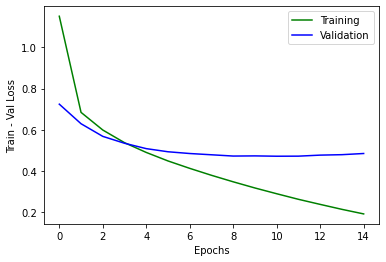

In [ ]:
#Plot graph of epoch v/s train val curve
epochs=[i for i in range(0,15)]
plt.plot(epochs, train_loss_inepocs,color='green',label="Training")
plt.plot(epochs, val_loss_inepochs,color='blue',  label="Validation")
plt.legend()
plt. xlabel('Epochs')
plt.ylabel('Train - Val Loss')
plt.show()

Inference:-

In [ ]:
manager = Manager(is_train=False, ckpt_name="best_ckpt.tar")
manager.inference("Hi i am php","greedy")
manager.inference("Hi i am php","beam")

Loading vocabs...
directory  :- /content/drive/MyDrive/data/src_sp.vocab
The size of src vocab is 9811 and that of trg vocab is 9811.
Loading Transformer model & Adam optimizer...
Getting source/target test.txt...
Tokenizing & Padding src data...


100%|██████████| 1229/1229 [00:00<00:00, 42751.46it/s]


The shape of src data: (1229, 200)
Tokenizing & Padding trg data...


100%|██████████| 1229/1229 [00:00<00:00, 27130.24it/s]

The shape of input trg data: (1229, 200)
The shape of output trg data: (1229, 200)


Loading checkpoint...
Setting finished.
Inference starts.
Loading sentencepiece tokenizer...
Preprocessing input sentence...
Encoding input sentence...
Greedy decoding selected.
Input: Hi i am php
Result: Ist der Standard angegeben, wird die register_globals in PHP-Zeichen
Inference finished! || Total inference time: 0mins 0secs
Inference starts.
Loading sentencepiece tokenizer...
Preprocessing input sentence...
Encoding input sentence...
Beam search selected.
Input: Hi i am php
Result: Ist der Standard angegeben, wird die register_globals in PHP
Inference finished! || Total inference time: 0mins 2secs


In [ ]:
manager = Manager(is_train=False, ckpt_name="best_ckpt.tar")
manager.Accuracy_Check()

Loading vocabs...
directory  :- /content/drive/MyDrive/data/src_sp.vocab
The size of src vocab is 13523 and that of trg vocab is 9811.
Loading Transformer model & Adam optimizer...
Getting source/target test.txt...
Tokenizing & Padding src data...


100%|██████████| 1229/1229 [00:00<00:00, 34153.80it/s]


The tokenized and padded source data eg. :-  [[59, 17, 26, 3402, 51, 11, 9881, 1413, 19, 17, 5900, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [354, 60, 44, 87, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

100%|██████████| 1229/1229 [00:00<00:00, 32496.97it/s]

The tokenized and padded input target data eg. :-  [[1, 177, 71, 12, 858, 8375, 109, 7698, 6776, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 345, 134, 66, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Loading checkpoint...
Setting finished.
Accuracy starts.
Loading sentencepiece tokenizer...
Preprocessing input sentences...
input sentence :-  Das ist weniger rechenintensiv.

translated input sentence :-  This means that you can use the manually to read by Windows NT /www.
Ground Truth :-  It 's less computationally intensive.

-------------------------------------
input sentence :-  %t - an

translated input sentence :-  %D - %V,%G
Ground Truth :-  %t - to

-------------------------------------
input sentence :-  Die bzip2-Funktionen werden benutzt, um transparent bzip2 (.bz2 )-komprimierte Dateien lesen und schreiben zu können.

translated input sentence :-  The file is a character from the file from a file from the file pointer to beened by using the file and will be available at http: / / / / / / /www.com /.com / file.
Ground Truth :-  The bzip2 functions are used to transparently read and write bzip2 (.bz2) compressed files.

-------------------------------------
input sentence 

100%|██████████| 600/600 [00:00<00:00, 77801.97it/s]

Inference finished! || Total inference time: 6mins 48secs
Accuracy Score of the inference is : 12.75573412094234
